In [1]:
import torch
import torch.nn as nn
import argparse,math,numpy as np
import sys
sys.path.append("..")
from models import CTranModel
from config_args import get_args
from utils.early_stopping import EarlyStopping
import utils.evaluate as evaluate
import utils.logger as logger
from pdb import set_trace as stop
from optim_schedule import WarmupLinearSchedule
from run_epoch import run_epoch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from dataloader import create_dataloader
from metric import Metric
torch.cuda.empty_cache()

device = torch.device("cuda:0")
print(device)
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

cuda:0
Current device: NVIDIA A100 80GB PCIe


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 4
num_labels = 21
thresholds = [0.5] * num_labels
in_channels = 3
num_classes = 21
scheduler_step = 1000
scheduler_gamma = 0.1
scheduler_type = 'plateau'
layers = 3
heads = 4 
dropout = 0.1
data_dir = '../../../data/GT-main'
use_lmt = True
pos_emb = True
no_x_features = False


In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../data/GT-main/./set1/train.csv
384
../../../data/GT-main/./set1/val.csv
384
../../../data/GT-main/./set1/test.csv


In [4]:
model = CTranModel(num_labels,use_lmt,device,'denseNet201', pos_emb,layers,heads,dropout,no_x_features)
print(model.self_attn_layers)

model = model.to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.   parameters()),lr=learning_rate)#, weight_decay=0.0004) 

scheduler_warmup = None
if scheduler_type == 'plateau':
    step_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min',factor=0.1,patience=5)
elif scheduler_type == 'step':
    step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
else:
    step_scheduler = None

early_stopping = EarlyStopping(patience=25, min_delta=1e-4)

# metrics_logger = logger.Logger(args)
# loss_logger = logger.LossLogger(args.model_name)

denseNet201


ModuleList(
  (0-2): 3 x SelfAttnLayer(
    (transformer_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=1920, out_features=1920, bias=True)
      )
      (linear1): Linear(in_features=1920, out_features=1920, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1920, out_features=1920, bias=True)
      (norm1): LayerNorm((1920,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((1920,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)


In [5]:
test_preds_all, test_labels_all = [], []
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]

for epoch in range(1,num_epochs+1):
    print('======================== {} ========================'.format(epoch))
    for param_group in optimizer.param_groups:
        print('LR: {}'.format(param_group['lr']))

    ################### Train #################
    metric = Metric(num_classes=num_classes)
    all_preds,all_targs,all_masks,train_loss = run_epoch(model,train_dataloader,optimizer,epoch,'Training',device,metric,train=True, warmup_scheduler=scheduler_warmup)
    # train_metrics = evaluate.compute_metrics(args,all_preds,all_targs,all_masks,    train_loss,train_loss_unk,0,args.train_known_labels)
    # loss_logger.log_losses('train.log',epoch,train_loss,train_metrics,  train_loss_unk)
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    metric.reset()

    ################### Valid #################
    all_preds,all_targs,all_masks,valid_loss = run_epoch (model,val_dataloader,None,epoch,'Validating',device, metric)
    # valid_metrics = evaluate.compute_metrics(args,all_preds,all_targs,all_masks,    valid_loss,valid_loss_unk,0,args.test_known_labels)
    # loss_logger.log_losses('valid.log',epoch,valid_loss,valid_metrics,  valid_loss_unk)
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute()
    print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {valid_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    metric.reset() 
    print(thresh)   
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 

    ################### Test #################
    all_preds,all_targs,all_masks,test_loss=     run_epoch(model,test_dataloader,None,epoch,'Testing',device, metric)
    # test_metrics = evaluate.compute_metrics(args,all_preds,all_targs,   all_masks,test_loss,test_loss_unk,0,args.test_known_labels)
    # loss_logger.log_losses('test.log',epoch,test_loss,test_metrics, test_loss_unk)
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute(thresholds = thresh)
    print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {test_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    metric.reset()
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    print()
    
    f1_arr.append(ml_f1_score)
    model_arr.append(model_score)
    loss_arr.append(test_loss / len(test_dataloader))
    
    if epoch+1 in roc_epochs:
        fpr, tpr, roc_thresholds = roc_curve(np.concatenate(all_targs).ravel(), np.concatenate(all_preds).ravel())
        roc_fpr.append(fpr)
        roc_tpr.append(tpr)
        roc_auc.append(auc(fpr, tpr))
    
    if max_ms[0] < model_score: 
        max_ms[0] = model_score
        max_ms[1] = epoch
        max_ms[2] = optimizer.param_groups[0]['lr']
        torch.save(model, 'models/dn201-all.pth')

    if step_scheduler is not None:
        if scheduler_type == 'step':
            step_scheduler.step(epoch)
        elif scheduler_type == 'plateau':
            step_scheduler.step(valid_loss)

    # early_stopping(valid_loss)
    # if early_stopping.early_stop:
    #     break

    ############## Log and Save ##############
    # best_valid,best_test = metrics_logger.evaluate(train_metrics,valid_metrics, test_metrics,epoch,0,model,valid_loss,test_loss,all_preds,all_targs,all_ids, args)

    # print(args.model_name)

======================== 1 ========================
LR: 1e-06


Epoch [2/200], Loss: 72.1477, ML mAP: 0.0840, ML F1: 0.6049, ML AUC: 0.5127, ML Score: 0.2983, Bin AUC: 0.0000, Model Score: 0.1492, Bin F1: 1.0000
[0.99 0.74 0.01 0.58 0.99 0.87 0.97 0.88 0.55 0.   0.21 0.98 0.   0.6
 0.71 0.99 0.01 0.29 0.97 0.44 0.5 ]
Accuracy list: [0.851063829787234, 0.9507486209613869, 0.9286840031520882, 0.9066193853427896, 0.8443656422379827, 0.875886524822695, 0.9251379038613081, 0.9357762017336485, 0.9302600472813238, 0.9373522458628841, 0.9231678486997635, 0.9330181245074862, 0.9558707643814027, 0.9211977935382191, 0.9377462568951931, 0.9393223010244287, 0.8896769109535066, 0.8356973995271868, 0.888100866824271, 0.9144996059889677, 0.9558707643814027]
Specificity list: [0.9557522123893806, 0.9995857497928748, 0.9987255734919286, 0.9995655951346655, 0.920655454937473, 0.9991011235955056, 0.9991489361702127, 0.9995791245791246, 0.9995766299745978, 1.0, 0.9748953974895398, 0.9995778809624314, 1.0, 0.9626245847176079, 0.999580008399832, 0.9945765540258656, 0.938

Val - Epoch [2/200], Loss: 28.3238, ML mAP: 0.0779, ML F1: 0.0000, ML AUC: 0.6116, ML Score: 0.3448, Bin AUC: 1.0000, Model Score: 0.6724, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9650735294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [2/200], Loss: 29.9033, ML mAP: 0.0795, ML F1: 0.0000, ML AUC: 0.5861, ML Score: 0.3328, Bin AUC: 0.9500, Model Score: 0.6414, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9577205882352942]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 2 ========================
LR: 1e-06


Epoch [3/200], Loss: 35.6969, ML mAP: 0.3089, ML F1: 0.0483, ML AUC: 0.6605, ML Score: 0.4847, Bin AUC: 0.8000, Model Score: 0.6424, Bin F1: 0.0000
[0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8833727344365643, 0.9515366430260047, 0.9231678486997635, 0.913317572892041, 0.9164696611505122, 0.8833727344365643, 0.9345941686367218, 0.9326241134751773, 0.9389282899921197, 0.9432624113475178, 0.9357762017336485, 0.9397163120567376, 0.954688731284476, 0.9416863672182821, 0.9448384554767534, 0.9527186761229315, 0.9408983451536643, 0.9468085106382979, 0.9487785657998424, 0.9078014184397163, 0.950354609929078]
Specificity list: [0.9995541685242978, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Val - Epoch [3/200], Loss: 21.9673, ML mAP: 0.1326, ML F1: 0.0000, ML AUC: 0.6850, ML Score: 0.4088, Bin AUC: 1.0000, Model Score: 0.7044, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9650735294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [3/200], Loss: 23.0165, ML mAP: 0.1269, ML F1: 0.0000, ML AUC: 0.6687, ML Score: 0.3978, Bin AUC: 0.9500, Model Score: 0.6739, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9577205882352942]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 3 ========================
LR: 1e-06


Epoch [4/200], Loss: 30.7381, ML mAP: 0.4579, ML F1: 0.0289, ML AUC: 0.7731, ML Score: 0.6155, Bin AUC: 0.5500, Model Score: 0.5827, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8782505910165485, 0.9519306540583137, 0.9211977935382191, 0.9034672970843184, 0.9113475177304965, 0.88849487785658, 0.9282899921197794, 0.9243498817966903, 0.9472025216706068, 0.9401103230890465, 0.9393223010244287, 0.94602048857368, 0.9408983451536643, 0.9527186761229315, 0.9452324665090622, 0.9479905437352246, 0.942080378250591, 0.9519306540583137, 0.9598108747044918, 0.9113475177304965, 0.9562647754137116]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Val - Epoch [4/200], Loss: 20.8327, ML mAP: 0.1714, ML F1: 0.0000, ML AUC: 0.7383, ML Score: 0.4549, Bin AUC: 0.8500, Model Score: 0.6524, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9650735294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [4/200], Loss: 21.7736, ML mAP: 0.1538, ML F1: 0.0000, ML AUC: 0.7249, ML Score: 0.4393, Bin AUC: 0.8000, Model Score: 0.6197, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9577205882352942]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 4 ========================
LR: 1e-06


Epoch [5/200], Loss: 28.1267, ML mAP: 0.5153, ML F1: 0.0595, ML AUC: 0.8451, ML Score: 0.6802, Bin AUC: 0.5500, Model Score: 0.6151, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8896769109535066, 0.9527186761229315, 0.9267139479905437, 0.9062253743104807, 0.9078014184397163, 0.8944050433412135, 0.9247438928289992, 0.9263199369582348, 0.9342001576044129, 0.9448384554767534, 0.9365642237982663, 0.9424743892829, 0.9535066981875493, 0.9550827423167849, 0.9365642237982663, 0.9539007092198581, 0.9499605988967691, 0.958628841607565, 0.9479905437352246, 0.9109535066981875, 0.9550827423167849]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0, 1.0, 1.0]


Val - Epoch [5/200], Loss: 20.3600, ML mAP: 0.1962, ML F1: 0.0000, ML AUC: 0.7691, ML Score: 0.4826, Bin AUC: 0.6000, Model Score: 0.5413, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9650735294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [5/200], Loss: 21.2455, ML mAP: 0.1742, ML F1: 0.0000, ML AUC: 0.7605, ML Score: 0.4674, Bin AUC: 0.5500, Model Score: 0.5087, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9577205882352942]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 5 ========================
LR: 1e-06


Epoch [6/200], Loss: 25.9360, ML mAP: 0.5718, ML F1: 0.1616, ML AUC: 0.8758, ML Score: 0.7238, Bin AUC: 1.0000, Model Score: 0.8619, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.03 0.   0.   0.  ]
Accuracy list: [0.880220646178093, 0.9519306540583137, 0.9282899921197794, 0.9078014184397163, 0.91725768321513, 0.9058313632781718, 0.9353821907013397, 0.9349881796690307, 0.9345941686367218, 0.950354609929078, 0.9487785657998424, 0.9535066981875493, 0.9499605988967691, 0.9570527974783294, 0.9412923561859732, 0.9613869188337274, 0.9535066981875493, 0.9621749408983451, 0.9554767533490938, 0.9211977935382191, 0.9436564223798266]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9991582491582491, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9928780896522832, 1.0, 1.0, 1.0]


Val - Epoch [6/200], Loss: 20.0048, ML mAP: 0.2182, ML F1: 0.0000, ML AUC: 0.7937, ML Score: 0.5060, Bin AUC: 0.5500, Model Score: 0.5280, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9650735294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [6/200], Loss: 20.9769, ML mAP: 0.1982, ML F1: 0.0000, ML AUC: 0.7805, ML Score: 0.4894, Bin AUC: 0.6000, Model Score: 0.5447, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9577205882352942]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 6 ========================
LR: 1e-06


Epoch [7/200], Loss: 23.9936, ML mAP: 0.6077, ML F1: 0.2921, ML AUC: 0.8932, ML Score: 0.7504, Bin AUC: 1.0000, Model Score: 0.8752, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8770685579196218, 0.94602048857368, 0.9416863672182821, 0.9089834515366431, 0.9275019700551616, 0.9160756501182034, 0.9401103230890465, 0.9322301024428684, 0.9527186761229315, 0.9570527974783294, 0.9661150512214342, 0.9554767533490938, 0.9574468085106383, 0.9625689519306541, 0.9629629629629629, 0.958628841607565, 0.9578408195429472, 0.9653270291568163, 0.9562647754137116, 0.9121355397951143, 0.9562647754137116]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983143699957859, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9916107382550335, 1.0, 1.0, 1.0]


Val - Epoch [7/200], Loss: 19.3195, ML mAP: 0.2383, ML F1: 0.0000, ML AUC: 0.8126, ML Score: 0.5255, Bin AUC: 0.6500, Model Score: 0.5877, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9650735294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [7/200], Loss: 20.0460, ML mAP: 0.2293, ML F1: 0.0000, ML AUC: 0.8008, ML Score: 0.5150, Bin AUC: 0.6000, Model Score: 0.5575, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9577205882352942]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 7 ========================
LR: 1e-06


Epoch [8/200], Loss: 23.0302, ML mAP: 0.6078, ML F1: 0.3689, ML AUC: 0.8991, ML Score: 0.7535, Bin AUC: 0.4500, Model Score: 0.6017, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8821907013396375, 0.9539007092198581, 0.9515366430260047, 0.9085894405043341, 0.942080378250591, 0.9168636721828212, 0.9542947202521671, 0.9302600472813238, 0.9641449960598897, 0.9602048857368006, 0.9605988967691096, 0.9566587864460205, 0.9609929078014184, 0.9684791174152876, 0.9602048857368006, 0.9665090622537431, 0.959022852639874, 0.9629629629629629, 0.9605988967691096, 0.9101654846335697, 0.9598108747044918]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9978982765868012, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924528301886792, 1.0, 1.0, 1.0]


Val - Epoch [8/200], Loss: 18.7842, ML mAP: 0.2638, ML F1: 0.0000, ML AUC: 0.8293, ML Score: 0.5466, Bin AUC: 0.5500, Model Score: 0.5483, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9650735294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [8/200], Loss: 19.5110, ML mAP: 0.2509, ML F1: 0.0000, ML AUC: 0.8173, ML Score: 0.5341, Bin AUC: 0.6000, Model Score: 0.5670, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9577205882352942]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 8 ========================
LR: 1e-06


Epoch [9/200], Loss: 21.5957, ML mAP: 0.6501, ML F1: 0.4242, ML AUC: 0.9146, ML Score: 0.7824, Bin AUC: 1.0000, Model Score: 0.8912, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.08 0.   0.   0.  ]
Accuracy list: [0.8754925137903862, 0.9535066981875493, 0.9519306540583137, 0.9211977935382191, 0.9416863672182821, 0.9263199369582348, 0.9542947202521671, 0.9377462568951931, 0.9692671394799054, 0.9570527974783294, 0.9653270291568163, 0.9550827423167849, 0.9676910953506698, 0.966903073286052, 0.9653270291568163, 0.9637509850275807, 0.9542947202521671, 0.9704491725768322, 0.9645390070921985, 0.9113475177304965, 0.9684791174152876]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953684210526316, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9928751047778709, 1.0, 1.0, 1.0]


Val - Epoch [9/200], Loss: 18.5588, ML mAP: 0.2805, ML F1: 0.0476, ML AUC: 0.8365, ML Score: 0.5585, Bin AUC: 0.6000, Model Score: 0.5792, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 0.9650735294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [9/200], Loss: 19.2390, ML mAP: 0.2642, ML F1: 0.0000, ML AUC: 0.8275, ML Score: 0.5458, Bin AUC: 0.6000, Model Score: 0.5729, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9577205882352942]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 9 ========================
LR: 1e-06


Epoch [10/200], Loss: 21.0608, ML mAP: 0.6413, ML F1: 0.4412, ML AUC: 0.9115, ML Score: 0.7764, Bin AUC: 0.8500, Model Score: 0.8132, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.02 0.   0.   0.   0.  ]
Accuracy list: [0.8967691095350669, 0.9570527974783294, 0.950354609929078, 0.9310480693459416, 0.9377462568951931, 0.9121355397951143, 0.9515366430260047, 0.9507486209613869, 0.9621749408983451, 0.9598108747044918, 0.9574468085106383, 0.9602048857368006, 0.9684791174152876, 0.9696611505122144, 0.9605988967691096, 0.9692671394799054, 0.9594168636721828, 0.9704491725768322, 0.9676910953506698, 0.9141055949566588, 0.966903073286052]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9966173361522199, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9916317991631799, 1.0, 1.0, 1.0]


Val - Epoch [10/200], Loss: 17.9215, ML mAP: 0.2999, ML F1: 0.0000, ML AUC: 0.8460, ML Score: 0.5729, Bin AUC: 0.6000, Model Score: 0.5865, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9650735294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [10/200], Loss: 18.5576, ML mAP: 0.2813, ML F1: 0.0000, ML AUC: 0.8391, ML Score: 0.5602, Bin AUC: 0.6500, Model Score: 0.6051, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9577205882352942]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 10 ========================
LR: 1e-06


Epoch [11/200], Loss: 20.2536, ML mAP: 0.6608, ML F1: 0.4735, ML AUC: 0.9169, ML Score: 0.7889, Bin AUC: 0.9500, Model Score: 0.8694, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.16 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.04 0.03 0.   0.   0.  ]
Accuracy list: [0.8896769109535066, 0.9562647754137116, 0.9535066981875493, 0.9393223010244287, 0.9401103230890465, 0.9196217494089834, 0.9562647754137116, 0.959022852639874, 0.9633569739952719, 0.9602048857368006, 0.9641449960598897, 0.9566587864460205, 0.9700551615445232, 0.9688731284475965, 0.9617809298660362, 0.9653270291568163, 0.9554767533490938, 0.9684791174152876, 0.9684791174152876, 0.9152876280535855, 0.9621749408983451]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9927966101694915, 1.0, 1.0, 1.0, 1.0, 1.0, 0.992050209205021, 1.0, 1.0, 1.0]


Val - Epoch [11/200], Loss: 17.7102, ML mAP: 0.3050, ML F1: 0.0567, ML AUC: 0.8511, ML Score: 0.5780, Bin AUC: 0.7000, Model Score: 0.6390, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.07 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9834558823529411, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.96875]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981343283582089, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [11/200], Loss: 18.2922, ML mAP: 0.2951, ML F1: 0.0171, ML AUC: 0.8469, ML Score: 0.5710, Bin AUC: 0.6000, Model Score: 0.5855, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.07 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9613970588235294]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 11 ========================
LR: 1e-06


Epoch [12/200], Loss: 19.3812, ML mAP: 0.6852, ML F1: 0.5086, ML AUC: 0.9267, ML Score: 0.8059, Bin AUC: 0.9500, Model Score: 0.8780, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.04 0.   0.   0.  ]
Accuracy list: [0.9097714736012609, 0.9499605988967691, 0.9527186761229315, 0.9385342789598109, 0.9385342789598109, 0.9235618597320725, 0.9672970843183609, 0.9570527974783294, 0.9609929078014184, 0.9550827423167849, 0.9661150512214342, 0.9629629629629629, 0.9696611505122144, 0.966903073286052, 0.9629629629629629, 0.9700551615445232, 0.9570527974783294, 0.9680851063829787, 0.9629629629629629, 0.9334121355397951, 0.9747832939322301]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953449005501481, 1.0, 1.0, 1.0, 1.0, 0.9995764506565015, 0.9902912621359223, 1.0, 1.0, 1.0]


Val - Epoch [12/200], Loss: 17.3696, ML mAP: 0.3102, ML F1: 0.0642, ML AUC: 0.8555, ML Score: 0.5828, Bin AUC: 0.6500, Model Score: 0.6164, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.43 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9834558823529411, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9724264705882353]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981343283582089, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [12/200], Loss: 17.8862, ML mAP: 0.3045, ML F1: 0.0713, ML AUC: 0.8534, ML Score: 0.5789, Bin AUC: 0.6500, Model Score: 0.6145, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.43 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9650735294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981481481481481, 1.0, 1.0, 1.0]

======================== 12 ========================
LR: 1e-06


Epoch [13/200], Loss: 18.7266, ML mAP: 0.6928, ML F1: 0.5243, ML AUC: 0.9296, ML Score: 0.8112, Bin AUC: 0.9500, Model Score: 0.8806, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.01 0.   0.   0.  ]
Accuracy list: [0.9200157604412924, 0.9519306540583137, 0.9519306540583137, 0.9405043341213554, 0.9558707643814027, 0.9349881796690307, 0.9578408195429472, 0.9633569739952719, 0.9645390070921985, 0.9629629629629629, 0.9511426319936959, 0.9649330181245075, 0.9700551615445232, 0.958628841607565, 0.9574468085106383, 0.9649330181245075, 0.958628841607565, 0.9791174152876281, 0.9676910953506698, 0.9412923561859732, 0.970843183609141]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9945424013434089, 1.0, 1.0, 1.0, 1.0, 0.9995769881556683, 0.9958176495190297, 1.0, 1.0, 1.0]


Val - Epoch [13/200], Loss: 17.0311, ML mAP: 0.3214, ML F1: 0.0758, ML AUC: 0.8612, ML Score: 0.5913, Bin AUC: 0.7500, Model Score: 0.6707, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.36 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9834558823529411, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9797794117647058]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981343283582089, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [13/200], Loss: 17.6221, ML mAP: 0.3119, ML F1: 0.0384, ML AUC: 0.8598, ML Score: 0.5858, Bin AUC: 0.7500, Model Score: 0.6679, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.36 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9761029411764706]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 13 ========================
LR: 1e-06


Epoch [14/200], Loss: 18.3290, ML mAP: 0.7020, ML F1: 0.5321, ML AUC: 0.9338, ML Score: 0.8179, Bin AUC: 1.0000, Model Score: 0.9089, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.08 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.05 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9231678486997635, 0.950354609929078, 0.9539007092198581, 0.9440504334121356, 0.9432624113475178, 0.9208037825059102, 0.954688731284476, 0.9574468085106383, 0.9680851063829787, 0.9542947202521671, 0.9645390070921985, 0.9633569739952719, 0.9700551615445232, 0.9716312056737588, 0.9539007092198581, 0.9680851063829787, 0.9574468085106383, 0.9795114263199369, 0.9704491725768322, 0.942080378250591, 0.9739952718676123]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.990634312473393, 1.0, 1.0, 0.9995782370307887, 1.0, 1.0, 0.995787700084246, 1.0, 1.0, 1.0]


Val - Epoch [14/200], Loss: 16.7621, ML mAP: 0.3320, ML F1: 0.1321, ML AUC: 0.8654, ML Score: 0.5987, Bin AUC: 0.8000, Model Score: 0.6994, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.68 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9834558823529411, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9852941176470589, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9871323529411765]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981343283582089, 1.0, 1.0, 1.0, 1.0, 0.9981378026070763, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [14/200], Loss: 17.2828, ML mAP: 0.3233, ML F1: 0.1356, ML AUC: 0.8651, ML Score: 0.5942, Bin AUC: 0.7500, Model Score: 0.6721, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.68 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9834558823529411, 0.9816176470588235, 0.9908088235294118, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9779411764705882]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981343283582089, 1.0, 1.0, 0.9981481481481481, 1.0, 1.0, 1.0]

======================== 14 ========================
LR: 1e-06


Epoch [15/200], Loss: 17.1730, ML mAP: 0.7205, ML F1: 0.5518, ML AUC: 0.9362, ML Score: 0.8283, Bin AUC: 1.0000, Model Score: 0.9142, Bin F1: 1.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.9330181245074862, 0.9519306540583137, 0.9468085106382979, 0.9448384554767534, 0.94602048857368, 0.9219858156028369, 0.9558707643814027, 0.9515366430260047, 0.9613869188337274, 0.9641449960598897, 0.9578408195429472, 0.9736012608353034, 0.9653270291568163, 0.97123719464145, 0.9637509850275807, 0.9732072498029944, 0.9649330181245075, 0.9802994483845547, 0.9704491725768322, 0.9448384554767534, 0.9791174152876281]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 0.9991007194244604, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997895622895623, 1.0, 1.0, 0.9995836802664446, 1.0, 0.9991575400168492, 0.9937238493723849, 1.0, 1.0, 1.0]


Val - Epoch [15/200], Loss: 16.4698, ML mAP: 0.3482, ML F1: 0.0986, ML AUC: 0.8698, ML Score: 0.6090, Bin AUC: 0.8000, Model Score: 0.7045, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.65 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9871323529411765, 0.9797794117647058, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9852941176470589, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9908088235294118]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981378026070763, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [15/200], Loss: 16.9149, ML mAP: 0.3316, ML F1: 0.1941, ML AUC: 0.8710, ML Score: 0.6013, Bin AUC: 0.7500, Model Score: 0.6756, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.65 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9797794117647058, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9834558823529411, 0.9816176470588235, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9816176470588235]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981343283582089, 1.0, 0.9981447124304267, 0.9981481481481481, 1.0, 1.0, 1.0]

======================== 15 ========================
LR: 1e-06


Epoch [16/200], Loss: 16.9840, ML mAP: 0.7183, ML F1: 0.5716, ML AUC: 0.9372, ML Score: 0.8278, Bin AUC: 1.0000, Model Score: 0.9139, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.14 0.   0.   0.   0.   0.   0.07 0.   0.
 0.   0.36 0.   0.21 0.   0.   0.  ]
Accuracy list: [0.9200157604412924, 0.966903073286052, 0.9562647754137116, 0.9405043341213554, 0.9507486209613869, 0.9290780141843972, 0.9531126871552403, 0.9617809298660362, 0.9598108747044918, 0.9637509850275807, 0.9613869188337274, 0.970843183609141, 0.97123719464145, 0.9696611505122144, 0.9645390070921985, 0.9704491725768322, 0.9665090622537431, 0.9767533490937746, 0.9676910953506698, 0.9412923561859732, 0.9806934594168637]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949367088607595, 1.0, 1.0, 0.999580008399832, 1.0, 0.9987463435018805, 0.9933166248955723, 1.0, 1.0, 1.0]


Val - Epoch [16/200], Loss: 16.1882, ML mAP: 0.3584, ML F1: 0.1759, ML AUC: 0.8736, ML Score: 0.6160, Bin AUC: 0.8000, Model Score: 0.7080, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 0.9963235294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925373134328358, 1.0, 1.0, 1.0, 1.0, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [16/200], Loss: 16.4938, ML mAP: 0.3483, ML F1: 0.1654, ML AUC: 0.8741, ML Score: 0.6112, Bin AUC: 0.8000, Model Score: 0.7056, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9797794117647058, 0.9889705882352942, 0.9761029411764706, 0.9761029411764706, 0.9816176470588235, 0.9816176470588235, 0.9908088235294118, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9871323529411765]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996268656716418, 1.0, 1.0, 0.9981481481481481, 1.0, 1.0, 1.0]

======================== 16 ========================
LR: 1e-06


Epoch [17/200], Loss: 16.4175, ML mAP: 0.7274, ML F1: 0.5696, ML AUC: 0.9389, ML Score: 0.8331, Bin AUC: 1.0000, Model Score: 0.9166, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.05 0.   0.   0.  ]
Accuracy list: [0.9243498817966903, 0.9613869188337274, 0.9452324665090622, 0.9373522458628841, 0.9479905437352246, 0.9302600472813238, 0.9598108747044918, 0.9582348305752562, 0.9613869188337274, 0.9570527974783294, 0.966903073286052, 0.9732072498029944, 0.97123719464145, 0.9700551615445232, 0.9661150512214342, 0.9684791174152876, 0.9700551615445232, 0.9799054373522459, 0.9641449960598897, 0.9405043341213554, 0.9818754925137904]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 0.9995547640249333, 1.0, 0.9995785924989464, 1.0, 1.0, 1.0, 0.9944938585345193, 1.0, 1.0, 0.998330550918197, 0.9991711562370493, 1.0, 0.993734335839599, 1.0, 1.0, 0.999168744804655]


Val - Epoch [17/200], Loss: 15.8692, ML mAP: 0.3728, ML F1: 0.1938, ML AUC: 0.8770, ML Score: 0.6249, Bin AUC: 0.8000, Model Score: 0.7125, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9816176470588235, 0.9852941176470589, 0.9797794117647058, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 0.9963235294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925373134328358, 1.0, 1.0, 1.0, 1.0, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [17/200], Loss: 16.0891, ML mAP: 0.3562, ML F1: 0.2228, ML AUC: 0.8789, ML Score: 0.6176, Bin AUC: 0.8500, Model Score: 0.7338, Bin F1: 0.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9834558823529411, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9816176470588235, 0.9797794117647058, 0.9908088235294118, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9889705882352942]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9962616822429906, 1.0, 1.0, 0.996268656716418, 0.99812734082397, 1.0, 0.9981481481481481, 1.0, 1.0, 1.0]

======================== 17 ========================
LR: 1e-06


Epoch [18/200], Loss: 16.1041, ML mAP: 0.7344, ML F1: 0.5782, ML AUC: 0.9417, ML Score: 0.8380, Bin AUC: 0.8000, Model Score: 0.8190, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.16 0.   0.   0.  ]
Accuracy list: [0.9243498817966903, 0.9625689519306541, 0.9472025216706068, 0.9444444444444444, 0.9444444444444444, 0.9243498817966903, 0.9566587864460205, 0.9605988967691096, 0.9676910953506698, 0.9519306540583137, 0.9645390070921985, 0.9787234042553191, 0.9641449960598897, 0.9724192277383766, 0.966903073286052, 0.966903073286052, 0.9680851063829787, 0.9814814814814815, 0.9736012608353034, 0.9393223010244287, 0.9862096138691884]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9995674740484429, 0.9995549621717846, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9957752429235319, 1.0, 1.0, 0.9987505206164098, 0.9995822890559732, 0.999160016799664, 0.992895946510656, 1.0, 1.0, 1.0]


Val - Epoch [18/200], Loss: 15.7565, ML mAP: 0.3795, ML F1: 0.1329, ML AUC: 0.8791, ML Score: 0.6293, Bin AUC: 0.8000, Model Score: 0.7146, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.77 0.   0.
 0.   0.   0.18 0.   0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9430147058823529, 0.9375, 0.9522058823529411, 0.9522058823529411, 0.9650735294117647, 0.9797794117647058, 0.9816176470588235, 0.9871323529411765, 0.9797794117647058, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9852941176470589, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 0.9963235294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981378026070763, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [18/200], Loss: 16.0260, ML mAP: 0.3659, ML F1: 0.1952, ML AUC: 0.8811, ML Score: 0.6235, Bin AUC: 0.8500, Model Score: 0.7368, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.77 0.   0.
 0.   0.   0.18 0.   0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9466911764705882, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9834558823529411, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9816176470588235, 0.9779411764705882, 0.9908088235294118, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9926470588235294]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.998062015503876, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9944029850746269, 0.9943820224719101, 0.9981447124304267, 0.9981481481481481, 1.0, 1.0, 1.0]

======================== 18 ========================
LR: 1e-06


Epoch [19/200], Loss: 15.6035, ML mAP: 0.7324, ML F1: 0.5890, ML AUC: 0.9425, ML Score: 0.8375, Bin AUC: 0.9474, Model Score: 0.8924, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.09 0.   0.   0.   0.   0.   0.02 0.   0.
 0.   0.11 0.   0.04 0.   0.   0.  ]
Accuracy list: [0.9282899921197794, 0.9649330181245075, 0.9499605988967691, 0.9468085106382979, 0.9472025216706068, 0.9271079590228526, 0.9519306540583137, 0.9574468085106383, 0.9613869188337274, 0.9570527974783294, 0.9672970843183609, 0.9739952718676123, 0.9680851063829787, 0.9743892828999212, 0.9696611505122144, 0.9704491725768322, 0.9665090622537431, 0.9842395587076438, 0.9657210401891253, 0.9377462568951931, 0.9893617021276596]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9991438356164384, 1.0, 1.0, 0.9991564740615774, 1.0, 1.0, 1.0, 0.9936061381074168, 1.0, 1.0, 0.9979149291075896, 0.9987603305785124, 0.9979018044481746, 0.9949769778149854, 1.0, 1.0, 0.9991704686851929]


Val - Epoch [19/200], Loss: 15.4421, ML mAP: 0.3923, ML F1: 0.2475, ML AUC: 0.8836, ML Score: 0.6380, Bin AUC: 0.8000, Model Score: 0.7190, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.38 0.01 0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9448529411764706, 0.9375, 0.9522058823529411, 0.9503676470588235, 0.9650735294117647, 0.9797794117647058, 0.9834558823529411, 0.9834558823529411, 0.9797794117647058, 0.9761029411764706, 0.9779411764705882, 0.9834558823529411, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 0.9963235294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980694980694981, 1.0, 1.0, 1.0, 0.9906716417910447, 1.0, 1.0, 1.0, 1.0, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [19/200], Loss: 15.5892, ML mAP: 0.3809, ML F1: 0.2568, ML AUC: 0.8851, ML Score: 0.6330, Bin AUC: 0.8000, Model Score: 0.7165, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.38 0.01 0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9466911764705882, 0.9283088235294118, 0.9595588235294118, 0.9430147058823529, 0.9632352941176471, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9761029411764706, 0.9761029411764706, 0.9834558823529411, 0.9816176470588235, 0.9908088235294118, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 0.9944852941176471]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.998062015503876, 1.0, 1.0, 0.996116504854369, 1.0, 1.0, 0.9981203007518797, 1.0, 1.0, 1.0, 0.996268656716418, 1.0, 0.9981447124304267, 0.9962962962962963, 1.0, 1.0, 1.0]

======================== 19 ========================
LR: 1e-06


Epoch [20/200], Loss: 15.3101, ML mAP: 0.7486, ML F1: 0.6115, ML AUC: 0.9467, ML Score: 0.8477, Bin AUC: 1.0000, Model Score: 0.9238, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.03 0.   0.
 0.   0.08 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9286840031520882, 0.9720252167060678, 0.9527186761229315, 0.9397163120567376, 0.9452324665090622, 0.929472025216706, 0.9594168636721828, 0.9570527974783294, 0.9641449960598897, 0.9633569739952719, 0.9716312056737588, 0.9747832939322301, 0.9680851063829787, 0.9763593380614657, 0.9653270291568163, 0.9665090622537431, 0.9704491725768322, 0.9838455476753349, 0.9672970843183609, 0.950354609929078, 0.9866036249014972]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.998707453683757, 0.9991051454138703, 1.0, 0.9995762711864407, 1.0, 1.0, 0.9991589571068125, 0.9940703091910208, 1.0, 1.0, 0.9958211450062683, 0.9987473903966597, 0.9974779319041615, 0.9928148774302621, 1.0, 1.0, 0.9995843724023276]


Val - Epoch [20/200], Loss: 15.3769, ML mAP: 0.3931, ML F1: 0.2627, ML AUC: 0.8866, ML Score: 0.6398, Bin AUC: 0.8000, Model Score: 0.7199, Bin F1: 0.0000
[0.   0.   0.   0.   0.03 0.   0.   0.3  0.   0.   0.   0.11 0.   0.
 0.27 0.   0.26 0.   0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9448529411764706, 0.9375, 0.9522058823529411, 0.9503676470588235, 0.9650735294117647, 0.9797794117647058, 0.9816176470588235, 0.9834558823529411, 0.9797794117647058, 0.9761029411764706, 0.9797794117647058, 0.9852941176470589, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980694980694981, 1.0, 1.0, 1.0, 0.9888059701492538, 1.0, 1.0, 1.0, 1.0, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [20/200], Loss: 15.5642, ML mAP: 0.3878, ML F1: 0.2602, ML AUC: 0.8883, ML Score: 0.6380, Bin AUC: 0.8500, Model Score: 0.7440, Bin F1: 0.0000
[0.   0.   0.   0.   0.03 0.   0.   0.3  0.   0.   0.   0.11 0.   0.
 0.27 0.   0.26 0.   0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9466911764705882, 0.9283088235294118, 0.9595588235294118, 0.9448529411764706, 0.9632352941176471, 0.9761029411764706, 0.9816176470588235, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9834558823529411, 0.9797794117647058, 0.9908088235294118, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9963235294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.998062015503876, 1.0, 1.0, 0.9980582524271845, 1.0, 1.0, 0.9981203007518797, 0.994392523364486, 1.0, 1.0, 0.996268656716418, 0.9943820224719101, 0.9981447124304267, 0.9981481481481481, 1.0, 1.0, 1.0]

======================== 20 ========================
LR: 1e-06


Epoch [21/200], Loss: 15.4598, ML mAP: 0.7433, ML F1: 0.5952, ML AUC: 0.9468, ML Score: 0.8451, Bin AUC: 0.9000, Model Score: 0.8725, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.
 0.27 0.01 0.   0.02 0.   0.   0.  ]
Accuracy list: [0.9271079590228526, 0.9609929078014184, 0.9499605988967691, 0.946414499605989, 0.94602048857368, 0.9322301024428684, 0.9515366430260047, 0.9598108747044918, 0.9633569739952719, 0.9633569739952719, 0.9696611505122144, 0.9728132387706856, 0.9665090622537431, 0.970843183609141, 0.9728132387706856, 0.9704491725768322, 0.970843183609141, 0.9814814814814815, 0.9625689519306541, 0.9468085106382979, 0.9889676910953507]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9978623343309106, 0.998227735932654, 1.0, 0.9991582491582491, 1.0, 1.0, 0.9995819397993311, 0.9911429776465627, 1.0, 1.0, 0.9991645781119465, 0.9983409373703858, 0.9979096989966555, 0.9953839697859841, 1.0, 1.0, 0.9987613542526838]


Val - Epoch [21/200], Loss: 15.1394, ML mAP: 0.3975, ML F1: 0.3177, ML AUC: 0.8897, ML Score: 0.6436, Bin AUC: 0.8500, Model Score: 0.7468, Bin F1: 0.0000
[0.   0.   0.   0.   0.07 0.   0.   0.66 0.   0.   0.   0.   0.   0.28
 0.25 0.   0.63 0.65 0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9448529411764706, 0.9393382352941176, 0.9522058823529411, 0.9503676470588235, 0.9650735294117647, 0.9797794117647058, 0.9834558823529411, 0.9852941176470589, 0.9797794117647058, 0.9742647058823529, 0.9797794117647058, 0.9852941176470589, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980694980694981, 1.0, 1.0, 0.9981167608286252, 0.9925373134328358, 1.0, 0.9981167608286252, 1.0, 1.0, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [21/200], Loss: 15.5040, ML mAP: 0.4035, ML F1: 0.2324, ML AUC: 0.8915, ML Score: 0.6475, Bin AUC: 0.9000, Model Score: 0.7738, Bin F1: 0.0000
[0.   0.   0.   0.   0.07 0.   0.   0.66 0.   0.   0.   0.   0.   0.28
 0.25 0.   0.63 0.65 0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9283088235294118, 0.9595588235294118, 0.9485294117647058, 0.9632352941176471, 0.9761029411764706, 0.9889705882352942, 0.9834558823529411, 0.9761029411764706, 0.9742647058823529, 0.9834558823529411, 0.9816176470588235, 0.9908088235294118, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 0.9963235294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.998062015503876, 1.0, 1.0, 0.9980582524271845, 1.0, 1.0, 0.9981203007518797, 0.994392523364486, 1.0, 0.9981167608286252, 0.996268656716418, 0.99812734082397, 0.9981447124304267, 0.9962962962962963, 1.0, 1.0, 1.0]

======================== 21 ========================
LR: 1e-06


Epoch [22/200], Loss: 14.7572, ML mAP: 0.7601, ML F1: 0.6210, ML AUC: 0.9509, ML Score: 0.8555, Bin AUC: 0.9211, Model Score: 0.8883, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.01 0.01 0.02 0.   0.   0.  ]
Accuracy list: [0.9243498817966903, 0.9688731284475965, 0.9531126871552403, 0.9401103230890465, 0.9495665878644602, 0.9290780141843972, 0.9609929078014184, 0.9566587864460205, 0.9672970843183609, 0.9645390070921985, 0.9716312056737588, 0.9759653270291568, 0.9665090622537431, 0.9743892828999212, 0.9716312056737588, 0.970843183609141, 0.9724192277383766, 0.9846335697399528, 0.9665090622537431, 0.9495665878644602, 0.9901497241922774]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9987174005985464, 0.9991015274034142, 1.0, 0.9966116052520119, 1.0, 1.0, 1.0, 0.9953031596925704, 1.0, 0.9995847176079734, 0.9970857618651124, 0.9987541528239202, 0.9974842767295597, 0.9924749163879598, 0.9995847176079734, 1.0, 0.9995845450768591]


Val - Epoch [22/200], Loss: 15.0665, ML mAP: 0.3968, ML F1: 0.2699, ML AUC: 0.8909, ML Score: 0.6439, Bin AUC: 0.9000, Model Score: 0.7719, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.67 0.   0.   0.04 0.3  0.   0.28
 0.13 0.17 0.47 0.   0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9448529411764706, 0.9375, 0.9522058823529411, 0.9503676470588235, 0.9650735294117647, 0.9797794117647058, 0.9834558823529411, 0.9852941176470589, 0.9797794117647058, 0.9742647058823529, 0.9779411764705882, 0.9871323529411765, 0.9852941176470589, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9961013645224172, 1.0, 1.0, 0.9980694980694981, 1.0, 1.0, 1.0, 0.996268656716418, 1.0, 0.9981167608286252, 0.9981132075471698, 1.0, 0.9981378026070763, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [22/200], Loss: 15.2651, ML mAP: 0.4076, ML F1: 0.2334, ML AUC: 0.8910, ML Score: 0.6493, Bin AUC: 0.9500, Model Score: 0.7997, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.67 0.   0.   0.04 0.3  0.   0.28
 0.13 0.17 0.47 0.   0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9448529411764706, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9889705882352942, 0.9889705882352942, 0.9761029411764706, 0.9742647058823529, 0.9779411764705882, 0.9779411764705882, 0.9926470588235294, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9963235294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9941860465116279, 1.0, 1.0, 0.9980582524271845, 1.0, 1.0, 0.9981203007518797, 1.0, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 1.0, 0.9981481481481481, 1.0, 1.0, 1.0]

======================== 22 ========================
LR: 1e-06


Epoch [23/200], Loss: 14.3301, ML mAP: 0.7693, ML F1: 0.6294, ML AUC: 0.9528, ML Score: 0.8611, Bin AUC: 0.7500, Model Score: 0.8055, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.05 0.   0.   0.   0.07 0.   0.05
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.9330181245074862, 0.9732072498029944, 0.9499605988967691, 0.9373522458628841, 0.9515366430260047, 0.929866036249015, 0.9570527974783294, 0.9578408195429472, 0.9613869188337274, 0.9617809298660362, 0.9747832939322301, 0.9783293932230103, 0.9739952718676123, 0.9728132387706856, 0.9755713159968479, 0.970843183609141, 0.966903073286052, 0.9850275807722616, 0.966903073286052, 0.9448384554767534, 0.9893617021276596]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9978531558608845, 0.9959695476936856, 1.0, 0.9991449337323642, 1.0, 1.0, 0.9995782370307887, 0.9932375316990701, 1.0, 0.9995836802664446, 0.9983277591973244, 0.9987582781456954, 0.9957894736842106, 0.9941447093266416, 1.0, 1.0, 0.999176276771005]


Val - Epoch [23/200], Loss: 15.2057, ML mAP: 0.4085, ML F1: 0.3181, ML AUC: 0.8931, ML Score: 0.6508, Bin AUC: 0.8000, Model Score: 0.7254, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.13 0.   0.01 0.   0.   0.   0.2  0.   0.63
 0.   0.1  0.83 0.21 0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9466911764705882, 0.9411764705882353, 0.9522058823529411, 0.9577205882352942, 0.9650735294117647, 0.9797794117647058, 0.9834558823529411, 0.9889705882352942, 0.9797794117647058, 0.9742647058823529, 0.9779411764705882, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9961013645224172, 1.0, 1.0, 0.9903474903474904, 1.0, 1.0, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9981167608286252, 0.9943396226415094, 1.0, 0.9962756052141527, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [23/200], Loss: 15.6359, ML mAP: 0.4149, ML F1: 0.2711, ML AUC: 0.8941, ML Score: 0.6545, Bin AUC: 0.8500, Model Score: 0.7522, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.13 0.   0.01 0.   0.   0.   0.2  0.   0.63
 0.   0.1  0.83 0.21 0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9466911764705882, 0.9283088235294118, 0.9595588235294118, 0.9632352941176471, 0.9632352941176471, 0.9761029411764706, 0.9889705882352942, 0.9852941176470589, 0.9761029411764706, 0.9742647058823529, 0.9761029411764706, 0.9779411764705882, 0.9908088235294118, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 0.9963235294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9941860465116279, 1.0, 1.0, 0.9922330097087378, 1.0, 1.0, 0.9981203007518797, 0.994392523364486, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9925093632958801, 0.9981447124304267, 0.9962962962962963, 1.0, 1.0, 1.0]

======================== 23 ========================
LR: 1e-06


Epoch [24/200], Loss: 13.6554, ML mAP: 0.7782, ML F1: 0.6380, ML AUC: 0.9552, ML Score: 0.8667, Bin AUC: 1.0000, Model Score: 0.9333, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.   0.   0.05 0.   0.   0.03 0.   0.   0.
 0.   0.   0.01 0.02 0.   0.   0.  ]
Accuracy list: [0.9286840031520882, 0.9633569739952719, 0.9539007092198581, 0.9412923561859732, 0.9491725768321513, 0.9381402679275019, 0.9598108747044918, 0.9598108747044918, 0.9661150512214342, 0.9598108747044918, 0.9720252167060678, 0.9795114263199369, 0.9732072498029944, 0.9783293932230103, 0.9728132387706856, 0.9684791174152876, 0.9747832939322301, 0.9866036249014972, 0.9728132387706856, 0.94602048857368, 0.9885736800630418]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9970021413276231, 0.9973427812223207, 1.0, 0.9966144731273805, 1.0, 1.0, 0.9991607217792698, 0.9936762225969646, 1.0, 0.9987525987525988, 0.9966414777497901, 0.9979114452798663, 0.9970772442588727, 0.9933582399335824, 1.0, 1.0, 0.9987557030277893]


Val - Epoch [24/200], Loss: 14.5382, ML mAP: 0.4162, ML F1: 0.3460, ML AUC: 0.8941, ML Score: 0.6552, Bin AUC: 0.8500, Model Score: 0.7526, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.97 0.   0.   0.   0.35 0.   0.11
 0.01 0.   0.68 0.   0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9466911764705882, 0.9393382352941176, 0.9522058823529411, 0.9503676470588235, 0.9650735294117647, 0.9797794117647058, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.9742647058823529, 0.9797794117647058, 0.9871323529411765, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9961013645224172, 1.0, 1.0, 0.9980694980694981, 1.0, 1.0, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9981167608286252, 0.9943396226415094, 1.0, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [24/200], Loss: 14.9956, ML mAP: 0.4263, ML F1: 0.2501, ML AUC: 0.8963, ML Score: 0.6613, Bin AUC: 0.8500, Model Score: 0.7557, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.97 0.   0.   0.   0.35 0.   0.11
 0.01 0.   0.68 0.   0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9466911764705882, 0.9283088235294118, 0.9595588235294118, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9908088235294118, 0.9834558823529411, 0.9761029411764706, 0.9742647058823529, 0.96875, 0.9797794117647058, 0.9926470588235294, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 0.9963235294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9941860465116279, 1.0, 1.0, 0.9980582524271845, 1.0, 1.0, 0.9981203007518797, 0.994392523364486, 1.0, 0.9981167608286252, 0.9757462686567164, 0.9962546816479401, 1.0, 0.9962962962962963, 1.0, 1.0, 1.0]

======================== 24 ========================
LR: 1e-06


Epoch [25/200], Loss: 13.6980, ML mAP: 0.7745, ML F1: 0.6371, ML AUC: 0.9521, ML Score: 0.8633, Bin AUC: 0.9474, Model Score: 0.9053, Bin F1: 0.6667
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.03 0.   0.16
 0.   0.01 0.   0.09 0.03 0.   0.  ]
Accuracy list: [0.9365642237982663, 0.9629629629629629, 0.9479905437352246, 0.9318360914105595, 0.9491725768321513, 0.9357762017336485, 0.950354609929078, 0.9653270291568163, 0.9621749408983451, 0.9574468085106383, 0.9795114263199369, 0.9810874704491725, 0.9692671394799054, 0.9747832939322301, 0.9755713159968479, 0.9696611505122144, 0.9767533490937746, 0.9909377462568952, 0.9676910953506698, 0.94602048857368, 0.9944838455476753]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9957136733819117, 0.995958688819039, 1.0, 0.9978867286559594, 1.0, 1.0, 0.9991718426501035, 0.994470438111442, 1.0, 0.9987505206164098, 0.995405179615706, 0.9979235880398671, 0.9966414777497901, 0.9970748015043878, 1.0, 1.0, 1.0]


Val - Epoch [25/200], Loss: 14.8896, ML mAP: 0.4218, ML F1: 0.3041, ML AUC: 0.8980, ML Score: 0.6599, Bin AUC: 0.9000, Model Score: 0.7800, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.32 0.   0.
 0.13 0.24 0.52 0.53 0.   0.   0.02]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9466911764705882, 0.9411764705882353, 0.9522058823529411, 0.9577205882352942, 0.9650735294117647, 0.9797794117647058, 0.9834558823529411, 0.9889705882352942, 0.9797794117647058, 0.9834558823529411, 0.9779411764705882, 0.9889705882352942, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9961013645224172, 1.0, 1.0, 0.9903474903474904, 1.0, 1.0, 0.9981167608286252, 0.996268656716418, 1.0, 0.9981167608286252, 0.9962264150943396, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [25/200], Loss: 15.1373, ML mAP: 0.4310, ML F1: 0.2542, ML AUC: 0.8989, ML Score: 0.6650, Bin AUC: 1.0000, Model Score: 0.8325, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.32 0.   0.
 0.13 0.24 0.52 0.53 0.   0.   0.02]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9466911764705882, 0.9283088235294118, 0.9595588235294118, 0.9650735294117647, 0.9632352941176471, 0.9761029411764706, 0.9889705882352942, 0.9889705882352942, 0.9761029411764706, 0.9761029411764706, 0.9834558823529411, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9941860465116279, 1.0, 1.0, 0.9922330097087378, 1.0, 1.0, 0.9981203007518797, 0.9981308411214953, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9850187265917603, 1.0, 0.9962962962962963, 1.0, 1.0, 1.0]

======================== 25 ========================
LR: 1e-06


Epoch [26/200], Loss: 13.4437, ML mAP: 0.7787, ML F1: 0.6468, ML AUC: 0.9546, ML Score: 0.8667, Bin AUC: 0.9737, Model Score: 0.9202, Bin F1: 0.6667
[0.   0.   0.   0.05 0.02 0.   0.   0.23 0.   0.   0.03 0.05 0.06 0.
 0.   0.05 0.   0.09 0.23 0.   0.  ]
Accuracy list: [0.9251379038613081, 0.9653270291568163, 0.9487785657998424, 0.929866036249015, 0.9550827423167849, 0.9408983451536643, 0.9527186761229315, 0.9657210401891253, 0.9566587864460205, 0.9657210401891253, 0.9755713159968479, 0.9814814814814815, 0.9684791174152876, 0.9806934594168637, 0.9739952718676123, 0.9795114263199369, 0.9736012608353034, 0.9885736800630418, 0.9649330181245075, 0.9436564223798266, 0.9929078014184397]
Specificity list: [0.9995539696699376, 1.0, 1.0, 1.0, 0.9974248927038627, 0.9946404644930773, 1.0, 0.9987341772151899, 1.0, 1.0, 0.9987431922915794, 0.9949431099873578, 1.0, 0.9991718426501035, 0.9966485127775451, 0.9995876288659794, 0.9945286195286195, 0.9950020824656394, 0.9995803608896349, 1.0, 0.999586092

Val - Epoch [26/200], Loss: 14.0901, ML mAP: 0.4279, ML F1: 0.2498, ML AUC: 0.8991, ML Score: 0.6635, Bin AUC: 0.9500, Model Score: 0.8068, Bin F1: 0.0000
[0.   0.   0.   0.   0.09 0.   0.   0.21 0.   0.   0.   0.   0.   0.
 0.22 0.09 0.78 0.   0.   0.   0.  ]
Accuracy list: [0.8253676470588235, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9466911764705882, 0.9393382352941176, 0.9522058823529411, 0.9613970588235294, 0.9650735294117647, 0.9797794117647058, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.9834558823529411, 0.9779411764705882, 0.9871323529411765, 0.9852941176470589, 0.9889705882352942, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9961013645224172, 0.9980392156862745, 1.0, 0.9961389961389961, 1.0, 1.0, 0.9981167608286252, 0.9906716417910447, 1.0, 0.9981167608286252, 0.9962264150943396, 1.0, 0.9981378026070763, 1.0, 1.0, 1.0, 1.0]


Test - Epoch [26/200], Loss: 14.2458, ML mAP: 0.4406, ML F1: 0.2005, ML AUC: 0.8999, ML Score: 0.6702, Bin AUC: 1.0000, Model Score: 0.8351, Bin F1: 0.0000
[0.   0.   0.   0.   0.09 0.   0.   0.21 0.   0.   0.   0.   0.   0.
 0.22 0.09 0.78 0.   0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9466911764705882, 0.9283088235294118, 0.9595588235294118, 0.9650735294117647, 0.9632352941176471, 0.9761029411764706, 0.9889705882352942, 0.9852941176470589, 0.9761029411764706, 0.9797794117647058, 0.9852941176470589, 0.9816176470588235, 0.9926470588235294, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9941860465116279, 1.0, 1.0, 0.996116504854369, 1.0, 1.0, 0.9981203007518797, 0.994392523364486, 1.0, 0.9981167608286252, 0.9925373134328358, 0.99812734082397, 1.0, 1.0, 1.0, 1.0, 1.0]

======================== 26 ========================
LR: 1e-06


Epoch [27/200], Loss: 13.3761, ML mAP: 0.7893, ML F1: 0.6447, ML AUC: 0.9592, ML Score: 0.8743, Bin AUC: 1.0000, Model Score: 0.9371, Bin F1: 1.0000
[0.   0.   0.   0.   0.01 0.03 0.   0.23 0.   0.   0.   0.13 0.   0.19
 0.17 0.   0.   0.08 0.03 0.   0.  ]
Accuracy list: [0.9330181245074862, 0.9676910953506698, 0.9483845547675335, 0.9444444444444444, 0.9448384554767534, 0.9436564223798266, 0.9562647754137116, 0.9653270291568163, 0.9633569739952719, 0.9558707643814027, 0.975177304964539, 0.983451536643026, 0.9696611505122144, 0.9763593380614657, 0.9724192277383766, 0.9763593380614657, 0.9743892828999212, 0.9881796690307328, 0.9613869188337274, 0.9381402679275019, 0.9968479117415288]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9956766104626027, 0.9955771782397169, 1.0, 0.9987379049221708, 1.0, 1.0, 0.9987384356602187, 0.9953723180479596, 1.0, 0.9983291562238931, 0.9957983193277311, 0.9991721854304636, 0.9966583124477861, 0.9953878406708595, 0.9995824634655532, 1.0, 0.99958796868562]


Val - Epoch [27/200], Loss: 14.8502, ML mAP: 0.4364, ML F1: 0.3681, ML AUC: 0.8997, ML Score: 0.6680, Bin AUC: 0.9500, Model Score: 0.8090, Bin F1: 0.0000
[0.   0.   0.   0.   0.47 0.   0.   0.02 0.   0.   0.   0.   0.   0.
 0.   0.   0.87 0.71 0.   0.   0.  ]
Accuracy list: [0.8272058823529411, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9466911764705882, 0.9411764705882353, 0.9522058823529411, 0.9595588235294118, 0.9650735294117647, 0.9779411764705882, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.9852941176470589, 0.9797794117647058, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9961013645224172, 1.0, 1.0, 0.9903474903474904, 1.0, 0.99812382739212, 0.9981167608286252, 0.996268656716418, 1.0, 0.9981167608286252, 0.9943396226415094, 0.9887850467289719, 0.9981378026070763, 0.9962825278810409, 1.0, 1.0, 1.0]


Test - Epoch [27/200], Loss: 15.1944, ML mAP: 0.4572, ML F1: 0.2848, ML AUC: 0.9021, ML Score: 0.6797, Bin AUC: 1.0000, Model Score: 0.8398, Bin F1: 0.0000
[0.   0.   0.   0.   0.47 0.   0.   0.02 0.   0.   0.   0.   0.   0.
 0.   0.   0.87 0.71 0.   0.   0.  ]
Accuracy list: [0.8308823529411765, 0.78125, 0.9411764705882353, 0.90625, 0.9466911764705882, 0.9283088235294118, 0.9595588235294118, 0.9632352941176471, 0.9632352941176471, 0.9761029411764706, 0.9908088235294118, 0.9889705882352942, 0.9761029411764706, 0.9834558823529411, 0.9669117647058824, 0.96875, 0.9944852941176471, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9941860465116279, 1.0, 1.0, 0.9902912621359223, 1.0, 1.0, 0.9981203007518797, 0.9981308411214953, 1.0, 0.9981167608286252, 0.9738805970149254, 0.9756554307116105, 1.0, 0.9962962962962963, 0.9962335216572504, 1.0, 1.0]

======================== 27 ========================
LR: 1e-06


Epoch [28/200], Loss: 12.7873, ML mAP: 0.8011, ML F1: 0.6642, ML AUC: 0.9601, ML Score: 0.8806, Bin AUC: 1.0000, Model Score: 0.9403, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.13 0.   0.12 0.   0.05
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.9349881796690307, 0.97123719464145, 0.9527186761229315, 0.9349881796690307, 0.946414499605989, 0.9353821907013397, 0.9558707643814027, 0.9688731284475965, 0.9598108747044918, 0.9542947202521671, 0.9830575256107171, 0.9806934594168637, 0.9747832939322301, 0.9842395587076438, 0.9791174152876281, 0.9728132387706856, 0.975177304964539, 0.9901497241922774, 0.966903073286052, 0.9432624113475178, 0.9933018124507487]
Specificity list: [1.0, 1.0, 0.9995750106247344, 1.0, 0.9921841076856275, 0.9954934655250113, 1.0, 0.9970364098221846, 1.0, 1.0, 0.998329853862213, 0.9948979591836735, 1.0, 0.9987541528239202, 0.9962406015037594, 0.9966777408637874, 0.996215306980656, 0.9954090150250418, 0.9991690901537184, 1.0, 1.0]


Val - Epoch [28/200], Loss: 13.9254, ML mAP: 0.4458, ML F1: 0.3151, ML AUC: 0.9020, ML Score: 0.6739, Bin AUC: 0.9500, Model Score: 0.8119, Bin F1: 0.0000
[0.   0.   0.   0.   0.94 0.   0.   0.06 0.   0.   0.   0.17 0.   0.
 0.33 0.38 0.71 0.08 0.   0.   0.  ]
Accuracy list: [0.8272058823529411, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9485294117647058, 0.9411764705882353, 0.9522058823529411, 0.9595588235294118, 0.9650735294117647, 0.9797794117647058, 0.9852941176470589, 0.9908088235294118, 0.9797794117647058, 0.9852941176470589, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9980506822612085, 0.9980392156862745, 1.0, 0.9922779922779923, 1.0, 1.0, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9981167608286252, 1.0, 1.0, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [28/200], Loss: 14.1143, ML mAP: 0.4660, ML F1: 0.2875, ML AUC: 0.9034, ML Score: 0.6847, Bin AUC: 1.0000, Model Score: 0.8423, Bin F1: 0.0000
[0.   0.   0.   0.   0.94 0.   0.   0.06 0.   0.   0.   0.17 0.   0.
 0.33 0.38 0.71 0.08 0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9485294117647058, 0.9319852941176471, 0.9595588235294118, 0.9650735294117647, 0.9632352941176471, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9761029411764706, 0.9834558823529411, 0.9852941176470589, 0.9797794117647058, 0.9944852941176471, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.998062015503876, 0.998019801980198, 1.0, 0.996116504854369, 1.0, 1.0, 0.9981203007518797, 0.994392523364486, 1.0, 0.9981167608286252, 0.9925373134328358, 0.9943820224719101, 1.0, 0.9962962962962963, 1.0, 1.0, 1.0]

======================== 28 ========================
LR: 1e-06


Epoch [29/200], Loss: 12.2554, ML mAP: 0.8004, ML F1: 0.6658, ML AUC: 0.9602, ML Score: 0.8803, Bin AUC: 0.9500, Model Score: 0.9151, Bin F1: 0.0000
[0.   0.   0.   0.36 0.   0.   0.   0.03 0.   0.45 0.   0.23 0.   0.17
 0.06 0.01 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9381402679275019, 0.9700551615445232, 0.950354609929078, 0.9408983451536643, 0.9519306540583137, 0.950354609929078, 0.9582348305752562, 0.9661150512214342, 0.959022852639874, 0.9625689519306541, 0.9810874704491725, 0.9881796690307328, 0.9696611505122144, 0.9791174152876281, 0.9775413711583925, 0.9724192277383766, 0.9755713159968479, 0.9929078014184397, 0.9625689519306541, 0.9440504334121356, 0.9933018124507487]
Specificity list: [0.9995596653456627, 1.0, 1.0, 1.0, 0.992722602739726, 0.9947113265755839, 1.0, 0.9987389659520807, 1.0, 1.0, 0.9995801847187238, 0.9979044425817267, 0.9995840266222962, 0.9987489574645538, 0.9966638865721434, 0.9966597077244259, 0.9962057335581788, 0.9966301600673968, 0.9987531172069826, 1.

Val - Epoch [29/200], Loss: 13.9424, ML mAP: 0.4555, ML F1: 0.3705, ML AUC: 0.9040, ML Score: 0.6797, Bin AUC: 0.9500, Model Score: 0.8149, Bin F1: 0.0000
[0.   0.   0.   0.   0.27 0.   0.   0.18 0.   0.   0.   0.   0.   0.24
 0.1  0.04 0.93 0.   0.   0.   0.  ]
Accuracy list: [0.8272058823529411, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9466911764705882, 0.9393382352941176, 0.9522058823529411, 0.9595588235294118, 0.9650735294117647, 0.9797794117647058, 0.9852941176470589, 0.9889705882352942, 0.9797794117647058, 0.9852941176470589, 0.9834558823529411, 0.9889705882352942, 0.9852941176470589, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9961013645224172, 1.0, 1.0, 0.9903474903474904, 1.0, 1.0, 0.9981167608286252, 0.996268656716418, 1.0, 0.9981167608286252, 0.9943396226415094, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [29/200], Loss: 14.3634, ML mAP: 0.4699, ML F1: 0.3059, ML AUC: 0.9049, ML Score: 0.6874, Bin AUC: 1.0000, Model Score: 0.8437, Bin F1: 0.0000
[0.   0.   0.   0.   0.27 0.   0.   0.18 0.   0.   0.   0.   0.   0.24
 0.1  0.04 0.93 0.   0.   0.   0.  ]
Accuracy list: [0.8308823529411765, 0.78125, 0.9411764705882353, 0.90625, 0.9503676470588235, 0.9283088235294118, 0.9595588235294118, 0.9650735294117647, 0.9632352941176471, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9779411764705882, 0.9852941176470589, 0.9705882352941176, 0.9834558823529411, 0.9908088235294118, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9941860465116279, 1.0, 1.0, 0.9922330097087378, 1.0, 1.0, 0.9981203007518797, 0.9962616822429906, 1.0, 0.9981167608286252, 0.9757462686567164, 0.9887640449438202, 0.9962894248608535, 0.9962962962962963, 0.9962335216572504, 1.0, 1.0]

======================== 29 ===================

Epoch [30/200], Loss: 12.1286, ML mAP: 0.8081, ML F1: 0.6711, ML AUC: 0.9610, ML Score: 0.8845, Bin AUC: 0.6500, Model Score: 0.7673, Bin F1: 0.0000
[0.   0.   0.01 0.07 0.05 0.   0.   0.08 0.   0.   0.   0.   0.   0.
 0.04 0.   0.07 0.01 0.   0.   0.04]
Accuracy list: [0.9310480693459416, 0.9633569739952719, 0.9562647754137116, 0.9290780141843972, 0.9531126871552403, 0.9440504334121356, 0.9539007092198581, 0.9720252167060678, 0.9605988967691096, 0.9621749408983451, 0.9759653270291568, 0.9866036249014972, 0.9732072498029944, 0.9846335697399528, 0.9802994483845547, 0.9783293932230103, 0.9732072498029944, 0.9897557131599685, 0.9755713159968479, 0.9452324665090622, 0.9944838455476753]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9935705100728676, 0.994250331711632, 1.0, 0.9958211450062683, 1.0, 1.0, 0.9983221476510067, 0.9953527672158851, 1.0, 0.9991652754590985, 0.9962057335581788, 0.9983340274885465, 0.9949152542372881, 0.9949409780775716, 0.9995860927152318, 1.0, 0.9991766158913133]


Val - Epoch [30/200], Loss: 13.7156, ML mAP: 0.4593, ML F1: 0.3293, ML AUC: 0.9046, ML Score: 0.6820, Bin AUC: 0.9500, Model Score: 0.8160, Bin F1: 0.0000
[0.   0.   0.   0.   0.25 0.06 0.   0.   0.   0.   0.   0.   0.   0.
 0.05 0.05 0.97 0.25 0.   0.   0.  ]
Accuracy list: [0.8272058823529411, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9466911764705882, 0.9411764705882353, 0.9522058823529411, 0.9577205882352942, 0.9650735294117647, 0.9797794117647058, 0.9852941176470589, 0.9889705882352942, 0.9797794117647058, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9961013645224172, 1.0, 1.0, 0.9903474903474904, 1.0, 1.0, 0.9981167608286252, 0.996268656716418, 1.0, 0.9981167608286252, 0.9981132075471698, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [30/200], Loss: 14.0179, ML mAP: 0.4670, ML F1: 0.3020, ML AUC: 0.9060, ML Score: 0.6865, Bin AUC: 1.0000, Model Score: 0.8433, Bin F1: 0.0000
[0.   0.   0.   0.   0.25 0.06 0.   0.   0.   0.   0.   0.   0.   0.
 0.05 0.05 0.97 0.25 0.   0.   0.  ]
Accuracy list: [0.8290441176470589, 0.78125, 0.9411764705882353, 0.90625, 0.9522058823529411, 0.9301470588235294, 0.9595588235294118, 0.9650735294117647, 0.9632352941176471, 0.9761029411764706, 0.9908088235294118, 0.9852941176470589, 0.9779411764705882, 0.9816176470588235, 0.9816176470588235, 0.9816176470588235, 0.9926470588235294, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 0.9963235294117647]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9941860465116279, 0.998019801980198, 1.0, 0.9941747572815534, 1.0, 1.0, 0.9981203007518797, 0.994392523364486, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9906367041198502, 0.9981447124304267, 0.9962962962962963, 1.0, 1.0, 1.0]

======================== 30 =======================

Epoch [31/200], Loss: 11.7420, ML mAP: 0.8182, ML F1: 0.6836, ML AUC: 0.9639, ML Score: 0.8910, Bin AUC: 1.0000, Model Score: 0.9455, Bin F1: 0.0000
[0.   0.   0.   0.47 0.03 0.   0.   0.13 0.01 0.   0.   0.02 0.04 0.
 0.   0.03 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9369582348305753, 0.9665090622537431, 0.9566587864460205, 0.9424743892829, 0.9527186761229315, 0.9499605988967691, 0.9629629629629629, 0.9716312056737588, 0.9621749408983451, 0.9594168636721828, 0.9810874704491725, 0.9866036249014972, 0.9692671394799054, 0.9795114263199369, 0.9814814814814815, 0.9763593380614657, 0.9799054373522459, 0.9909377462568952, 0.9645390070921985, 0.9428684003152088, 0.9940898345153665]
Specificity list: [0.9995559502664298, 1.0, 0.9995737425404945, 1.0, 0.9923011120615911, 0.9951499118165785, 1.0, 0.9970575872215216, 1.0, 1.0, 0.9983193277310924, 0.996640067198656, 0.9995841995841996, 0.9979235880398671, 0.9979096989966555, 0.9983340274885465, 0.9978902953586498, 0.9966471081307627, 0.9979157

Val - Epoch [31/200], Loss: 13.6770, ML mAP: 0.4688, ML F1: 0.3066, ML AUC: 0.9063, ML Score: 0.6875, Bin AUC: 0.9500, Model Score: 0.8188, Bin F1: 0.0000
[0.   0.   0.   0.   0.41 0.03 0.   0.02 0.   0.   0.   0.   0.   0.03
 0.22 0.11 0.82 0.45 0.   0.   0.2 ]
Accuracy list: [0.8272058823529411, 0.7830882352941176, 0.9375, 0.9080882352941176, 0.9466911764705882, 0.9430147058823529, 0.9522058823529411, 0.9595588235294118, 0.9650735294117647, 0.9797794117647058, 0.9852941176470589, 0.9908088235294118, 0.9816176470588235, 0.9852941176470589, 0.9871323529411765, 0.9908088235294118, 0.9871323529411765, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9961013645224172, 1.0, 1.0, 0.9903474903474904, 1.0, 1.0, 0.9981167608286252, 0.996268656716418, 1.0, 0.9981167608286252, 1.0, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [31/200], Loss: 14.0582, ML mAP: 0.4785, ML F1: 0.3076, ML AUC: 0.9072, ML Score: 0.6929, Bin AUC: 1.0000, Model Score: 0.8464, Bin F1: 0.0000
[0.   0.   0.   0.   0.41 0.03 0.   0.02 0.   0.   0.   0.   0.   0.03
 0.22 0.11 0.82 0.45 0.   0.   0.2 ]
Accuracy list: [0.8308823529411765, 0.78125, 0.9411764705882353, 0.90625, 0.9503676470588235, 0.9319852941176471, 0.9595588235294118, 0.9669117647058824, 0.9632352941176471, 0.9761029411764706, 0.9871323529411765, 0.9852941176470589, 0.9779411764705882, 0.9816176470588235, 0.9816176470588235, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9941860465116279, 0.998019801980198, 1.0, 0.9922330097087378, 1.0, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9906367041198502, 0.9962894248608535, 0.9981481481481481, 0.9981167608286252, 1.0, 1.0]

======================== 31 =====

Epoch [32/200], Loss: 11.6244, ML mAP: 0.8185, ML F1: 0.6856, ML AUC: 0.9659, ML Score: 0.8922, Bin AUC: 1.0000, Model Score: 0.9461, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.04 0.   0.08 0.   0.1  0.28 0.   0.   0.
 0.   0.01 0.1  0.   0.   0.   0.  ]
Accuracy list: [0.9334121355397951, 0.9771473601260835, 0.954688731284476, 0.9373522458628841, 0.9535066981875493, 0.9487785657998424, 0.9562647754137116, 0.9665090622537431, 0.9539007092198581, 0.9629629629629629, 0.983451536643026, 0.9850275807722616, 0.9688731284475965, 0.9818754925137904, 0.9771473601260835, 0.9795114263199369, 0.9795114263199369, 0.9925137903861309, 0.9728132387706856, 0.9475965327029157, 0.9940898345153665]
Specificity list: [0.9995535714285714, 1.0, 0.9995731967562953, 0.9991239597021463, 0.9948409286328461, 0.9969217238346526, 1.0, 0.9966372425388819, 1.0, 0.9995819397993311, 0.9991704686851929, 0.9958211450062683, 0.9991697799916978, 0.9974905897114178, 0.9954032595068951, 0.9970942299709423, 0.994932432432432

Val - Epoch [32/200], Loss: 13.4554, ML mAP: 0.4711, ML F1: 0.3525, ML AUC: 0.9085, ML Score: 0.6898, Bin AUC: 0.8500, Model Score: 0.7699, Bin F1: 0.0000
[0.   0.   0.   0.   0.28 0.09 0.   0.   0.   0.   0.   0.   0.   0.14
 0.   0.   0.39 0.54 0.   0.   0.  ]
Accuracy list: [0.8272058823529411, 0.7830882352941176, 0.9375, 0.9172794117647058, 0.9430147058823529, 0.9430147058823529, 0.9522058823529411, 0.9577205882352942, 0.9669117647058824, 0.9797794117647058, 0.9852941176470589, 0.9889705882352942, 0.9816176470588235, 0.9852941176470589, 0.9871323529411765, 0.9889705882352942, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9902534113060428, 1.0, 1.0, 0.9864864864864865, 1.0, 1.0, 0.9981167608286252, 0.996268656716418, 1.0, 0.9981167608286252, 0.9962264150943396, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 1.0, 1.0, 1.0]


Test - Epoch [32/200], Loss: 13.8988, ML mAP: 0.4823, ML F1: 0.3756, ML AUC: 0.9090, ML Score: 0.6957, Bin AUC: 0.9000, Model Score: 0.7978, Bin F1: 0.0000
[0.   0.   0.   0.   0.28 0.09 0.   0.   0.   0.   0.   0.   0.   0.14
 0.   0.   0.39 0.54 0.   0.   0.  ]
Accuracy list: [0.8327205882352942, 0.78125, 0.9411764705882353, 0.90625, 0.9558823529411765, 0.9319852941176471, 0.9595588235294118, 0.96875, 0.9613970588235294, 0.9761029411764706, 0.9889705882352942, 0.9834558823529411, 0.9779411764705882, 0.9834558823529411, 0.9834558823529411, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 0.9979716024340771, 0.9922480620155039, 0.998019801980198, 1.0, 0.9883495145631068, 0.9980916030534351, 1.0, 0.9981203007518797, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9887640449438202, 0.9962894248608535, 0.9981481481481481, 0.9981167608286252, 1.0, 1.0]

==============

Epoch [33/200], Loss: 11.5739, ML mAP: 0.8127, ML F1: 0.6762, ML AUC: 0.9633, ML Score: 0.8880, Bin AUC: 1.0000, Model Score: 0.9440, Bin F1: 1.0000
[0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.29 0.   0.   0.   0.13
 0.29 0.   0.42 0.   0.   0.   0.  ]
Accuracy list: [0.929472025216706, 0.9704491725768322, 0.9539007092198581, 0.9412923561859732, 0.9507486209613869, 0.9440504334121356, 0.9570527974783294, 0.9672970843183609, 0.9562647754137116, 0.9578408195429472, 0.9795114263199369, 0.987785657998424, 0.9724192277383766, 0.9842395587076438, 0.9759653270291568, 0.9842395587076438, 0.9795114263199369, 0.9936958234830575, 0.9676910953506698, 0.9432624113475178, 0.9952718676122931]
Specificity list: [0.9986636971046771, 1.0, 1.0, 1.0, 0.9918454935622317, 0.9955476402493322, 1.0, 0.9936548223350253, 0.9983256592716618, 1.0, 0.9979070740895772, 0.9974758098443416, 1.0, 0.9979270315091211, 0.9953974895397489, 0.9970954356846473, 0.9974726200505476, 0.9962437395659433, 0.9983347210657785, 

Val - Epoch [33/200], Loss: 13.4632, ML mAP: 0.4773, ML F1: 0.4576, ML AUC: 0.9095, ML Score: 0.6934, Bin AUC: 0.8000, Model Score: 0.7467, Bin F1: 0.0000
[0.   0.   0.   0.   0.09 0.32 0.   0.   0.   0.14 0.   0.   0.   0.
 0.   0.   0.77 0.   0.   0.   0.15]
Accuracy list: [0.8290441176470589, 0.7830882352941176, 0.9393382352941176, 0.9172794117647058, 0.9411764705882353, 0.9430147058823529, 0.9522058823529411, 0.9577205882352942, 0.9669117647058824, 0.9779411764705882, 0.9871323529411765, 0.9908088235294118, 0.9816176470588235, 0.9852941176470589, 0.9852941176470589, 0.9871323529411765, 0.9852941176470589, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 1.0, 1.0, 0.9883040935672515, 1.0, 1.0, 0.9864864864864865, 1.0, 0.99812382739212, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [33/200], Loss: 13.6839, ML mAP: 0.4872, ML F1: 0.3898, ML AUC: 0.9111, ML Score: 0.6992, Bin AUC: 0.9500, Model Score: 0.8246, Bin F1: 0.0000
[0.   0.   0.   0.   0.09 0.32 0.   0.   0.   0.14 0.   0.   0.   0.
 0.   0.   0.77 0.   0.   0.   0.15]
Accuracy list: [0.8345588235294118, 0.78125, 0.9411764705882353, 0.90625, 0.9540441176470589, 0.9301470588235294, 0.9595588235294118, 0.9650735294117647, 0.9613970588235294, 0.9761029411764706, 0.9908088235294118, 0.9852941176470589, 0.9797794117647058, 0.9834558823529411, 0.9816176470588235, 0.9889705882352942, 0.9926470588235294, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 0.9979716024340771, 0.9903100775193798, 0.998019801980198, 1.0, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9943502824858758, 0.9888059701492538, 0.9925093632958801, 0.9981447124304267, 0.9962962962962963, 0.9962335216572504, 1.0, 1.0]

=====

Epoch [34/200], Loss: 10.7308, ML mAP: 0.8330, ML F1: 0.7005, ML AUC: 0.9672, ML Score: 0.9001, Bin AUC: 1.0000, Model Score: 0.9500, Bin F1: 0.0000
[0.   0.   0.   0.04 0.   0.03 0.   0.   0.26 0.   0.   0.09 0.   0.
 0.   0.09 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9330181245074862, 0.9672970843183609, 0.9535066981875493, 0.9381402679275019, 0.9511426319936959, 0.9511426319936959, 0.9558707643814027, 0.9692671394799054, 0.9609929078014184, 0.9570527974783294, 0.983451536643026, 0.9897557131599685, 0.9775413711583925, 0.9850275807722616, 0.983451536643026, 0.9795114263199369, 0.9814814814814815, 0.9956658786446021, 0.97123719464145, 0.942080378250591, 0.9972419227738377]
Specificity list: [0.9995557529986673, 1.0, 0.9991438356164384, 0.999129677980853, 0.9939707149009475, 0.9955732625055335, 1.0, 0.9957716701902748, 1.0, 1.0, 0.997060058798824, 0.9970588235294118, 0.999176276771005, 0.997513468711148, 0.9970748015043878, 0.9966680549770929, 0.9966386554621849, 0.9975, 0.997935590

Val - Epoch [34/200], Loss: 13.9423, ML mAP: 0.4806, ML F1: 0.4230, ML AUC: 0.9110, ML Score: 0.6958, Bin AUC: 0.8500, Model Score: 0.7729, Bin F1: 0.0000
[0.   0.   0.   0.   0.3  0.04 0.   0.   0.   0.36 0.   0.   0.   0.15
 0.07 0.42 0.58 0.39 0.01 0.   0.08]
Accuracy list: [0.8290441176470589, 0.7830882352941176, 0.9375, 0.9191176470588235, 0.9411764705882353, 0.9411764705882353, 0.9522058823529411, 0.9577205882352942, 0.9669117647058824, 0.9779411764705882, 0.9852941176470589, 0.9889705882352942, 0.9816176470588235, 0.9871323529411765, 0.9871323529411765, 0.9889705882352942, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 1.0, 1.0, 0.9883040935672515, 0.9980392156862745, 1.0, 0.9864864864864865, 1.0, 0.99812382739212, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9981167608286252, 1.0, 0.9925233644859813, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [34/200], Loss: 14.2180, ML mAP: 0.4899, ML F1: 0.3794, ML AUC: 0.9124, ML Score: 0.7012, Bin AUC: 0.9500, Model Score: 0.8256, Bin F1: 0.0000
[0.   0.   0.   0.   0.3  0.04 0.   0.   0.   0.36 0.   0.   0.   0.15
 0.07 0.42 0.58 0.39 0.01 0.   0.08]
Accuracy list: [0.8363970588235294, 0.78125, 0.9430147058823529, 0.90625, 0.9558823529411765, 0.9356617647058824, 0.9595588235294118, 0.96875, 0.9613970588235294, 0.9761029411764706, 0.9889705882352942, 0.9852941176470589, 0.9779411764705882, 0.9834558823529411, 0.9816176470588235, 0.96875, 0.9908088235294118, 0.9871323529411765, 0.9724264705882353, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9977827050997783, 1.0, 1.0, 0.9979716024340771, 0.9922480620155039, 0.998019801980198, 1.0, 0.9883495145631068, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9719101123595506, 0.9962894248608535, 0.9944444444444445, 0.9943502824858758, 1.0, 1.0]

==========

Epoch [35/200], Loss: 10.6516, ML mAP: 0.8366, ML F1: 0.7071, ML AUC: 0.9689, ML Score: 0.9027, Bin AUC: 1.0000, Model Score: 0.9514, Bin F1: 1.0000
[0.   0.   0.08 0.03 0.05 0.01 0.   0.01 0.14 0.   0.   0.   0.   0.
 0.3  0.   0.   0.   0.   0.   0.06]
Accuracy list: [0.9393223010244287, 0.9739952718676123, 0.9562647754137116, 0.9424743892829, 0.9562647754137116, 0.9495665878644602, 0.9578408195429472, 0.9692671394799054, 0.9574468085106383, 0.9645390070921985, 0.9822695035460993, 0.9842395587076438, 0.9747832939322301, 0.987391646966115, 0.9822695035460993, 0.983451536643026, 0.9810874704491725, 0.9948778565799843, 0.9700551615445232, 0.9452324665090622, 0.996059889676911]
Specificity list: [0.9995590828924162, 1.0, 1.0, 0.9991349480968859, 0.9922713610991842, 0.9959767545820295, 1.0, 0.993619736282433, 0.9995793016407236, 1.0, 0.9974608548455354, 0.9944915254237288, 1.0, 0.9983409373703858, 0.9966428871170793, 0.9958246346555324, 0.9953664700926707, 0.9974863845831587, 0.9983305509

Val - Epoch [35/200], Loss: 13.1737, ML mAP: 0.4808, ML F1: 0.4635, ML AUC: 0.9128, ML Score: 0.6968, Bin AUC: 0.9500, Model Score: 0.8234, Bin F1: 0.0000
[0.02 0.   0.   0.   0.33 0.06 0.   0.   0.   0.04 0.   0.   0.   0.39
 0.   0.04 0.55 0.92 0.01 0.   0.  ]
Accuracy list: [0.8272058823529411, 0.7830882352941176, 0.9393382352941176, 0.9191176470588235, 0.9393382352941176, 0.9411764705882353, 0.9522058823529411, 0.9577205882352942, 0.9669117647058824, 0.9779411764705882, 0.9871323529411765, 0.9908088235294118, 0.9816176470588235, 0.9871323529411765, 0.9871323529411765, 0.9889705882352942, 0.9852941176470589, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.98635477582846, 0.996078431372549, 1.0, 0.9864864864864865, 1.0, 0.99812382739212, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9981167608286252, 1.0, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [35/200], Loss: 13.5727, ML mAP: 0.4884, ML F1: 0.3969, ML AUC: 0.9125, ML Score: 0.7004, Bin AUC: 0.9500, Model Score: 0.8252, Bin F1: 0.0000
[0.02 0.   0.   0.   0.33 0.06 0.   0.   0.   0.04 0.   0.   0.   0.39
 0.   0.04 0.55 0.92 0.01 0.   0.  ]
Accuracy list: [0.8345588235294118, 0.78125, 0.9448529411764706, 0.90625, 0.9558823529411765, 0.9356617647058824, 0.9595588235294118, 0.9705882352941176, 0.9613970588235294, 0.9761029411764706, 0.9889705882352942, 0.9834558823529411, 0.9797794117647058, 0.9834558823529411, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9889705882352942, 0.9724264705882353, 0.8602941176470589, 0.9981617647058824]
Specificity list: [1.0, 1.0, 1.0, 0.9979716024340771, 0.9922480620155039, 0.998019801980198, 1.0, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9850187265917603, 0.9962894248608535, 0.9962962962962963, 0.9943502824858758, 1.0, 1.0]

===

Epoch [36/200], Loss: 10.8740, ML mAP: 0.8370, ML F1: 0.7131, ML AUC: 0.9685, ML Score: 0.9027, Bin AUC: 1.0000, Model Score: 0.9514, Bin F1: 1.0000
[0.   0.   0.01 0.08 0.   0.   0.   0.08 0.   0.   0.   0.   0.06 0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.9349881796690307, 0.9763593380614657, 0.9527186761229315, 0.9405043341213554, 0.9554767533490938, 0.9487785657998424, 0.9507486209613869, 0.966903073286052, 0.9605988967691096, 0.9602048857368006, 0.9802994483845547, 0.9866036249014972, 0.9775413711583925, 0.9858156028368794, 0.9802994483845547, 0.9869976359338062, 0.9826635145784082, 0.9885736800630418, 0.9767533490937746, 0.9491725768321513, 0.9956658786446021]
Specificity list: [0.99867197875166, 1.0, 0.997865072587532, 0.9995638901003053, 0.9943747295543055, 0.9937416182387125, 1.0, 0.9953271028037384, 0.9987336428872943, 0.9987368421052631, 0.9953859060402684, 0.9944657300979141, 0.9991711562370493, 0.9958454507685917, 0.9945788156797332, 0.9987587918907737, 0.99

Val - Epoch [36/200], Loss: 13.2271, ML mAP: 0.4855, ML F1: 0.4462, ML AUC: 0.9136, ML Score: 0.6995, Bin AUC: 0.9500, Model Score: 0.8248, Bin F1: 0.0000
[0.   0.   0.   0.   0.05 0.   0.   0.   0.   0.13 0.   0.24 0.   0.35
 0.   0.   0.58 0.38 0.01 0.   0.21]
Accuracy list: [0.8308823529411765, 0.7830882352941176, 0.9430147058823529, 0.9227941176470589, 0.9356617647058824, 0.9393382352941176, 0.9522058823529411, 0.9577205882352942, 0.9669117647058824, 0.9779411764705882, 0.9852941176470589, 0.9889705882352942, 0.9816176470588235, 0.9852941176470589, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 0.9980392156862745, 0.9979757085020243, 0.9805068226120858, 0.9921568627450981, 1.0, 0.9826254826254827, 1.0, 0.99812382739212, 0.9981167608286252, 0.996268656716418, 1.0, 0.992467043314501, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.99812382739212

Test - Epoch [36/200], Loss: 13.7742, ML mAP: 0.4965, ML F1: 0.4074, ML AUC: 0.9143, ML Score: 0.7054, Bin AUC: 1.0000, Model Score: 0.8527, Bin F1: 0.0000
[0.   0.   0.   0.   0.05 0.   0.   0.   0.   0.13 0.   0.24 0.   0.35
 0.   0.   0.58 0.38 0.01 0.   0.21]
Accuracy list: [0.8363970588235294, 0.78125, 0.9466911764705882, 0.9099264705882353, 0.9540441176470589, 0.9393382352941176, 0.9613970588235294, 0.9705882352941176, 0.9613970588235294, 0.9761029411764706, 0.9889705882352942, 0.9834558823529411, 0.9797794117647058, 0.9816176470588235, 0.9834558823529411, 0.9834558823529411, 0.9852941176470589, 0.9889705882352942, 0.9724264705882353, 0.8602941176470589, 0.9981617647058824]
Specificity list: [1.0, 1.0, 0.998046875, 0.9979716024340771, 0.9825581395348837, 0.998019801980198, 1.0, 0.9844660194174757, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9943502824858758, 0.9906716417910447, 0.9868913857677902, 0.9907235621521335, 0.9962962962962963, 0.9943502824858

Epoch [37/200], Loss: 10.1366, ML mAP: 0.8355, ML F1: 0.7157, ML AUC: 0.9689, ML Score: 0.9022, Bin AUC: 1.0000, Model Score: 0.9511, Bin F1: 1.0000
[0.   0.   0.03 0.   0.   0.   0.12 0.03 0.07 0.26 0.   0.05 0.   0.
 0.13 0.   0.   0.09 0.01 0.   0.  ]
Accuracy list: [0.9330181245074862, 0.97123719464145, 0.9523246650906225, 0.9342001576044129, 0.9468085106382979, 0.9483845547675335, 0.9582348305752562, 0.9739952718676123, 0.9676910953506698, 0.9598108747044918, 0.9814814814814815, 0.9913317572892041, 0.9795114263199369, 0.9869976359338062, 0.9830575256107171, 0.9818754925137904, 0.9866036249014972, 0.9952718676122931, 0.9743892828999212, 0.9507486209613869, 0.996059889676911]
Specificity list: [0.9986510791366906, 1.0, 0.9978549978549979, 0.9973661106233538, 0.9895287958115183, 0.9923800986104886, 1.0, 0.9957716701902748, 0.999581764951903, 1.0, 0.9974821653378095, 0.9970649895178197, 0.9991752577319588, 0.9975165562913907, 0.9966652771988328, 0.9979270315091211, 0.9970588235294118,

Val - Epoch [37/200], Loss: 13.3117, ML mAP: 0.4960, ML F1: 0.4969, ML AUC: 0.9148, ML Score: 0.7054, Bin AUC: 0.8000, Model Score: 0.7527, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.58 0.   0.   0.   0.34
 0.   0.09 0.69 0.81 0.46 0.   0.  ]
Accuracy list: [0.8363970588235294, 0.7830882352941176, 0.9430147058823529, 0.9227941176470589, 0.9375, 0.9466911764705882, 0.9522058823529411, 0.9577205882352942, 0.9669117647058824, 0.9779411764705882, 0.9871323529411765, 0.9889705882352942, 0.9816176470588235, 0.9871323529411765, 0.9871323529411765, 0.9908088235294118, 0.9852941176470589, 0.9852941176470589, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 0.9980392156862745, 1.0, 0.9766081871345029, 0.9901960784313726, 1.0, 0.9864864864864865, 1.0, 0.99812382739212, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9981167608286252, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9962825278810409, 0.99812382739212, 1.0, 1.0]


Test - Epoch [37/200], Loss: 13.8287, ML mAP: 0.5007, ML F1: 0.4334, ML AUC: 0.9158, ML Score: 0.7082, Bin AUC: 0.8500, Model Score: 0.7791, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.58 0.   0.   0.   0.34
 0.   0.09 0.69 0.81 0.46 0.   0.  ]
Accuracy list: [0.8492647058823529, 0.78125, 0.9430147058823529, 0.9099264705882353, 0.9595588235294118, 0.9393382352941176, 0.9595588235294118, 0.9669117647058824, 0.9613970588235294, 0.9761029411764706, 0.9908088235294118, 0.9852941176470589, 0.9797794117647058, 0.9816176470588235, 0.9871323529411765, 0.9779411764705882, 0.9926470588235294, 0.9871323529411765, 0.9724264705882353, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9977827050997783, 1.0, 0.9921875, 0.9959432048681541, 0.9844961240310077, 0.9900990099009901, 1.0, 0.9883495145631068, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9925373134328358, 0.9794007490636704, 0.9981447124304267, 0.9944444444444445, 0

Epoch [38/200], Loss: 10.3388, ML mAP: 0.8455, ML F1: 0.7187, ML AUC: 0.9717, ML Score: 0.9086, Bin AUC: 0.9000, Model Score: 0.9043, Bin F1: 0.0000
[0.02 0.   0.01 0.02 0.05 0.01 0.   0.05 0.01 0.   0.   0.13 0.   0.07
 0.06 0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.9405043341213554, 0.9688731284475965, 0.9617809298660362, 0.9416863672182821, 0.94602048857368, 0.9487785657998424, 0.9613869188337274, 0.9661150512214342, 0.9672970843183609, 0.9578408195429472, 0.9810874704491725, 0.9858156028368794, 0.9802994483845547, 0.987785657998424, 0.983451536643026, 0.9881796690307328, 0.9826635145784082, 0.9905437352245863, 0.9716312056737588, 0.9397163120567376, 0.996059889676911]
Specificity list: [0.9991126885536823, 1.0, 0.9974533106960951, 0.9969762419006479, 0.9886313948404023, 0.989237668161435, 1.0, 0.9936143039591315, 0.9991680532445923, 0.9987379049221708, 0.9958211450062683, 0.9970072680632749, 0.9991735537190083, 0.9979149291075896, 0.9975010412328197, 0.9979296066252588, 0.99

Val - Epoch [38/200], Loss: 13.1716, ML mAP: 0.5075, ML F1: 0.5112, ML AUC: 0.9175, ML Score: 0.7125, Bin AUC: 0.9500, Model Score: 0.8312, Bin F1: 0.0000
[0.   0.   0.   0.   0.11 0.1  0.   0.29 0.   0.57 0.   0.   0.   0.47
 0.   0.02 0.05 0.66 0.47 0.   0.  ]
Accuracy list: [0.8455882352941176, 0.7830882352941176, 0.9448529411764706, 0.9209558823529411, 0.9411764705882353, 0.9430147058823529, 0.9522058823529411, 0.9632352941176471, 0.9669117647058824, 0.9779411764705882, 0.9871323529411765, 0.9908088235294118, 0.9834558823529411, 0.9852941176470589, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 1.0, 1.0, 0.9785575048732943, 0.9980392156862745, 1.0, 0.9922779922779923, 1.0, 0.99812382739212, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [38/200], Loss: 13.6809, ML mAP: 0.4999, ML F1: 0.4747, ML AUC: 0.9171, ML Score: 0.7085, Bin AUC: 1.0000, Model Score: 0.8543, Bin F1: 0.0000
[0.   0.   0.   0.   0.11 0.1  0.   0.29 0.   0.57 0.   0.   0.   0.47
 0.   0.02 0.05 0.66 0.47 0.   0.  ]
Accuracy list: [0.8566176470588235, 0.78125, 0.9466911764705882, 0.9080882352941176, 0.9558823529411765, 0.9375, 0.9595588235294118, 0.96875, 0.9613970588235294, 0.9742647058823529, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.9852941176470589, 0.9797794117647058, 0.9871323529411765, 0.9889705882352942, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9977827050997783, 1.0, 1.0, 0.9979716024340771, 0.9806201550387597, 0.998019801980198, 1.0, 0.9922330097087378, 0.9980916030534351, 0.9981167608286252, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9887640449438202, 0.9944341372912802, 0.9981481481481481, 0.99623352165725

Epoch [39/200], Loss: 9.9546, ML mAP: 0.8483, ML F1: 0.7210, ML AUC: 0.9721, ML Score: 0.9102, Bin AUC: 1.0000, Model Score: 0.9551, Bin F1: 1.0000
[0.   0.   0.08 0.   0.   0.   0.   0.   0.02 0.   0.03 0.29 0.   0.1
 0.   0.   0.06 0.26 0.   0.   0.  ]
Accuracy list: [0.9302600472813238, 0.9621749408983451, 0.9499605988967691, 0.9405043341213554, 0.9491725768321513, 0.9472025216706068, 0.9605988967691096, 0.9739952718676123, 0.9637509850275807, 0.9637509850275807, 0.9818754925137904, 0.9881796690307328, 0.9806934594168637, 0.9869976359338062, 0.9810874704491725, 0.987785657998424, 0.9806934594168637, 0.9925137903861309, 0.9763593380614657, 0.9523246650906225, 0.9968479117415288]
Specificity list: [0.9977436823104693, 1.0, 0.9991368148467846, 0.9991258741258742, 0.9913005654632449, 0.9910634495084897, 1.0, 0.9953606073386757, 0.9983157894736842, 0.9991642290012537, 0.9962264150943396, 0.9957609156422212, 0.9987613542526838, 0.9979372937293729, 0.9946258784621744, 0.9983606557377049, 0

Val - Epoch [39/200], Loss: 13.1133, ML mAP: 0.5015, ML F1: 0.4908, ML AUC: 0.9174, ML Score: 0.7094, Bin AUC: 1.0000, Model Score: 0.8547, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.15 0.   0.45 0.   0.   0.   0.35
 0.   0.01 0.39 0.92 0.57 0.   0.  ]
Accuracy list: [0.8492647058823529, 0.7830882352941176, 0.9411764705882353, 0.9246323529411765, 0.9375, 0.9430147058823529, 0.9522058823529411, 0.9595588235294118, 0.96875, 0.9779411764705882, 0.9852941176470589, 0.9908088235294118, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9955456570155902, 1.0, 0.9901960784313726, 1.0, 0.9766081871345029, 0.9941176470588236, 1.0, 0.9884169884169884, 1.0, 0.99812382739212, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9962335216572504, 1.0, 0.9925233644859813, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [39/200], Loss: 13.4992, ML mAP: 0.5007, ML F1: 0.4383, ML AUC: 0.9173, ML Score: 0.7090, Bin AUC: 1.0000, Model Score: 0.8545, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.15 0.   0.45 0.   0.   0.   0.35
 0.   0.01 0.39 0.92 0.57 0.   0.  ]
Accuracy list: [0.8584558823529411, 0.78125, 0.9393382352941176, 0.90625, 0.9558823529411765, 0.9375, 0.9613970588235294, 0.9705882352941176, 0.9613970588235294, 0.9761029411764706, 0.9926470588235294, 0.9852941176470589, 0.9797794117647058, 0.9852941176470589, 0.9871323529411765, 0.9705882352941176, 0.9889705882352942, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.986328125, 0.9939148073022313, 0.9806201550387597, 0.996039603960396, 1.0, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9981203007518797, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9925373134328358, 0.9719101123595506, 0.9944341372912802, 0.9981481481481481, 0.9962335216572504, 1.0

Epoch [40/200], Loss: 9.4913, ML mAP: 0.8571, ML F1: 0.7322, ML AUC: 0.9724, ML Score: 0.9148, Bin AUC: 0.8947, Model Score: 0.9048, Bin F1: 0.0000
[0.   0.   0.   0.04 0.05 0.   0.   0.   0.   0.   0.22 0.06 0.   0.
 0.35 0.05 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9408983451536643, 0.9676910953506698, 0.9609929078014184, 0.9440504334121356, 0.954688731284476, 0.9468085106382979, 0.9566587864460205, 0.970843183609141, 0.9633569739952719, 0.9527186761229315, 0.9858156028368794, 0.991725768321513, 0.9826635145784082, 0.9881796690307328, 0.987391646966115, 0.9846335697399528, 0.9866036249014972, 0.9936958234830575, 0.9759653270291568, 0.9389282899921197, 0.9936958234830575]
Specificity list: [0.9982339955849889, 1.0, 0.9987244897959183, 0.9969618055555556, 0.9926692539887882, 0.9928983577452286, 1.0, 0.9953350296861747, 0.9966329966329966, 0.9974402730375427, 0.9987546699875467, 0.9974758098443416, 0.9995883079456567, 0.9987541528239202, 0.9966666666666667, 0.9970918155380141, 0.996

Val - Epoch [40/200], Loss: 13.4178, ML mAP: 0.5097, ML F1: 0.5306, ML AUC: 0.9193, ML Score: 0.7145, Bin AUC: 0.9500, Model Score: 0.8322, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.3  0.   0.89 0.   0.32 0.   0.71
 0.   0.   0.7  0.71 0.66 0.   0.  ]
Accuracy list: [0.8492647058823529, 0.7830882352941176, 0.9430147058823529, 0.9246323529411765, 0.9393382352941176, 0.9448529411764706, 0.9522058823529411, 0.9613970588235294, 0.9705882352941176, 0.9761029411764706, 0.9871323529411765, 0.9908088235294118, 0.9834558823529411, 0.9852941176470589, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9761029411764706, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 0.9980392156862745, 1.0, 0.9766081871345029, 0.9941176470588236, 0.9980694980694981, 0.9903474903474904, 1.0, 0.9962476547842402, 0.9981167608286252, 0.9981343283582089, 1.0, 0.9962335216572504, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.9962476547

Test - Epoch [40/200], Loss: 13.6970, ML mAP: 0.5139, ML F1: 0.4846, ML AUC: 0.9186, ML Score: 0.7163, Bin AUC: 1.0000, Model Score: 0.8581, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.3  0.   0.89 0.   0.32 0.   0.71
 0.   0.   0.7  0.71 0.66 0.   0.  ]
Accuracy list: [0.8602941176470589, 0.78125, 0.9466911764705882, 0.90625, 0.9558823529411765, 0.9375, 0.9595588235294118, 0.9742647058823529, 0.9613970588235294, 0.9742647058823529, 0.9908088235294118, 0.9852941176470589, 0.9797794117647058, 0.9852941176470589, 0.9852941176470589, 0.9742647058823529, 0.9908088235294118, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9977827050997783, 1.0, 0.99609375, 0.9959432048681541, 0.9806201550387597, 0.996039603960396, 0.9980842911877394, 0.9941747572815534, 0.9980916030534351, 0.9981167608286252, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9756554307116105, 0.9962894248608535, 0.9962962962962963, 0.9962335

Epoch [41/200], Loss: 9.4225, ML mAP: 0.8539, ML F1: 0.7334, ML AUC: 0.9715, ML Score: 0.9127, Bin AUC: 1.0000, Model Score: 0.9563, Bin F1: 1.0000
[0.   0.   0.   0.   0.1  0.01 0.   0.   0.   0.   0.03 0.04 0.   0.02
 0.03 0.06 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9330181245074862, 0.9739952718676123, 0.9617809298660362, 0.9373522458628841, 0.9562647754137116, 0.9558707643814027, 0.958628841607565, 0.9739952718676123, 0.9633569739952719, 0.9621749408983451, 0.9842395587076438, 0.9925137903861309, 0.9791174152876281, 0.987785657998424, 0.9810874704491725, 0.9858156028368794, 0.987391646966115, 0.9936958234830575, 0.9732072498029944, 0.9405043341213554, 0.996059889676911]
Specificity list: [0.99644128113879, 1.0, 0.9983072365636902, 0.9969591659426585, 0.9914273467638234, 0.9951045838896306, 1.0, 0.997883149872989, 0.9974811083123426, 0.9970451667370198, 0.9974863845831587, 0.9983164983164983, 0.9987505206164098, 0.996268656716418, 0.9966428871170793, 0.9962562396006656, 0.99873

Val - Epoch [41/200], Loss: 12.7835, ML mAP: 0.5111, ML F1: 0.5212, ML AUC: 0.9202, ML Score: 0.7156, Bin AUC: 1.0000, Model Score: 0.8578, Bin F1: 0.0000
[0.   0.   0.   0.   0.06 0.   0.16 0.   0.   0.51 0.   0.46 0.   0.43
 0.   0.04 0.75 0.   0.38 0.   0.11]
Accuracy list: [0.8492647058823529, 0.7830882352941176, 0.9448529411764706, 0.9264705882352942, 0.9356617647058824, 0.9466911764705882, 0.9540441176470589, 0.9577205882352942, 0.9705882352941176, 0.9779411764705882, 0.9852941176470589, 0.9908088235294118, 0.9816176470588235, 0.9852941176470589, 0.9926470588235294, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 1.0, 1.0, 0.9785575048732943, 0.9941176470588236, 1.0, 0.9864864864864865, 1.0, 0.99812382739212, 0.9981167608286252, 0.9981343283582089, 1.0, 0.9962335216572504, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [41/200], Loss: 13.4391, ML mAP: 0.5122, ML F1: 0.4262, ML AUC: 0.9188, ML Score: 0.7155, Bin AUC: 1.0000, Model Score: 0.8578, Bin F1: 0.0000
[0.   0.   0.   0.   0.06 0.   0.16 0.   0.   0.51 0.   0.46 0.   0.43
 0.   0.04 0.75 0.   0.38 0.   0.11]
Accuracy list: [0.8602941176470589, 0.78125, 0.9430147058823529, 0.9080882352941176, 0.9558823529411765, 0.9393382352941176, 0.9613970588235294, 0.96875, 0.9613970588235294, 0.9761029411764706, 0.9889705882352942, 0.9852941176470589, 0.9797794117647058, 0.9834558823529411, 0.9852941176470589, 0.9779411764705882, 0.9908088235294118, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9977827050997783, 1.0, 0.998046875, 0.9939148073022313, 0.9864341085271318, 0.994059405940594, 1.0, 0.9883495145631068, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9794007490636704, 0.9962894248608535, 0.9962962962962963, 0.996233521

Epoch [42/200], Loss: 9.1553, ML mAP: 0.8572, ML F1: 0.7399, ML AUC: 0.9737, ML Score: 0.9154, Bin AUC: 1.0000, Model Score: 0.9577, Bin F1: 0.6667
[0.   0.   0.   0.   0.   0.01 0.   0.03 0.   0.   0.11 0.   0.12 0.
 0.06 0.05 0.04 0.   0.   0.   0.09]
Accuracy list: [0.9377462568951931, 0.9665090622537431, 0.9554767533490938, 0.9408983451536643, 0.9558707643814027, 0.9566587864460205, 0.9661150512214342, 0.9747832939322301, 0.9637509850275807, 0.9574468085106383, 0.9830575256107171, 0.9929078014184397, 0.9791174152876281, 0.9869976359338062, 0.9862096138691884, 0.9869976359338062, 0.9885736800630418, 0.9929078014184397, 0.9810874704491725, 0.9452324665090622, 0.9984239558707644]
Specificity list: [0.9960088691796009, 1.0, 0.9982927870251814, 0.9965277777777778, 0.9935289042277826, 0.9915929203539823, 1.0, 0.990787269681742, 0.9991617770326907, 0.9974811083123426, 0.9966428871170793, 0.9966216216216216, 0.9987546699875467, 0.9983354140657511, 0.99748322147651, 0.9970735785953178, 0.99

Val - Epoch [42/200], Loss: 12.5225, ML mAP: 0.5171, ML F1: 0.5020, ML AUC: 0.9207, ML Score: 0.7189, Bin AUC: 1.0000, Model Score: 0.8594, Bin F1: 0.0000
[0.   0.   0.01 0.   0.25 0.   0.13 0.   0.   0.71 0.   0.08 0.   0.17
 0.   0.23 0.27 0.82 0.34 0.   0.11]
Accuracy list: [0.8492647058823529, 0.7830882352941176, 0.9448529411764706, 0.9264705882352942, 0.9393382352941176, 0.9503676470588235, 0.9540441176470589, 0.9595588235294118, 0.96875, 0.9779411764705882, 0.9852941176470589, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 1.0, 1.0, 0.9785575048732943, 0.9941176470588236, 1.0, 0.9884169884169884, 1.0, 0.99812382739212, 0.9981167608286252, 0.996268656716418, 1.0, 0.992467043314501, 1.0, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [42/200], Loss: 13.1463, ML mAP: 0.5153, ML F1: 0.4382, ML AUC: 0.9203, ML Score: 0.7178, Bin AUC: 0.9500, Model Score: 0.8339, Bin F1: 0.0000
[0.   0.   0.01 0.   0.25 0.   0.13 0.   0.   0.71 0.   0.08 0.   0.17
 0.   0.23 0.27 0.82 0.34 0.   0.11]
Accuracy list: [0.8547794117647058, 0.78125, 0.9430147058823529, 0.90625, 0.9577205882352942, 0.9411764705882353, 0.9613970588235294, 0.9705882352941176, 0.9613970588235294, 0.9761029411764706, 0.9908088235294118, 0.9852941176470589, 0.9797794117647058, 0.9834558823529411, 0.9834558823529411, 0.9871323529411765, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9977827050997783, 1.0, 0.994140625, 0.9939148073022313, 0.9844961240310077, 0.994059405940594, 1.0, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9962335216572504, 0.9888059701492538, 0.9887640449438202, 0.9925788497217068, 0.9981481481481481, 0.996233521

Epoch [43/200], Loss: 9.4297, ML mAP: 0.8516, ML F1: 0.7340, ML AUC: 0.9714, ML Score: 0.9115, Bin AUC: 1.0000, Model Score: 0.9558, Bin F1: 0.0000
[0.   0.   0.04 0.   0.04 0.   0.01 0.05 0.   0.04 0.28 0.   0.   0.
 0.44 0.04 0.   0.   0.   0.   0.16]
Accuracy list: [0.9381402679275019, 0.9704491725768322, 0.9523246650906225, 0.9302600472813238, 0.9554767533490938, 0.9491725768321513, 0.9566587864460205, 0.9720252167060678, 0.9637509850275807, 0.9633569739952719, 0.9826635145784082, 0.9897557131599685, 0.9802994483845547, 0.9881796690307328, 0.9885736800630418, 0.9862096138691884, 0.9854215918045706, 0.9952718676122931, 0.9783293932230103, 0.9412923561859732, 0.9972419227738377]
Specificity list: [0.9955555555555555, 1.0, 0.9961256995264743, 0.9951859956236324, 0.9896507115135834, 0.9928283281039892, 0.9991596638655462, 0.9970123772940674, 0.9974758098443416, 0.9970526315789474, 0.9962406015037594, 0.9974413646055437, 0.9987582781456954, 0.9987577639751553, 0.9995824634655532, 0.9954

Val - Epoch [43/200], Loss: 12.5143, ML mAP: 0.5160, ML F1: 0.5163, ML AUC: 0.9213, ML Score: 0.7186, Bin AUC: 1.0000, Model Score: 0.8593, Bin F1: 0.0000
[0.04 0.   0.15 0.   0.1  0.   0.31 0.09 0.   0.57 0.6  0.11 0.   0.6
 0.   0.08 0.   0.45 0.63 0.   0.  ]
Accuracy list: [0.8492647058823529, 0.7830882352941176, 0.9411764705882353, 0.9264705882352942, 0.9375, 0.9485294117647058, 0.9540441176470589, 0.9632352941176471, 0.9724264705882353, 0.9779411764705882, 0.9852941176470589, 0.9926470588235294, 0.9834558823529411, 0.9852941176470589, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 0.9941176470588236, 0.9919028340080972, 0.9766081871345029, 0.9882352941176471, 1.0, 0.9864864864864865, 1.0, 0.99812382739212, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 1.0, 0.9981308411214953, 0.994413407821229, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [43/200], Loss: 13.0205, ML mAP: 0.5199, ML F1: 0.4522, ML AUC: 0.9208, ML Score: 0.7203, Bin AUC: 0.9500, Model Score: 0.8352, Bin F1: 0.0000
[0.04 0.   0.15 0.   0.1  0.   0.31 0.09 0.   0.57 0.6  0.11 0.   0.6
 0.   0.08 0.   0.45 0.63 0.   0.  ]
Accuracy list: [0.8584558823529411, 0.78125, 0.9448529411764706, 0.9044117647058824, 0.9577205882352942, 0.9430147058823529, 0.9613970588235294, 0.9724264705882353, 0.9613970588235294, 0.9761029411764706, 0.9908088235294118, 0.9834558823529411, 0.9797794117647058, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9852941176470589, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.994140625, 0.9858012170385395, 0.9806201550387597, 0.9920792079207921, 1.0, 0.9844660194174757, 0.9980916030534351, 1.0, 0.9981203007518797, 0.9887850467289719, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9868913857677902, 0.9888682745825603, 0.9962962962962963, 

Epoch [44/200], Loss: 8.8985, ML mAP: 0.8642, ML F1: 0.7467, ML AUC: 0.9760, ML Score: 0.9201, Bin AUC: 1.0000, Model Score: 0.9601, Bin F1: 0.0000
[0.01 0.   0.   0.01 0.06 0.03 0.06 0.   0.   0.   0.   0.   0.   0.
 0.21 0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.9499605988967691, 0.9676910953506698, 0.9495665878644602, 0.9456264775413712, 0.9531126871552403, 0.9570527974783294, 0.954688731284476, 0.9763593380614657, 0.9665090622537431, 0.9558707643814027, 0.9838455476753349, 0.9933018124507487, 0.9818754925137904, 0.987785657998424, 0.9842395587076438, 0.9869976359338062, 0.991725768321513, 0.9968479117415288, 0.9810874704491725, 0.9436564223798266, 0.9972419227738377]
Specificity list: [0.996033494931688, 1.0, 0.9953151618398637, 0.9982608695652174, 0.9891961970613656, 0.9919463087248322, 1.0, 0.9940953184310417, 0.9983221476510067, 0.9970389170896785, 0.9975, 0.997893850042123, 0.9991714995857498, 0.9979105725031342, 0.9966414777497901, 0.9962702030667219, 0.997480050398992,

Val - Epoch [44/200], Loss: 12.4579, ML mAP: 0.5240, ML F1: 0.5121, ML AUC: 0.9228, ML Score: 0.7234, Bin AUC: 1.0000, Model Score: 0.8617, Bin F1: 0.0000
[0.   0.   0.2  0.   0.   0.03 0.32 0.   0.   0.72 0.   0.23 0.   0.18
 0.   0.21 0.   0.93 0.25 0.   0.  ]
Accuracy list: [0.8474264705882353, 0.7830882352941176, 0.9448529411764706, 0.9264705882352942, 0.9375, 0.9522058823529411, 0.9540441176470589, 0.9595588235294118, 0.9724264705882353, 0.9779411764705882, 0.9852941176470589, 0.9926470588235294, 0.9834558823529411, 0.9834558823529411, 0.9889705882352942, 0.9926470588235294, 0.9871323529411765, 0.9816176470588235, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 0.9980392156862745, 1.0, 0.9766081871345029, 0.9941176470588236, 1.0, 0.9864864864864865, 1.0, 0.99812382739212, 0.9981167608286252, 0.996268656716418, 1.0, 0.9943502824858758, 1.0, 0.9981308411214953, 0.994413407821229, 0.9925650557620818, 0.99812382739212, 1.0, 1.0]


Test - Epoch [44/200], Loss: 13.1863, ML mAP: 0.5213, ML F1: 0.4460, ML AUC: 0.9210, ML Score: 0.7212, Bin AUC: 0.9500, Model Score: 0.8356, Bin F1: 0.0000
[0.   0.   0.2  0.   0.   0.03 0.32 0.   0.   0.72 0.   0.23 0.   0.18
 0.   0.21 0.   0.93 0.25 0.   0.  ]
Accuracy list: [0.8584558823529411, 0.78125, 0.9485294117647058, 0.90625, 0.9577205882352942, 0.9411764705882353, 0.9595588235294118, 0.96875, 0.9613970588235294, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9797794117647058, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9852941176470589, 0.9852941176470589, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9977827050997783, 1.0, 0.998046875, 0.9918864097363083, 0.9825581395348837, 0.9920792079207921, 1.0, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9868913857677902, 0.9888682745825603, 0.9925925925925926, 0.9962335216572504, 1

Epoch [45/200], Loss: 9.2366, ML mAP: 0.8541, ML F1: 0.7369, ML AUC: 0.9726, ML Score: 0.9134, Bin AUC: 1.0000, Model Score: 0.9567, Bin F1: 1.0000
[0.   0.   0.03 0.02 0.01 0.   0.   0.   0.13 0.02 0.43 0.04 0.   0.01
 0.28 0.   0.29 0.55 0.33 0.   0.  ]
Accuracy list: [0.9412923561859732, 0.975177304964539, 0.9527186761229315, 0.9424743892829, 0.9562647754137116, 0.9531126871552403, 0.9558707643814027, 0.9692671394799054, 0.9657210401891253, 0.9594168636721828, 0.9791174152876281, 0.9925137903861309, 0.9810874704491725, 0.9842395587076438, 0.987785657998424, 0.9846335697399528, 0.9866036249014972, 0.9936958234830575, 0.9826635145784082, 0.9456264775413712, 0.9964539007092199]
Specificity list: [0.9960176991150442, 1.0, 0.9957210098416773, 0.9956559513466551, 0.9896729776247849, 0.9894179894179894, 0.9995769881556683, 0.9923696481559983, 0.9983193277310924, 0.9978991596638656, 0.9987217724755006, 0.9966329966329966, 0.9991755976916735, 0.9962577962577963, 0.9970821175489787, 0.9954299

Val - Epoch [45/200], Loss: 12.5307, ML mAP: 0.5255, ML F1: 0.4941, ML AUC: 0.9235, ML Score: 0.7245, Bin AUC: 1.0000, Model Score: 0.8622, Bin F1: 0.0000
[0.   0.   0.06 0.   0.   0.   0.23 0.   0.   0.78 0.74 0.   0.   0.2
 0.13 0.3  0.17 0.   0.61 0.   0.  ]
Accuracy list: [0.84375, 0.7830882352941176, 0.9430147058823529, 0.9246323529411765, 0.9356617647058824, 0.9503676470588235, 0.9540441176470589, 0.9595588235294118, 0.9705882352941176, 0.9779411764705882, 0.9852941176470589, 0.9926470588235294, 0.9834558823529411, 0.9834558823529411, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 0.996078431372549, 1.0, 0.9766081871345029, 0.9941176470588236, 1.0, 0.9864864864864865, 1.0, 0.99812382739212, 1.0, 0.996268656716418, 1.0, 0.992467043314501, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [45/200], Loss: 13.0773, ML mAP: 0.5235, ML F1: 0.4467, ML AUC: 0.9216, ML Score: 0.7226, Bin AUC: 0.9500, Model Score: 0.8363, Bin F1: 0.0000
[0.   0.   0.06 0.   0.   0.   0.23 0.   0.   0.78 0.74 0.   0.   0.2
 0.13 0.3  0.17 0.   0.61 0.   0.  ]
Accuracy list: [0.8566176470588235, 0.78125, 0.9485294117647058, 0.9080882352941176, 0.9632352941176471, 0.9430147058823529, 0.9613970588235294, 0.9724264705882353, 0.9613970588235294, 0.9761029411764706, 0.9908088235294118, 0.9852941176470589, 0.9797794117647058, 0.9834558823529411, 0.9834558823529411, 0.9816176470588235, 0.9889705882352942, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9977827050997783, 1.0, 0.998046875, 0.9959432048681541, 0.9864341085271318, 0.994059405940594, 1.0, 0.9844660194174757, 0.9980916030534351, 1.0, 0.9981203007518797, 0.9906542056074766, 1.0, 0.9962335216572504, 0.9888059701492538, 0.9831460674157303, 0.9944341372912802, 0.9981481481481481, 0

Epoch [46/200], Loss: 8.5415, ML mAP: 0.8725, ML F1: 0.7543, ML AUC: 0.9761, ML Score: 0.9243, Bin AUC: 1.0000, Model Score: 0.9622, Bin F1: 1.0000
[0.01 0.   0.   0.   0.11 0.   0.03 0.   0.   0.   0.27 0.   0.02 0.05
 0.05 0.1  0.06 0.   0.   0.   0.2 ]
Accuracy list: [0.9393223010244287, 0.9645390070921985, 0.9578408195429472, 0.9472025216706068, 0.9535066981875493, 0.9645390070921985, 0.9582348305752562, 0.9791174152876281, 0.9676910953506698, 0.9613869188337274, 0.9810874704491725, 0.9940898345153665, 0.9802994483845547, 0.9889676910953507, 0.9881796690307328, 0.983451536643026, 0.9901497241922774, 0.9972419227738377, 0.9795114263199369, 0.9491725768321513, 0.9980299448384555]
Specificity list: [0.995549621717846, 1.0, 0.9995722840034217, 0.9978317432784042, 0.9913569576490925, 0.9933451641526175, 0.9991539763113367, 0.9957680914092255, 0.9962358845671268, 0.9987288135593221, 0.995819397993311, 0.9991578947368421, 0.99833748960931, 0.9979355904211396, 0.9974747474747475, 0.9950269

Val - Epoch [46/200], Loss: 12.6499, ML mAP: 0.5309, ML F1: 0.5848, ML AUC: 0.9246, ML Score: 0.7277, Bin AUC: 1.0000, Model Score: 0.8639, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.4  0.22 0.   0.64 0.   0.31 0.26 0.59
 0.   0.44 0.   0.   0.88 0.   0.  ]
Accuracy list: [0.8492647058823529, 0.7830882352941176, 0.9411764705882353, 0.9264705882352942, 0.9375, 0.9522058823529411, 0.9503676470588235, 0.9632352941176471, 0.9724264705882353, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9871323529411765, 0.9908088235294118, 0.9944852941176471, 0.9889705882352942, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 0.9901960784313726, 1.0, 0.9766081871345029, 0.9921568627450981, 0.9980694980694981, 0.9903474903474904, 1.0, 0.9962476547842402, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9962335216572504, 1.0, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1

Test - Epoch [46/200], Loss: 13.2714, ML mAP: 0.5260, ML F1: 0.4927, ML AUC: 0.9228, ML Score: 0.7244, Bin AUC: 0.9500, Model Score: 0.8372, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.4  0.22 0.   0.64 0.   0.31 0.26 0.59
 0.   0.44 0.   0.   0.88 0.   0.  ]
Accuracy list: [0.8602941176470589, 0.78125, 0.9466911764705882, 0.9080882352941176, 0.9540441176470589, 0.9411764705882353, 0.9613970588235294, 0.9724264705882353, 0.9613970588235294, 0.9742647058823529, 0.9908088235294118, 0.9834558823529411, 0.9797794117647058, 0.9834558823529411, 0.9834558823529411, 0.9816176470588235, 0.9871323529411765, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.9921875, 0.9939148073022313, 0.9786821705426356, 0.9920792079207921, 1.0, 0.9883495145631068, 0.9980916030534351, 0.9981167608286252, 0.9943609022556391, 0.9887850467289719, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9831460674157303, 0.9925788497217068, 0.9962

Epoch [47/200], Loss: 8.3621, ML mAP: 0.8664, ML F1: 0.7544, ML AUC: 0.9749, ML Score: 0.9206, Bin AUC: 1.0000, Model Score: 0.9603, Bin F1: 0.0000
[0.   0.   0.02 0.   0.02 0.   0.   0.   0.   0.24 0.24 0.   0.   0.
 0.   0.   0.07 0.12 0.   0.   0.  ]
Accuracy list: [0.9381402679275019, 0.9688731284475965, 0.9535066981875493, 0.9479905437352246, 0.9487785657998424, 0.9515366430260047, 0.9558707643814027, 0.9739952718676123, 0.9743892828999212, 0.9602048857368006, 0.9850275807722616, 0.9944838455476753, 0.9806934594168637, 0.9901497241922774, 0.9854215918045706, 0.9885736800630418, 0.9858156028368794, 0.9984239558707644, 0.983451536643026, 0.9424743892829, 0.9980299448384555]
Specificity list: [0.9964301651048639, 1.0, 0.9965277777777778, 0.9974014724989173, 0.9849656357388317, 0.9897458760588498, 0.9987271955876114, 0.9957734573119188, 0.9987520798668885, 0.9970588235294118, 0.9975051975051975, 0.9970588235294118, 0.997513468711148, 0.9970833333333333, 0.9945697577276524, 0.997924449

Val - Epoch [47/200], Loss: 12.1239, ML mAP: 0.5349, ML F1: 0.5649, ML AUC: 0.9248, ML Score: 0.7299, Bin AUC: 1.0000, Model Score: 0.8649, Bin F1: 0.0000
[0.   0.   0.   0.   0.04 0.08 0.44 0.22 0.   0.83 0.   0.   0.05 0.55
 0.   0.05 0.   0.   0.27 0.   0.12]
Accuracy list: [0.8474264705882353, 0.7830882352941176, 0.9411764705882353, 0.9227941176470589, 0.9393382352941176, 0.9595588235294118, 0.9503676470588235, 0.9613970588235294, 0.9724264705882353, 0.9779411764705882, 0.9852941176470589, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9977728285077951, 1.0, 0.9901960784313726, 1.0, 0.9785575048732943, 0.9941176470588236, 0.9980694980694981, 0.9884169884169884, 1.0, 0.99812382739212, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9943502824858758, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.998123827392

Test - Epoch [47/200], Loss: 12.9006, ML mAP: 0.5263, ML F1: 0.4438, ML AUC: 0.9235, ML Score: 0.7249, Bin AUC: 0.9500, Model Score: 0.8375, Bin F1: 0.0000
[0.   0.   0.   0.   0.04 0.08 0.44 0.22 0.   0.83 0.   0.   0.05 0.55
 0.   0.05 0.   0.   0.27 0.   0.12]
Accuracy list: [0.8602941176470589, 0.78125, 0.9448529411764706, 0.9099264705882353, 0.9577205882352942, 0.9393382352941176, 0.9595588235294118, 0.96875, 0.9613970588235294, 0.9761029411764706, 0.9926470588235294, 0.9816176470588235, 0.9834558823529411, 0.9834558823529411, 0.9816176470588235, 0.9816176470588235, 0.9871323529411765, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.9921875, 0.9979716024340771, 0.9844961240310077, 0.9920792079207921, 1.0, 0.9864077669902913, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9869158878504672, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9831460674157303, 0.9925788497217068, 0.9962962962962963, 0.9981167608

Epoch [48/200], Loss: 8.5623, ML mAP: 0.8709, ML F1: 0.7577, ML AUC: 0.9764, ML Score: 0.9236, Bin AUC: 1.0000, Model Score: 0.9618, Bin F1: 1.0000
[0.05 0.   0.   0.   0.   0.   0.13 0.03 0.   0.03 0.04 0.07 0.   0.
 0.29 0.   0.25 0.32 0.   0.   0.  ]
Accuracy list: [0.9468085106382979, 0.970843183609141, 0.9562647754137116, 0.9373522458628841, 0.9542947202521671, 0.9617809298660362, 0.959022852639874, 0.9704491725768322, 0.9696611505122144, 0.9574468085106383, 0.9850275807722616, 0.9956658786446021, 0.9822695035460993, 0.9897557131599685, 0.9881796690307328, 0.983451536643026, 0.9897557131599685, 0.9968479117415288, 0.9739952718676123, 0.9468085106382979, 0.9980299448384555]
Specificity list: [0.996033494931688, 1.0, 0.9965870307167235, 0.9943007452871547, 0.989587852494577, 0.9873029772329247, 1.0, 0.9919831223628692, 0.9978947368421053, 0.9953409572215163, 0.9974768713204374, 0.9995791245791246, 0.9983457402812241, 0.9983477901693515, 0.9979140592407175, 0.994173949230129, 0.99915

Val - Epoch [48/200], Loss: 12.1745, ML mAP: 0.5393, ML F1: 0.5732, ML AUC: 0.9249, ML Score: 0.7321, Bin AUC: 1.0000, Model Score: 0.8661, Bin F1: 0.0000
[0.   0.   0.   0.03 0.   0.   0.54 0.16 0.   0.72 0.   0.   0.   0.4
 0.   0.   0.   0.33 0.65 0.   0.  ]
Accuracy list: [0.8474264705882353, 0.7830882352941176, 0.9430147058823529, 0.9264705882352942, 0.9393382352941176, 0.9558823529411765, 0.9503676470588235, 0.9613970588235294, 0.9724264705882353, 0.9779411764705882, 0.9908088235294118, 0.9926470588235294, 0.9834558823529411, 0.9834558823529411, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9955456570155902, 1.0, 0.9882352941176471, 0.9979757085020243, 0.9707602339181286, 0.996078431372549, 0.9980694980694981, 0.9884169884169884, 1.0, 0.99812382739212, 0.9981167608286252, 0.9944029850746269, 1.0, 0.992467043314501, 1.0, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 0.

Test - Epoch [48/200], Loss: 12.9752, ML mAP: 0.5293, ML F1: 0.4197, ML AUC: 0.9233, ML Score: 0.7263, Bin AUC: 0.9500, Model Score: 0.8382, Bin F1: 0.0000
[0.   0.   0.   0.03 0.   0.   0.54 0.16 0.   0.72 0.   0.   0.   0.4
 0.   0.   0.   0.33 0.65 0.   0.  ]
Accuracy list: [0.8658088235294118, 0.78125, 0.9466911764705882, 0.9080882352941176, 0.9503676470588235, 0.9430147058823529, 0.9595588235294118, 0.9779411764705882, 0.9632352941176471, 0.9761029411764706, 0.9926470588235294, 0.9852941176470589, 0.9797794117647058, 0.9852941176470589, 0.9816176470588235, 0.9889705882352942, 0.9889705882352942, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.98828125, 0.9898580121703854, 0.9709302325581395, 0.994059405940594, 1.0, 0.996116504854369, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9906367041198502, 0.9944341372912802, 0.9962962962962963, 0.9

Epoch [49/200], Loss: 8.2346, ML mAP: 0.8697, ML F1: 0.7566, ML AUC: 0.9763, ML Score: 0.9230, Bin AUC: 1.0000, Model Score: 0.9615, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.13 0.   0.   0.   0.   0.03 0.24 0.2  0.
 0.1  0.08 0.   0.   0.01 0.   0.  ]
Accuracy list: [0.9416863672182821, 0.9724192277383766, 0.9523246650906225, 0.9428684003152088, 0.9562647754137116, 0.9578408195429472, 0.9550827423167849, 0.975177304964539, 0.9743892828999212, 0.9665090622537431, 0.9881796690307328, 0.9905437352245863, 0.9814814814814815, 0.987785657998424, 0.9893617021276596, 0.9889676910953507, 0.9893617021276596, 0.9972419227738377, 0.9767533490937746, 0.9472025216706068, 0.9976359338061466]
Specificity list: [0.9951111111111111, 1.0, 0.9969788519637462, 0.9978260869565218, 0.988471391972673, 0.9901301031852848, 0.9978822532825075, 0.9953645174884113, 0.9991670137442732, 0.9970796829370046, 0.9979044425817267, 0.9957228400342173, 0.998349153941395, 0.9966569160050146, 0.9970760233918129, 0.99625, 0

Val - Epoch [49/200], Loss: 12.1422, ML mAP: 0.5390, ML F1: 0.5786, ML AUC: 0.9258, ML Score: 0.7324, Bin AUC: 1.0000, Model Score: 0.8662, Bin F1: 0.0000
[0.   0.   0.   0.   0.05 0.   0.49 0.17 0.   0.63 0.   0.33 0.   0.89
 0.1  0.   0.   0.   0.8  0.   0.  ]
Accuracy list: [0.8529411764705882, 0.7830882352941176, 0.9448529411764706, 0.9246323529411765, 0.9393382352941176, 0.9595588235294118, 0.9503676470588235, 0.9613970588235294, 0.9724264705882353, 0.9779411764705882, 0.9889705882352942, 0.9926470588235294, 0.9834558823529411, 0.9852941176470589, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9955456570155902, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9766081871345029, 0.9921568627450981, 0.9980694980694981, 0.9884169884169884, 1.0, 0.99812382739212, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9943502824858758, 1.0, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205,

Test - Epoch [49/200], Loss: 12.9302, ML mAP: 0.5311, ML F1: 0.4230, ML AUC: 0.9240, ML Score: 0.7275, Bin AUC: 0.9500, Model Score: 0.8388, Bin F1: 0.0000
[0.   0.   0.   0.   0.05 0.   0.49 0.17 0.   0.63 0.   0.33 0.   0.89
 0.1  0.   0.   0.   0.8  0.   0.  ]
Accuracy list: [0.8713235294117647, 0.78125, 0.9485294117647058, 0.90625, 0.9558823529411765, 0.9411764705882353, 0.9613970588235294, 0.9742647058823529, 0.9632352941176471, 0.9761029411764706, 0.9926470588235294, 0.9834558823529411, 0.9797794117647058, 0.9834558823529411, 0.9797794117647058, 0.9816176470588235, 0.9889705882352942, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.986328125, 0.9858012170385395, 0.9786821705426356, 0.9920792079207921, 1.0, 0.9883495145631068, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9887850467289719, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9831460674157303, 0.9925788497217068, 0.9962962962962963, 0.99623352

Epoch [50/200], Loss: 8.4000, ML mAP: 0.8689, ML F1: 0.7590, ML AUC: 0.9766, ML Score: 0.9228, Bin AUC: 1.0000, Model Score: 0.9614, Bin F1: 1.0000
[0.04 0.   0.   0.   0.   0.03 0.03 0.04 0.   0.   0.06 0.   0.   0.
 0.09 0.   0.16 0.   0.03 0.   0.  ]
Accuracy list: [0.954688731284476, 0.9728132387706856, 0.9609929078014184, 0.9349881796690307, 0.9574468085106383, 0.9535066981875493, 0.9570527974783294, 0.9743892828999212, 0.9704491725768322, 0.9629629629629629, 0.9838455476753349, 0.9944838455476753, 0.9799054373522459, 0.9866036249014972, 0.9858156028368794, 0.987785657998424, 0.9897557131599685, 0.9968479117415288, 0.9771473601260835, 0.946414499605989, 0.9980299448384555]
Specificity list: [0.9968902709906708, 1.0, 0.9957464908549554, 0.9920879120879121, 0.9905417024935511, 0.9875500222321032, 1.0, 0.9953131657435024, 0.9970649895178197, 0.995819397993311, 0.997480050398992, 0.9974608548455354, 0.9983539094650206, 0.9966777408637874, 0.9974811083123426, 0.9950351675630947, 0.9983

Val - Epoch [50/200], Loss: 12.1043, ML mAP: 0.5338, ML F1: 0.5279, ML AUC: 0.9258, ML Score: 0.7298, Bin AUC: 1.0000, Model Score: 0.8649, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.27 0.43 0.   0.82 0.   0.19 0.   0.86
 0.29 0.   0.   0.   0.9  0.   0.  ]
Accuracy list: [0.8455882352941176, 0.7830882352941176, 0.9393382352941176, 0.9283088235294118, 0.9375, 0.9595588235294118, 0.9503676470588235, 0.9632352941176471, 0.9724264705882353, 0.9779411764705882, 0.9889705882352942, 0.9926470588235294, 0.9834558823529411, 0.9871323529411765, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9955456570155902, 1.0, 0.9901960784313726, 0.9979757085020243, 0.9766081871345029, 0.9921568627450981, 0.9942084942084942, 0.9903474903474904, 1.0, 0.99812382739212, 0.9981167608286252, 0.9944029850746269, 1.0, 0.9962335216572504, 1.0, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 0.998123827

Test - Epoch [50/200], Loss: 12.7769, ML mAP: 0.5323, ML F1: 0.4149, ML AUC: 0.9252, ML Score: 0.7287, Bin AUC: 0.9500, Model Score: 0.8394, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.27 0.43 0.   0.82 0.   0.19 0.   0.86
 0.29 0.   0.   0.   0.9  0.   0.  ]
Accuracy list: [0.8584558823529411, 0.78125, 0.9430147058823529, 0.9044117647058824, 0.9540441176470589, 0.9393382352941176, 0.9558823529411765, 0.9761029411764706, 0.9650735294117647, 0.9761029411764706, 0.9926470588235294, 0.9834558823529411, 0.9816176470588235, 0.9816176470588235, 0.9816176470588235, 0.9889705882352942, 0.9889705882352942, 0.9871323529411765, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.9921875, 0.9878296146044625, 0.9786821705426356, 0.9920792079207921, 0.9942528735632183, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9887850467289719, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9906367041198502, 0.9925788497217068, 0.9944

Epoch [51/200], Loss: 8.3282, ML mAP: 0.8736, ML F1: 0.7633, ML AUC: 0.9760, ML Score: 0.9248, Bin AUC: 1.0000, Model Score: 0.9624, Bin F1: 0.6667
[0.   0.   0.04 0.01 0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.02
 0.07 0.   0.2  0.   0.   0.   0.  ]
Accuracy list: [0.9397163120567376, 0.966903073286052, 0.9578408195429472, 0.9401103230890465, 0.9641449960598897, 0.9582348305752562, 0.9625689519306541, 0.9759653270291568, 0.9728132387706856, 0.9657210401891253, 0.9858156028368794, 0.9940898345153665, 0.9838455476753349, 0.9846335697399528, 0.9901497241922774, 0.9901497241922774, 0.9858156028368794, 0.9944838455476753, 0.9779353821907013, 0.9432624113475178, 0.9972419227738377]
Specificity list: [0.9946356727760394, 1.0, 0.9983050847457627, 0.9921568627450981, 0.9910141206675225, 0.9902352418996893, 0.9970513900589723, 0.9940928270042194, 0.9970575872215216, 0.9962374581939799, 0.9974640743871513, 0.9974736842105263, 0.9991714995857498, 0.9954242928452579, 0.9966485127775451, 0.997

Val - Epoch [51/200], Loss: 11.9794, ML mAP: 0.5400, ML F1: 0.5313, ML AUC: 0.9254, ML Score: 0.7327, Bin AUC: 1.0000, Model Score: 0.8663, Bin F1: 0.0000
[0.   0.   0.   0.   0.19 0.   0.13 0.03 0.   0.98 0.22 0.   0.   0.95
 0.   0.28 0.   0.   0.76 0.   0.  ]
Accuracy list: [0.8529411764705882, 0.7830882352941176, 0.9411764705882353, 0.9264705882352942, 0.9393382352941176, 0.9595588235294118, 0.9522058823529411, 0.9632352941176471, 0.9724264705882353, 0.9779411764705882, 0.9908088235294118, 0.9926470588235294, 0.9834558823529411, 0.9871323529411765, 0.9889705882352942, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9955456570155902, 1.0, 0.9901960784313726, 0.9979757085020243, 0.9785575048732943, 0.9941176470588236, 0.9961389961389961, 0.9903474903474904, 1.0, 0.99812382739212, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205,

Test - Epoch [51/200], Loss: 12.5973, ML mAP: 0.5311, ML F1: 0.4179, ML AUC: 0.9261, ML Score: 0.7286, Bin AUC: 0.9500, Model Score: 0.8393, Bin F1: 0.0000
[0.   0.   0.   0.   0.19 0.   0.13 0.03 0.   0.98 0.22 0.   0.   0.95
 0.   0.28 0.   0.   0.76 0.   0.  ]
Accuracy list: [0.8713235294117647, 0.78125, 0.9430147058823529, 0.9080882352941176, 0.9595588235294118, 0.9393382352941176, 0.9595588235294118, 0.9724264705882353, 0.9650735294117647, 0.9761029411764706, 0.9926470588235294, 0.9834558823529411, 0.9797794117647058, 0.9834558823529411, 0.9816176470588235, 0.9926470588235294, 0.9852941176470589, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9939148073022313, 0.9883720930232558, 0.9900990099009901, 0.9980842911877394, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9887850467289719, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9888682745825603, 0.99

Epoch [52/200], Loss: 8.0307, ML mAP: 0.8796, ML F1: 0.7705, ML AUC: 0.9775, ML Score: 0.9286, Bin AUC: 0.9737, Model Score: 0.9511, Bin F1: 0.6667
[0.   0.   0.   0.01 0.   0.01 0.02 0.   0.01 0.   0.27 0.3  0.   0.49
 0.   0.13 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9491725768321513, 0.9680851063829787, 0.9621749408983451, 0.94602048857368, 0.9554767533490938, 0.9487785657998424, 0.959022852639874, 0.9747832939322301, 0.9684791174152876, 0.9672970843183609, 0.987391646966115, 0.991725768321513, 0.9810874704491725, 0.9905437352245863, 0.9889676910953507, 0.991725768321513, 0.9897557131599685, 0.9972419227738377, 0.9814814814814815, 0.9397163120567376, 0.9968479117415288]
Specificity list: [0.9964476021314387, 1.0, 0.9987206823027719, 0.9969827586206896, 0.9905008635578584, 0.9863760217983651, 0.9987201365187713, 0.9945240101095199, 0.9978973927670312, 0.9974789915966387, 0.9983388704318937, 0.9982956966340009, 0.9987572493786246, 0.9983477901693515, 0.9962421711899792, 0.99833055

Val - Epoch [52/200], Loss: 11.9523, ML mAP: 0.5421, ML F1: 0.5368, ML AUC: 0.9278, ML Score: 0.7350, Bin AUC: 1.0000, Model Score: 0.8675, Bin F1: 0.0000
[0.   0.   0.   0.   0.11 0.11 0.14 0.21 0.   0.54 0.   0.   0.35 0.21
 0.   0.32 0.   0.   0.32 0.   0.  ]
Accuracy list: [0.8529411764705882, 0.7830882352941176, 0.9411764705882353, 0.9283088235294118, 0.9430147058823529, 0.9577205882352942, 0.9522058823529411, 0.9632352941176471, 0.9724264705882353, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9889705882352942, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9955456570155902, 1.0, 0.9882352941176471, 0.9979757085020243, 0.9746588693957114, 0.996078431372549, 0.9961389961389961, 0.9903474903474904, 1.0, 0.9962476547842402, 0.9981167608286252, 0.996268656716418, 1.0, 0.992467043314501, 0.9981132075471698, 0.9981308411214953, 0.9981378026070763, 0.998

Test - Epoch [52/200], Loss: 12.8430, ML mAP: 0.5331, ML F1: 0.4665, ML AUC: 0.9269, ML Score: 0.7300, Bin AUC: 0.9500, Model Score: 0.8400, Bin F1: 0.0000
[0.   0.   0.   0.   0.11 0.11 0.14 0.21 0.   0.54 0.   0.   0.35 0.21
 0.   0.32 0.   0.   0.32 0.   0.  ]
Accuracy list: [0.8694852941176471, 0.78125, 0.9485294117647058, 0.90625, 0.9558823529411765, 0.9411764705882353, 0.9595588235294118, 0.9761029411764706, 0.9632352941176471, 0.9742647058823529, 0.9926470588235294, 0.9871323529411765, 0.9797794117647058, 0.9834558823529411, 0.9779411764705882, 0.9834558823529411, 0.9889705882352942, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9918864097363083, 0.9767441860465116, 0.9920792079207921, 0.9980842911877394, 0.9902912621359223, 0.9980916030534351, 0.9981167608286252, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9832089552238806, 0.9850187265917603, 0.9944341372912802, 0.9962962962962

Epoch [53/200], Loss: 7.8511, ML mAP: 0.8759, ML F1: 0.7662, ML AUC: 0.9778, ML Score: 0.9269, Bin AUC: 1.0000, Model Score: 0.9634, Bin F1: 0.5000
[0.   0.   0.08 0.18 0.28 0.   0.43 0.   0.   0.03 0.03 0.19 0.   0.
 0.07 0.   0.   0.4  0.   0.   0.  ]
Accuracy list: [0.9416863672182821, 0.9617809298660362, 0.9602048857368006, 0.9365642237982663, 0.9550827423167849, 0.9672970843183609, 0.9629629629629629, 0.975177304964539, 0.9755713159968479, 0.9692671394799054, 0.9810874704491725, 0.9952718676122931, 0.9795114263199369, 0.987785657998424, 0.9881796690307328, 0.9893617021276596, 0.9901497241922774, 0.9948778565799843, 0.9830575256107171, 0.9558707643814027, 0.9972419227738377]
Specificity list: [0.9955257270693513, 1.0, 0.9965942954448701, 0.9986784140969163, 0.988759187202767, 0.9938353148392779, 1.0, 0.9940953184310417, 0.997060058798824, 0.997096640398175, 0.9949622166246851, 0.9987473903966597, 0.9962577962577963, 0.996701030927835, 0.9962374581939799, 0.996271748135874, 0.997471

Val - Epoch [53/200], Loss: 11.6960, ML mAP: 0.5434, ML F1: 0.5740, ML AUC: 0.9270, ML Score: 0.7352, Bin AUC: 1.0000, Model Score: 0.8676, Bin F1: 0.0000
[0.   0.   0.04 0.01 0.   0.03 0.   0.   0.   0.1  0.   0.   0.   0.15
 0.   0.23 0.98 0.12 0.58 0.   0.  ]
Accuracy list: [0.8511029411764706, 0.7830882352941176, 0.9411764705882353, 0.9264705882352942, 0.9411764705882353, 0.9613970588235294, 0.9522058823529411, 0.9613970588235294, 0.9724264705882353, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9834558823529411, 0.9834558823529411, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9761029411764706, 0.8511029411764706, 1.0]
Specificity list: [0.9955456570155902, 1.0, 0.9941176470588236, 0.9979757085020243, 0.9766081871345029, 0.9941176470588236, 0.9961389961389961, 0.9884169884169884, 1.0, 0.9962476547842402, 0.9981167608286252, 0.9925373134328358, 0.99812382739212, 0.992467043314501, 1.0, 0.9981308411214953, 0.9981378026070763, 0.998

Test - Epoch [53/200], Loss: 12.2883, ML mAP: 0.5377, ML F1: 0.4331, ML AUC: 0.9270, ML Score: 0.7323, Bin AUC: 0.9500, Model Score: 0.8412, Bin F1: 0.0000
[0.   0.   0.04 0.01 0.   0.03 0.   0.   0.   0.1  0.   0.   0.   0.15
 0.   0.23 0.98 0.12 0.58 0.   0.  ]
Accuracy list: [0.875, 0.78125, 0.9430147058823529, 0.9080882352941176, 0.9558823529411765, 0.9411764705882353, 0.9595588235294118, 0.9742647058823529, 0.9650735294117647, 0.9761029411764706, 0.9908088235294118, 0.9816176470588235, 0.9834558823529411, 0.9834558823529411, 0.9834558823529411, 0.9889705882352942, 0.9926470588235294, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.9921875, 0.9939148073022313, 0.9786821705426356, 0.9900990099009901, 0.9980842911877394, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9869158878504672, 1.0, 0.9962335216572504, 0.9888059701492538, 0.9906367041198502, 0.9981447124304267, 0.9962962962962963, 0.996233521657

Epoch [54/200], Loss: 8.2579, ML mAP: 0.8697, ML F1: 0.7585, ML AUC: 0.9768, ML Score: 0.9232, Bin AUC: 1.0000, Model Score: 0.9616, Bin F1: 0.0000
[0.01 0.   0.   0.01 0.17 0.   0.   0.06 0.   0.   0.39 0.05 0.   0.
 0.   0.08 0.26 0.48 0.44 0.   0.01]
Accuracy list: [0.94602048857368, 0.9684791174152876, 0.959022852639874, 0.9436564223798266, 0.9609929078014184, 0.9609929078014184, 0.9578408195429472, 0.9728132387706856, 0.975177304964539, 0.9641449960598897, 0.9830575256107171, 0.9905437352245863, 0.9775413711583925, 0.9858156028368794, 0.9913317572892041, 0.9850275807722616, 0.991725768321513, 0.9956658786446021, 0.9787234042553191, 0.9444444444444444, 0.9980299448384555]
Specificity list: [0.9898365002209456, 1.0, 0.9974271012006861, 0.9956293706293706, 0.9927567106945037, 0.9915442812639075, 0.9987325728770595, 0.9931653139683896, 0.9979184013322231, 0.9966499162479062, 0.9966414777497901, 0.9957859249894648, 0.9966735966735967, 0.9962577962577963, 0.998324958123953, 0.9941884599

Val - Epoch [54/200], Loss: 12.0423, ML mAP: 0.5486, ML F1: 0.5510, ML AUC: 0.9287, ML Score: 0.7387, Bin AUC: 1.0000, Model Score: 0.8693, Bin F1: 0.0000
[0.   0.   0.   0.06 0.   0.   0.1  0.08 0.   0.88 0.   0.33 0.24 0.31
 0.59 0.   0.   0.26 0.69 0.   0.  ]
Accuracy list: [0.8602941176470589, 0.7830882352941176, 0.9430147058823529, 0.9283088235294118, 0.9375, 0.9540441176470589, 0.9448529411764706, 0.9632352941176471, 0.9724264705882353, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.9761029411764706, 0.8511029411764706, 1.0]
Specificity list: [0.9955456570155902, 1.0, 0.9901960784313726, 0.9959514170040485, 0.9766081871345029, 0.996078431372549, 0.9845559845559846, 0.9884169884169884, 1.0, 0.9962476547842402, 0.9981167608286252, 0.9981343283582089, 0.99812382739212, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205,

Test - Epoch [54/200], Loss: 12.8012, ML mAP: 0.5419, ML F1: 0.4352, ML AUC: 0.9282, ML Score: 0.7351, Bin AUC: 1.0000, Model Score: 0.8675, Bin F1: 0.0000
[0.   0.   0.   0.06 0.   0.   0.1  0.08 0.   0.88 0.   0.33 0.24 0.31
 0.59 0.   0.   0.26 0.69 0.   0.  ]
Accuracy list: [0.875, 0.78125, 0.9485294117647058, 0.90625, 0.9577205882352942, 0.9448529411764706, 0.9393382352941176, 0.9742647058823529, 0.9632352941176471, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9834558823529411, 0.9834558823529411, 0.9834558823529411, 0.9852941176470589, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.9921875, 0.9878296146044625, 0.9825581395348837, 0.994059405940594, 0.9731800766283525, 0.9883495145631068, 0.9980916030534351, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9962335216572504, 0.9888059701492538, 0.9850187265917603, 0.9888682745825603, 0.9962962962962963, 0.9962335216

Epoch [55/200], Loss: 7.6406, ML mAP: 0.8784, ML F1: 0.7605, ML AUC: 0.9790, ML Score: 0.9287, Bin AUC: 1.0000, Model Score: 0.9644, Bin F1: 1.0000
[0.06 0.19 0.02 0.02 0.   0.   0.03 0.   0.   0.   0.   0.04 0.   0.14
 0.45 0.16 0.   0.   0.05 0.   0.  ]
Accuracy list: [0.9349881796690307, 0.9672970843183609, 0.9570527974783294, 0.942080378250591, 0.9625689519306541, 0.9633569739952719, 0.9602048857368006, 0.975177304964539, 0.9724192277383766, 0.9594168636721828, 0.9885736800630418, 0.9901497241922774, 0.9830575256107171, 0.9913317572892041, 0.9869976359338062, 0.9889676910953507, 0.9936958234830575, 0.9984239558707644, 0.9810874704491725, 0.9361702127659575, 0.9968479117415288]
Specificity list: [0.9936823104693141, 1.0, 0.9953191489361702, 0.99263431542461, 0.992320819112628, 0.9894505494505494, 0.9966101694915255, 0.9932631578947368, 0.9983319432860718, 0.9941102229701304, 0.9974758098443416, 0.9970376639864579, 0.9983395599833956, 0.9979287489643744, 0.9970301230377598, 0.9967159

Val - Epoch [55/200], Loss: 11.7447, ML mAP: 0.5480, ML F1: 0.5381, ML AUC: 0.9286, ML Score: 0.7383, Bin AUC: 1.0000, Model Score: 0.8692, Bin F1: 0.0000
[0.   0.   0.   0.   0.07 0.   0.3  0.15 0.   0.75 0.   0.6  0.   0.45
 0.2  0.   0.   0.   0.88 0.   0.  ]
Accuracy list: [0.8658088235294118, 0.7830882352941176, 0.9430147058823529, 0.9283088235294118, 0.9393382352941176, 0.9522058823529411, 0.9522058823529411, 0.9613970588235294, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9889705882352942, 0.9889705882352942, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9955456570155902, 1.0, 0.9882352941176471, 0.9979757085020243, 0.9727095516569201, 0.996078431372549, 0.9961389961389961, 0.9864864864864865, 1.0, 0.9962476547842402, 0.9981167608286252, 0.996268656716418, 0.99812382739212, 0.992467043314501, 0.9981132075471698, 0.9981308411214953, 0.9981378026

Test - Epoch [55/200], Loss: 12.2988, ML mAP: 0.5446, ML F1: 0.4407, ML AUC: 0.9294, ML Score: 0.7370, Bin AUC: 0.9500, Model Score: 0.8435, Bin F1: 0.0000
[0.   0.   0.   0.   0.07 0.   0.3  0.15 0.   0.75 0.   0.6  0.   0.45
 0.2  0.   0.   0.   0.88 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.78125, 0.9503676470588235, 0.90625, 0.9577205882352942, 0.9393382352941176, 0.9595588235294118, 0.9742647058823529, 0.9650735294117647, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9816176470588235, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9852941176470589, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9933481152993349, 1.0, 0.990234375, 0.9878296146044625, 0.9786821705426356, 0.994059405940594, 0.9980842911877394, 0.9883495145631068, 0.9961832061068703, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9925093632958801, 0.9907235621521335, 0.996296296296296

Epoch [56/200], Loss: 7.7962, ML mAP: 0.8789, ML F1: 0.7739, ML AUC: 0.9776, ML Score: 0.9282, Bin AUC: 0.9737, Model Score: 0.9510, Bin F1: 0.6667
[0.   0.   0.05 0.   0.   0.   0.   0.04 0.08 0.02 0.14 0.   0.09 0.
 0.   0.14 0.04 0.16 0.   0.02 0.  ]
Accuracy list: [0.942080378250591, 0.9720252167060678, 0.9554767533490938, 0.9444444444444444, 0.9527186761229315, 0.954688731284476, 0.9645390070921985, 0.9755713159968479, 0.9743892828999212, 0.9598108747044918, 0.9893617021276596, 0.9936958234830575, 0.9846335697399528, 0.9893617021276596, 0.9913317572892041, 0.9858156028368794, 0.9929078014184397, 0.9968479117415288, 0.9810874704491725, 0.9432624113475178, 0.9964539007092199]
Specificity list: [0.9923971377459749, 1.0, 0.9944444444444445, 0.9952153110047847, 0.9899956502827316, 0.9857079053148727, 0.9978947368421053, 0.9949345715491769, 0.9987494789495623, 0.9949345715491769, 0.9979157982492706, 0.997043918918919, 0.9975206611570248, 0.9970809007506255, 0.9970526315789474, 0.9954280

Val - Epoch [56/200], Loss: 12.1193, ML mAP: 0.5551, ML F1: 0.5528, ML AUC: 0.9284, ML Score: 0.7417, Bin AUC: 0.9500, Model Score: 0.8459, Bin F1: 0.0000
[0.   0.   0.   0.05 0.   0.2  0.44 0.   0.   0.78 0.   0.   0.   0.94
 0.37 0.91 0.   0.08 0.51 0.   0.  ]
Accuracy list: [0.8676470588235294, 0.7830882352941176, 0.9430147058823529, 0.9264705882352942, 0.9393382352941176, 0.9632352941176471, 0.9540441176470589, 0.9632352941176471, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9944852941176471, 0.9889705882352942, 0.9871323529411765, 0.9761029411764706, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.9882352941176471, 0.9979757085020243, 0.9707602339181286, 0.996078431372549, 0.9980694980694981, 0.9826254826254827, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9943502824858758, 1.0, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 

Test - Epoch [56/200], Loss: 12.9804, ML mAP: 0.5442, ML F1: 0.4459, ML AUC: 0.9287, ML Score: 0.7365, Bin AUC: 0.9500, Model Score: 0.8432, Bin F1: 0.0000
[0.   0.   0.   0.05 0.   0.2  0.44 0.   0.   0.78 0.   0.   0.   0.94
 0.37 0.91 0.   0.08 0.51 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.78125, 0.9558823529411765, 0.9099264705882353, 0.9540441176470589, 0.9448529411764706, 0.9613970588235294, 0.9742647058823529, 0.96875, 0.9761029411764706, 0.9908088235294118, 0.9834558823529411, 0.9834558823529411, 0.9816176470588235, 0.9816176470588235, 0.9871323529411765, 0.9852941176470589, 0.9834558823529411, 0.9724264705882353, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9933481152993349, 1.0, 0.9921875, 0.9959432048681541, 0.9748062015503876, 0.994059405940594, 1.0, 0.9864077669902913, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9887850467289719, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9887640449438202, 0.9907235621521335, 0.9907407407407407, 0.99246704331

Epoch [57/200], Loss: 7.4879, ML mAP: 0.8794, ML F1: 0.7712, ML AUC: 0.9779, ML Score: 0.9286, Bin AUC: 1.0000, Model Score: 0.9643, Bin F1: 1.0000
[0.   0.   0.02 0.   0.2  0.   0.   0.   0.   0.   0.   0.23 0.07 0.02
 0.14 0.02 0.   0.   0.   0.   0.61]
Accuracy list: [0.942080378250591, 0.9653270291568163, 0.9519306540583137, 0.9310480693459416, 0.9582348305752562, 0.9602048857368006, 0.9570527974783294, 0.9775413711583925, 0.9724192277383766, 0.9657210401891253, 0.9881796690307328, 0.9944838455476753, 0.9854215918045706, 0.991725768321513, 0.9881796690307328, 0.9869976359338062, 0.9905437352245863, 0.9972419227738377, 0.9850275807722616, 0.9440504334121356, 0.9984239558707644]
Specificity list: [0.9928283281039892, 1.0, 0.9931418774110587, 0.9933949801849405, 0.9897392047883711, 0.9884083816317432, 0.997893850042123, 0.9931972789115646, 0.9979088247595148, 0.9962279966471081, 0.998324958123953, 0.9983136593591906, 0.9979330301777594, 0.9983381803074366, 0.9966159052453468, 0.995008

Val - Epoch [57/200], Loss: 11.7143, ML mAP: 0.5545, ML F1: 0.5545, ML AUC: 0.9294, ML Score: 0.7420, Bin AUC: 1.0000, Model Score: 0.8710, Bin F1: 0.0000
[0.   0.   0.   0.07 0.   0.   0.5  0.17 0.1  0.47 0.38 0.   0.   0.
 0.02 0.34 0.   0.   0.95 0.   0.  ]
Accuracy list: [0.8694852941176471, 0.7830882352941176, 0.9430147058823529, 0.9227941176470589, 0.9393382352941176, 0.9558823529411765, 0.9558823529411765, 0.9613970588235294, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.9882352941176471, 0.9858299595141701, 0.9766081871345029, 0.9941176470588236, 1.0, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.992467043314501, 1.0, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1.0]


Test - Epoch [57/200], Loss: 12.6440, ML mAP: 0.5446, ML F1: 0.5013, ML AUC: 0.9291, ML Score: 0.7368, Bin AUC: 0.9500, Model Score: 0.8434, Bin F1: 0.0000
[0.   0.   0.   0.07 0.   0.   0.5  0.17 0.1  0.47 0.38 0.   0.   0.
 0.02 0.34 0.   0.   0.95 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.78125, 0.9485294117647058, 0.9044117647058824, 0.9577205882352942, 0.9393382352941176, 0.9613970588235294, 0.9779411764705882, 0.9705882352941176, 0.9742647058823529, 0.9908088235294118, 0.9834558823529411, 0.9816176470588235, 0.9852941176470589, 0.9816176470588235, 0.9871323529411765, 0.9889705882352942, 0.9834558823529411, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.984375, 0.9858012170385395, 0.9825581395348837, 0.9900990099009901, 1.0, 0.9922330097087378, 0.9961832061068703, 0.9981167608286252, 0.9943609022556391, 0.9887850467289719, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9868913857677902, 0.9944341372912802, 0.9907407407407407, 0.99

Epoch [58/200], Loss: 7.8831, ML mAP: 0.8846, ML F1: 0.7826, ML AUC: 0.9777, ML Score: 0.9312, Bin AUC: 1.0000, Model Score: 0.9656, Bin F1: 1.0000
[0.   0.   0.   0.03 0.   0.02 0.   0.09 0.   0.08 0.06 0.04 0.21 0.86
 0.03 0.28 0.   0.35 0.04 0.   0.  ]
Accuracy list: [0.9397163120567376, 0.9692671394799054, 0.9582348305752562, 0.9357762017336485, 0.9472025216706068, 0.9554767533490938, 0.9696611505122144, 0.9743892828999212, 0.9724192277383766, 0.9724192277383766, 0.9897557131599685, 0.9925137903861309, 0.9810874704491725, 0.9936958234830575, 0.9921197793538219, 0.9866036249014972, 0.9897557131599685, 0.9964539007092199, 0.9795114263199369, 0.9432624113475178, 0.9996059889676912]
Specificity list: [0.9919390953873712, 1.0, 0.9939965694682675, 0.9925307557117751, 0.9855769230769231, 0.9905745062836625, 0.998326359832636, 0.994458653026428, 0.997480050398992, 0.9987421383647799, 0.9987463435018805, 0.9978804578211107, 0.9974979149291076, 0.9987613542526838, 0.9966485127775451, 0.99585

Val - Epoch [58/200], Loss: 11.6016, ML mAP: 0.5505, ML F1: 0.5491, ML AUC: 0.9305, ML Score: 0.7405, Bin AUC: 1.0000, Model Score: 0.8702, Bin F1: 0.0000
[0.   0.   0.01 0.   0.   0.   0.44 0.23 0.   0.26 0.   0.   0.04 0.53
 0.   0.43 0.   0.26 0.94 0.   0.  ]
Accuracy list: [0.8621323529411765, 0.7830882352941176, 0.9411764705882353, 0.9283088235294118, 0.9375, 0.9613970588235294, 0.9558823529411765, 0.9613970588235294, 0.9761029411764706, 0.9779411764705882, 0.9908088235294118, 0.9926470588235294, 0.9834558823529411, 0.9852941176470589, 0.9889705882352942, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9761029411764706, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.9921568627450981, 0.9979757085020243, 0.9766081871345029, 0.9901960784313726, 1.0, 0.9884169884169884, 0.9980952380952381, 0.99812382739212, 0.9981167608286252, 0.9925373134328358, 0.99812382739212, 0.9962335216572504, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205

Test - Epoch [58/200], Loss: 12.2692, ML mAP: 0.5488, ML F1: 0.4442, ML AUC: 0.9295, ML Score: 0.7391, Bin AUC: 0.9500, Model Score: 0.8446, Bin F1: 0.0000
[0.   0.   0.01 0.   0.   0.   0.44 0.23 0.   0.26 0.   0.   0.04 0.53
 0.   0.43 0.   0.26 0.94 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.78125, 0.9485294117647058, 0.9099264705882353, 0.9595588235294118, 0.9448529411764706, 0.9595588235294118, 0.9779411764705882, 0.9724264705882353, 0.9761029411764706, 0.9908088235294118, 0.9834558823529411, 0.9852941176470589, 0.9797794117647058, 0.9852941176470589, 0.9889705882352942, 0.9871323529411765, 0.9852941176470589, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.991130820399113, 1.0, 0.9921875, 0.9939148073022313, 0.9844961240310077, 0.9900990099009901, 1.0, 0.9941747572815534, 0.9961832061068703, 1.0, 0.9943609022556391, 0.9887850467289719, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9906367041198502, 0.9925788497217068, 0.9925925925925926, 0.

Epoch [59/200], Loss: 7.3744, ML mAP: 0.8898, ML F1: 0.7836, ML AUC: 0.9803, ML Score: 0.9350, Bin AUC: 1.0000, Model Score: 0.9675, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.58 0.02 0.
 0.24 0.21 0.28 0.   0.   0.   0.  ]
Accuracy list: [0.9523246650906225, 0.9657210401891253, 0.958628841607565, 0.9495665878644602, 0.9554767533490938, 0.9531126871552403, 0.9625689519306541, 0.9739952718676123, 0.9755713159968479, 0.9672970843183609, 0.987785657998424, 0.9929078014184397, 0.9846335697399528, 0.991725768321513, 0.9897557131599685, 0.9901497241922774, 0.991725768321513, 0.9964539007092199, 0.9810874704491725, 0.9475965327029157, 0.9988179669030733]
Specificity list: [0.9937888198757764, 1.0, 0.9940298507462687, 0.9943771626297578, 0.9888555507929704, 0.9813416259440249, 0.9991575400168492, 0.9915218312844426, 0.9974916387959866, 0.9983193277310924, 0.9962121212121212, 0.9987357774968394, 0.9975103734439834, 0.9987505206164098, 0.9975020815986678, 0.99665970

Val - Epoch [59/200], Loss: 11.6435, ML mAP: 0.5550, ML F1: 0.5172, ML AUC: 0.9308, ML Score: 0.7429, Bin AUC: 1.0000, Model Score: 0.8715, Bin F1: 0.0000
[0.   0.   0.   0.   0.08 0.   0.72 0.1  0.   0.95 0.   0.2  0.   0.
 0.44 0.34 0.   0.   0.38 0.   0.  ]
Accuracy list: [0.8602941176470589, 0.7830882352941176, 0.9393382352941176, 0.9246323529411765, 0.9411764705882353, 0.9595588235294118, 0.9558823529411765, 0.9613970588235294, 0.9742647058823529, 0.9779411764705882, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.9901960784313726, 0.9979757085020243, 0.9785575048732943, 0.996078431372549, 1.0, 0.9884169884169884, 1.0, 0.99812382739212, 1.0, 0.9981343283582089, 1.0, 0.992467043314501, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.9962476547842402, 1.0, 1.0]


Test - Epoch [59/200], Loss: 12.2691, ML mAP: 0.5498, ML F1: 0.4643, ML AUC: 0.9299, ML Score: 0.7398, Bin AUC: 0.9500, Model Score: 0.8449, Bin F1: 0.0000
[0.   0.   0.   0.   0.08 0.   0.72 0.1  0.   0.95 0.   0.2  0.   0.
 0.44 0.34 0.   0.   0.38 0.   0.  ]
Accuracy list: [0.8786764705882353, 0.78125, 0.9522058823529411, 0.9099264705882353, 0.9577205882352942, 0.9430147058823529, 0.9613970588235294, 0.9742647058823529, 0.9724264705882353, 0.9761029411764706, 0.9908088235294118, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9724264705882353, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.9921875, 0.9979716024340771, 0.9844961240310077, 0.9920792079207921, 1.0, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9925093632958801, 0.9944341372912802, 0.9981481481481481, 0.9943502824858758,

Epoch [60/200], Loss: 7.3291, ML mAP: 0.8912, ML F1: 0.7906, ML AUC: 0.9802, ML Score: 0.9357, Bin AUC: 1.0000, Model Score: 0.9678, Bin F1: 1.0000
[0.   0.   0.08 0.19 0.21 0.   0.   0.   0.   0.03 0.   0.   0.   0.78
 0.   0.12 0.   0.14 0.01 0.   0.  ]
Accuracy list: [0.9452324665090622, 0.9724192277383766, 0.9633569739952719, 0.9432624113475178, 0.9637509850275807, 0.9605988967691096, 0.9594168636721828, 0.9826635145784082, 0.9755713159968479, 0.9704491725768322, 0.987785657998424, 0.991725768321513, 0.9850275807722616, 0.9889676910953507, 0.9936958234830575, 0.9885736800630418, 0.9913317572892041, 0.996059889676911, 0.9802994483845547, 0.9487785657998424, 0.9980299448384555]
Specificity list: [0.9932705248990579, 1.0, 0.9970376639864579, 0.9965382951103419, 0.9931123547137323, 0.9900542495479204, 0.9974522292993631, 0.9962137147665124, 0.9974895397489539, 0.9974842767295597, 0.9962468723936614, 0.9957392415850022, 0.997119341563786, 0.99875, 0.998320738874895, 0.9962794543199669, 

Val - Epoch [60/200], Loss: 11.7865, ML mAP: 0.5536, ML F1: 0.5182, ML AUC: 0.9309, ML Score: 0.7422, Bin AUC: 1.0000, Model Score: 0.8711, Bin F1: 0.0000
[0.   0.   0.   0.04 0.   0.   0.   0.14 0.   0.68 0.37 0.21 0.   0.
 0.11 0.   0.   0.   0.7  0.   0.  ]
Accuracy list: [0.8658088235294118, 0.7830882352941176, 0.9411764705882353, 0.9283088235294118, 0.9393382352941176, 0.9595588235294118, 0.9430147058823529, 0.9613970588235294, 0.9761029411764706, 0.9742647058823529, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9834558823529411, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.9921568627450981, 0.9959514170040485, 0.9766081871345029, 0.996078431372549, 0.9845559845559846, 0.9903474903474904, 1.0, 0.9943714821763602, 1.0, 0.9981343283582089, 1.0, 0.992467043314501, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.99437148217636

Test - Epoch [60/200], Loss: 12.3264, ML mAP: 0.5547, ML F1: 0.5137, ML AUC: 0.9295, ML Score: 0.7421, Bin AUC: 0.9500, Model Score: 0.8461, Bin F1: 0.0000
[0.   0.   0.   0.04 0.   0.   0.   0.14 0.   0.68 0.37 0.21 0.   0.
 0.11 0.   0.   0.   0.7  0.   0.  ]
Accuracy list: [0.8841911764705882, 0.78125, 0.9485294117647058, 0.9080882352941176, 0.9595588235294118, 0.9430147058823529, 0.9430147058823529, 0.9742647058823529, 0.9705882352941176, 0.9742647058823529, 0.9908088235294118, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9889705882352942, 0.9871323529411765, 0.9852941176470589, 0.9724264705882353, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.9921875, 0.9918864097363083, 0.9806201550387597, 0.9900990099009901, 0.9770114942528736, 0.996116504854369, 0.9961832061068703, 0.9981167608286252, 0.9943609022556391, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9906367041198502, 0.9925788497217068, 0.992592592

Epoch [61/200], Loss: 7.2649, ML mAP: 0.8916, ML F1: 0.7864, ML AUC: 0.9810, ML Score: 0.9363, Bin AUC: 0.9444, Model Score: 0.9403, Bin F1: 0.0000
[0.05 0.   0.   0.   0.   0.03 0.11 0.05 0.02 0.04 0.11 0.09 0.   0.
 0.14 0.21 0.01 0.1  0.09 0.3  0.  ]
Accuracy list: [0.9483845547675335, 0.9637509850275807, 0.9582348305752562, 0.9440504334121356, 0.9617809298660362, 0.9629629629629629, 0.9633569739952719, 0.9771473601260835, 0.9767533490937746, 0.9605988967691096, 0.9897557131599685, 0.9925137903861309, 0.9795114263199369, 0.9905437352245863, 0.9881796690307328, 0.9897557131599685, 0.9936958234830575, 0.9972419227738377, 0.983451536643026, 0.9487785657998424, 0.9988179669030733]
Specificity list: [0.9933362949800089, 1.0, 0.9965971926839643, 0.9952215464813206, 0.9909404659188956, 0.9893285904846598, 0.9987282746926663, 0.9949130987706656, 0.9987531172069826, 0.9915254237288136, 0.9979026845637584, 0.9978750531236719, 0.997920997920998, 0.9970784641068448, 0.9957912457912458, 0.997109

Val - Epoch [61/200], Loss: 12.0725, ML mAP: 0.5613, ML F1: 0.5553, ML AUC: 0.9332, ML Score: 0.7473, Bin AUC: 1.0000, Model Score: 0.8736, Bin F1: 0.0000
[0.   0.   0.07 0.05 0.34 0.11 0.   0.   0.   0.89 0.   0.38 0.04 0.35
 0.03 0.67 0.   0.   0.02 0.   0.  ]
Accuracy list: [0.8713235294117647, 0.7830882352941176, 0.9466911764705882, 0.9264705882352942, 0.9448529411764706, 0.9577205882352942, 0.9430147058823529, 0.9650735294117647, 0.9742647058823529, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9834558823529411, 0.9834558823529411, 0.9926470588235294, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.9724264705882353, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9919028340080972, 0.9824561403508771, 0.996078431372549, 0.9845559845559846, 0.9845559845559846, 1.0, 0.9962476547842402, 0.9981167608286252, 0.9981343283582089, 0.9943714821763602, 0.992467043314501, 0.9981132075471698, 0.994392523364486, 0.99627560

Test - Epoch [61/200], Loss: 12.9584, ML mAP: 0.5583, ML F1: 0.5449, ML AUC: 0.9310, ML Score: 0.7446, Bin AUC: 1.0000, Model Score: 0.8723, Bin F1: 0.0000
[0.   0.   0.07 0.05 0.34 0.11 0.   0.   0.   0.89 0.   0.38 0.04 0.35
 0.03 0.67 0.   0.   0.02 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7830882352941176, 0.9466911764705882, 0.9099264705882353, 0.9595588235294118, 0.9430147058823529, 0.9540441176470589, 0.9779411764705882, 0.9742647058823529, 0.9724264705882353, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.9871323529411765, 0.9852941176470589, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.978515625, 0.9898580121703854, 0.9844961240310077, 0.9920792079207921, 0.9885057471264368, 0.9883495145631068, 0.9980916030534351, 0.9962335216572504, 0.9943609022556391, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9868913857677902, 0.98886827458

Epoch [62/200], Loss: 7.0083, ML mAP: 0.8956, ML F1: 0.7948, ML AUC: 0.9814, ML Score: 0.9385, Bin AUC: 1.0000, Model Score: 0.9693, Bin F1: 1.0000
[0.   0.   0.   0.03 0.02 0.   0.   0.   0.   0.07 0.01 0.   0.   0.
 0.   0.   0.16 0.   0.   0.   0.  ]
Accuracy list: [0.9483845547675335, 0.9672970843183609, 0.9566587864460205, 0.9377462568951931, 0.9558707643814027, 0.9633569739952719, 0.9692671394799054, 0.9763593380614657, 0.9771473601260835, 0.9649330181245075, 0.9905437352245863, 0.9936958234830575, 0.9838455476753349, 0.9913317572892041, 0.9909377462568952, 0.9929078014184397, 0.9940898345153665, 0.9976359338061466, 0.9850275807722616, 0.9436564223798266, 0.9964539007092199]
Specificity list: [0.9942196531791907, 1.0, 0.9939914163090129, 0.9917391304347826, 0.9879258300991807, 0.9884341637010676, 0.9983150800336984, 0.9940803382663848, 0.9991603694374476, 0.9953429297205758, 0.9979114452798663, 0.9966216216216216, 0.9958592132505176, 0.997920997920998, 0.9970563498738436, 0.99752

Val - Epoch [62/200], Loss: 11.5579, ML mAP: 0.5584, ML F1: 0.5644, ML AUC: 0.9334, ML Score: 0.7459, Bin AUC: 1.0000, Model Score: 0.8730, Bin F1: 0.0000
[0.   0.   0.   0.   0.2  0.   0.54 0.   0.   0.48 0.   0.81 0.01 0.11
 0.6  0.48 0.   0.73 0.41 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7830882352941176, 0.9448529411764706, 0.9283088235294118, 0.9430147058823529, 0.9577205882352942, 0.9558823529411765, 0.9650735294117647, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9939271255060729, 0.9805068226120858, 0.9882352941176471, 1.0, 0.9845559845559846, 0.9961904761904762, 0.9962476547842402, 0.9981167608286252, 0.9981343283582089, 0.99812382739212, 0.992467043314501, 1.0, 0.9962616822429906, 0.9981378026070763, 0.998

Test - Epoch [62/200], Loss: 12.6113, ML mAP: 0.5616, ML F1: 0.5324, ML AUC: 0.9309, ML Score: 0.7463, Bin AUC: 0.9500, Model Score: 0.8481, Bin F1: 0.0000
[0.   0.   0.   0.   0.2  0.   0.54 0.   0.   0.48 0.   0.81 0.01 0.11
 0.6  0.48 0.   0.73 0.41 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7830882352941176, 0.9503676470588235, 0.9099264705882353, 0.9595588235294118, 0.9430147058823529, 0.9613970588235294, 0.9779411764705882, 0.9779411764705882, 0.9742647058823529, 0.9889705882352942, 0.9871323529411765, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.9889705882352942, 0.9852941176470589, 0.9871323529411765, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.982421875, 0.9918864097363083, 0.9844961240310077, 0.9881188118811881, 1.0, 0.9883495145631068, 0.9961832061068703, 0.9981167608286252, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9887640449438202, 0.9907235621521335, 0.9944444

Epoch [63/200], Loss: 7.2799, ML mAP: 0.8862, ML F1: 0.7858, ML AUC: 0.9798, ML Score: 0.9330, Bin AUC: 1.0000, Model Score: 0.9665, Bin F1: 1.0000
[0.   0.   0.02 0.   0.14 0.05 0.   0.   0.   0.   0.   0.16 0.   0.55
 0.   0.   0.   0.43 0.05 0.   0.  ]
Accuracy list: [0.9448384554767534, 0.97123719464145, 0.9562647754137116, 0.9330181245074862, 0.9621749408983451, 0.9594168636721828, 0.9617809298660362, 0.9826635145784082, 0.9743892828999212, 0.9653270291568163, 0.987391646966115, 0.9940898345153665, 0.9842395587076438, 0.9901497241922774, 0.9921197793538219, 0.991725768321513, 0.9933018124507487, 0.9976359338061466, 0.9799054373522459, 0.9428684003152088, 0.9988179669030733]
Specificity list: [0.9933657673595754, 1.0, 0.993103448275862, 0.9908655937364071, 0.9918244406196214, 0.98894783377542, 0.9978973927670312, 0.9949281487743026, 0.9966499162479062, 0.9962089300758215, 0.9966201943388255, 0.9983172065628944, 0.9987468671679198, 0.9979270315091211, 0.9975, 0.9975155279503105, 0.9

Val - Epoch [63/200], Loss: 11.9258, ML mAP: 0.5610, ML F1: 0.5752, ML AUC: 0.9336, ML Score: 0.7473, Bin AUC: 1.0000, Model Score: 0.8736, Bin F1: 0.0000
[0.   0.   0.   0.08 0.   0.   0.   0.   0.   0.81 0.47 0.12 0.   0.
 0.   0.18 0.63 0.   0.42 0.   0.  ]
Accuracy list: [0.8676470588235294, 0.7830882352941176, 0.9430147058823529, 0.9264705882352942, 0.9430147058823529, 0.9595588235294118, 0.9466911764705882, 0.9613970588235294, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9632352941176471, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9805068226120858, 0.9921568627450981, 0.9845559845559846, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.9

Test - Epoch [63/200], Loss: 12.2565, ML mAP: 0.5614, ML F1: 0.5299, ML AUC: 0.9320, ML Score: 0.7467, Bin AUC: 0.9500, Model Score: 0.8484, Bin F1: 0.0000
[0.   0.   0.   0.08 0.   0.   0.   0.   0.   0.81 0.47 0.12 0.   0.
 0.   0.18 0.63 0.   0.42 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7830882352941176, 0.9540441176470589, 0.9080882352941176, 0.9595588235294118, 0.9430147058823529, 0.9485294117647058, 0.9761029411764706, 0.9724264705882353, 0.9742647058823529, 0.9926470588235294, 0.9834558823529411, 0.9834558823529411, 0.9871323529411765, 0.9816176470588235, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9724264705882353, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9918864097363083, 0.9844961240310077, 0.9881188118811881, 0.9827586206896551, 0.9883495145631068, 0.9961832061068703, 0.9981167608286252, 0.9962406015037594, 0.9887850467289719, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9831460674157303, 0.9962894248608

Epoch [64/200], Loss: 6.7494, ML mAP: 0.8989, ML F1: 0.7989, ML AUC: 0.9825, ML Score: 0.9407, Bin AUC: 1.0000, Model Score: 0.9703, Bin F1: 1.0000
[0.   0.   0.02 0.   0.   0.05 0.06 0.09 0.23 0.   0.   0.13 0.03 0.
 0.   0.05 0.13 0.   0.01 0.   0.  ]
Accuracy list: [0.946414499605989, 0.9649330181245075, 0.9692671394799054, 0.9452324665090622, 0.9578408195429472, 0.9629629629629629, 0.9633569739952719, 0.9795114263199369, 0.9767533490937746, 0.9692671394799054, 0.9893617021276596, 0.9925137903861309, 0.9862096138691884, 0.9952718676122931, 0.9944838455476753, 0.9897557131599685, 0.9952718676122931, 0.9972419227738377, 0.9854215918045706, 0.9444444444444444, 0.9980299448384555]
Specificity list: [0.9916483516483516, 1.0, 0.9978885135135135, 0.9934952298352124, 0.9910141206675225, 0.9913871260199456, 0.9961799660441426, 0.9961993243243243, 0.9995810640971932, 0.9957841483979764, 0.9979105725031342, 0.9974237870330614, 0.9979218620116376, 0.9995826377295493, 0.9983409373703858, 0.99750

Val - Epoch [64/200], Loss: 11.6409, ML mAP: 0.5619, ML F1: 0.5851, ML AUC: 0.9345, ML Score: 0.7482, Bin AUC: 1.0000, Model Score: 0.8741, Bin F1: 0.0000
[0.   0.   0.   0.   0.18 0.   0.   0.   0.   0.49 0.   0.43 0.   0.17
 0.04 0.55 0.92 0.   0.15 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7830882352941176, 0.9411764705882353, 0.9283088235294118, 0.9393382352941176, 0.9595588235294118, 0.9448529411764706, 0.9632352941176471, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9705882352941176, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9939271255060729, 0.9766081871345029, 0.9862745098039216, 0.9845559845559846, 0.9864864864864865, 1.0, 0.9962476547842402, 0.9981167608286252, 0.996268656716418, 0.99812382739212, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.99814

Test - Epoch [64/200], Loss: 12.3002, ML mAP: 0.5669, ML F1: 0.5472, ML AUC: 0.9329, ML Score: 0.7499, Bin AUC: 0.9500, Model Score: 0.8500, Bin F1: 0.0000
[0.   0.   0.   0.   0.18 0.   0.   0.   0.   0.49 0.   0.43 0.   0.17
 0.04 0.55 0.92 0.   0.15 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7830882352941176, 0.9540441176470589, 0.9099264705882353, 0.9595588235294118, 0.9430147058823529, 0.9522058823529411, 0.9779411764705882, 0.9761029411764706, 0.9742647058823529, 0.9889705882352942, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9871323529411765, 0.9852941176470589, 0.9889705882352942, 0.9852941176470589, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.9921875, 0.9918864097363083, 0.9806201550387597, 0.9881188118811881, 0.9865900383141762, 0.9902912621359223, 0.9961832061068703, 0.9981167608286252, 0.9924812030075187, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9850187265917603, 0.99443413729128

Epoch [65/200], Loss: 6.8351, ML mAP: 0.8881, ML F1: 0.7898, ML AUC: 0.9800, ML Score: 0.9340, Bin AUC: 0.8500, Model Score: 0.8920, Bin F1: 0.0000
[0.   0.   0.04 0.16 0.02 0.25 0.04 0.14 0.08 0.   0.13 0.65 0.   0.
 0.16 0.   0.76 0.32 0.03 0.   0.  ]
Accuracy list: [0.9507486209613869, 0.9617809298660362, 0.9558707643814027, 0.9456264775413712, 0.9641449960598897, 0.9672970843183609, 0.9657210401891253, 0.9802994483845547, 0.9791174152876281, 0.9720252167060678, 0.987391646966115, 0.9956658786446021, 0.9854215918045706, 0.9925137903861309, 0.9893617021276596, 0.9913317572892041, 0.9925137903861309, 0.9988179669030733, 0.9802994483845547, 0.9440504334121356, 0.9984239558707644]
Specificity list: [0.9950694755714926, 0.9995824634655532, 0.9939991427346764, 0.9969749351771824, 0.9909677419354839, 0.9941912421805184, 0.9987394957983193, 0.9954070981210856, 0.9983354140657511, 0.9970699037254082, 0.9974895397489539, 0.9987352445193929, 0.9987479131886478, 0.9970869746150645, 0.9966763606

Val - Epoch [65/200], Loss: 11.7459, ML mAP: 0.5738, ML F1: 0.5721, ML AUC: 0.9332, ML Score: 0.7535, Bin AUC: 1.0000, Model Score: 0.8767, Bin F1: 0.0000
[0.   0.   0.   0.02 0.28 0.   0.15 0.   0.   0.78 0.   0.   0.18 0.02
 0.51 0.44 0.83 0.   0.15 0.   0.  ]
Accuracy list: [0.875, 0.7830882352941176, 0.9430147058823529, 0.9246323529411765, 0.9466911764705882, 0.9558823529411765, 0.9503676470588235, 0.9632352941176471, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9922779922779923, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9981343283582089, 1.0, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.99437148217

Test - Epoch [65/200], Loss: 12.6571, ML mAP: 0.5585, ML F1: 0.4684, ML AUC: 0.9321, ML Score: 0.7453, Bin AUC: 0.9500, Model Score: 0.8477, Bin F1: 0.0000
[0.   0.   0.   0.02 0.28 0.   0.15 0.   0.   0.78 0.   0.   0.18 0.02
 0.51 0.44 0.83 0.   0.15 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7830882352941176, 0.9522058823529411, 0.9099264705882353, 0.9577205882352942, 0.9430147058823529, 0.9577205882352942, 0.9816176470588235, 0.9724264705882353, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.9852941176470589, 0.9834558823529411, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.990234375, 0.9939148073022313, 0.9825581395348837, 0.994059405940594, 0.9942528735632183, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9831460674157303, 0.9962894248608535, 0.9981481

Epoch [66/200], Loss: 6.7347, ML mAP: 0.8979, ML F1: 0.7978, ML AUC: 0.9806, ML Score: 0.9392, Bin AUC: 1.0000, Model Score: 0.9696, Bin F1: 1.0000
[0.   0.   0.   0.01 0.01 0.22 0.05 0.   0.   0.   0.02 0.24 0.   0.
 0.14 0.   0.   0.   0.08 0.19 0.  ]
Accuracy list: [0.9408983451536643, 0.9641449960598897, 0.9558707643814027, 0.950354609929078, 0.9605988967691096, 0.9645390070921985, 0.9653270291568163, 0.9822695035460993, 0.9755713159968479, 0.9661150512214342, 0.9854215918045706, 0.9976359338061466, 0.9897557131599685, 0.9909377462568952, 0.991725768321513, 0.9913317572892041, 0.9944838455476753, 0.996059889676911, 0.9842395587076438, 0.9424743892829, 0.9976359338061466]
Specificity list: [0.9882512426570267, 0.9995821145006268, 0.993581514762516, 0.9956634865568084, 0.9875268817204301, 0.9920106524633822, 0.9970426700464723, 0.9966485127775451, 0.9966485127775451, 0.9941299790356394, 0.9949345715491769, 0.9995773457311918, 0.998343685300207, 0.9975227085053675, 0.9979070740895772,

Val - Epoch [66/200], Loss: 11.3450, ML mAP: 0.5665, ML F1: 0.5366, ML AUC: 0.9355, ML Score: 0.7510, Bin AUC: 1.0000, Model Score: 0.8755, Bin F1: 0.0000
[0.   0.   0.07 0.   0.13 0.34 0.   0.09 0.02 0.51 0.   0.26 0.   0.
 0.03 0.73 0.   0.   0.71 0.   0.  ]
Accuracy list: [0.8713235294117647, 0.7867647058823529, 0.9466911764705882, 0.9246323529411765, 0.9411764705882353, 0.9558823529411765, 0.9485294117647058, 0.9613970588235294, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9963235294117647, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.9921568627450981, 0.9939271255060729, 0.9766081871345029, 0.9980392156862745, 0.9903474903474904, 0.9884169884169884, 1.0, 0.9962476547842402, 0.9981167608286252, 0.9981343283582089, 1.0, 0.992467043314501, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.998

Test - Epoch [66/200], Loss: 12.1650, ML mAP: 0.5688, ML F1: 0.4965, ML AUC: 0.9335, ML Score: 0.7511, Bin AUC: 1.0000, Model Score: 0.8756, Bin F1: 0.0000
[0.   0.   0.07 0.   0.13 0.34 0.   0.09 0.02 0.51 0.   0.26 0.   0.
 0.03 0.73 0.   0.   0.71 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7886029411764706, 0.9540441176470589, 0.90625, 0.9632352941176471, 0.9411764705882353, 0.9522058823529411, 0.9816176470588235, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.9921875, 0.9939148073022313, 0.9844961240310077, 0.996039603960396, 0.9885057471264368, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9925788497217068, 0.9981481481481481, 0.99

Epoch [67/200], Loss: 6.7945, ML mAP: 0.8959, ML F1: 0.7986, ML AUC: 0.9809, ML Score: 0.9384, Bin AUC: 1.0000, Model Score: 0.9692, Bin F1: 0.6667
[0.   0.   0.03 0.   0.15 0.   0.   0.02 0.03 0.   0.   0.   0.03 0.
 0.1  0.1  0.   0.37 0.   0.09 0.34]
Accuracy list: [0.9523246650906225, 0.9716312056737588, 0.9582348305752562, 0.9412923561859732, 0.9613869188337274, 0.9621749408983451, 0.9645390070921985, 0.9775413711583925, 0.9736012608353034, 0.9661150512214342, 0.9909377462568952, 0.9936958234830575, 0.9862096138691884, 0.9921197793538219, 0.9909377462568952, 0.991725768321513, 0.9929078014184397, 0.9976359338061466, 0.9846335697399528, 0.942080378250591, 0.9992119779353822]
Specificity list: [0.9942119323241317, 0.9995859213250518, 0.9935952177625961, 0.9913269731136166, 0.9901329901329902, 0.9906832298136646, 0.9987379049221708, 0.994077834179357, 0.9958018471872376, 0.9941126997476871, 0.9970796829370046, 0.995793016407236, 0.997513468711148, 0.9983484723369116, 0.99622799664710

Val - Epoch [67/200], Loss: 11.3178, ML mAP: 0.5709, ML F1: 0.5501, ML AUC: 0.9353, ML Score: 0.7531, Bin AUC: 1.0000, Model Score: 0.8766, Bin F1: 0.0000
[0.   0.   0.07 0.   0.15 0.   0.57 0.   0.25 0.88 0.   0.   0.   0.32
 0.55 0.54 0.   0.   0.79 0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7830882352941176, 0.9448529411764706, 0.9301470588235294, 0.9430147058823529, 0.9595588235294118, 0.9558823529411765, 0.9632352941176471, 0.9761029411764706, 0.9779411764705882, 0.9889705882352942, 0.9963235294117647, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9979757085020243, 0.9805068226120858, 0.996078431372549, 1.0, 0.9884169884169884, 1.0, 0.99812382739212, 1.0, 0.996268656716418, 0.99812382739212, 0.992467043314501, 1.0, 0.9981308411214953, 0.9962756052141527, 0.9981412639405205, 0.99812382739212, 1

Test - Epoch [67/200], Loss: 12.2124, ML mAP: 0.5691, ML F1: 0.4971, ML AUC: 0.9330, ML Score: 0.7511, Bin AUC: 0.9500, Model Score: 0.8505, Bin F1: 0.0000
[0.   0.   0.07 0.   0.15 0.   0.57 0.   0.25 0.88 0.   0.   0.   0.32
 0.55 0.54 0.   0.   0.79 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7830882352941176, 0.9558823529411765, 0.9099264705882353, 0.9577205882352942, 0.9448529411764706, 0.9613970588235294, 0.9797794117647058, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9889705882352942, 0.9797794117647058, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.9921875, 0.9979716024340771, 0.9844961240310077, 0.9920792079207921, 1.0, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9907235621521335, 0.9962962962962963, 0.998

Epoch [68/200], Loss: 6.6333, ML mAP: 0.8961, ML F1: 0.7968, ML AUC: 0.9814, ML Score: 0.9388, Bin AUC: 0.9500, Model Score: 0.9444, Bin F1: 1.0000
[0.02 0.05 0.08 0.   0.   0.08 0.02 0.   0.   0.03 0.22 0.   0.   0.
 0.02 0.   0.   0.   0.01 0.   0.  ]
Accuracy list: [0.9468085106382979, 0.9609929078014184, 0.9554767533490938, 0.9412923561859732, 0.9621749408983451, 0.9696611505122144, 0.9605988967691096, 0.9799054373522459, 0.9771473601260835, 0.9672970843183609, 0.9881796690307328, 0.9976359338061466, 0.9854215918045706, 0.9933018124507487, 0.9944838455476753, 0.991725768321513, 0.9952718676122931, 0.9976359338061466, 0.9846335697399528, 0.9456264775413712, 0.9976359338061466]
Specificity list: [0.9906956136464333, 1.0, 0.9961505560307955, 0.9943181818181818, 0.9872286079182631, 0.9920529801324504, 0.9978813559322034, 0.9944985188319933, 0.9958141481791545, 0.9970288624787776, 0.998745294855709, 0.9991607217792698, 0.9975196362133113, 0.9962702030667219, 0.9979070740895772, 0.995860

Val - Epoch [68/200], Loss: 11.3868, ML mAP: 0.5631, ML F1: 0.5582, ML AUC: 0.9349, ML Score: 0.7490, Bin AUC: 1.0000, Model Score: 0.8745, Bin F1: 0.0000
[0.   0.   0.74 0.04 0.   0.   0.05 0.   0.02 0.59 0.   0.   0.   0.
 0.31 0.2  0.   0.88 0.   0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7830882352941176, 0.9356617647058824, 0.9301470588235294, 0.9393382352941176, 0.9577205882352942, 0.9466911764705882, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9908088235294118, 0.9852941176470589, 0.9816176470588235, 0.9889705882352942, 0.9889705882352942, 0.9871323529411765, 0.9871323529411765, 0.9705882352941176, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9980392156862745, 0.9959514170040485, 0.9766081871345029, 0.9980392156862745, 0.9826254826254827, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.992467043314501, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.99814

Test - Epoch [68/200], Loss: 12.1874, ML mAP: 0.5687, ML F1: 0.4836, ML AUC: 0.9330, ML Score: 0.7508, Bin AUC: 0.9500, Model Score: 0.8504, Bin F1: 0.0000
[0.   0.   0.74 0.04 0.   0.   0.05 0.   0.02 0.59 0.   0.   0.   0.
 0.31 0.2  0.   0.88 0.   0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7849264705882353, 0.9485294117647058, 0.90625, 0.9632352941176471, 0.9448529411764706, 0.9448529411764706, 0.9816176470588235, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9889705882352942, 0.9852941176470589, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 1.0, 0.9918864097363083, 0.9844961240310077, 0.996039603960396, 0.975095785440613, 0.9883495145631068, 1.0, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.9944341372912802, 0.9925925925925926, 0.9943502824858758, 1.0, 1.

Epoch [69/200], Loss: 6.4903, ML mAP: 0.9037, ML F1: 0.8051, ML AUC: 0.9823, ML Score: 0.9430, Bin AUC: 1.0000, Model Score: 0.9715, Bin F1: 1.0000
[0.04 0.   0.02 0.   0.02 0.02 0.   0.   0.01 0.   0.21 0.05 0.04 0.
 0.08 0.   0.   0.15 0.   0.   0.  ]
Accuracy list: [0.9401103230890465, 0.970843183609141, 0.9570527974783294, 0.9432624113475178, 0.9550827423167849, 0.9728132387706856, 0.9680851063829787, 0.9783293932230103, 0.9818754925137904, 0.975177304964539, 0.9897557131599685, 0.9936958234830575, 0.9862096138691884, 0.9905437352245863, 0.9925137903861309, 0.9909377462568952, 0.9940898345153665, 0.9964539007092199, 0.9846335697399528, 0.9468085106382979, 0.9980299448384555]
Specificity list: [0.9914988814317673, 1.0, 0.9948519948519948, 0.9960595446584939, 0.9866090712742981, 0.991637323943662, 0.9970513900589723, 0.9919627749576988, 0.9979166666666667, 0.9983256592716618, 0.9983284580025074, 0.9978911851539435, 0.9966722129783694, 0.9970748015043878, 0.9966287399915719, 0.9966818

Val - Epoch [69/200], Loss: 11.3293, ML mAP: 0.5757, ML F1: 0.5451, ML AUC: 0.9360, ML Score: 0.7558, Bin AUC: 1.0000, Model Score: 0.8779, Bin F1: 0.0000
[0.   0.   0.05 0.   0.24 0.   0.01 0.25 0.   0.92 0.22 0.67 0.24 0.
 0.45 0.   0.25 0.   0.89 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7886029411764706, 0.9448529411764706, 0.9264705882352942, 0.9430147058823529, 0.9540441176470589, 0.9466911764705882, 0.9613970588235294, 0.9761029411764706, 0.9779411764705882, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9919028340080972, 0.9805068226120858, 0.9980392156862745, 0.9884169884169884, 0.9903474903474904, 1.0, 0.99812382739212, 1.0, 0.9981343283582089, 1.0, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.9962476547842402

Test - Epoch [69/200], Loss: 12.2891, ML mAP: 0.5692, ML F1: 0.4804, ML AUC: 0.9331, ML Score: 0.7512, Bin AUC: 0.9500, Model Score: 0.8506, Bin F1: 0.0000
[0.   0.   0.05 0.   0.24 0.   0.01 0.25 0.   0.92 0.22 0.67 0.24 0.
 0.45 0.   0.25 0.   0.89 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7867647058823529, 0.9522058823529411, 0.90625, 0.9595588235294118, 0.9430147058823529, 0.9522058823529411, 0.9761029411764706, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9889705882352942, 0.9816176470588235, 0.9871323529411765, 0.9852941176470589, 0.9889705882352942, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9898580121703854, 0.9844961240310077, 0.996039603960396, 0.9865900383141762, 0.996116504854369, 1.0, 1.0, 0.9924812030075187, 0.994392523364486, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9887640449438202, 0.9925788497217068, 0.9981481481481481, 0.9981167608286252, 1

Epoch [70/200], Loss: 6.3993, ML mAP: 0.9034, ML F1: 0.8081, ML AUC: 0.9818, ML Score: 0.9426, Bin AUC: 0.9500, Model Score: 0.9463, Bin F1: 0.0000
[0.   0.01 0.01 0.   0.07 0.05 0.   0.   0.13 0.14 0.04 0.   0.   0.17
 0.   0.37 0.   0.12 0.03 0.   0.  ]
Accuracy list: [0.9539007092198581, 0.9728132387706856, 0.9574468085106383, 0.9428684003152088, 0.9605988967691096, 0.9661150512214342, 0.9602048857368006, 0.9767533490937746, 0.9802994483845547, 0.9700551615445232, 0.987785657998424, 0.9952718676122931, 0.9913317572892041, 0.9940898345153665, 0.9940898345153665, 0.9901497241922774, 0.9956658786446021, 0.9964539007092199, 0.9838455476753349, 0.9385342789598109, 0.9984239558707644]
Specificity list: [0.9937777777777778, 1.0, 0.9906023067065357, 0.9930434782608696, 0.9909326424870466, 0.9911111111111112, 0.9966159052453468, 0.9927996611605252, 0.9995805369127517, 0.9978973927670312, 0.9958071278825996, 0.9974651457541192, 1.0, 0.9987557030277893, 0.9970784641068448, 0.9971157807993407, 

Val - Epoch [70/200], Loss: 11.5102, ML mAP: 0.5689, ML F1: 0.5598, ML AUC: 0.9359, ML Score: 0.7524, Bin AUC: 0.9500, Model Score: 0.8512, Bin F1: 0.0000
[0.   0.   0.09 0.29 0.   0.   0.   0.1  0.01 0.69 0.   0.64 0.   0.54
 0.23 0.74 0.02 0.   0.54 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7830882352941176, 0.9466911764705882, 0.9319852941176471, 0.9393382352941176, 0.9595588235294118, 0.9393382352941176, 0.96875, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9981617647058824, 0.9834558823529411, 0.9834558823529411, 0.9889705882352942, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9979757085020243, 0.9688109161793372, 0.9941176470588236, 0.971042471042471, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9981343283582089, 0.9962476547842402, 0.992467043314501, 0.9981132075471698, 0.9981308411214953, 0.9981378026070763, 0.9981412639405

Test - Epoch [70/200], Loss: 12.2303, ML mAP: 0.5718, ML F1: 0.5042, ML AUC: 0.9337, ML Score: 0.7527, Bin AUC: 0.9500, Model Score: 0.8514, Bin F1: 0.0000
[0.   0.   0.09 0.29 0.   0.   0.   0.1  0.01 0.69 0.   0.64 0.   0.54
 0.23 0.74 0.02 0.   0.54 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7830882352941176, 0.9522058823529411, 0.9080882352941176, 0.9577205882352942, 0.9466911764705882, 0.9356617647058824, 0.9834558823529411, 0.9779411764705882, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9852941176470589, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.990234375, 0.9959432048681541, 0.9767441860465116, 0.9920792079207921, 0.9636015325670498, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9962546816479401, 0.9888682745825603, 0.998148

Epoch [71/200], Loss: 6.4536, ML mAP: 0.9035, ML F1: 0.8067, ML AUC: 0.9821, ML Score: 0.9428, Bin AUC: 1.0000, Model Score: 0.9714, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.27 0.02 0.   0.32 0.   0.   0.26 0.02 0.
 0.   0.28 0.   0.   0.05 0.   0.25]
Accuracy list: [0.9531126871552403, 0.9759653270291568, 0.9625689519306541, 0.94602048857368, 0.9578408195429472, 0.9649330181245075, 0.9613869188337274, 0.9814814814814815, 0.9846335697399528, 0.970843183609141, 0.9869976359338062, 0.9933018124507487, 0.9806934594168637, 0.9936958234830575, 0.9933018124507487, 0.9913317572892041, 0.9952718676122931, 0.9972419227738377, 0.987785657998424, 0.9345941686367218, 0.9992119779353822]
Specificity list: [0.9946428571428572, 1.0, 0.9953131657435024, 0.9934810951760105, 0.9896551724137931, 0.9933862433862434, 0.9978777589134126, 0.9940753279729158, 0.9991701244813278, 0.9949473684210526, 0.9962105263157894, 0.9970401691331924, 0.9958298582151793, 0.997513468711148, 0.9974947807933194, 0.998331943

Val - Epoch [71/200], Loss: 11.3681, ML mAP: 0.5752, ML F1: 0.5484, ML AUC: 0.9374, ML Score: 0.7563, Bin AUC: 0.9500, Model Score: 0.8531, Bin F1: 0.0000
[0.02 0.   0.   0.03 0.1  0.   0.   0.   0.   0.74 0.   0.   0.14 0.22
 0.   0.   0.   0.   0.04 0.   0.  ]
Accuracy list: [0.8676470588235294, 0.7830882352941176, 0.9430147058823529, 0.9283088235294118, 0.9430147058823529, 0.9558823529411765, 0.9485294117647058, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9963235294117647, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9889705882352942, 0.9889705882352942, 0.9871323529411765, 0.9705882352941176, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.9901960784313726, 0.9959514170040485, 0.9805068226120858, 0.9941176470588236, 0.9845559845559846, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.996268656716418, 0.99812382739212, 0.992467043314501, 1.0, 0.9925233644859813, 0.9981378026070763, 0.9981412639405205, 0

Test - Epoch [71/200], Loss: 12.2192, ML mAP: 0.5672, ML F1: 0.4626, ML AUC: 0.9343, ML Score: 0.7508, Bin AUC: 0.9500, Model Score: 0.8504, Bin F1: 0.0000
[0.02 0.   0.   0.03 0.1  0.   0.   0.   0.   0.74 0.   0.   0.14 0.22
 0.   0.   0.   0.   0.04 0.   0.  ]
Accuracy list: [0.8841911764705882, 0.7830882352941176, 0.9522058823529411, 0.90625, 0.9595588235294118, 0.9448529411764706, 0.9503676470588235, 0.9816176470588235, 0.9724264705882353, 0.9761029411764706, 0.9871323529411765, 0.9852941176470589, 0.9852941176470589, 0.9852941176470589, 0.9834558823529411, 0.9779411764705882, 0.9852941176470589, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.9921875, 0.9939148073022313, 0.9844961240310077, 0.994059405940594, 0.9846743295019157, 0.9902912621359223, 1.0, 1.0, 0.9906015037593985, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9775280898876404, 0.9907235621521335, 0.9981481481481481, 0.994350282485875

Epoch [72/200], Loss: 6.3001, ML mAP: 0.9016, ML F1: 0.8078, ML AUC: 0.9830, ML Score: 0.9423, Bin AUC: 0.9737, Model Score: 0.9580, Bin F1: 0.6667
[0.   0.   0.   0.   0.   0.   0.   0.07 0.   0.01 0.02 0.   0.   0.
 0.29 0.47 0.   0.   0.04 0.   0.  ]
Accuracy list: [0.9527186761229315, 0.9704491725768322, 0.9578408195429472, 0.94602048857368, 0.959022852639874, 0.966903073286052, 0.966903073286052, 0.9799054373522459, 0.9767533490937746, 0.9700551615445232, 0.987785657998424, 0.9952718676122931, 0.9858156028368794, 0.9944838455476753, 0.9913317572892041, 0.9933018124507487, 0.996059889676911, 0.9984239558707644, 0.9846335697399528, 0.946414499605989, 0.9980299448384555]
Specificity list: [0.9942907334211682, 1.0, 0.994034938219003, 0.9939103958242714, 0.9870856650882479, 0.9889282550930026, 0.9961977186311787, 0.9940374787052811, 0.9974758098443416, 0.9920468815403934, 0.996661101836394, 0.9974511469838573, 0.9975124378109452, 0.9979372937293729, 0.9979140592407175, 0.99751758378154

Val - Epoch [72/200], Loss: 11.4552, ML mAP: 0.5632, ML F1: 0.5599, ML AUC: 0.9374, ML Score: 0.7503, Bin AUC: 0.9500, Model Score: 0.8502, Bin F1: 0.0000
[0.   0.   0.24 0.05 0.   0.   0.04 0.   0.   0.96 0.   0.   0.32 0.
 0.   0.   0.   0.14 0.67 0.   0.  ]
Accuracy list: [0.8658088235294118, 0.7867647058823529, 0.9466911764705882, 0.9264705882352942, 0.9375, 0.9558823529411765, 0.9503676470588235, 0.96875, 0.9761029411764706, 0.9742647058823529, 0.9908088235294118, 0.9926470588235294, 0.9834558823529411, 0.9834558823529411, 0.9908088235294118, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9761029411764706, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9707602339181286, 0.996078431372549, 0.9864864864864865, 0.9884169884169884, 0.9942857142857143, 0.9943714821763602, 1.0, 0.9925373134328358, 0.9962476547842402, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.98874296

Test - Epoch [72/200], Loss: 11.9296, ML mAP: 0.5768, ML F1: 0.5072, ML AUC: 0.9342, ML Score: 0.7555, Bin AUC: 0.9500, Model Score: 0.8527, Bin F1: 0.0000
[0.   0.   0.24 0.05 0.   0.   0.04 0.   0.   0.96 0.   0.   0.32 0.
 0.   0.   0.   0.14 0.67 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7886029411764706, 0.9540441176470589, 0.9099264705882353, 0.9558823529411765, 0.9430147058823529, 0.9485294117647058, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9918864097363083, 0.9748062015503876, 0.994059405940594, 0.9789272030651341, 0.9922330097087378, 0.9961832061068703, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.9907235621521335, 0.994444444

Epoch [73/200], Loss: 6.0936, ML mAP: 0.9053, ML F1: 0.8149, ML AUC: 0.9826, ML Score: 0.9440, Bin AUC: 1.0000, Model Score: 0.9720, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.   0.05 0.   0.01 0.16 0.08 0.14 0.16 0.63
 0.42 0.   0.13 0.   0.13 0.   0.  ]
Accuracy list: [0.9452324665090622, 0.9771473601260835, 0.959022852639874, 0.9539007092198581, 0.9633569739952719, 0.9657210401891253, 0.9661150512214342, 0.9818754925137904, 0.9783293932230103, 0.970843183609141, 0.9893617021276596, 0.9944838455476753, 0.9921197793538219, 0.9909377462568952, 0.9921197793538219, 0.9921197793538219, 0.9968479117415288, 0.9980299448384555, 0.9850275807722616, 0.9507486209613869, 0.9984239558707644]
Specificity list: [0.9919427036705462, 1.0, 0.9940450871969375, 0.9969762419006479, 0.9875696528075439, 0.9910793933987511, 0.9945147679324895, 0.9945008460236887, 0.9970686767169179, 0.9970662196144174, 0.9979070740895772, 0.9974533106960951, 0.9987623762376238, 0.9987505206164098, 0.999165623696287, 0.99752

Val - Epoch [73/200], Loss: 11.7529, ML mAP: 0.5689, ML F1: 0.5757, ML AUC: 0.9362, ML Score: 0.7526, Bin AUC: 0.9500, Model Score: 0.8513, Bin F1: 0.0000
[0.   0.   0.07 0.04 0.   0.   0.07 0.09 0.04 0.61 0.   0.86 0.   0.79
 0.31 0.15 0.   0.51 0.07 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7830882352941176, 0.9466911764705882, 0.9264705882352942, 0.9375, 0.9558823529411765, 0.9448529411764706, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9908088235294118, 0.9889705882352942, 0.9889705882352942, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9784313725490196, 0.9898785425101214, 0.9688109161793372, 0.9784313725490196, 0.9845559845559846, 0.9845559845559846, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9943502824858758, 0.9981132075471698, 0.9925233644859813, 0.9981378026070763, 0.998141263940

Test - Epoch [73/200], Loss: 12.4779, ML mAP: 0.5749, ML F1: 0.5099, ML AUC: 0.9340, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.07 0.04 0.   0.   0.07 0.09 0.04 0.61 0.   0.86 0.   0.79
 0.31 0.15 0.   0.51 0.07 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7849264705882353, 0.9411764705882353, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9540441176470589, 0.9816176470588235, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9797794117647058, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.970703125, 0.9898580121703854, 0.9786821705426356, 0.9881188118811881, 0.9865900383141762, 0.9883495145631068, 0.9961832061068703, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9794007490636704, 0.9925788497217068, 0.9981481

Epoch [74/200], Loss: 6.1003, ML mAP: 0.9070, ML F1: 0.8129, ML AUC: 0.9827, ML Score: 0.9449, Bin AUC: 0.9737, Model Score: 0.9593, Bin F1: 0.6667
[0.   0.   0.05 0.   0.   0.   0.   0.1  0.05 0.   0.   0.   0.   0.
 0.04 0.   0.04 0.   0.   0.21 0.1 ]
Accuracy list: [0.9535066981875493, 0.9771473601260835, 0.9578408195429472, 0.9440504334121356, 0.9578408195429472, 0.9602048857368006, 0.9645390070921985, 0.983451536643026, 0.9838455476753349, 0.9728132387706856, 0.991725768321513, 0.9968479117415288, 0.9854215918045706, 0.9925137903861309, 0.9929078014184397, 0.9921197793538219, 0.9956658786446021, 0.9980299448384555, 0.9854215918045706, 0.9436564223798266, 0.9988179669030733]
Specificity list: [0.99375, 1.0, 0.9953310696095077, 0.9943206640454347, 0.9921773142112125, 0.9865229110512129, 0.996600084997875, 0.9961848240779991, 0.995831596498541, 0.9958088851634534, 0.9974947807933194, 0.9978858350951374, 0.9974989578991247, 0.9962655601659751, 0.9966442953020134, 0.996268656716418, 0.

Val - Epoch [74/200], Loss: 11.3324, ML mAP: 0.5700, ML F1: 0.5568, ML AUC: 0.9366, ML Score: 0.7533, Bin AUC: 0.9500, Model Score: 0.8517, Bin F1: 0.0000
[0.   0.   0.11 0.07 0.27 0.06 0.02 0.   0.   0.88 0.   0.   0.   0.97
 0.   0.   0.08 0.   0.15 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.7849264705882353, 0.9448529411764706, 0.9283088235294118, 0.9466911764705882, 0.9577205882352942, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9779411764705882, 0.9908088235294118, 0.9926470588235294, 0.9834558823529411, 0.9871323529411765, 0.9908088235294118, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.96875, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9959514170040485, 0.9844054580896686, 0.9941176470588236, 0.9864864864864865, 0.9864864864864865, 0.9980952380952381, 0.99812382739212, 1.0, 0.9925373134328358, 1.0, 0.9962335216572504, 0.9962264150943396, 0.9925233644859813, 0.9981378026070763, 0.9981412639405

Test - Epoch [74/200], Loss: 12.4751, ML mAP: 0.5685, ML F1: 0.4804, ML AUC: 0.9342, ML Score: 0.7514, Bin AUC: 0.9500, Model Score: 0.8507, Bin F1: 0.0000
[0.   0.   0.11 0.07 0.27 0.06 0.02 0.   0.   0.88 0.   0.   0.   0.97
 0.   0.   0.08 0.   0.15 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7867647058823529, 0.9540441176470589, 0.9099264705882353, 0.9595588235294118, 0.9485294117647058, 0.9503676470588235, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9834558823529411, 0.9834558823529411, 0.9834558823529411, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9959432048681541, 0.9883720930232558, 0.994059405940594, 0.9846743295019157, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9887850467289719, 1.0, 0.9981167608286252, 0.9794776119402985, 0.9850187265917603, 0.9907235621521

Epoch [75/200], Loss: 5.9851, ML mAP: 0.9088, ML F1: 0.8218, ML AUC: 0.9825, ML Score: 0.9457, Bin AUC: 1.0000, Model Score: 0.9728, Bin F1: 1.0000
[0.04 0.   0.03 0.   0.   0.12 0.02 0.13 0.   0.   0.04 0.09 0.   0.23
 0.15 0.   0.   0.19 0.   0.   0.  ]
Accuracy list: [0.9539007092198581, 0.9728132387706856, 0.9625689519306541, 0.9452324665090622, 0.9617809298660362, 0.9680851063829787, 0.9629629629629629, 0.9799054373522459, 0.9814814814814815, 0.970843183609141, 0.9901497241922774, 0.9984239558707644, 0.9905437352245863, 0.9921197793538219, 0.9948778565799843, 0.991725768321513, 0.9956658786446021, 0.9996059889676912, 0.9862096138691884, 0.9397163120567376, 0.9992119779353822]
Specificity list: [0.997348652231551, 1.0, 0.990990990990991, 0.9930434782608696, 0.9896328293736502, 0.9898049645390071, 0.9974565493853328, 0.99447983014862, 0.9970906068162926, 0.9970426700464723, 0.9974863845831587, 0.9995778809624314, 0.9991776315789473, 0.9975093399750934, 0.9991614255765199, 0.99545829

Val - Epoch [75/200], Loss: 11.4374, ML mAP: 0.5680, ML F1: 0.5566, ML AUC: 0.9365, ML Score: 0.7523, Bin AUC: 0.9500, Model Score: 0.8511, Bin F1: 0.0000
[0.   0.   0.1  0.03 0.3  0.   0.   0.01 0.06 0.64 0.   0.32 0.   0.78
 0.   0.   0.22 0.   0.15 0.   0.  ]
Accuracy list: [0.875, 0.7867647058823529, 0.9466911764705882, 0.9283088235294118, 0.9448529411764706, 0.9595588235294118, 0.9448529411764706, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9908088235294118, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9669117647058824, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9939271255060729, 0.9824561403508771, 0.9941176470588236, 0.9826254826254827, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9962264150943396, 0.9925233644859813, 0.9981378026070763, 0.9981412639405205, 0.97748592

Test - Epoch [75/200], Loss: 12.1976, ML mAP: 0.5709, ML F1: 0.4855, ML AUC: 0.9345, ML Score: 0.7527, Bin AUC: 0.9500, Model Score: 0.8514, Bin F1: 0.0000
[0.   0.   0.1  0.03 0.3  0.   0.   0.01 0.06 0.64 0.   0.32 0.   0.78
 0.   0.   0.22 0.   0.15 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7867647058823529, 0.9540441176470589, 0.9080882352941176, 0.9595588235294118, 0.9466911764705882, 0.9503676470588235, 0.9834558823529411, 0.9724264705882353, 0.9761029411764706, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9834558823529411, 0.9779411764705882, 0.9944852941176471, 0.9852941176470589, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.990234375, 0.9939148073022313, 0.9844961240310077, 0.994059405940594, 0.9808429118773946, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9943820224719101, 0.9907235621521335, 0.9981481

Epoch [76/200], Loss: 6.2393, ML mAP: 0.9043, ML F1: 0.8094, ML AUC: 0.9829, ML Score: 0.9436, Bin AUC: 1.0000, Model Score: 0.9718, Bin F1: 1.0000
[0.   0.01 0.03 0.03 0.   0.05 0.   0.5  0.   0.   0.05 0.04 0.02 0.
 0.07 0.04 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9578408195429472, 0.970843183609141, 0.9609929078014184, 0.9365642237982663, 0.9566587864460205, 0.9653270291568163, 0.9629629629629629, 0.9838455476753349, 0.970843183609141, 0.9728132387706856, 0.9925137903861309, 0.9948778565799843, 0.9858156028368794, 0.9913317572892041, 0.9933018124507487, 0.991725768321513, 0.996059889676911, 0.9976359338061466, 0.987391646966115, 0.9468085106382979, 0.9988179669030733]
Specificity list: [0.9942857142857143, 0.9995869475423379, 0.9902210884353742, 0.9917247386759582, 0.9879362343817321, 0.9910594546267323, 0.9957428693060877, 0.9961977186311787, 0.9953664700926707, 0.9970464135021097, 0.9991593106347205, 0.9978920741989882, 0.9983532317826266, 0.9983214435585397, 0.99792272538429

Val - Epoch [76/200], Loss: 11.3727, ML mAP: 0.5741, ML F1: 0.5607, ML AUC: 0.9365, ML Score: 0.7553, Bin AUC: 0.9500, Model Score: 0.8526, Bin F1: 0.0000
[0.   0.   0.05 0.1  0.09 0.06 0.11 0.   0.   0.62 0.   0.4  0.   0.49
 0.23 0.71 0.   0.   0.96 0.   0.35]
Accuracy list: [0.8768382352941176, 0.7904411764705882, 0.9448529411764706, 0.9283088235294118, 0.9430147058823529, 0.9558823529411765, 0.9466911764705882, 0.9650735294117647, 0.9742647058823529, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9944852941176471, 0.9944852941176471, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9959514170040485, 0.9805068226120858, 0.9921568627450981, 0.9826254826254827, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.992467043314501, 1.0, 0.9981308411214953, 0.9981378026070763, 0.9981412639405205, 

Test - Epoch [76/200], Loss: 12.3571, ML mAP: 0.5704, ML F1: 0.4916, ML AUC: 0.9343, ML Score: 0.7524, Bin AUC: 0.9500, Model Score: 0.8512, Bin F1: 0.0000
[0.   0.   0.05 0.1  0.09 0.06 0.11 0.   0.   0.62 0.   0.4  0.   0.49
 0.23 0.71 0.   0.   0.96 0.   0.35]
Accuracy list: [0.8897058823529411, 0.7904411764705882, 0.9522058823529411, 0.9044117647058824, 0.9577205882352942, 0.9466911764705882, 0.9503676470588235, 0.9852941176470589, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9816176470588235, 0.9944852941176471, 0.9852941176470589, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9963235294117647]
Specificity list: [0.9933481152993349, 1.0, 0.98828125, 0.9918864097363083, 0.9825581395348837, 0.9920792079207921, 0.9789272030651341, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9943820224719101, 0.990723562152

Epoch [77/200], Loss: 5.7212, ML mAP: 0.9108, ML F1: 0.8167, ML AUC: 0.9838, ML Score: 0.9473, Bin AUC: 1.0000, Model Score: 0.9737, Bin F1: 0.6667
[0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.54 0.33 0.01 0.05
 0.03 0.   0.36 0.   0.   0.   0.  ]
Accuracy list: [0.9483845547675335, 0.9724192277383766, 0.9578408195429472, 0.9436564223798266, 0.9511426319936959, 0.9696611505122144, 0.9676910953506698, 0.9775413711583925, 0.9775413711583925, 0.9775413711583925, 0.9913317572892041, 0.9972419227738377, 0.9929078014184397, 0.9952718676122931, 0.9944838455476753, 0.9933018124507487, 0.9956658786446021, 0.9984239558707644, 0.9897557131599685, 0.9349881796690307, 0.9988179669030733]
Specificity list: [0.9915064818953956, 1.0, 0.9919252018699533, 0.9938757655293088, 0.9855390008764242, 0.9906040268456375, 0.9941052631578947, 0.9949174078780177, 0.9970551114850652, 0.9974968710888611, 0.9987405541561712, 0.9983115238497257, 0.9995859213250518, 0.9979338842975206, 0.9983333333333333, 0.99

Val - Epoch [77/200], Loss: 11.3942, ML mAP: 0.5720, ML F1: 0.5428, ML AUC: 0.9368, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.02 0.   0.33 0.   0.12 0.   0.   0.54 0.   0.12 0.   0.8
 0.   0.58 0.   0.   0.31 0.   0.39]
Accuracy list: [0.875, 0.7849264705882353, 0.9448529411764706, 0.9264705882352942, 0.9448529411764706, 0.9577205882352942, 0.9466911764705882, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9871323529411765, 0.9944852941176471, 0.9834558823529411, 0.9871323529411765, 0.9926470588235294, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9742647058823529, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9824561403508771, 0.9941176470588236, 0.9864864864864865, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.9962756052141527, 0.99814126394052

Test - Epoch [77/200], Loss: 12.2073, ML mAP: 0.5685, ML F1: 0.4893, ML AUC: 0.9347, ML Score: 0.7516, Bin AUC: 0.9500, Model Score: 0.8508, Bin F1: 0.0000
[0.   0.   0.02 0.   0.33 0.   0.12 0.   0.   0.54 0.   0.12 0.   0.8
 0.   0.58 0.   0.   0.31 0.   0.39]
Accuracy list: [0.8897058823529411, 0.7867647058823529, 0.9540441176470589, 0.9099264705882353, 0.9577205882352942, 0.9466911764705882, 0.9558823529411765, 0.9852941176470589, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9852941176470589, 0.9816176470588235, 0.9852941176470589, 0.9761029411764706, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9844961240310077, 0.9920792079207921, 0.9904214559386973, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9794776119402985, 0.9943820224719101, 0.9925788497217068, 0.99814814

Epoch [78/200], Loss: 6.1491, ML mAP: 0.9066, ML F1: 0.8111, ML AUC: 0.9828, ML Score: 0.9447, Bin AUC: 0.8000, Model Score: 0.8724, Bin F1: 1.0000
[0.01 0.   0.   0.   0.   0.   0.05 0.12 0.04 0.   0.   0.07 0.   0.3
 0.55 0.68 0.08 0.   0.   0.   0.14]
Accuracy list: [0.9487785657998424, 0.9676910953506698, 0.9598108747044918, 0.9472025216706068, 0.9594168636721828, 0.9637509850275807, 0.970843183609141, 0.9799054373522459, 0.9858156028368794, 0.9728132387706856, 0.9905437352245863, 0.9956658786446021, 0.9909377462568952, 0.9897557131599685, 0.9905437352245863, 0.9921197793538219, 0.9929078014184397, 0.9984239558707644, 0.9854215918045706, 0.9381402679275019, 0.9980299448384555]
Specificity list: [0.9924511545293073, 0.9995852343425964, 0.9931914893617021, 0.9931093884582257, 0.9865684575389948, 0.9892328398384926, 0.9970809007506255, 0.9953151618398637, 0.9979140592407175, 0.995782370307887, 0.9979088247595148, 0.9991564740615774, 0.9979389942291839, 0.9974811083123426, 0.9987410826

Val - Epoch [78/200], Loss: 11.3827, ML mAP: 0.5717, ML F1: 0.5937, ML AUC: 0.9372, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.   0.04 0.   0.   0.05 0.   0.   0.76 0.   0.32 0.   0.55
 0.   0.27 0.76 0.   0.91 0.   0.  ]
Accuracy list: [0.8805147058823529, 0.7867647058823529, 0.9430147058823529, 0.9264705882352942, 0.9393382352941176, 0.9577205882352942, 0.9485294117647058, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9898785425101214, 0.9688109161793372, 0.9901960784313726, 0.9884169884169884, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9925373134328358, 0.99812382739212, 0.992467043314501, 0.9981132075471698, 0.994392523364486, 0.9981378026

Test - Epoch [78/200], Loss: 12.2368, ML mAP: 0.5725, ML F1: 0.4991, ML AUC: 0.9351, ML Score: 0.7538, Bin AUC: 0.9500, Model Score: 0.8519, Bin F1: 0.0000
[0.   0.   0.   0.04 0.   0.   0.05 0.   0.   0.76 0.   0.32 0.   0.55
 0.   0.27 0.76 0.   0.91 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7867647058823529, 0.9485294117647058, 0.9099264705882353, 0.9577205882352942, 0.9466911764705882, 0.9540441176470589, 0.9834558823529411, 0.9742647058823529, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.982421875, 0.9898580121703854, 0.9767441860465116, 0.9900990099009901, 0.9865900383141762, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9925093632958801, 0.9944341372912802, 0.998148

Epoch [79/200], Loss: 5.9961, ML mAP: 0.9108, ML F1: 0.8207, ML AUC: 0.9829, ML Score: 0.9469, Bin AUC: 1.0000, Model Score: 0.9734, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.01 0.   0.37 0.06 0.   0.   0.65 0.   0.
 0.59 0.04 0.13 0.   0.06 0.   0.5 ]
Accuracy list: [0.9523246650906225, 0.9759653270291568, 0.9468085106382979, 0.9424743892829, 0.9625689519306541, 0.9641449960598897, 0.9676910953506698, 0.9814814814814815, 0.9763593380614657, 0.9724192277383766, 0.9905437352245863, 0.9968479117415288, 0.9889676910953507, 0.9944838455476753, 0.9944838455476753, 0.9925137903861309, 0.9964539007092199, 0.9980299448384555, 0.9850275807722616, 0.9373522458628841, 0.9996059889676912]
Specificity list: [0.991099243435692, 0.9991708126036484, 0.9905254091300603, 0.9956464954288202, 0.9900043459365493, 0.9862588652482269, 0.9974662162162162, 0.9953527672158851, 0.9983157894736842, 0.9944985188319933, 0.9974619289340102, 0.9995803608896349, 0.9979304635761589, 0.998349153941395, 0.99916805324459

Val - Epoch [79/200], Loss: 11.2798, ML mAP: 0.5731, ML F1: 0.5882, ML AUC: 0.9360, ML Score: 0.7546, Bin AUC: 0.9500, Model Score: 0.8523, Bin F1: 0.0000
[0.   0.   0.99 0.08 0.35 0.   0.   0.   0.   0.56 0.   0.03 0.   0.94
 0.49 0.53 0.   0.   0.44 0.   0.  ]
Accuracy list: [0.8841911764705882, 0.7830882352941176, 0.9356617647058824, 0.9264705882352942, 0.9466911764705882, 0.9577205882352942, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9871323529411765, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9761029411764706, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9980392156862745, 0.9939271255060729, 0.9844054580896686, 0.996078431372549, 0.9845559845559846, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.9

Test - Epoch [79/200], Loss: 12.2893, ML mAP: 0.5642, ML F1: 0.4627, ML AUC: 0.9343, ML Score: 0.7493, Bin AUC: 0.9500, Model Score: 0.8496, Bin F1: 0.0000
[0.   0.   0.99 0.08 0.35 0.   0.   0.   0.   0.56 0.   0.03 0.   0.94
 0.49 0.53 0.   0.   0.44 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7886029411764706, 0.9485294117647058, 0.9080882352941176, 0.9595588235294118, 0.9448529411764706, 0.9466911764705882, 0.9852941176470589, 0.9724264705882353, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.9834558823529411, 0.9816176470588235, 0.9926470588235294, 0.9852941176470589, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 1.0, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9808429118773946, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9907235621521335, 0.9962962962962963

Epoch [80/200], Loss: 5.8677, ML mAP: 0.9133, ML F1: 0.8286, ML AUC: 0.9843, ML Score: 0.9488, Bin AUC: 1.0000, Model Score: 0.9744, Bin F1: 1.0000
[0.05 0.   0.   0.09 0.   0.57 0.   0.   0.12 0.   0.04 0.19 0.05 0.
 0.   0.04 0.24 0.   0.01 0.   0.  ]
Accuracy list: [0.9523246650906225, 0.9704491725768322, 0.9625689519306541, 0.9519306540583137, 0.9653270291568163, 0.9661150512214342, 0.9649330181245075, 0.9838455476753349, 0.9779353821907013, 0.9775413711583925, 0.9893617021276596, 0.9952718676122931, 0.9893617021276596, 0.9933018124507487, 0.991725768321513, 0.9933018124507487, 0.9944838455476753, 0.9988179669030733, 0.9885736800630418, 0.9424743892829, 0.9996059889676912]
Specificity list: [0.9919893190921228, 0.9995831596498541, 0.9906740144128868, 0.9952586206896552, 0.9905498281786942, 0.9893946089262041, 0.9940602460755197, 0.997874149659864, 0.9970612930310663, 0.9966358284272497, 0.9962295768747381, 0.9987373737373737, 0.9991732120711038, 0.9979227253842958, 0.99667636061487

Val - Epoch [80/200], Loss: 11.1992, ML mAP: 0.5753, ML F1: 0.5745, ML AUC: 0.9371, ML Score: 0.7562, Bin AUC: 0.9500, Model Score: 0.8531, Bin F1: 0.0000
[0.   0.   0.02 0.   0.32 0.15 0.   0.   0.   0.76 0.   0.18 0.09 0.99
 0.06 0.37 0.36 0.   0.59 0.   0.  ]
Accuracy list: [0.8841911764705882, 0.7830882352941176, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9595588235294118, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9864864864864865, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.99

Test - Epoch [80/200], Loss: 12.2283, ML mAP: 0.5710, ML F1: 0.4815, ML AUC: 0.9349, ML Score: 0.7529, Bin AUC: 0.9500, Model Score: 0.8515, Bin F1: 0.0000
[0.   0.   0.02 0.   0.32 0.15 0.   0.   0.   0.76 0.   0.18 0.09 0.99
 0.06 0.37 0.36 0.   0.59 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7867647058823529, 0.9522058823529411, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9540441176470589, 0.9834558823529411, 0.9742647058823529, 0.9761029411764706, 0.9871323529411765, 0.9852941176470589, 0.9816176470588235, 0.9834558823529411, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.98828125, 0.9918864097363083, 0.9844961240310077, 0.994059405940594, 0.9885057471264368, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9794776119402985, 0.9925093632958801, 0.9925788497217068, 0.99629629

Epoch [81/200], Loss: 6.0513, ML mAP: 0.9108, ML F1: 0.8162, ML AUC: 0.9838, ML Score: 0.9473, Bin AUC: 0.9500, Model Score: 0.9486, Bin F1: 1.0000
[0.05 0.   0.   0.22 0.02 0.   0.   0.04 0.   0.   0.02 0.56 0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.9554767533490938, 0.9680851063829787, 0.9558707643814027, 0.9475965327029157, 0.9578408195429472, 0.9653270291568163, 0.9661150512214342, 0.9775413711583925, 0.9783293932230103, 0.9775413711583925, 0.9893617021276596, 0.9948778565799843, 0.9905437352245863, 0.9944838455476753, 0.9909377462568952, 0.9921197793538219, 0.9933018124507487, 0.9980299448384555, 0.9866036249014972, 0.9507486209613869, 0.9992119779353822]
Specificity list: [0.9929359823399558, 1.0, 0.9927567106945037, 0.9964866051822574, 0.9870801033591732, 0.9883355764917003, 0.9987325728770595, 0.9923534409515717, 0.9974704890387859, 0.9957947855340622, 0.9987336428872943, 0.9983079526226735, 0.9971228935470613, 0.9975093399750934, 0.99748322147651, 0.998333

Val - Epoch [81/200], Loss: 11.4810, ML mAP: 0.5692, ML F1: 0.5609, ML AUC: 0.9372, ML Score: 0.7532, Bin AUC: 0.9500, Model Score: 0.8516, Bin F1: 0.0000
[0.   0.   0.02 0.05 0.46 0.02 0.02 0.   0.06 0.57 0.   0.   0.   0.9
 0.29 0.77 0.37 0.   0.09 0.   0.  ]
Accuracy list: [0.8823529411764706, 0.7849264705882353, 0.9448529411764706, 0.9264705882352942, 0.9466911764705882, 0.9577205882352942, 0.9466911764705882, 0.9650735294117647, 0.9742647058823529, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9852941176470589, 0.9871323529411765, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9826254826254827, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.9962335216572504, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.998

Test - Epoch [81/200], Loss: 12.3830, ML mAP: 0.5735, ML F1: 0.5026, ML AUC: 0.9349, ML Score: 0.7542, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 0.0000
[0.   0.   0.02 0.05 0.46 0.02 0.02 0.   0.06 0.57 0.   0.   0.   0.9
 0.29 0.77 0.37 0.   0.09 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7886029411764706, 0.9540441176470589, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9466911764705882, 0.9834558823529411, 0.9742647058823529, 0.9761029411764706, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.9920792079207921, 0.9770114942528736, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9943820224719101, 0.9925788497217068, 0.99814814

Epoch [82/200], Loss: 6.1126, ML mAP: 0.9060, ML F1: 0.8181, ML AUC: 0.9824, ML Score: 0.9442, Bin AUC: 0.9500, Model Score: 0.9471, Bin F1: 0.6667
[0.02 0.03 0.02 0.   0.   0.   0.   0.   0.23 0.   0.   0.   0.12 0.06
 0.4  0.05 0.36 0.   0.   0.3  0.  ]
Accuracy list: [0.9428684003152088, 0.9688731284475965, 0.9625689519306541, 0.9452324665090622, 0.9602048857368006, 0.970843183609141, 0.9649330181245075, 0.9791174152876281, 0.9830575256107171, 0.9728132387706856, 0.9933018124507487, 0.9968479117415288, 0.9850275807722616, 0.9909377462568952, 0.991725768321513, 0.9933018124507487, 0.9936958234830575, 0.9984239558707644, 0.9881796690307328, 0.9539007092198581, 0.9992119779353822]
Specificity list: [0.9915140687807057, 0.9995826377295493, 0.9953071672354948, 0.9935064935064936, 0.9917855598789451, 0.9901654000894055, 0.9970313825275657, 0.9895090222408729, 0.9962468723936614, 0.9962279966471081, 0.9970869746150645, 0.9995793016407236, 0.9979347377116894, 0.9979114452798663, 0.997485331

Val - Epoch [82/200], Loss: 11.3445, ML mAP: 0.5693, ML F1: 0.5628, ML AUC: 0.9373, ML Score: 0.7533, Bin AUC: 0.9500, Model Score: 0.8516, Bin F1: 0.0000
[0.   0.   0.   0.13 0.34 0.02 0.   0.   0.04 0.76 0.   0.04 0.06 0.76
 0.26 0.32 0.   0.39 0.   0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7886029411764706, 0.9448529411764706, 0.9264705882352942, 0.9448529411764706, 0.9558823529411765, 0.9466911764705882, 0.9632352941176471, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9632352941176471, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9939271255060729, 0.9824561403508771, 0.996078431372549, 0.9826254826254827, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9925373134328358, 0.99812382739212, 0.9943502824858758, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981

Test - Epoch [82/200], Loss: 12.2286, ML mAP: 0.5765, ML F1: 0.5069, ML AUC: 0.9347, ML Score: 0.7556, Bin AUC: 0.9500, Model Score: 0.8528, Bin F1: 0.0000
[0.   0.   0.   0.13 0.34 0.02 0.   0.   0.04 0.76 0.   0.04 0.06 0.76
 0.26 0.32 0.   0.39 0.   0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7904411764705882, 0.9485294117647058, 0.9044117647058824, 0.9613970588235294, 0.9485294117647058, 0.9503676470588235, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9852941176470589, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.984375, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9808429118773946, 0.9980582524271845, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9907235621521335, 0.9962962962

Epoch [83/200], Loss: 5.9418, ML mAP: 0.9126, ML F1: 0.8181, ML AUC: 0.9831, ML Score: 0.9478, Bin AUC: 1.0000, Model Score: 0.9739, Bin F1: 0.6667
[0.04 0.   0.34 0.03 0.   0.   0.   0.27 0.   0.   0.   0.31 0.   0.
 0.02 0.03 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9349881796690307, 0.9716312056737588, 0.9661150512214342, 0.9511426319936959, 0.9609929078014184, 0.9617809298660362, 0.9578408195429472, 0.9830575256107171, 0.9822695035460993, 0.9720252167060678, 0.9897557131599685, 0.9952718676122931, 0.9866036249014972, 0.9952718676122931, 0.9905437352245863, 0.9940898345153665, 0.9940898345153665, 0.9968479117415288, 0.9905437352245863, 0.9519306540583137, 0.9980299448384555]
Specificity list: [0.9905234657039711, 0.9991694352159468, 0.9982956966340009, 0.9952463267070009, 0.9888123924268503, 0.9867666519629467, 0.9965724078834619, 0.9978858350951374, 0.9974842767295597, 0.9978795589482612, 0.9958141481791545, 0.9979026845637584, 0.9983409373703858, 0.9995888157894737, 0.997485331

Val - Epoch [83/200], Loss: 11.4015, ML mAP: 0.5716, ML F1: 0.5503, ML AUC: 0.9368, ML Score: 0.7542, Bin AUC: 1.0000, Model Score: 0.8771, Bin F1: 0.0000
[0.09 0.   0.13 0.12 0.   0.   0.12 0.   0.   0.7  0.   0.89 0.   0.09
 0.   0.8  0.   0.   0.87 0.   0.1 ]
Accuracy list: [0.8676470588235294, 0.7867647058823529, 0.9448529411764706, 0.9264705882352942, 0.9393382352941176, 0.9558823529411765, 0.9485294117647058, 0.9650735294117647, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9816176470588235, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.9882352941176471, 0.9939271255060729, 0.9746588693957114, 0.996078431372549, 0.9903474903474904, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9981343283582089, 1.0, 0.9887005649717514, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.99812382739

Test - Epoch [83/200], Loss: 12.0770, ML mAP: 0.5704, ML F1: 0.4824, ML AUC: 0.9343, ML Score: 0.7523, Bin AUC: 0.9500, Model Score: 0.8512, Bin F1: 0.0000
[0.09 0.   0.13 0.12 0.   0.   0.12 0.   0.   0.7  0.   0.89 0.   0.09
 0.   0.8  0.   0.   0.87 0.   0.1 ]
Accuracy list: [0.8897058823529411, 0.7922794117647058, 0.9522058823529411, 0.9044117647058824, 0.9577205882352942, 0.9448529411764706, 0.9485294117647058, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.98828125, 0.9918864097363083, 0.9825581395348837, 0.9920792079207921, 0.9827586206896551, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.99814814

Epoch [84/200], Loss: 6.0871, ML mAP: 0.9088, ML F1: 0.8131, ML AUC: 0.9833, ML Score: 0.9461, Bin AUC: 0.8947, Model Score: 0.9204, Bin F1: 1.0000
[0.09 0.   0.   0.   0.14 0.22 0.   0.   0.   0.04 0.   0.02 0.   0.
 0.09 0.03 0.   0.42 0.   0.16 0.  ]
Accuracy list: [0.9507486209613869, 0.9672970843183609, 0.959022852639874, 0.9424743892829, 0.959022852639874, 0.9582348305752562, 0.9657210401891253, 0.983451536643026, 0.9795114263199369, 0.9692671394799054, 0.9909377462568952, 0.9948778565799843, 0.9866036249014972, 0.991725768321513, 0.9925137903861309, 0.991725768321513, 0.9964539007092199, 0.9980299448384555, 0.9862096138691884, 0.9527186761229315, 0.9996059889676912]
Specificity list: [0.9932885906040269, 0.9995822890559732, 0.996137339055794, 0.9960715844609341, 0.9922111639982691, 0.9875167186803389, 0.9953449005501481, 0.9953723180479596, 0.997896508203618, 0.9962009286618827, 0.99625, 0.9978777589134126, 0.9979261717129821, 0.9971134020618557, 0.9979061976549414, 0.9979184013

Val - Epoch [84/200], Loss: 11.3971, ML mAP: 0.5716, ML F1: 0.5549, ML AUC: 0.9371, ML Score: 0.7543, Bin AUC: 1.0000, Model Score: 0.8772, Bin F1: 0.0000
[0.   0.   0.   0.07 0.32 0.   0.04 0.   0.   0.73 0.   0.12 0.07 0.
 0.42 0.8  0.   0.   0.91 0.   0.33]
Accuracy list: [0.8694852941176471, 0.7886029411764706, 0.9448529411764706, 0.9283088235294118, 0.9466911764705882, 0.9540441176470589, 0.9485294117647058, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9979757085020243, 0.9844054580896686, 0.996078431372549, 0.9864864864864865, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.9887005649717514, 1.0, 0.9962616822429906, 0.9962756052141527, 0.9981412639405205, 0.9981238273921

Test - Epoch [84/200], Loss: 12.1959, ML mAP: 0.5724, ML F1: 0.4901, ML AUC: 0.9351, ML Score: 0.7538, Bin AUC: 0.9500, Model Score: 0.8519, Bin F1: 0.0000
[0.   0.   0.   0.07 0.32 0.   0.04 0.   0.   0.73 0.   0.12 0.07 0.
 0.42 0.8  0.   0.   0.91 0.   0.33]
Accuracy list: [0.8952205882352942, 0.7904411764705882, 0.9540441176470589, 0.9044117647058824, 0.9595588235294118, 0.9466911764705882, 0.9558823529411765, 0.9852941176470589, 0.9742647058823529, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9816176470588235, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.9921875, 0.9918864097363083, 0.9844961240310077, 0.994059405940594, 0.9885057471264368, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068

Epoch [85/200], Loss: 5.9875, ML mAP: 0.9162, ML F1: 0.8261, ML AUC: 0.9847, ML Score: 0.9505, Bin AUC: 1.0000, Model Score: 0.9752, Bin F1: 1.0000
[0.05 0.   0.01 0.   0.01 0.15 0.   0.03 0.36 0.   0.   0.65 0.   0.27
 0.2  0.71 0.   0.18 0.   0.03 0.23]
Accuracy list: [0.9550827423167849, 0.975177304964539, 0.9649330181245075, 0.9416863672182821, 0.9641449960598897, 0.9672970843183609, 0.9672970843183609, 0.9771473601260835, 0.9795114263199369, 0.9739952718676123, 0.9913317572892041, 0.9964539007092199, 0.9858156028368794, 0.9956658786446021, 0.9913317572892041, 0.9933018124507487, 0.9956658786446021, 0.9968479117415288, 0.9854215918045706, 0.9424743892829, 0.9996059889676912]
Specificity list: [0.9910674408217954, 1.0, 0.9953011533532679, 0.9943107221006564, 0.990504963314631, 0.990174184903975, 0.995777027027027, 0.9944938585345193, 0.9983242563887725, 0.9970136518771331, 0.9975083056478405, 0.998730964467005, 0.9958643507030603, 0.9991783073130649, 0.99748322147651, 0.998339559983

Val - Epoch [85/200], Loss: 11.2962, ML mAP: 0.5785, ML F1: 0.5717, ML AUC: 0.9383, ML Score: 0.7584, Bin AUC: 1.0000, Model Score: 0.8792, Bin F1: 0.0000
[0.   0.   0.14 0.07 0.54 0.03 0.21 0.   0.19 0.91 0.   0.39 0.14 0.46
 0.74 0.51 0.   0.   0.98 0.   0.  ]
Accuracy list: [0.8823529411764706, 0.7886029411764706, 0.9466911764705882, 0.9264705882352942, 0.9466911764705882, 0.9577205882352942, 0.9503676470588235, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9816176470588235, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9903474903474904, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9981343283582089, 1.0, 0.9905838041431262, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205,

Test - Epoch [85/200], Loss: 12.2514, ML mAP: 0.5796, ML F1: 0.4992, ML AUC: 0.9350, ML Score: 0.7573, Bin AUC: 0.9500, Model Score: 0.8537, Bin F1: 0.0000
[0.   0.   0.14 0.07 0.54 0.03 0.21 0.   0.19 0.91 0.   0.39 0.14 0.46
 0.74 0.51 0.   0.   0.98 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7867647058823529, 0.9522058823529411, 0.9117647058823529, 0.9632352941176471, 0.9466911764705882, 0.9558823529411765, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9918864097363083, 0.9903100775193798, 0.994059405940594, 0.9904214559386973, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9981167608286252, 0.9925373134328358, 0.9925093632958801, 0.9925788497217068, 0.9981481481

Epoch [86/200], Loss: 5.8350, ML mAP: 0.9103, ML F1: 0.8233, ML AUC: 0.9831, ML Score: 0.9467, Bin AUC: 0.9000, Model Score: 0.9233, Bin F1: 0.0000
[0.   0.   0.   0.08 0.   0.06 0.05 0.   0.   0.   0.13 0.   0.   0.59
 0.05 0.   0.26 0.24 0.   0.   0.35]
Accuracy list: [0.9511426319936959, 0.9700551615445232, 0.9641449960598897, 0.9381402679275019, 0.9598108747044918, 0.9641449960598897, 0.9649330181245075, 0.9802994483845547, 0.9814814814814815, 0.9716312056737588, 0.9905437352245863, 0.9964539007092199, 0.9921197793538219, 0.9952718676122931, 0.9948778565799843, 0.9909377462568952, 0.9984239558707644, 0.9984239558707644, 0.987785657998424, 0.9523246650906225, 0.9988179669030733]
Specificity list: [0.9919642857142857, 1.0, 0.9970187393526405, 0.9947275922671354, 0.9904596704249783, 0.9906625166740773, 0.9957752429235319, 0.9944915254237288, 0.9979114452798663, 0.9953290870488323, 0.9991614255765199, 0.9991593106347205, 0.9995864350703061, 0.9995886466474702, 0.9974926870037609, 0.997

Val - Epoch [86/200], Loss: 11.3442, ML mAP: 0.5767, ML F1: 0.5634, ML AUC: 0.9377, ML Score: 0.7572, Bin AUC: 0.9500, Model Score: 0.8536, Bin F1: 0.0000
[0.   0.   0.   0.   0.34 0.   0.08 0.   0.   0.9  0.   0.41 0.   0.98
 0.   0.78 0.   0.   0.22 0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7922794117647058, 0.9430147058823529, 0.9264705882352942, 0.9448529411764706, 0.9613970588235294, 0.9503676470588235, 0.9669117647058824, 0.9724264705882353, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9705882352941176, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9824561403508771, 0.9941176470588236, 0.9903474903474904, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9943502824858758, 0.9962264150943396, 0.9962616822429906, 0.9981378026070763, 0.9

Test - Epoch [86/200], Loss: 12.2754, ML mAP: 0.5751, ML F1: 0.4980, ML AUC: 0.9354, ML Score: 0.7552, Bin AUC: 0.9500, Model Score: 0.8526, Bin F1: 0.0000
[0.   0.   0.   0.   0.34 0.   0.08 0.   0.   0.9  0.   0.41 0.   0.98
 0.   0.78 0.   0.   0.22 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7886029411764706, 0.9540441176470589, 0.90625, 0.9613970588235294, 0.9485294117647058, 0.9577205882352942, 0.9889705882352942, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.9816176470588235, 0.9797794117647058, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9885057471264368, 0.996116504854369, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9832089552238806, 0.9943820224719101, 0.9925788497217068, 0.9981481481481481, 0

Epoch [87/200], Loss: 6.0795, ML mAP: 0.9113, ML F1: 0.8187, ML AUC: 0.9844, ML Score: 0.9479, Bin AUC: 1.0000, Model Score: 0.9739, Bin F1: 0.8000
[0.   0.02 0.   0.04 0.02 0.   0.   0.   0.   0.   0.46 0.   0.   0.
 0.21 0.05 0.26 0.65 0.   0.01 0.  ]
Accuracy list: [0.9412923561859732, 0.9747832939322301, 0.9649330181245075, 0.9468085106382979, 0.9605988967691096, 0.9676910953506698, 0.9641449960598897, 0.9826635145784082, 0.9830575256107171, 0.9759653270291568, 0.9909377462568952, 0.9952718676122931, 0.9866036249014972, 0.9921197793538219, 0.9889676910953507, 0.9925137903861309, 0.9940898345153665, 0.9988179669030733, 0.9842395587076438, 0.9353821907013397, 0.9988179669030733]
Specificity list: [0.9905829596412556, 0.9991725279271825, 0.9940878378378378, 0.9956502827316225, 0.989172802078822, 0.9870766488413547, 0.9974478945129732, 0.9940728196443692, 0.9983291562238931, 0.9953897736797989, 0.9983532317826266, 0.999157184997893, 0.9962748344370861, 0.9979244499792445, 0.99789207419

Val - Epoch [87/200], Loss: 11.3425, ML mAP: 0.5759, ML F1: 0.5932, ML AUC: 0.9372, ML Score: 0.7565, Bin AUC: 0.9500, Model Score: 0.8533, Bin F1: 0.0000
[0.   0.   0.98 0.   0.01 0.   0.4  0.37 0.21 0.9  0.   0.09 0.03 0.88
 0.   0.78 0.   0.   0.89 0.   0.01]
Accuracy list: [0.875, 0.7867647058823529, 0.9356617647058824, 0.9246323529411765, 0.9375, 0.9540441176470589, 0.9522058823529411, 0.96875, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9944852941176471, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9980392156862745, 0.9898785425101214, 0.9707602339181286, 0.9882352941176471, 0.9942084942084942, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1

Test - Epoch [87/200], Loss: 12.3299, ML mAP: 0.5693, ML F1: 0.4581, ML AUC: 0.9348, ML Score: 0.7521, Bin AUC: 0.9500, Model Score: 0.8510, Bin F1: 0.0000
[0.   0.   0.98 0.   0.01 0.   0.4  0.37 0.21 0.9  0.   0.09 0.03 0.88
 0.   0.78 0.   0.   0.89 0.   0.01]
Accuracy list: [0.8915441176470589, 0.7886029411764706, 0.9485294117647058, 0.9080882352941176, 0.9595588235294118, 0.9411764705882353, 0.9595588235294118, 0.9871323529411765, 0.9724264705882353, 0.9761029411764706, 0.9852941176470589, 0.9852941176470589, 0.9816176470588235, 0.9816176470588235, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 1.0, 0.9898580121703854, 0.9806201550387597, 0.9881188118811881, 0.9961685823754789, 0.996116504854369, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9925093632958801, 0.9925788497217068, 0.9962962962962963

Epoch [88/200], Loss: 6.0282, ML mAP: 0.9102, ML F1: 0.8158, ML AUC: 0.9843, ML Score: 0.9472, Bin AUC: 1.0000, Model Score: 0.9736, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.01 0.05 0.   0.   0.   0.07 0.   0.   0.9
 0.2  0.02 0.   0.77 0.   0.   0.  ]
Accuracy list: [0.942080378250591, 0.9700551615445232, 0.9527186761229315, 0.9373522458628841, 0.9637509850275807, 0.97123719464145, 0.9621749408983451, 0.9810874704491725, 0.9802994483845547, 0.9755713159968479, 0.9921197793538219, 0.9952718676122931, 0.9897557131599685, 0.9944838455476753, 0.9921197793538219, 0.9948778565799843, 0.9921197793538219, 0.9976359338061466, 0.9862096138691884, 0.9444444444444444, 0.9992119779353822]
Specificity list: [0.9888392857142857, 0.9995847176079734, 0.9901287553648068, 0.9942982456140351, 0.9880188275566966, 0.9910952804986642, 0.9957573186253712, 0.9949388443694643, 0.9966722129783694, 0.9945538332635107, 0.9983058026260059, 0.9982935153583617, 0.9975318798848211, 0.9995869475423379, 0.99788672865

Val - Epoch [88/200], Loss: 11.5404, ML mAP: 0.5628, ML F1: 0.5767, ML AUC: 0.9373, ML Score: 0.7500, Bin AUC: 1.0000, Model Score: 0.8750, Bin F1: 0.0000
[0.   0.   0.13 0.   0.   0.   0.16 0.   0.   0.93 0.   0.   0.   0.43
 0.   0.46 0.93 0.09 0.97 0.   0.  ]
Accuracy list: [0.8694852941176471, 0.7977941176470589, 0.9466911764705882, 0.9246323529411765, 0.9393382352941176, 0.9577205882352942, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9816176470588235, 0.9889705882352942, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9707602339181286, 0.996078431372549, 0.9864864864864865, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9887005649717514, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.9981412639405205,

Test - Epoch [88/200], Loss: 11.9321, ML mAP: 0.5774, ML F1: 0.4984, ML AUC: 0.9345, ML Score: 0.7560, Bin AUC: 0.9500, Model Score: 0.8530, Bin F1: 0.0000
[0.   0.   0.13 0.   0.   0.   0.16 0.   0.   0.93 0.   0.   0.   0.43
 0.   0.46 0.93 0.09 0.97 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7959558823529411, 0.9522058823529411, 0.9080882352941176, 0.9613970588235294, 0.9448529411764706, 0.9558823529411765, 0.9852941176470589, 0.9742647058823529, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9816176470588235, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9898580121703854, 0.9806201550387597, 0.994059405940594, 0.9885057471264368, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9943820224719101, 0.9962894248608535, 0.9944444

Epoch [89/200], Loss: 6.1643, ML mAP: 0.9055, ML F1: 0.8155, ML AUC: 0.9822, ML Score: 0.9439, Bin AUC: 0.9737, Model Score: 0.9588, Bin F1: 0.6667
[0.   0.   0.   0.06 0.   0.   0.   0.38 0.   0.12 0.   0.55 0.   0.
 0.28 0.21 0.   0.45 0.   0.   0.  ]
Accuracy list: [0.9519306540583137, 0.97123719464145, 0.9566587864460205, 0.946414499605989, 0.9641449960598897, 0.9684791174152876, 0.9602048857368006, 0.9814814814814815, 0.9787234042553191, 0.9743892828999212, 0.9905437352245863, 0.9948778565799843, 0.9881796690307328, 0.9940898345153665, 0.9921197793538219, 0.9940898345153665, 0.9956658786446021, 0.9984239558707644, 0.9854215918045706, 0.9353821907013397, 0.9980299448384555]
Specificity list: [0.9942401417811254, 1.0, 0.9919183326244151, 0.9947826086956522, 0.9892519346517626, 0.989010989010989, 0.9961669505962522, 0.9945561139028476, 0.9983100971694128, 0.9945583926329008, 0.9958018471872376, 0.998326359832636, 0.9979338842975206, 0.9987587918907737, 0.9987431922915794, 0.997924449

Val - Epoch [89/200], Loss: 11.2633, ML mAP: 0.5724, ML F1: 0.5648, ML AUC: 0.9370, ML Score: 0.7547, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.   0.   0.21 0.   0.   0.   0.   0.73 0.   0.2  0.   0.95
 0.   0.72 0.   0.   0.65 0.   0.  ]
Accuracy list: [0.8823529411764706, 0.7941176470588235, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9595588235294118, 0.9503676470588235, 0.9650735294117647, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9864864864864865, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.99

Test - Epoch [89/200], Loss: 12.1142, ML mAP: 0.5710, ML F1: 0.4845, ML AUC: 0.9350, ML Score: 0.7530, Bin AUC: 0.9500, Model Score: 0.8515, Bin F1: 0.0000
[0.   0.   0.   0.   0.21 0.   0.   0.   0.   0.73 0.   0.2  0.   0.95
 0.   0.72 0.   0.   0.65 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7922794117647058, 0.9558823529411765, 0.9117647058823529, 0.9577205882352942, 0.9448529411764706, 0.9485294117647058, 0.9889705882352942, 0.9742647058823529, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9816176470588235, 0.9834558823529411, 0.9871323529411765, 0.9926470588235294, 0.9871323529411765, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.9921875, 0.9959432048681541, 0.9864341085271318, 0.994059405940594, 0.9808429118773946, 0.9980582524271845, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.99629629629

Epoch [90/200], Loss: 5.8726, ML mAP: 0.9132, ML F1: 0.8254, ML AUC: 0.9835, ML Score: 0.9483, Bin AUC: 1.0000, Model Score: 0.9742, Bin F1: 1.0000
[0.   0.   0.13 0.02 0.01 0.03 0.02 0.05 0.04 0.02 0.48 0.07 0.26 0.23
 0.01 0.02 0.   0.86 0.   0.   0.  ]
Accuracy list: [0.9523246650906225, 0.9732072498029944, 0.9649330181245075, 0.9373522458628841, 0.9594168636721828, 0.9617809298660362, 0.9700551615445232, 0.9818754925137904, 0.9826635145784082, 0.9724192277383766, 0.9901497241922774, 0.9944838455476753, 0.9913317572892041, 0.9933018124507487, 0.9944838455476753, 0.9925137903861309, 0.9933018124507487, 0.9996059889676912, 0.9869976359338062, 0.9440504334121356, 0.9976359338061466]
Specificity list: [0.9937860630270751, 0.9995859213250518, 0.9957246686618213, 0.9916225749559083, 0.9913156752062527, 0.9892086330935251, 0.9962041332770982, 0.9953508030431107, 0.9979114452798663, 0.9953429297205758, 0.9987379049221708, 0.9995777027027027, 0.9991772932949403, 0.998330550918197, 0.99749163

Val - Epoch [90/200], Loss: 11.2768, ML mAP: 0.5756, ML F1: 0.5640, ML AUC: 0.9376, ML Score: 0.7566, Bin AUC: 1.0000, Model Score: 0.8783, Bin F1: 0.0000
[0.   0.   0.08 0.01 0.47 0.   0.   0.   0.   0.79 0.   0.   0.   0.86
 0.46 0.35 0.   0.   0.01 0.   0.  ]
Accuracy list: [0.8768382352941176, 0.7867647058823529, 0.9448529411764706, 0.9264705882352942, 0.9466911764705882, 0.9577205882352942, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9826254826254827, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.998137802

Test - Epoch [90/200], Loss: 12.2062, ML mAP: 0.5703, ML F1: 0.4963, ML AUC: 0.9348, ML Score: 0.7525, Bin AUC: 0.9500, Model Score: 0.8513, Bin F1: 0.0000
[0.   0.   0.08 0.01 0.47 0.   0.   0.   0.   0.79 0.   0.   0.   0.86
 0.46 0.35 0.   0.   0.01 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7904411764705882, 0.9540441176470589, 0.9099264705882353, 0.9595588235294118, 0.9430147058823529, 0.9522058823529411, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.9920792079207921, 0.9827586206896551, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.9981481

Epoch [91/200], Loss: 6.0720, ML mAP: 0.9077, ML F1: 0.8122, ML AUC: 0.9821, ML Score: 0.9449, Bin AUC: 1.0000, Model Score: 0.9724, Bin F1: 0.8000
[0.   0.   0.09 0.   0.   0.17 0.   0.05 0.04 0.37 0.49 0.   0.   0.17
 0.   0.   0.58 0.   0.   0.   0.  ]
Accuracy list: [0.9511426319936959, 0.9621749408983451, 0.9637509850275807, 0.9456264775413712, 0.9629629629629629, 0.9657210401891253, 0.9649330181245075, 0.9818754925137904, 0.9822695035460993, 0.9767533490937746, 0.9869976359338062, 0.9952718676122931, 0.9866036249014972, 0.9936958234830575, 0.9905437352245863, 0.9901497241922774, 0.9956658786446021, 0.9984239558707644, 0.9858156028368794, 0.9483845547675335, 0.9988179669030733]
Specificity list: [0.9963898916967509, 1.0, 0.9957482993197279, 0.9934867564046895, 0.9905335628227194, 0.9897504456327986, 0.9957965531736024, 0.9932546374367622, 0.9995810640971932, 0.99748322147651, 0.99790004199916, 0.9970200085142614, 0.9983361064891847, 0.9983423124740987, 0.9962264150943396, 0.994648

Val - Epoch [91/200], Loss: 11.4454, ML mAP: 0.5716, ML F1: 0.5505, ML AUC: 0.9370, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 0.0000
[0.   0.   0.07 0.11 0.03 0.   0.   0.   0.   0.92 0.   0.33 0.   0.97
 0.   0.51 0.   0.   0.85 0.   0.  ]
Accuracy list: [0.8713235294117647, 0.7959558823529411, 0.9448529411764706, 0.9264705882352942, 0.9393382352941176, 0.9558823529411765, 0.9448529411764706, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9834558823529411, 0.9889705882352942, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9746588693957114, 0.996078431372549, 0.9826254826254827, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.992467043314501, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9981

Test - Epoch [91/200], Loss: 12.2550, ML mAP: 0.5753, ML F1: 0.5109, ML AUC: 0.9345, ML Score: 0.7549, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.07 0.11 0.03 0.   0.   0.   0.   0.92 0.   0.33 0.   0.97
 0.   0.51 0.   0.   0.85 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9522058823529411, 0.9099264705882353, 0.9613970588235294, 0.9466911764705882, 0.9466911764705882, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9852941176470589, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.98828125, 0.9918864097363083, 0.9806201550387597, 0.994059405940594, 0.9770114942528736, 0.996116504854369, 0.9980916030534351, 1.0, 0.9887218045112782, 0.994392523364486, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.9925788497217068, 0.9944444444

Epoch [92/200], Loss: 6.2036, ML mAP: 0.9055, ML F1: 0.8102, ML AUC: 0.9829, ML Score: 0.9442, Bin AUC: 0.9074, Model Score: 0.9258, Bin F1: 0.5000
[0.02 0.   0.02 0.16 0.04 0.19 0.   0.16 0.   0.04 0.   0.   0.2  0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.946414499605989, 0.970843183609141, 0.958628841607565, 0.9424743892829, 0.9598108747044918, 0.9672970843183609, 0.9665090622537431, 0.9763593380614657, 0.9822695035460993, 0.9771473601260835, 0.9889676910953507, 0.996059889676911, 0.9889676910953507, 0.991725768321513, 0.9897557131599685, 0.991725768321513, 0.9944838455476753, 0.9980299448384555, 0.9869976359338062, 0.9401103230890465, 0.9980299448384555]
Specificity list: [0.9959623149394348, 0.9995840266222962, 0.9927782497875955, 0.99479618386817, 0.9888123924268503, 0.9920529801324504, 0.9966216216216216, 0.9945309213294068, 0.9987458193979933, 0.9945561139028476, 0.9966442953020134, 0.9978822532825075, 0.9995841995841996, 0.9974989578991247, 0.9962390305056414, 0.

Val - Epoch [92/200], Loss: 11.5025, ML mAP: 0.5721, ML F1: 0.5588, ML AUC: 0.9370, ML Score: 0.7546, Bin AUC: 0.9500, Model Score: 0.8523, Bin F1: 0.0000
[0.   0.   0.01 0.01 0.   0.   0.44 0.   0.   0.98 0.   0.04 0.   0.95
 0.   0.63 0.   0.   0.95 0.   0.05]
Accuracy list: [0.8713235294117647, 0.7904411764705882, 0.9448529411764706, 0.9227941176470589, 0.9393382352941176, 0.9595588235294118, 0.9522058823529411, 0.96875, 0.9742647058823529, 0.9761029411764706, 0.9871323529411765, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9688109161793372, 0.9941176470588236, 0.9942084942084942, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.998141263940

Test - Epoch [92/200], Loss: 12.2785, ML mAP: 0.5692, ML F1: 0.4796, ML AUC: 0.9350, ML Score: 0.7521, Bin AUC: 0.9500, Model Score: 0.8511, Bin F1: 0.0000
[0.   0.   0.01 0.01 0.   0.   0.44 0.   0.   0.98 0.   0.04 0.   0.95
 0.   0.63 0.   0.   0.95 0.   0.05]
Accuracy list: [0.8915441176470589, 0.7886029411764706, 0.9540441176470589, 0.9099264705882353, 0.9558823529411765, 0.9466911764705882, 0.9632352941176471, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9871323529411765, 0.9852941176470589, 0.9816176470588235, 0.9834558823529411, 0.9779411764705882, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9878296146044625, 0.9786821705426356, 0.9920792079207921, 1.0, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9925093632958801, 0.9944341372912802, 0.9981481481481481, 0.9

Epoch [93/200], Loss: 5.9363, ML mAP: 0.9149, ML F1: 0.8238, ML AUC: 0.9847, ML Score: 0.9498, Bin AUC: 1.0000, Model Score: 0.9749, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.12 0.   0.   0.1  0.   0.   0.15 0.   0.
 0.69 0.43 0.   0.   0.   0.   0.15]
Accuracy list: [0.9499605988967691, 0.9767533490937746, 0.9665090622537431, 0.9432624113475178, 0.9629629629629629, 0.9582348305752562, 0.9649330181245075, 0.9806934594168637, 0.9822695035460993, 0.9732072498029944, 0.9933018124507487, 0.9936958234830575, 0.9862096138691884, 0.9929078014184397, 0.9866036249014972, 0.9929078014184397, 0.9964539007092199, 0.9984239558707644, 0.987391646966115, 0.950354609929078, 0.9988179669030733]
Specificity list: [0.9946091644204852, 1.0, 0.9927813163481953, 0.9956274595540009, 0.9883770985794231, 0.9852282900626679, 0.9966101694915255, 0.9923631735256683, 0.9987494789495623, 0.9958106409719313, 0.99833748960931, 0.9978849407783418, 0.998330550918197, 0.9966791199667911, 0.998730964467005, 0.9983484723

Val - Epoch [93/200], Loss: 11.4947, ML mAP: 0.5787, ML F1: 0.5649, ML AUC: 0.9366, ML Score: 0.7577, Bin AUC: 0.9500, Model Score: 0.8538, Bin F1: 0.0000
[0.   0.   0.   0.   0.11 0.   0.   0.   0.06 0.9  0.   0.   0.   0.82
 0.07 0.76 0.62 0.   0.49 0.   0.39]
Accuracy list: [0.8731617647058824, 0.7867647058823529, 0.9430147058823529, 0.9227941176470589, 0.9430147058823529, 0.9577205882352942, 0.9485294117647058, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9852941176470589, 0.9926470588235294, 0.9834558823529411, 0.9871323529411765, 0.9926470588235294, 0.9926470588235294, 0.9852941176470589, 0.9871323529411765, 0.9761029411764706, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9785575048732943, 0.9941176470588236, 0.9884169884169884, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.

Test - Epoch [93/200], Loss: 12.3055, ML mAP: 0.5686, ML F1: 0.4866, ML AUC: 0.9346, ML Score: 0.7516, Bin AUC: 0.9500, Model Score: 0.8508, Bin F1: 0.0000
[0.   0.   0.   0.   0.11 0.   0.   0.   0.06 0.9  0.   0.   0.   0.82
 0.07 0.76 0.62 0.   0.49 0.   0.39]
Accuracy list: [0.8878676470588235, 0.7886029411764706, 0.9540441176470589, 0.9099264705882353, 0.9577205882352942, 0.9411764705882353, 0.9558823529411765, 0.9834558823529411, 0.9724264705882353, 0.9761029411764706, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9834558823529411, 0.9779411764705882, 0.9963235294117647, 0.9889705882352942, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9825581395348837, 0.9920792079207921, 0.9904214559386973, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9962546816479401, 0.9944341372912802, 0.9981481

Epoch [94/200], Loss: 6.0069, ML mAP: 0.9085, ML F1: 0.8133, ML AUC: 0.9843, ML Score: 0.9464, Bin AUC: 1.0000, Model Score: 0.9732, Bin F1: 1.0000
[0.13 0.   0.   0.08 0.   0.01 0.   0.   0.   0.04 0.02 0.   0.52 0.01
 0.   0.   0.   0.   0.06 0.   0.  ]
Accuracy list: [0.9495665878644602, 0.9688731284475965, 0.9570527974783294, 0.9491725768321513, 0.9582348305752562, 0.9680851063829787, 0.9672970843183609, 0.9771473601260835, 0.9810874704491725, 0.9755713159968479, 0.991725768321513, 0.9944838455476753, 0.9889676910953507, 0.9940898345153665, 0.9909377462568952, 0.9925137903861309, 0.9940898345153665, 0.9972419227738377, 0.9846335697399528, 0.9487785657998424, 0.9988179669030733]
Specificity list: [0.9902004454342984, 1.0, 0.9948586118251928, 0.9961139896373057, 0.9878945092952875, 0.9888691006233303, 0.9966187658495351, 0.9936413734633319, 0.9983319432860718, 0.9953955629970699, 0.9974958263772955, 0.9987217724755006, 0.9991725279271825, 0.9987520798668885, 0.9966386554621849, 0.998

Val - Epoch [94/200], Loss: 11.4711, ML mAP: 0.5771, ML F1: 0.6059, ML AUC: 0.9368, ML Score: 0.7570, Bin AUC: 0.9500, Model Score: 0.8535, Bin F1: 0.0000
[0.   0.   0.07 0.08 0.   0.08 0.   0.   0.1  0.93 0.   0.46 0.05 0.95
 0.21 0.48 0.81 0.   0.86 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7959558823529411, 0.9448529411764706, 0.9264705882352942, 0.9393382352941176, 0.9577205882352942, 0.9411764705882353, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9898785425101214, 0.9688109161793372, 0.9941176470588236, 0.9787644787644788, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.9

Test - Epoch [94/200], Loss: 12.3110, ML mAP: 0.5752, ML F1: 0.5108, ML AUC: 0.9352, ML Score: 0.7552, Bin AUC: 0.9500, Model Score: 0.8526, Bin F1: 0.0000
[0.   0.   0.07 0.08 0.   0.08 0.   0.   0.1  0.93 0.   0.46 0.05 0.95
 0.21 0.48 0.81 0.   0.86 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7922794117647058, 0.9522058823529411, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9448529411764706, 0.9834558823529411, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9797794117647058, 0.9944852941176471, 0.9889705882352942, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.984375, 0.9898580121703854, 0.9806201550387597, 0.9920792079207921, 0.975095785440613, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9832089552238806, 0.9943820224719101, 0.9944341372912802, 0.9962962962

Epoch [95/200], Loss: 6.0102, ML mAP: 0.9082, ML F1: 0.8153, ML AUC: 0.9836, ML Score: 0.9459, Bin AUC: 0.9630, Model Score: 0.9544, Bin F1: 0.6667
[0.11 0.   0.   0.   0.03 0.01 0.04 0.14 0.   0.   0.77 0.14 0.13 0.
 0.   0.1  0.   0.01 0.   0.   0.  ]
Accuracy list: [0.959022852639874, 0.9704491725768322, 0.9574468085106383, 0.9452324665090622, 0.958628841607565, 0.9696611505122144, 0.9645390070921985, 0.9818754925137904, 0.9802994483845547, 0.9783293932230103, 0.9913317572892041, 0.9968479117415288, 0.9858156028368794, 0.991725768321513, 0.9956658786446021, 0.9929078014184397, 0.9940898345153665, 0.9980299448384555, 0.9791174152876281, 0.9491725768321513, 0.9984239558707644]
Specificity list: [0.9964523281596452, 0.9995862639635912, 0.995291095890411, 0.9952090592334495, 0.9871575342465754, 0.9880794701986755, 0.9949367088607595, 0.9936842105263158, 0.9966485127775451, 0.9966442953020134, 0.9995835068721366, 0.9991578947368421, 0.9983457402812241, 0.9966873706004141, 0.9983136593591

Val - Epoch [95/200], Loss: 11.3558, ML mAP: 0.5799, ML F1: 0.5667, ML AUC: 0.9368, ML Score: 0.7584, Bin AUC: 1.0000, Model Score: 0.8792, Bin F1: 0.0000
[0.   0.   0.   0.02 0.48 0.   0.   0.   0.12 0.8  0.   0.43 0.02 0.
 0.25 0.9  0.   0.   0.85 0.   0.  ]
Accuracy list: [0.8768382352941176, 0.7922794117647058, 0.9448529411764706, 0.9227941176470589, 0.9485294117647058, 0.9577205882352942, 0.9448529411764706, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9963235294117647, 0.9871323529411765, 0.9816176470588235, 0.9944852941176471, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.98635477582846, 0.9941176470588236, 0.9845559845559846, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9887005649717514, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.

Test - Epoch [95/200], Loss: 12.3234, ML mAP: 0.5688, ML F1: 0.4915, ML AUC: 0.9348, ML Score: 0.7518, Bin AUC: 0.9500, Model Score: 0.8509, Bin F1: 0.0000
[0.   0.   0.   0.02 0.48 0.   0.   0.   0.12 0.8  0.   0.43 0.02 0.
 0.25 0.9  0.   0.   0.85 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9522058823529411, 0.9099264705882353, 0.9613970588235294, 0.9466911764705882, 0.9558823529411765, 0.9834558823529411, 0.9724264705882353, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.9852941176470589, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.98828125, 0.9918864097363083, 0.9883720930232558, 0.9920792079207921, 0.9865900383141762, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9888059701492538, 0.9943820224719101, 0.9925788497217068, 0.998148148

Epoch [96/200], Loss: 5.9074, ML mAP: 0.9102, ML F1: 0.8155, ML AUC: 0.9831, ML Score: 0.9466, Bin AUC: 1.0000, Model Score: 0.9733, Bin F1: 1.0000
[0.01 0.   0.12 0.01 0.03 0.   0.   0.   0.   0.14 0.24 0.22 0.   0.
 0.4  0.   0.05 0.   0.   0.03 0.11]
Accuracy list: [0.9436564223798266, 0.9736012608353034, 0.9598108747044918, 0.9377462568951931, 0.9617809298660362, 0.9653270291568163, 0.9649330181245075, 0.9810874704491725, 0.9783293932230103, 0.9791174152876281, 0.9909377462568952, 0.9964539007092199, 0.9885736800630418, 0.991725768321513, 0.9948778565799843, 0.991725768321513, 0.9956658786446021, 0.9984239558707644, 0.9850275807722616, 0.9381402679275019, 0.9984239558707644]
Specificity list: [0.9901610017889088, 1.0, 0.9944277753964852, 0.9951477723864137, 0.9870801033591732, 0.9871624612660469, 0.9970389170896785, 0.9953370072064434, 0.997893850042123, 0.9958106409719313, 0.998745294855709, 0.9991614255765199, 0.9975175837815474, 0.9979114452798663, 0.9991690901537184, 0.99669558

Val - Epoch [96/200], Loss: 11.2126, ML mAP: 0.5835, ML F1: 0.5641, ML AUC: 0.9371, ML Score: 0.7603, Bin AUC: 0.9500, Model Score: 0.8552, Bin F1: 0.0000
[0.   0.   0.   0.   0.53 0.24 0.1  0.   0.04 0.85 0.   0.48 0.05 0.52
 0.61 0.48 0.   0.   0.38 0.   0.2 ]
Accuracy list: [0.8805147058823529, 0.7886029411764706, 0.9448529411764706, 0.9209558823529411, 0.9485294117647058, 0.9577205882352942, 0.9503676470588235, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9871323529411765, 0.9944852941176471, 0.9871323529411765, 0.9816176470588235, 0.9944852941176471, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9898785425101214, 0.98635477582846, 0.9941176470588236, 0.9903474903474904, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9905838041431262, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 

Test - Epoch [96/200], Loss: 12.3074, ML mAP: 0.5647, ML F1: 0.4811, ML AUC: 0.9344, ML Score: 0.7496, Bin AUC: 0.9500, Model Score: 0.8498, Bin F1: 0.0000
[0.   0.   0.   0.   0.53 0.24 0.1  0.   0.04 0.85 0.   0.48 0.05 0.52
 0.61 0.48 0.   0.   0.38 0.   0.2 ]
Accuracy list: [0.8897058823529411, 0.7886029411764706, 0.9558823529411765, 0.9099264705882353, 0.9595588235294118, 0.9430147058823529, 0.9577205882352942, 0.9852941176470589, 0.9742647058823529, 0.9761029411764706, 0.9852941176470589, 0.9852941176470589, 0.9816176470588235, 0.9834558823529411, 0.9797794117647058, 0.9963235294117647, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.9920792079207921, 0.9923371647509579, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9962546816479401, 0.992578849721

Epoch [97/200], Loss: 5.9955, ML mAP: 0.9112, ML F1: 0.8224, ML AUC: 0.9829, ML Score: 0.9471, Bin AUC: 1.0000, Model Score: 0.9735, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.33 0.   0.   0.   0.23 0.   0.
 0.   0.26 0.05 0.   0.   0.25 0.  ]
Accuracy list: [0.9511426319936959, 0.9763593380614657, 0.9574468085106383, 0.9436564223798266, 0.9562647754137116, 0.9684791174152876, 0.9680851063829787, 0.9818754925137904, 0.9818754925137904, 0.9739952718676123, 0.9921197793538219, 0.996059889676911, 0.9889676910953507, 0.9940898345153665, 0.9933018124507487, 0.9925137903861309, 0.9964539007092199, 0.9984239558707644, 0.9802994483845547, 0.9424743892829, 1.0]
Specificity list: [0.9928379588182632, 0.9995894909688013, 0.992675570874623, 0.9934383202099738, 0.9875, 0.989938757655293, 0.9962073324905183, 0.9957983193277311, 0.9983108108108109, 0.996218487394958, 0.9966499162479062, 0.9991663192997082, 0.9970942299709423, 0.9983326385994165, 0.997896508203618, 0.998745294855709, 0.99916

Val - Epoch [97/200], Loss: 11.2869, ML mAP: 0.5780, ML F1: 0.5812, ML AUC: 0.9379, ML Score: 0.7579, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 0.0000
[0.   0.   0.13 0.   0.38 0.01 0.   0.06 0.06 0.87 0.   0.32 0.   0.9
 0.23 0.55 0.   0.   0.96 0.   0.  ]
Accuracy list: [0.8841911764705882, 0.8033088235294118, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9613970588235294, 0.9485294117647058, 0.96875, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9926470588235294, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9844054580896686, 0.9941176470588236, 0.9864864864864865, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0

Test - Epoch [97/200], Loss: 12.1864, ML mAP: 0.5742, ML F1: 0.4880, ML AUC: 0.9354, ML Score: 0.7548, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.13 0.   0.38 0.01 0.   0.06 0.06 0.87 0.   0.32 0.   0.9
 0.23 0.55 0.   0.   0.96 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7959558823529411, 0.9540441176470589, 0.9080882352941176, 0.9595588235294118, 0.9466911764705882, 0.9503676470588235, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9816176470588235, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9871323529411765, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.9921875, 0.9939148073022313, 0.9864341085271318, 0.994059405940594, 0.9827586206896551, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9943820224719101, 0.9925788497217068, 0.9962962962

Epoch [98/200], Loss: 5.8025, ML mAP: 0.9086, ML F1: 0.8185, ML AUC: 0.9837, ML Score: 0.9462, Bin AUC: 1.0000, Model Score: 0.9731, Bin F1: 1.0000
[0.06 0.   0.01 0.   0.   0.02 0.   0.23 0.   0.   0.03 0.   0.08 0.1
 0.   0.06 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9519306540583137, 0.97123719464145, 0.9558707643814027, 0.9389282899921197, 0.9653270291568163, 0.9743892828999212, 0.9637509850275807, 0.9795114263199369, 0.9779353821907013, 0.9755713159968479, 0.991725768321513, 0.9956658786446021, 0.9842395587076438, 0.9921197793538219, 0.9933018124507487, 0.9925137903861309, 0.9952718676122931, 0.9996059889676912, 0.9854215918045706, 0.9511426319936959, 0.9996059889676912]
Specificity list: [0.9920424403183024, 0.9995840266222962, 0.9926975945017182, 0.9925731760594146, 0.9888507718696398, 0.9893711248892826, 0.9966258962463096, 0.9940753279729158, 0.9970551114850652, 0.9945923460898503, 0.9970796829370046, 0.9974758098443416, 0.9966818747407714, 0.996701030927835, 0.998743718592

Val - Epoch [98/200], Loss: 11.3857, ML mAP: 0.5736, ML F1: 0.5765, ML AUC: 0.9389, ML Score: 0.7562, Bin AUC: 1.0000, Model Score: 0.8781, Bin F1: 0.0000
[0.   0.   0.   0.17 0.   0.11 0.   0.12 0.   0.85 0.   0.03 0.08 0.1
 0.   0.2  0.12 0.   0.   0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7996323529411765, 0.9466911764705882, 0.9283088235294118, 0.9356617647058824, 0.9558823529411765, 0.9466911764705882, 0.96875, 0.9761029411764706, 0.9724264705882353, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9613970588235294, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9939271255060729, 0.9688109161793372, 0.996078431372549, 0.9845559845559846, 0.9884169884169884, 0.9961904761904762, 0.9924953095684803, 1.0, 0.9944029850746269, 0.99812382739212, 0.9905838041431262, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9

Test - Epoch [98/200], Loss: 12.2428, ML mAP: 0.5745, ML F1: 0.5077, ML AUC: 0.9353, ML Score: 0.7549, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 0.0000
[0.   0.   0.   0.17 0.   0.11 0.   0.12 0.   0.85 0.   0.03 0.08 0.1
 0.   0.2  0.12 0.   0.   0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7941176470588235, 0.9503676470588235, 0.90625, 0.9595588235294118, 0.9448529411764706, 0.9522058823529411, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9797794117647058, 0.9926470588235294, 0.9871323529411765, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.986328125, 0.9918864097363083, 0.9806201550387597, 0.994059405940594, 0.9827586206896551, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9832089552238806, 0.9925093632958801, 0.9925788497217068, 0.9962962962962963, 0

Epoch [99/200], Loss: 6.3954, ML mAP: 0.9088, ML F1: 0.8113, ML AUC: 0.9829, ML Score: 0.9459, Bin AUC: 1.0000, Model Score: 0.9729, Bin F1: 0.0000
[0.01 0.   0.08 0.05 0.08 0.   0.   0.12 0.   0.   0.   0.53 0.41 0.
 0.04 0.2  0.   0.   0.   0.   0.  ]
Accuracy list: [0.9424743892829, 0.9720252167060678, 0.958628841607565, 0.942080378250591, 0.9574468085106383, 0.9665090622537431, 0.9700551615445232, 0.9791174152876281, 0.9791174152876281, 0.9672970843183609, 0.9913317572892041, 0.9956658786446021, 0.9893617021276596, 0.9921197793538219, 0.9901497241922774, 0.9889676910953507, 0.9952718676122931, 0.9988179669030733, 0.9854215918045706, 0.9424743892829, 0.9972419227738377]
Specificity list: [0.9906417112299465, 1.0, 0.9961089494163424, 0.9943107221006564, 0.9909404659188956, 0.9911504424778761, 0.9970501474926253, 0.9974358974358974, 0.9962421711899792, 0.9966029723991507, 0.9970845481049563, 0.9991529013130029, 0.9991779695848746, 0.9962624584717608, 0.9970625262274444, 0.996239030505

Val - Epoch [99/200], Loss: 11.3134, ML mAP: 0.5751, ML F1: 0.5485, ML AUC: 0.9374, ML Score: 0.7562, Bin AUC: 1.0000, Model Score: 0.8781, Bin F1: 0.0000
[0.   0.   0.   0.   0.25 0.   0.01 0.   0.   0.63 0.   0.   0.   0.96
 0.   0.75 0.07 0.   0.78 0.   0.26]
Accuracy list: [0.8694852941176471, 0.7904411764705882, 0.9430147058823529, 0.9246323529411765, 0.9466911764705882, 0.9577205882352942, 0.9485294117647058, 0.9650735294117647, 0.9724264705882353, 0.9761029411764706, 0.9852941176470589, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9926470588235294, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9884169884169884, 0.9864864864864865, 0.9942857142857143, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.99813780

Test - Epoch [99/200], Loss: 12.0936, ML mAP: 0.5716, ML F1: 0.4753, ML AUC: 0.9349, ML Score: 0.7532, Bin AUC: 0.9500, Model Score: 0.8516, Bin F1: 0.0000
[0.   0.   0.   0.   0.25 0.   0.01 0.   0.   0.63 0.   0.   0.   0.96
 0.   0.75 0.07 0.   0.78 0.   0.26]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9522058823529411, 0.9080882352941176, 0.9577205882352942, 0.9466911764705882, 0.9540441176470589, 0.9871323529411765, 0.9742647058823529, 0.9761029411764706, 0.9871323529411765, 0.9852941176470589, 0.9816176470588235, 0.9816176470588235, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9939148073022313, 0.9844961240310077, 0.994059405940594, 0.9885057471264368, 0.996116504854369, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.9925788497217068, 0.99814814

Epoch [100/200], Loss: 6.0176, ML mAP: 0.9119, ML F1: 0.8158, ML AUC: 0.9840, ML Score: 0.9480, Bin AUC: 1.0000, Model Score: 0.9740, Bin F1: 0.6667
[0.   0.   0.11 0.   0.   0.03 0.16 0.04 0.   0.07 0.05 0.03 0.   0.93
 0.   0.   0.   0.56 0.   0.   0.  ]
Accuracy list: [0.9377462568951931, 0.9684791174152876, 0.9641449960598897, 0.9436564223798266, 0.9605988967691096, 0.966903073286052, 0.966903073286052, 0.9830575256107171, 0.9806934594168637, 0.9763593380614657, 0.9913317572892041, 0.9952718676122931, 0.9889676910953507, 0.991725768321513, 0.9948778565799843, 0.9944838455476753, 0.991725768321513, 0.9988179669030733, 0.9842395587076438, 0.946414499605989, 0.9996059889676912]
Specificity list: [0.9852017937219731, 0.9991732120711038, 0.9948674080410608, 0.9951923076923077, 0.9887882708063821, 0.9910434393193014, 0.997457627118644, 0.9978804578211107, 0.9970748015043878, 0.9958018471872376, 0.9979096989966555, 0.9983050847457627, 0.9987479131886478, 0.9987674609695973, 0.998317206562

Val - Epoch [100/200], Loss: 11.4617, ML mAP: 0.5713, ML F1: 0.5623, ML AUC: 0.9373, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 0.0000
[0.   0.   0.   0.01 0.   0.   0.   0.   0.13 0.74 0.   0.   0.09 0.17
 0.   0.86 0.   0.   0.96 0.   0.12]
Accuracy list: [0.8713235294117647, 0.7922794117647058, 0.9448529411764706, 0.9246323529411765, 0.9375, 0.9558823529411765, 0.9466911764705882, 0.96875, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9816176470588235, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9707602339181286, 0.996078431372549, 0.9864864864864865, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9887005649717514, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.99814126394

Test - Epoch [100/200], Loss: 12.3311, ML mAP: 0.5694, ML F1: 0.4855, ML AUC: 0.9350, ML Score: 0.7522, Bin AUC: 0.9500, Model Score: 0.8511, Bin F1: 0.0000
[0.   0.   0.   0.01 0.   0.   0.   0.   0.13 0.74 0.   0.   0.09 0.17
 0.   0.86 0.   0.   0.96 0.   0.12]
Accuracy list: [0.8897058823529411, 0.7922794117647058, 0.9522058823529411, 0.90625, 0.9577205882352942, 0.9430147058823529, 0.9503676470588235, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9933481152993349, 1.0, 0.98828125, 0.9898580121703854, 0.9786821705426356, 0.994059405940594, 0.9846743295019157, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9794776119402985, 0.9925093632958801, 0.9925788497217068, 0.998

Epoch [101/200], Loss: 5.9631, ML mAP: 0.9108, ML F1: 0.8211, ML AUC: 0.9835, ML Score: 0.9471, Bin AUC: 1.0000, Model Score: 0.9736, Bin F1: 1.0000
[0.04 0.   0.02 0.07 0.   0.18 0.12 0.01 0.   0.   0.77 0.   0.01 0.13
 0.41 0.72 0.   0.   0.18 0.   0.  ]
Accuracy list: [0.9475965327029157, 0.97123719464145, 0.9598108747044918, 0.9408983451536643, 0.9617809298660362, 0.9621749408983451, 0.9661150512214342, 0.9795114263199369, 0.9783293932230103, 0.9775413711583925, 0.9889676910953507, 0.9952718676122931, 0.987785657998424, 0.9952718676122931, 0.9940898345153665, 0.996059889676911, 0.9936958234830575, 0.9988179669030733, 0.9858156028368794, 0.946414499605989, 0.9988179669030733]
Specificity list: [0.9915216421240518, 1.0, 0.9927874416631312, 0.9956331877729258, 0.9891915261565067, 0.98757212605415, 0.9978786593126856, 0.9932260795935648, 0.9974619289340102, 0.9966583124477861, 0.9991652754590985, 0.9974811083123426, 0.9975093399750934, 0.998343685300207, 0.9987458193979933, 0.999168744

Val - Epoch [101/200], Loss: 11.1528, ML mAP: 0.5825, ML F1: 0.5680, ML AUC: 0.9388, ML Score: 0.7607, Bin AUC: 1.0000, Model Score: 0.8803, Bin F1: 0.0000
[0.   0.   0.01 0.   0.   0.19 0.08 0.   0.05 0.93 0.   0.   0.04 0.81
 0.58 0.84 0.   0.   0.15 0.   0.06]
Accuracy list: [0.8786764705882353, 0.7959558823529411, 0.9448529411764706, 0.9264705882352942, 0.9375, 0.9558823529411765, 0.9485294117647058, 0.9669117647058824, 0.9797794117647058, 0.9761029411764706, 0.9871323529411765, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9926470588235294, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9724264705882353, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9898785425101214, 0.9707602339181286, 0.9941176470588236, 0.9884169884169884, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.984990

Test - Epoch [101/200], Loss: 12.2815, ML mAP: 0.5732, ML F1: 0.4882, ML AUC: 0.9354, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 0.0000
[0.   0.   0.01 0.   0.   0.19 0.08 0.   0.05 0.93 0.   0.   0.04 0.81
 0.58 0.84 0.   0.   0.15 0.   0.06]
Accuracy list: [0.8897058823529411, 0.7922794117647058, 0.9558823529411765, 0.9080882352941176, 0.9577205882352942, 0.9485294117647058, 0.9558823529411765, 0.9834558823529411, 0.9742647058823529, 0.9761029411764706, 0.9852941176470589, 0.9852941176470589, 0.9816176470588235, 0.9834558823529411, 0.9834558823529411, 0.9963235294117647, 0.9871323529411765, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9878296146044625, 0.9806201550387597, 0.996039603960396, 0.9904214559386973, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9962546816479401, 0.992578849721

Epoch [102/200], Loss: 5.8206, ML mAP: 0.9116, ML F1: 0.8223, ML AUC: 0.9838, ML Score: 0.9477, Bin AUC: 1.0000, Model Score: 0.9738, Bin F1: 1.0000
[0.03 0.   0.06 0.1  0.06 0.16 0.01 0.   0.   0.   0.18 0.05 0.   0.07
 0.02 0.16 0.   0.06 0.   0.19 0.  ]
Accuracy list: [0.9511426319936959, 0.9692671394799054, 0.97123719464145, 0.9436564223798266, 0.9633569739952719, 0.9680851063829787, 0.9688731284475965, 0.9802994483845547, 0.9810874704491725, 0.9724192277383766, 0.9933018124507487, 0.996059889676911, 0.9881796690307328, 0.9929078014184397, 0.9952718676122931, 0.9936958234830575, 0.991725768321513, 0.9988179669030733, 0.9850275807722616, 0.942080378250591, 0.9980299448384555]
Specificity list: [0.9938217122683142, 0.9995854063018242, 0.9957627118644068, 0.9934697431432303, 0.9900043459365493, 0.9924107142857143, 0.9983115238497257, 0.9941126997476871, 0.9966597077244259, 0.9936548223350253, 0.9983312473925741, 0.9966414777497901, 0.9979278905926233, 0.9970796829370046, 0.99875259875

Val - Epoch [102/200], Loss: 11.4364, ML mAP: 0.5676, ML F1: 0.5643, ML AUC: 0.9376, ML Score: 0.7526, Bin AUC: 1.0000, Model Score: 0.8763, Bin F1: 0.0000
[0.   0.   0.04 0.07 0.42 0.02 0.03 0.   0.   0.71 0.   0.   0.   0.95
 0.31 0.27 0.   0.   0.09 0.   0.  ]
Accuracy list: [0.8805147058823529, 0.7959558823529411, 0.9466911764705882, 0.9264705882352942, 0.9448529411764706, 0.9595588235294118, 0.9448529411764706, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9724264705882353, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9824561403508771, 0.996078431372549, 0.9806949806949807, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.9962335216572504, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.9981412639405205

Test - Epoch [102/200], Loss: 12.1343, ML mAP: 0.5805, ML F1: 0.5058, ML AUC: 0.9352, ML Score: 0.7579, Bin AUC: 0.9500, Model Score: 0.8539, Bin F1: 0.0000
[0.   0.   0.04 0.07 0.42 0.02 0.03 0.   0.   0.71 0.   0.   0.   0.95
 0.31 0.27 0.   0.   0.09 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9503676470588235, 0.90625, 0.9613970588235294, 0.9430147058823529, 0.9485294117647058, 0.9871323529411765, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.986328125, 0.9918864097363083, 0.9864341085271318, 0.9900990099009901, 0.9770114942528736, 0.9941747572815534, 1.0, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.9981481481481481, 0.99435028248

Epoch [103/200], Loss: 5.9707, ML mAP: 0.9095, ML F1: 0.8241, ML AUC: 0.9843, ML Score: 0.9469, Bin AUC: 1.0000, Model Score: 0.9735, Bin F1: 0.6667
[0.   0.   0.12 0.   0.   0.   0.   0.03 0.   0.05 0.21 0.29 0.42 0.01
 0.08 0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.9566587864460205, 0.9767533490937746, 0.9653270291568163, 0.9448384554767534, 0.9550827423167849, 0.9645390070921985, 0.97123719464145, 0.9806934594168637, 0.9771473601260835, 0.9747832939322301, 0.9897557131599685, 0.9968479117415288, 0.9858156028368794, 0.9933018124507487, 0.9905437352245863, 0.9929078014184397, 0.9956658786446021, 0.9984239558707644, 0.9862096138691884, 0.9408983451536643, 0.9996059889676912]
Specificity list: [0.9937611408199644, 1.0, 0.9966044142614601, 0.9926086956521739, 0.9853004755728492, 0.9898454746136865, 0.9941299790356394, 0.9966130397967824, 0.9966287399915719, 0.9974842767295597, 0.9958141481791545, 0.9987405541561712, 0.9979304635761589, 0.9979166666666667, 0.9974726200505476, 0.997

Val - Epoch [103/200], Loss: 11.4132, ML mAP: 0.5689, ML F1: 0.5703, ML AUC: 0.9381, ML Score: 0.7535, Bin AUC: 1.0000, Model Score: 0.8767, Bin F1: 0.0000
[0.   0.   0.05 0.   0.01 0.   0.03 0.12 0.04 0.93 0.   0.01 0.03 0.18
 0.31 0.94 0.   0.   0.82 0.   0.  ]
Accuracy list: [0.8713235294117647, 0.7996323529411765, 0.9448529411764706, 0.9264705882352942, 0.9375, 0.9577205882352942, 0.9448529411764706, 0.96875, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9898785425101214, 0.9727095516569201, 0.996078431372549, 0.9826254826254827, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9887005649717514, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.998123

Test - Epoch [103/200], Loss: 12.3190, ML mAP: 0.5738, ML F1: 0.5075, ML AUC: 0.9347, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 0.0000
[0.   0.   0.05 0.   0.01 0.   0.03 0.12 0.04 0.93 0.   0.01 0.03 0.18
 0.31 0.94 0.   0.   0.82 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7959558823529411, 0.9503676470588235, 0.9080882352941176, 0.9613970588235294, 0.9485294117647058, 0.9503676470588235, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9852941176470589, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.986328125, 0.9858012170385395, 0.9806201550387597, 0.994059405940594, 0.9789272030651341, 0.996116504854369, 0.9980916030534351, 1.0, 0.9887218045112782, 0.994392523364486, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.99444444

Epoch [104/200], Loss: 5.9638, ML mAP: 0.9114, ML F1: 0.8212, ML AUC: 0.9838, ML Score: 0.9476, Bin AUC: 1.0000, Model Score: 0.9738, Bin F1: 0.6667
[0.   0.   0.02 0.04 0.   0.01 0.04 0.1  0.01 0.09 0.   0.18 0.   0.
 0.   0.04 0.5  0.   0.08 0.01 0.  ]
Accuracy list: [0.950354609929078, 0.9716312056737588, 0.958628841607565, 0.9452324665090622, 0.9550827423167849, 0.9672970843183609, 0.9665090622537431, 0.9795114263199369, 0.9802994483845547, 0.9728132387706856, 0.9897557131599685, 0.9964539007092199, 0.9905437352245863, 0.9936958234830575, 0.9897557131599685, 0.9940898345153665, 0.9944838455476753, 0.9988179669030733, 0.9897557131599685, 0.9456264775413712, 0.9988179669030733]
Specificity list: [0.9959605026929982, 1.0, 0.9948870899020026, 0.9956350938454823, 0.986990459670425, 0.9883408071748879, 0.9936921783010934, 0.9940903334740396, 0.9979070740895772, 0.9945286195286195, 0.99748322147651, 0.9978849407783418, 0.9983443708609272, 0.9979304635761589, 0.9970637583892618, 0.99672265

Val - Epoch [104/200], Loss: 11.4293, ML mAP: 0.5760, ML F1: 0.5543, ML AUC: 0.9371, ML Score: 0.7566, Bin AUC: 0.9500, Model Score: 0.8533, Bin F1: 0.0000
[0.   0.   0.   0.   0.19 0.14 0.02 0.   0.01 0.68 0.   0.01 0.   0.98
 0.1  0.93 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8694852941176471, 0.8014705882352942, 0.9430147058823529, 0.9264705882352942, 0.9466911764705882, 0.9577205882352942, 0.9485294117647058, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9834558823529411, 0.9871323529411765, 0.9926470588235294, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9632352941176471, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9979757085020243, 0.9844054580896686, 0.9980392156862745, 0.9884169884169884, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.9

Test - Epoch [104/200], Loss: 12.1586, ML mAP: 0.5699, ML F1: 0.4817, ML AUC: 0.9351, ML Score: 0.7525, Bin AUC: 0.9500, Model Score: 0.8513, Bin F1: 0.0000
[0.   0.   0.   0.   0.19 0.14 0.02 0.   0.01 0.68 0.   0.01 0.   0.98
 0.1  0.93 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9558823529411765, 0.9044117647058824, 0.9595588235294118, 0.9430147058823529, 0.9522058823529411, 0.9871323529411765, 0.9724264705882353, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9816176470588235, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9724264705882353, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.994140625, 0.9939148073022313, 0.9864341085271318, 0.996039603960396, 0.9865900383141762, 0.996116504854369, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9943820224719101, 0.9925788497217068, 0.9981481

Epoch [105/200], Loss: 5.7165, ML mAP: 0.9154, ML F1: 0.8236, ML AUC: 0.9844, ML Score: 0.9499, Bin AUC: 1.0000, Model Score: 0.9750, Bin F1: 1.0000
[0.   0.   0.   0.03 0.07 0.   0.05 0.   0.   0.02 0.5  0.16 0.   0.
 0.   0.   0.   0.27 0.   0.   0.  ]
Accuracy list: [0.9424743892829, 0.9720252167060678, 0.9602048857368006, 0.9436564223798266, 0.9609929078014184, 0.9649330181245075, 0.9657210401891253, 0.9791174152876281, 0.9854215918045706, 0.9771473601260835, 0.991725768321513, 0.9972419227738377, 0.9893617021276596, 0.9925137903861309, 0.9913317572892041, 0.9905437352245863, 0.9948778565799843, 0.9992119779353822, 0.9881796690307328, 0.9412923561859732, 0.9984239558707644]
Specificity list: [0.9892809289861545, 0.9995847176079734, 0.9927194860813704, 0.9929978118161925, 0.9896103896103896, 0.9888343010272443, 0.9961848240779991, 0.9940627650551315, 0.9979123173277662, 0.9949748743718593, 0.9987468671679198, 0.9987416107382551, 0.9979355904211396, 0.9975093399750934, 0.996654119615

Val - Epoch [105/200], Loss: 11.3161, ML mAP: 0.5752, ML F1: 0.5604, ML AUC: 0.9373, ML Score: 0.7562, Bin AUC: 1.0000, Model Score: 0.8781, Bin F1: 0.0000
[0.   0.   0.07 0.   0.37 0.34 0.19 0.   0.   0.78 0.   0.3  0.   0.
 0.62 0.56 0.01 0.   0.96 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.7996323529411765, 0.9466911764705882, 0.9227941176470589, 0.9466911764705882, 0.9558823529411765, 0.9485294117647058, 0.9650735294117647, 0.9742647058823529, 0.9761029411764706, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9816176470588235, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9844054580896686, 0.9980392156862745, 0.9864864864864865, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9887005649717514, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 

Test - Epoch [105/200], Loss: 12.3637, ML mAP: 0.5707, ML F1: 0.4822, ML AUC: 0.9348, ML Score: 0.7528, Bin AUC: 0.9500, Model Score: 0.8514, Bin F1: 0.0000
[0.   0.   0.07 0.   0.37 0.34 0.19 0.   0.   0.78 0.   0.3  0.   0.
 0.62 0.56 0.01 0.   0.96 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7922794117647058, 0.9522058823529411, 0.9099264705882353, 0.9613970588235294, 0.9430147058823529, 0.9522058823529411, 0.9871323529411765, 0.9724264705882353, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9816176470588235, 0.9871323529411765, 0.9816176470588235, 0.9944852941176471, 0.9852941176470589, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.996039603960396, 0.9865900383141762, 0.996116504854369, 0.9980916030534351, 1.0, 0.9962406015037594, 0.994392523364486, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.9907235621521335, 0.99814814814

Epoch [106/200], Loss: 6.0124, ML mAP: 0.9080, ML F1: 0.8194, ML AUC: 0.9838, ML Score: 0.9459, Bin AUC: 1.0000, Model Score: 0.9729, Bin F1: 1.0000
[0.05 0.   0.3  0.   0.02 0.   0.   0.11 0.02 0.03 0.01 0.44 0.   0.38
 0.02 0.24 0.   0.35 0.   0.05 0.06]
Accuracy list: [0.9527186761229315, 0.9700551615445232, 0.9605988967691096, 0.9389282899921197, 0.9633569739952719, 0.9720252167060678, 0.9680851063829787, 0.9818754925137904, 0.9779353821907013, 0.9767533490937746, 0.991725768321513, 0.996059889676911, 0.9838455476753349, 0.9921197793538219, 0.9940898345153665, 0.9936958234830575, 0.996059889676911, 0.9976359338061466, 0.9850275807722616, 0.946414499605989, 0.9980299448384555]
Specificity list: [0.9920564872021183, 1.0, 0.9978623343309106, 0.9912087912087912, 0.9892933618843683, 0.9916003536693192, 0.9953508030431107, 0.9953625632377741, 0.9958071278825996, 0.9966527196652719, 0.9983270598076118, 0.9987394957983193, 0.9979287489643744, 0.9983367983367983, 0.9975062344139651, 0.99709

Val - Epoch [106/200], Loss: 11.4741, ML mAP: 0.5716, ML F1: 0.5879, ML AUC: 0.9380, ML Score: 0.7548, Bin AUC: 1.0000, Model Score: 0.8774, Bin F1: 0.0000
[0.   0.   0.15 0.02 0.02 0.   0.06 0.   0.01 0.96 0.   0.05 0.   0.74
 0.18 0.54 0.88 0.   0.92 0.   0.  ]
Accuracy list: [0.8694852941176471, 0.7904411764705882, 0.9466911764705882, 0.9246323529411765, 0.9411764705882353, 0.9613970588235294, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9746588693957114, 0.996078431372549, 0.9845559845559846, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.99813780

Test - Epoch [106/200], Loss: 12.1814, ML mAP: 0.5737, ML F1: 0.5090, ML AUC: 0.9348, ML Score: 0.7542, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 0.0000
[0.   0.   0.15 0.02 0.02 0.   0.06 0.   0.01 0.96 0.   0.05 0.   0.74
 0.18 0.54 0.88 0.   0.92 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7904411764705882, 0.9522058823529411, 0.9080882352941176, 0.9595588235294118, 0.9485294117647058, 0.9522058823529411, 0.9816176470588235, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.98828125, 0.9878296146044625, 0.9806201550387597, 0.994059405940594, 0.9865900383141762, 0.9883495145631068, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9944341372912802, 0.9981481

Epoch [107/200], Loss: 5.6182, ML mAP: 0.9179, ML F1: 0.8335, ML AUC: 0.9861, ML Score: 0.9520, Bin AUC: 1.0000, Model Score: 0.9760, Bin F1: 1.0000
[0.08 0.   0.   0.   0.03 0.03 0.   0.09 0.23 0.   0.   0.   0.   0.
 0.48 0.01 0.4  0.   0.   0.19 0.  ]
Accuracy list: [0.9475965327029157, 0.9759653270291568, 0.9645390070921985, 0.9535066981875493, 0.966903073286052, 0.9653270291568163, 0.9657210401891253, 0.9791174152876281, 0.9814814814814815, 0.9799054373522459, 0.9866036249014972, 0.9964539007092199, 0.9909377462568952, 0.9964539007092199, 0.9933018124507487, 0.9956658786446021, 0.9968479117415288, 0.9988179669030733, 0.9858156028368794, 0.9519306540583137, 0.9984239558707644]
Specificity list: [0.9902826855123675, 0.999587118084228, 0.9953131657435024, 0.9965472593871385, 0.9906263314870047, 0.9902352418996893, 0.9949516196886832, 0.9961767204757859, 0.9970338983050847, 0.9974937343358395, 0.9970686767169179, 0.9991578947368421, 0.9983277591973244, 0.9991711562370493, 0.9975114060

Val - Epoch [107/200], Loss: 11.2655, ML mAP: 0.5790, ML F1: 0.5747, ML AUC: 0.9389, ML Score: 0.7589, Bin AUC: 0.9500, Model Score: 0.8545, Bin F1: 0.0000
[0.   0.   0.06 0.01 0.   0.   0.21 0.   0.15 0.78 0.   0.37 0.05 0.84
 0.1  0.44 0.   0.   0.98 0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7941176470588235, 0.9448529411764706, 0.9283088235294118, 0.9393382352941176, 0.9577205882352942, 0.9503676470588235, 0.9669117647058824, 0.9779411764705882, 0.9742647058823529, 0.9889705882352942, 0.9944852941176471, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9746588693957114, 0.9901960784313726, 0.9884169884169884, 0.9884169884169884, 1.0, 0.9943714821763602, 1.0, 0.9944029850746269, 0.99812382739212, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.99

Test - Epoch [107/200], Loss: 12.1322, ML mAP: 0.5764, ML F1: 0.5136, ML AUC: 0.9352, ML Score: 0.7558, Bin AUC: 0.9500, Model Score: 0.8529, Bin F1: 0.0000
[0.   0.   0.06 0.01 0.   0.   0.21 0.   0.15 0.78 0.   0.37 0.05 0.84
 0.1  0.44 0.   0.   0.98 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9522058823529411, 0.9099264705882353, 0.9577205882352942, 0.9503676470588235, 0.9522058823529411, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9889705882352942, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.98828125, 0.9918864097363083, 0.9786821705426356, 0.994059405940594, 0.9865900383141762, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9925788497217068, 0.9962962

Epoch [108/200], Loss: 6.2045, ML mAP: 0.9031, ML F1: 0.8108, ML AUC: 0.9815, ML Score: 0.9423, Bin AUC: 1.0000, Model Score: 0.9711, Bin F1: 0.6667
[0.01 0.   0.01 0.   0.09 0.   0.   0.   0.   0.02 0.23 0.   0.12 0.
 0.03 0.35 0.   0.42 0.04 0.   0.47]
Accuracy list: [0.9412923561859732, 0.9688731284475965, 0.9562647754137116, 0.9397163120567376, 0.959022852639874, 0.9609929078014184, 0.9617809298660362, 0.975177304964539, 0.9736012608353034, 0.9759653270291568, 0.9933018124507487, 0.9976359338061466, 0.9909377462568952, 0.9929078014184397, 0.9925137903861309, 0.9940898345153665, 0.9972419227738377, 0.9976359338061466, 0.9858156028368794, 0.942080378250591, 0.9996059889676912]
Specificity list: [0.9892521271831617, 0.9991666666666666, 0.9961306964746346, 0.9947252747252747, 0.9858551221603086, 0.9871339840283939, 0.9957912457912458, 0.9915397631133672, 0.9961945031712474, 0.9978991596638656, 0.999163529903806, 0.9991589571068125, 0.9991745769706974, 0.998343685300207, 0.9987357774968

Val - Epoch [108/200], Loss: 11.4514, ML mAP: 0.5733, ML F1: 0.5583, ML AUC: 0.9376, ML Score: 0.7554, Bin AUC: 1.0000, Model Score: 0.8777, Bin F1: 0.0000
[0.   0.   0.02 0.06 0.   0.   0.01 0.   0.   0.89 0.   0.03 0.   0.9
 0.   0.32 0.13 0.   0.89 0.   0.26]
Accuracy list: [0.8731617647058824, 0.7904411764705882, 0.9448529411764706, 0.9264705882352942, 0.9393382352941176, 0.9595588235294118, 0.9448529411764706, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9926470588235294, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9727095516569201, 0.996078431372549, 0.9845559845559846, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205

Test - Epoch [108/200], Loss: 12.0750, ML mAP: 0.5711, ML F1: 0.4867, ML AUC: 0.9347, ML Score: 0.7529, Bin AUC: 0.9500, Model Score: 0.8514, Bin F1: 0.0000
[0.   0.   0.02 0.06 0.   0.   0.01 0.   0.   0.89 0.   0.03 0.   0.9
 0.   0.32 0.13 0.   0.89 0.   0.26]
Accuracy list: [0.8915441176470589, 0.7904411764705882, 0.9522058823529411, 0.9080882352941176, 0.9577205882352942, 0.9448529411764706, 0.9503676470588235, 0.9852941176470589, 0.9724264705882353, 0.9761029411764706, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9852941176470589, 0.9797794117647058, 0.9944852941176471, 0.9852941176470589, 0.9908088235294118, 0.9797794117647058, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.98828125, 0.9918864097363083, 0.9806201550387597, 0.9920792079207921, 0.9846743295019157, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9981203007518797, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9943820224719101, 0.9907235621521335, 0.9981481

Epoch [109/200], Loss: 6.1304, ML mAP: 0.9103, ML F1: 0.8113, ML AUC: 0.9836, ML Score: 0.9469, Bin AUC: 1.0000, Model Score: 0.9735, Bin F1: 0.6667
[0.   0.   0.   0.14 0.03 0.01 0.   0.03 0.   0.03 0.39 0.4  0.   0.41
 0.19 0.18 0.   0.   0.   0.   0.  ]
Accuracy list: [0.942080378250591, 0.9724192277383766, 0.9582348305752562, 0.9361702127659575, 0.9594168636721828, 0.9613869188337274, 0.9755713159968479, 0.9775413711583925, 0.9791174152876281, 0.9716312056737588, 0.9913317572892041, 0.9964539007092199, 0.9858156028368794, 0.9913317572892041, 0.9897557131599685, 0.9913317572892041, 0.9976359338061466, 0.9984239558707644, 0.9862096138691884, 0.9468085106382979, 0.9992119779353822]
Specificity list: [0.988, 1.0, 0.9919148936170212, 0.9942706037902159, 0.9886710239651416, 0.9883720930232558, 0.9966344131257888, 0.9948717948717949, 0.9991578947368421, 0.9953839697859841, 0.9983388704318937, 0.9987315010570824, 0.9970990468296727, 0.9983518747424804, 0.9974726200505476, 0.997932175351530

Val - Epoch [109/200], Loss: 11.3903, ML mAP: 0.5785, ML F1: 0.5699, ML AUC: 0.9374, ML Score: 0.7579, Bin AUC: 1.0000, Model Score: 0.8790, Bin F1: 0.0000
[0.   0.   0.09 0.   0.4  0.   0.   0.   0.2  0.78 0.   0.23 0.   0.67
 0.   0.97 0.   0.   0.   0.   0.05]
Accuracy list: [0.8731617647058824, 0.7959558823529411, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9558823529411765, 0.9466911764705882, 0.9650735294117647, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9878542510121457, 0.9844054580896686, 0.996078431372549, 0.9864864864864865, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.996268656716418, 0.99812382739212, 0.9943502824858758, 0.9962264150943396, 0.9962616822429906, 0.99813780

Test - Epoch [109/200], Loss: 12.2422, ML mAP: 0.5693, ML F1: 0.5020, ML AUC: 0.9350, ML Score: 0.7522, Bin AUC: 0.9500, Model Score: 0.8511, Bin F1: 0.0000
[0.   0.   0.09 0.   0.4  0.   0.   0.   0.2  0.78 0.   0.23 0.   0.67
 0.   0.97 0.   0.   0.   0.   0.05]
Accuracy list: [0.8878676470588235, 0.7922794117647058, 0.9522058823529411, 0.9080882352941176, 0.9613970588235294, 0.9448529411764706, 0.9503676470588235, 0.9871323529411765, 0.9742647058823529, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9878296146044625, 0.9883720930232558, 0.994059405940594, 0.9846743295019157, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9925788497217068, 0.998148148

Epoch [110/200], Loss: 5.9901, ML mAP: 0.9082, ML F1: 0.8201, ML AUC: 0.9830, ML Score: 0.9456, Bin AUC: 1.0000, Model Score: 0.9728, Bin F1: 1.0000
[0.02 0.   0.09 0.18 0.01 0.02 0.   0.24 0.07 0.   0.21 0.   0.   0.
 0.18 0.07 0.   0.81 0.03 0.   0.  ]
Accuracy list: [0.9456264775413712, 0.9732072498029944, 0.9645390070921985, 0.9531126871552403, 0.9598108747044918, 0.954688731284476, 0.9617809298660362, 0.9787234042553191, 0.9791174152876281, 0.9755713159968479, 0.9905437352245863, 0.9964539007092199, 0.9897557131599685, 0.9956658786446021, 0.9905437352245863, 0.9936958234830575, 0.9952718676122931, 0.9988179669030733, 0.9885736800630418, 0.9499605988967691, 0.9992119779353822]
Specificity list: [0.9905956112852664, 1.0, 0.9953251168720783, 0.996548748921484, 0.9917606244579358, 0.9895738893925657, 0.9949152542372881, 0.9953271028037384, 0.9974811083123426, 0.9966499162479062, 0.9966763606148733, 0.9991507430997877, 0.998343685300207, 0.99833748960931, 0.9979044425817267, 0.99833679

Val - Epoch [110/200], Loss: 11.4045, ML mAP: 0.5774, ML F1: 0.5798, ML AUC: 0.9381, ML Score: 0.7577, Bin AUC: 1.0000, Model Score: 0.8789, Bin F1: 0.0000
[0.   0.   0.03 0.   0.5  0.11 0.06 0.   0.   0.95 0.   0.31 0.18 0.8
 0.51 0.53 0.49 0.   0.22 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7996323529411765, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9558823529411765, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9724264705882353, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9878542510121457, 0.9844054580896686, 0.996078431372549, 0.9845559845559846, 0.9864864864864865, 0.9980952380952381, 0.9924953095684803, 1.0, 0.996268656716418, 1.0, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.998

Test - Epoch [110/200], Loss: 12.3684, ML mAP: 0.5759, ML F1: 0.5034, ML AUC: 0.9353, ML Score: 0.7556, Bin AUC: 0.9500, Model Score: 0.8528, Bin F1: 0.0000
[0.   0.   0.03 0.   0.5  0.11 0.06 0.   0.   0.95 0.   0.31 0.18 0.8
 0.51 0.53 0.49 0.   0.22 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9540441176470589, 0.9080882352941176, 0.9613970588235294, 0.9466911764705882, 0.9540441176470589, 0.9834558823529411, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9779411764705882, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.990234375, 0.9878296146044625, 0.9883720930232558, 0.994059405940594, 0.9865900383141762, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9981167608286252, 0.9832089552238806, 0.9943820224719101, 0.9925788497217068, 0.99814814

Epoch [111/200], Loss: 5.7427, ML mAP: 0.9114, ML F1: 0.8208, ML AUC: 0.9836, ML Score: 0.9475, Bin AUC: 0.9737, Model Score: 0.9606, Bin F1: 0.6667
[0.   0.   0.06 0.   0.05 0.   0.06 0.   0.   0.   0.   0.   0.   0.07
 0.43 0.   0.23 0.   0.01 0.   0.  ]
Accuracy list: [0.9507486209613869, 0.9732072498029944, 0.9527186761229315, 0.9479905437352246, 0.9637509850275807, 0.9625689519306541, 0.9645390070921985, 0.9783293932230103, 0.9838455476753349, 0.9739952718676123, 0.9933018124507487, 0.9976359338061466, 0.9893617021276596, 0.991725768321513, 0.9933018124507487, 0.9929078014184397, 0.9976359338061466, 0.9996059889676912, 0.9881796690307328, 0.9342001576044129, 0.9988179669030733]
Specificity list: [0.9920318725099602, 0.9991735537190083, 0.9926975945017182, 0.9917713295799048, 0.9912739965095986, 0.9919427036705462, 0.9957752429235319, 0.99447983014862, 0.9962390305056414, 0.9957912457912458, 0.9995822890559732, 0.9987363100252739, 0.9958830794565665, 0.9983518747424804, 0.998329853

Val - Epoch [111/200], Loss: 11.1290, ML mAP: 0.5775, ML F1: 0.5770, ML AUC: 0.9380, ML Score: 0.7577, Bin AUC: 1.0000, Model Score: 0.8789, Bin F1: 0.0000
[0.   0.   0.01 0.   0.37 0.   0.18 0.   0.   0.77 0.   0.18 0.12 0.67
 0.53 0.89 0.   0.   0.94 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.8033088235294118, 0.9448529411764706, 0.9264705882352942, 0.9466911764705882, 0.9558823529411765, 0.9503676470588235, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9844054580896686, 0.9941176470588236, 0.9903474903474904, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.992467043314501, 1.0, 0.9962616822429906, 0.9981378026070763, 0.99

Test - Epoch [111/200], Loss: 12.3563, ML mAP: 0.5736, ML F1: 0.4900, ML AUC: 0.9347, ML Score: 0.7542, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 0.0000
[0.   0.   0.01 0.   0.37 0.   0.18 0.   0.   0.77 0.   0.18 0.12 0.67
 0.53 0.89 0.   0.   0.94 0.   0.  ]
Accuracy list: [0.8970588235294118, 0.7941176470588235, 0.9522058823529411, 0.9080882352941176, 0.9577205882352942, 0.9466911764705882, 0.9503676470588235, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9846743295019157, 0.9980582524271845, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.99259259

Epoch [112/200], Loss: 5.7394, ML mAP: 0.9168, ML F1: 0.8246, ML AUC: 0.9849, ML Score: 0.9508, Bin AUC: 1.0000, Model Score: 0.9754, Bin F1: 1.0000
[0.   0.   0.04 0.   0.   0.03 0.3  0.   0.   0.   0.2  0.01 0.21 0.11
 0.19 0.   0.   0.26 0.   0.42 0.  ]
Accuracy list: [0.9515366430260047, 0.9767533490937746, 0.9633569739952719, 0.9472025216706068, 0.959022852639874, 0.9645390070921985, 0.9672970843183609, 0.9842395587076438, 0.9814814814814815, 0.9739952718676123, 0.9940898345153665, 0.9956658786446021, 0.9869976359338062, 0.9936958234830575, 0.9921197793538219, 0.9944838455476753, 0.9940898345153665, 0.9988179669030733, 0.9866036249014972, 0.942080378250591, 0.9984239558707644]
Specificity list: [0.9937444146559428, 0.9991786447638604, 0.99528706083976, 0.9934754240974336, 0.9887737478411054, 0.98719646799117, 0.9991532599491956, 0.996605854900297, 0.9975093399750934, 0.9962232480067142, 0.9987458193979933, 0.9970526315789474, 0.9971038477451386, 0.9983340274885465, 0.9970489038785

Val - Epoch [112/200], Loss: 11.3171, ML mAP: 0.5771, ML F1: 0.5788, ML AUC: 0.9386, ML Score: 0.7579, Bin AUC: 1.0000, Model Score: 0.8789, Bin F1: 0.0000
[0.   0.   0.08 0.06 0.   0.   0.   0.   0.12 0.94 0.   0.2  0.   0.85
 0.31 0.52 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8841911764705882, 0.7996323529411765, 0.9448529411764706, 0.9264705882352942, 0.9375, 0.9558823529411765, 0.9430147058823529, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9688109161793372, 0.9862745098039216, 0.9787644787644788, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0

Test - Epoch [112/200], Loss: 12.1754, ML mAP: 0.5779, ML F1: 0.5140, ML AUC: 0.9358, ML Score: 0.7568, Bin AUC: 0.9500, Model Score: 0.8534, Bin F1: 0.0000
[0.   0.   0.08 0.06 0.   0.   0.   0.   0.12 0.94 0.   0.2  0.   0.85
 0.31 0.52 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9540441176470589, 0.9117647058823529, 0.9595588235294118, 0.9448529411764706, 0.9430147058823529, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.990234375, 0.9918864097363083, 0.9786821705426356, 0.9900990099009901, 0.9712643678160919, 0.996116504854369, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.9925788497217068, 0.996296

Epoch [113/200], Loss: 5.8597, ML mAP: 0.9140, ML F1: 0.8263, ML AUC: 0.9844, ML Score: 0.9492, Bin AUC: 1.0000, Model Score: 0.9746, Bin F1: 1.0000
[0.03 0.   0.   0.   0.   0.08 0.   0.   0.   0.   0.07 0.54 0.   0.1
 0.5  0.01 0.05 0.   0.03 0.   0.  ]
Accuracy list: [0.9432624113475178, 0.975177304964539, 0.9613869188337274, 0.9452324665090622, 0.9621749408983451, 0.9657210401891253, 0.9613869188337274, 0.9826635145784082, 0.9826635145784082, 0.9732072498029944, 0.9925137903861309, 0.996059889676911, 0.9921197793538219, 0.9956658786446021, 0.996059889676911, 0.9925137903861309, 0.9952718676122931, 0.9964539007092199, 0.9893617021276596, 0.9479905437352246, 0.9968479117415288]
Specificity list: [0.9906708129720124, 0.9995876288659794, 0.9923664122137404, 0.9952027911033581, 0.9888364104765994, 0.9897913892587661, 0.9970263381478335, 0.9953011533532679, 0.9970588235294118, 0.9966130397967824, 0.9983333333333333, 0.9991582491582491, 0.9987628865979381, 0.9983429991714996, 0.9987410826

Val - Epoch [113/200], Loss: 11.4112, ML mAP: 0.5687, ML F1: 0.5590, ML AUC: 0.9377, ML Score: 0.7532, Bin AUC: 1.0000, Model Score: 0.8766, Bin F1: 0.0000
[0.   0.   0.02 0.   0.04 0.05 0.32 0.   0.   0.91 0.   0.04 0.   0.19
 0.   0.29 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7886029411764706, 0.9466911764705882, 0.9246323529411765, 0.9411764705882353, 0.9577205882352942, 0.9522058823529411, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9632352941176471, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9727095516569201, 0.996078431372549, 0.9942084942084942, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9887005649717514, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.998

Test - Epoch [113/200], Loss: 12.0653, ML mAP: 0.5698, ML F1: 0.4906, ML AUC: 0.9344, ML Score: 0.7521, Bin AUC: 0.9500, Model Score: 0.8510, Bin F1: 0.0000
[0.   0.   0.02 0.   0.04 0.05 0.32 0.   0.   0.91 0.   0.04 0.   0.19
 0.   0.29 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7922794117647058, 0.9522058823529411, 0.9099264705882353, 0.9558823529411765, 0.9466911764705882, 0.9595588235294118, 0.9852941176470589, 0.9742647058823529, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9816176470588235, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9852941176470589, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.990234375, 0.9918864097363083, 0.9786821705426356, 0.994059405940594, 0.9942528735632183, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9869402985074627, 0.9943820224719101, 0.9907235621521335, 0.998148

Epoch [114/200], Loss: 6.0482, ML mAP: 0.9120, ML F1: 0.8184, ML AUC: 0.9837, ML Score: 0.9478, Bin AUC: 1.0000, Model Score: 0.9739, Bin F1: 1.0000
[0.   0.   0.   0.08 0.02 0.18 0.   0.17 0.17 0.   0.1  0.39 0.45 0.19
 0.   0.   0.44 0.   0.   0.   0.  ]
Accuracy list: [0.9452324665090622, 0.9747832939322301, 0.9617809298660362, 0.9483845547675335, 0.9621749408983451, 0.9743892828999212, 0.9649330181245075, 0.9818754925137904, 0.9814814814814815, 0.9787234042553191, 0.9905437352245863, 0.9944838455476753, 0.987785657998424, 0.9933018124507487, 0.991725768321513, 0.991725768321513, 0.9952718676122931, 0.9976359338061466, 0.9838455476753349, 0.9365642237982663, 0.9980299448384555]
Specificity list: [0.9915026833631485, 0.9991752577319588, 0.9940501487462814, 0.9960852544584602, 0.990504963314631, 0.9925077126487439, 0.9945101351351351, 0.9962009286618827, 0.999163179916318, 0.9979184013322231, 0.998320033599328, 0.9974853310980721, 0.9995854063018242, 0.9987562189054726, 0.996638655462

Val - Epoch [114/200], Loss: 11.3289, ML mAP: 0.5686, ML F1: 0.5730, ML AUC: 0.9386, ML Score: 0.7536, Bin AUC: 1.0000, Model Score: 0.8768, Bin F1: 0.0000
[0.12 0.   0.   0.   0.   0.06 0.14 0.   0.03 0.84 0.   0.52 0.41 0.84
 0.   0.47 0.97 0.   0.5  0.   0.  ]
Accuracy list: [0.8639705882352942, 0.7941176470588235, 0.9430147058823529, 0.9246323529411765, 0.9393382352941176, 0.9540441176470589, 0.9466911764705882, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9889705882352942, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.984313725490196, 0.9898785425101214, 0.9688109161793372, 0.9921568627450981, 0.9884169884169884, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205,

Test - Epoch [114/200], Loss: 11.9737, ML mAP: 0.5764, ML F1: 0.5020, ML AUC: 0.9347, ML Score: 0.7555, Bin AUC: 0.9500, Model Score: 0.8528, Bin F1: 0.0000
[0.12 0.   0.   0.   0.   0.06 0.14 0.   0.03 0.84 0.   0.52 0.41 0.84
 0.   0.47 0.97 0.   0.5  0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7922794117647058, 0.9485294117647058, 0.9117647058823529, 0.9577205882352942, 0.9466911764705882, 0.9540441176470589, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9871323529411765, 0.9871323529411765, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.98046875, 0.9918864097363083, 0.9786821705426356, 0.9920792079207921, 0.9885057471264368, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9925373134328358, 0.9925093632958801, 0.9944341372912802, 0.998148

Epoch [115/200], Loss: 5.8946, ML mAP: 0.9124, ML F1: 0.8179, ML AUC: 0.9848, ML Score: 0.9486, Bin AUC: 1.0000, Model Score: 0.9743, Bin F1: 1.0000
[0.02 0.   0.03 0.34 0.01 0.11 0.02 0.08 0.   0.03 0.39 0.13 0.29 0.07
 0.18 0.   0.   0.   0.04 0.   0.  ]
Accuracy list: [0.9527186761229315, 0.97123719464145, 0.9550827423167849, 0.9428684003152088, 0.9661150512214342, 0.9629629629629629, 0.9645390070921985, 0.9830575256107171, 0.9795114263199369, 0.9795114263199369, 0.9921197793538219, 0.996059889676911, 0.9905437352245863, 0.9933018124507487, 0.9913317572892041, 0.9913317572892041, 0.9940898345153665, 0.9980299448384555, 0.9885736800630418, 0.9448384554767534, 0.9964539007092199]
Specificity list: [0.9920459566946531, 0.9995860927152318, 0.9931241942415127, 0.9973913043478261, 0.9910294745835113, 0.988, 0.9966101694915255, 0.9949537426408747, 0.9974874371859297, 0.996220075598488, 0.9987484355444305, 0.9987298899237934, 0.9979364424267437, 0.9979175343606831, 0.9970833333333333, 0.997

Val - Epoch [115/200], Loss: 11.3683, ML mAP: 0.5741, ML F1: 0.5722, ML AUC: 0.9375, ML Score: 0.7558, Bin AUC: 1.0000, Model Score: 0.8779, Bin F1: 0.0000
[0.   0.   0.14 0.02 0.54 0.   0.03 0.   0.   0.89 0.   0.24 0.09 0.72
 0.52 0.54 0.   0.   0.14 0.   0.  ]
Accuracy list: [0.8805147058823529, 0.8033088235294118, 0.9466911764705882, 0.9264705882352942, 0.9466911764705882, 0.9558823529411765, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.9705882352941176, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9844054580896686, 0.9941176470588236, 0.9864864864864865, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205

Test - Epoch [115/200], Loss: 12.1995, ML mAP: 0.5764, ML F1: 0.5197, ML AUC: 0.9352, ML Score: 0.7558, Bin AUC: 0.9500, Model Score: 0.8529, Bin F1: 0.0000
[0.   0.   0.14 0.02 0.54 0.   0.03 0.   0.   0.89 0.   0.24 0.09 0.72
 0.52 0.54 0.   0.   0.14 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7941176470588235, 0.9540441176470589, 0.9099264705882353, 0.9613970588235294, 0.9503676470588235, 0.9540441176470589, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9889705882352942, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.990234375, 0.9898580121703854, 0.9864341085271318, 0.994059405940594, 0.9846743295019157, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.996296

Epoch [116/200], Loss: 5.9245, ML mAP: 0.9123, ML F1: 0.8157, ML AUC: 0.9843, ML Score: 0.9483, Bin AUC: 1.0000, Model Score: 0.9742, Bin F1: 0.0000
[0.04 0.   0.08 0.   0.06 0.2  0.01 0.13 0.   0.   0.15 0.   0.   0.13
 0.   0.   0.6  0.   0.34 0.   0.  ]
Accuracy list: [0.9424743892829, 0.9629629629629629, 0.9633569739952719, 0.946414499605989, 0.9609929078014184, 0.9661150512214342, 0.970843183609141, 0.9775413711583925, 0.9826635145784082, 0.9720252167060678, 0.9936958234830575, 0.9948778565799843, 0.9885736800630418, 0.996059889676911, 0.9933018124507487, 0.9921197793538219, 0.9944838455476753, 0.9984239558707644, 0.9850275807722616, 0.9523246650906225, 0.9980299448384555]
Specificity list: [0.9906666666666667, 1.0, 0.9966044142614601, 0.9969418960244648, 0.990504963314631, 0.9933244325767691, 0.9941126997476871, 0.9944444444444445, 0.9974937343358395, 0.996220075598488, 0.998351195383347, 0.9983043662568886, 0.9987628865979381, 0.9975186104218362, 0.9970954356846473, 0.9966541196

Val - Epoch [116/200], Loss: 11.3536, ML mAP: 0.5791, ML F1: 0.5669, ML AUC: 0.9376, ML Score: 0.7584, Bin AUC: 1.0000, Model Score: 0.8792, Bin F1: 0.0000
[0.   0.   0.   0.   0.47 0.   0.   0.   0.   0.88 0.   0.34 0.31 0.9
 0.21 0.1  0.   0.   0.17 0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7886029411764706, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9558823529411765, 0.9503676470588235, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.9705882352941176, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9878542510121457, 0.9844054580896686, 0.9941176470588236, 0.9884169884169884, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.99

Test - Epoch [116/200], Loss: 12.1452, ML mAP: 0.5731, ML F1: 0.5062, ML AUC: 0.9345, ML Score: 0.7538, Bin AUC: 0.9500, Model Score: 0.8519, Bin F1: 0.0000
[0.   0.   0.   0.   0.47 0.   0.   0.   0.   0.88 0.   0.34 0.31 0.9
 0.21 0.1  0.   0.   0.17 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7904411764705882, 0.9558823529411765, 0.9117647058823529, 0.9613970588235294, 0.9466911764705882, 0.9558823529411765, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9852941176470589, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.98828125, 0.9898580121703854, 0.9864341085271318, 0.994059405940594, 0.9885057471264368, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9907235621521335, 0.99814814

Epoch [117/200], Loss: 6.1301, ML mAP: 0.9021, ML F1: 0.8043, ML AUC: 0.9824, ML Score: 0.9422, Bin AUC: 0.9000, Model Score: 0.9211, Bin F1: 1.0000
[0.   0.   0.   0.   0.3  0.   0.03 0.02 0.02 0.06 0.   0.   0.   0.15
 0.02 0.16 0.   0.   0.   0.07 0.  ]
Accuracy list: [0.9507486209613869, 0.9657210401891253, 0.9519306540583137, 0.9357762017336485, 0.9605988967691096, 0.9621749408983451, 0.9704491725768322, 0.9775413711583925, 0.9779353821907013, 0.9795114263199369, 0.9897557131599685, 0.9976359338061466, 0.9905437352245863, 0.9933018124507487, 0.9944838455476753, 0.9921197793538219, 0.9940898345153665, 0.9976359338061466, 0.9858156028368794, 0.9389282899921197, 0.9992119779353822]
Specificity list: [0.9933184855233853, 0.9995854063018242, 0.9931004743423889, 0.9903972064600611, 0.993106419646704, 0.9875389408099688, 0.9962390305056414, 0.9940501487462814, 0.9983277591973244, 0.9962390305056414, 0.9983143699957859, 0.9995782370307887, 0.9987546699875467, 0.997093023255814, 0.99708454

Val - Epoch [117/200], Loss: 11.2900, ML mAP: 0.5758, ML F1: 0.5593, ML AUC: 0.9380, ML Score: 0.7569, Bin AUC: 0.9500, Model Score: 0.8535, Bin F1: 0.0000
[0.   0.   0.   0.   0.36 0.   0.02 0.   0.19 0.68 0.   0.52 0.   0.68
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7849264705882353, 0.9448529411764706, 0.9264705882352942, 0.9448529411764706, 0.9558823529411765, 0.9466911764705882, 0.9650735294117647, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9889705882352942, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9824561403508771, 0.9901960784313726, 0.9864864864864865, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9962335216572504, 0.9962264150943396, 0.9925233644859813, 0.9981378026070763, 0.998141263940520

Test - Epoch [117/200], Loss: 12.1654, ML mAP: 0.5704, ML F1: 0.4939, ML AUC: 0.9351, ML Score: 0.7528, Bin AUC: 0.9500, Model Score: 0.8514, Bin F1: 0.0000
[0.   0.   0.   0.   0.36 0.   0.02 0.   0.19 0.68 0.   0.52 0.   0.68
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7867647058823529, 0.9522058823529411, 0.9044117647058824, 0.9613970588235294, 0.9466911764705882, 0.9503676470588235, 0.9889705882352942, 0.9742647058823529, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9761029411764706, 0.9908088235294118, 0.9852941176470589, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9883720930232558, 0.9920792079207921, 0.9827586206896551, 0.9980582524271845, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9794776119402985, 0.9906367041198502, 0.9907235621521335, 0.998148

Epoch [118/200], Loss: 6.1330, ML mAP: 0.9103, ML F1: 0.8149, ML AUC: 0.9831, ML Score: 0.9467, Bin AUC: 1.0000, Model Score: 0.9733, Bin F1: 0.0000
[0.03 0.1  0.   0.02 0.   0.   0.   0.09 0.   0.14 0.   0.66 0.   0.
 0.44 0.04 0.06 0.   0.   0.   0.  ]
Accuracy list: [0.9491725768321513, 0.9720252167060678, 0.9609929078014184, 0.9519306540583137, 0.9542947202521671, 0.9609929078014184, 0.966903073286052, 0.9822695035460993, 0.9818754925137904, 0.9739952718676123, 0.991725768321513, 0.9968479117415288, 0.9866036249014972, 0.9893617021276596, 0.9944838455476753, 0.991725768321513, 0.9925137903861309, 0.9976359338061466, 0.9846335697399528, 0.9369582348305753, 0.9996059889676912]
Specificity list: [0.9942528735632183, 0.9995852343425964, 0.9970021413276231, 0.9952277657266811, 0.9866494401378122, 0.9867197875166003, 0.9970526315789474, 0.9957591178965225, 0.99833748960931, 0.99580008399832, 0.9975093399750934, 1.0, 0.9987551867219917, 0.9974916387959866, 0.9991663192997082, 0.9979149291

Val - Epoch [118/200], Loss: 11.3363, ML mAP: 0.5752, ML F1: 0.5810, ML AUC: 0.9373, ML Score: 0.7562, Bin AUC: 0.9500, Model Score: 0.8531, Bin F1: 0.0000
[0.   0.   0.08 0.03 0.   0.05 0.   0.17 0.24 0.99 0.   0.   0.   0.89
 0.35 0.78 0.   0.   0.97 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7922794117647058, 0.9448529411764706, 0.9283088235294118, 0.9375, 0.9613970588235294, 0.9466911764705882, 0.96875, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9908088235294118, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9707602339181286, 0.996078431372549, 0.9845559845559846, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.9981412639

Test - Epoch [118/200], Loss: 12.2041, ML mAP: 0.5715, ML F1: 0.4892, ML AUC: 0.9347, ML Score: 0.7531, Bin AUC: 0.9500, Model Score: 0.8516, Bin F1: 0.0000
[0.   0.   0.08 0.03 0.   0.05 0.   0.17 0.24 0.99 0.   0.   0.   0.89
 0.35 0.78 0.   0.   0.97 0.   0.  ]
Accuracy list: [0.8970588235294118, 0.7922794117647058, 0.9522058823529411, 0.9080882352941176, 0.9577205882352942, 0.9466911764705882, 0.9466911764705882, 0.9871323529411765, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.9816176470588235, 0.9834558823529411, 0.9944852941176471, 0.9889705882352942, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9898580121703854, 0.9786821705426356, 0.994059405940594, 0.9789272030651341, 0.996116504854369, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9944341372912802, 0.99629629

Epoch [119/200], Loss: 6.2143, ML mAP: 0.9046, ML F1: 0.8139, ML AUC: 0.9815, ML Score: 0.9430, Bin AUC: 1.0000, Model Score: 0.9715, Bin F1: 0.0000
[0.   0.   0.   0.   0.13 0.   0.   0.07 0.   0.09 0.   0.43 0.09 0.12
 0.   0.   0.   0.02 0.   0.   0.  ]
Accuracy list: [0.9515366430260047, 0.9767533490937746, 0.9472025216706068, 0.9373522458628841, 0.9594168636721828, 0.9617809298660362, 0.9657210401891253, 0.9743892828999212, 0.9799054373522459, 0.9743892828999212, 0.9897557131599685, 0.9972419227738377, 0.9842395587076438, 0.9921197793538219, 0.9952718676122931, 0.9948778565799843, 0.9944838455476753, 0.9980299448384555, 0.9881796690307328, 0.9452324665090622, 0.9988179669030733]
Specificity list: [0.9892904953145917, 0.9995876288659794, 0.994398965962947, 0.9925274725274725, 0.9939024390243902, 0.9895691609977324, 0.9966414777497901, 0.9923501912452188, 0.9966735966735967, 0.9966044142614601, 0.9966583124477861, 0.9991532599491956, 0.9958592132505176, 0.9975196362133113, 0.9987325

Val - Epoch [119/200], Loss: 11.2013, ML mAP: 0.5778, ML F1: 0.5680, ML AUC: 0.9380, ML Score: 0.7579, Bin AUC: 1.0000, Model Score: 0.8789, Bin F1: 0.0000
[0.   0.   0.05 0.09 0.28 0.   0.04 0.   0.   0.77 0.   0.58 0.3  0.86
 0.14 0.4  0.36 0.   0.79 0.   0.  ]
Accuracy list: [0.8805147058823529, 0.7959558823529411, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9558823529411765, 0.9448529411764706, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9939271255060729, 0.9844054580896686, 0.9941176470588236, 0.9826254826254827, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9981343283582089, 1.0, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.

Test - Epoch [119/200], Loss: 12.2170, ML mAP: 0.5747, ML F1: 0.4980, ML AUC: 0.9351, ML Score: 0.7549, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.05 0.09 0.28 0.   0.04 0.   0.   0.77 0.   0.58 0.3  0.86
 0.14 0.4  0.36 0.   0.79 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7904411764705882, 0.9540441176470589, 0.9044117647058824, 0.9595588235294118, 0.9466911764705882, 0.9522058823529411, 0.9871323529411765, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9779411764705882, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9844961240310077, 0.9920792079207921, 0.9827586206896551, 0.996116504854369, 0.9980916030534351, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9943820224719101, 0.9925788497217068, 0.99814814

Epoch [120/200], Loss: 5.7781, ML mAP: 0.9156, ML F1: 0.8196, ML AUC: 0.9841, ML Score: 0.9498, Bin AUC: 1.0000, Model Score: 0.9749, Bin F1: 1.0000
[0.   0.01 0.   0.01 0.   0.06 0.   0.   0.03 0.   0.   0.01 0.   0.
 0.89 0.04 0.72 0.64 0.   0.3  0.  ]
Accuracy list: [0.9483845547675335, 0.9676910953506698, 0.9605988967691096, 0.9436564223798266, 0.9609929078014184, 0.9629629629629629, 0.9637509850275807, 0.9775413711583925, 0.9814814814814815, 0.975177304964539, 0.9921197793538219, 0.9976359338061466, 0.9901497241922774, 0.9952718676122931, 0.9925137903861309, 0.9909377462568952, 0.9940898345153665, 0.9988179669030733, 0.9869976359338062, 0.9444444444444444, 0.9992119779353822]
Specificity list: [0.9920141969831411, 0.9991680532445923, 0.9935924818453652, 0.9965004374453194, 0.9908893709327549, 0.9849357554275587, 0.997874149659864, 0.9927536231884058, 0.9991659716430359, 0.9958071278825996, 0.9962374581939799, 0.9991568296795953, 0.9975318798848211, 0.997513468711148, 0.99791057250

Val - Epoch [120/200], Loss: 11.4610, ML mAP: 0.5714, ML F1: 0.5623, ML AUC: 0.9370, ML Score: 0.7542, Bin AUC: 1.0000, Model Score: 0.8771, Bin F1: 0.0000
[0.   0.   0.   0.11 0.41 0.   0.04 0.   0.04 0.91 0.   0.   0.   0.94
 0.86 0.7  0.   0.   0.97 0.   0.  ]
Accuracy list: [0.8805147058823529, 0.7867647058823529, 0.9448529411764706, 0.9301470588235294, 0.9411764705882353, 0.9558823529411765, 0.9448529411764706, 0.9650735294117647, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9889705882352942, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9959514170040485, 0.9785575048732943, 0.996078431372549, 0.9845559845559846, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205

Test - Epoch [120/200], Loss: 12.1337, ML mAP: 0.5740, ML F1: 0.5031, ML AUC: 0.9348, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.   0.11 0.41 0.   0.04 0.   0.04 0.91 0.   0.   0.   0.94
 0.86 0.7  0.   0.   0.97 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7886029411764706, 0.9503676470588235, 0.90625, 0.9613970588235294, 0.9466911764705882, 0.9466911764705882, 0.9889705882352942, 0.9779411764705882, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.986328125, 0.9918864097363083, 0.9883720930232558, 0.994059405940594, 0.9789272030651341, 0.9980582524271845, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9925373134328358, 0.9943820224719101, 0.9925788497217068, 0.9962962962962963,

Epoch [121/200], Loss: 5.9037, ML mAP: 0.9142, ML F1: 0.8180, ML AUC: 0.9839, ML Score: 0.9491, Bin AUC: 1.0000, Model Score: 0.9745, Bin F1: 1.0000
[0.08 0.   0.   0.   0.   0.   0.   0.17 0.   0.05 0.01 0.   0.   0.02
 0.1  0.12 0.03 0.   0.   0.08 0.06]
Accuracy list: [0.9491725768321513, 0.9704491725768322, 0.958628841607565, 0.9452324665090622, 0.9696611505122144, 0.9633569739952719, 0.9657210401891253, 0.9814814814814815, 0.9814814814814815, 0.9724192277383766, 0.991725768321513, 0.9968479117415288, 0.9850275807722616, 0.9921197793538219, 0.9948778565799843, 0.991725768321513, 0.9913317572892041, 0.9984239558707644, 0.9862096138691884, 0.9483845547675335, 0.9988179669030733]
Specificity list: [0.9933422103861518, 0.9995860927152318, 0.9927288280581694, 0.9956350938454823, 0.9914602903501281, 0.9897367246764837, 0.9961864406779661, 0.9937054133445237, 0.9966680549770929, 0.997043918918919, 0.9966708281315023, 0.9983050847457627, 0.9970918155380141, 0.9970869746150645, 0.9974916387

Val - Epoch [121/200], Loss: 11.4759, ML mAP: 0.5682, ML F1: 0.5760, ML AUC: 0.9364, ML Score: 0.7523, Bin AUC: 0.9500, Model Score: 0.8512, Bin F1: 0.0000
[0.   0.   0.96 0.   0.01 0.   0.35 0.   0.21 0.9  0.   0.41 0.   0.81
 0.   0.5  0.   0.   0.98 0.   0.  ]
Accuracy list: [0.875, 0.7959558823529411, 0.9356617647058824, 0.9227941176470589, 0.9393382352941176, 0.9577205882352942, 0.9522058823529411, 0.96875, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9980392156862745, 0.9898785425101214, 0.9727095516569201, 0.996078431372549, 0.9942084942084942, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9981343283582089, 1.0, 0.9943502824858758, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.99437

Test - Epoch [121/200], Loss: 12.1837, ML mAP: 0.5669, ML F1: 0.4671, ML AUC: 0.9347, ML Score: 0.7508, Bin AUC: 0.9500, Model Score: 0.8504, Bin F1: 0.0000
[0.   0.   0.96 0.   0.01 0.   0.35 0.   0.21 0.9  0.   0.41 0.   0.81
 0.   0.5  0.   0.   0.98 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7904411764705882, 0.9485294117647058, 0.9080882352941176, 0.9577205882352942, 0.9430147058823529, 0.9595588235294118, 0.9834558823529411, 0.9724264705882353, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9816176470588235, 0.9871323529411765, 0.9779411764705882, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 1.0, 0.9898580121703854, 0.9806201550387597, 0.996039603960396, 0.9961685823754789, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9943820224719101, 0.9944341372912802, 0.998148148148148

Epoch [122/200], Loss: 5.6951, ML mAP: 0.9149, ML F1: 0.8282, ML AUC: 0.9834, ML Score: 0.9491, Bin AUC: 1.0000, Model Score: 0.9746, Bin F1: 0.0000
[0.18 0.   0.   0.   0.   0.21 0.   0.33 0.   0.   0.15 0.04 0.04 0.
 0.55 0.06 0.   0.   0.2  0.   0.  ]
Accuracy list: [0.9539007092198581, 0.9743892828999212, 0.9598108747044918, 0.9468085106382979, 0.9566587864460205, 0.9653270291568163, 0.9724192277383766, 0.9818754925137904, 0.9826635145784082, 0.9759653270291568, 0.9936958234830575, 0.9952718676122931, 0.9885736800630418, 0.9929078014184397, 0.9921197793538219, 0.9933018124507487, 0.9956658786446021, 0.9984239558707644, 0.9869976359338062, 0.9393223010244287, 0.9988179669030733]
Specificity list: [0.9942528735632183, 1.0, 0.9952627045650302, 0.9948119325551232, 0.98959236773634, 0.9910873440285205, 0.9970464135021097, 0.9966358284272497, 0.9954070981210856, 0.9983150800336984, 0.9979123173277662, 0.9991550485847064, 0.998745294855709, 0.9991663192997082, 0.9983277591973244, 0.997526

Val - Epoch [122/200], Loss: 11.2010, ML mAP: 0.5778, ML F1: 0.5757, ML AUC: 0.9389, ML Score: 0.7583, Bin AUC: 1.0000, Model Score: 0.8792, Bin F1: 0.0000
[0.   0.   0.02 0.   0.45 0.   0.24 0.02 0.12 0.99 0.   0.   0.4  0.9
 0.73 0.7  0.   0.   0.98 0.   0.  ]
Accuracy list: [0.8841911764705882, 0.8014705882352942, 0.9466911764705882, 0.9264705882352942, 0.9448529411764706, 0.9540441176470589, 0.9485294117647058, 0.96875, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9824561403508771, 0.9941176470588236, 0.9864864864864865, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.99812382739212, 1.0, 1

Test - Epoch [122/200], Loss: 12.3010, ML mAP: 0.5733, ML F1: 0.4866, ML AUC: 0.9346, ML Score: 0.7540, Bin AUC: 0.9500, Model Score: 0.8520, Bin F1: 0.0000
[0.   0.   0.02 0.   0.45 0.   0.24 0.02 0.12 0.99 0.   0.   0.4  0.9
 0.73 0.7  0.   0.   0.98 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7941176470588235, 0.9522058823529411, 0.9117647058823529, 0.9613970588235294, 0.9448529411764706, 0.9540441176470589, 0.9871323529411765, 0.9724264705882353, 0.9761029411764706, 0.9889705882352942, 0.9889705882352942, 0.9816176470588235, 0.9852941176470589, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9865900383141762, 0.996116504854369, 0.9980916030534351, 1.0, 0.9924812030075187, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.9981481481

Epoch [123/200], Loss: 5.9572, ML mAP: 0.9099, ML F1: 0.8135, ML AUC: 0.9838, ML Score: 0.9469, Bin AUC: 1.0000, Model Score: 0.9734, Bin F1: 1.0000
[0.01 0.   0.14 0.01 0.02 0.07 0.03 0.   0.   0.   0.18 0.   0.   0.
 0.   0.   0.56 0.   0.02 0.   0.  ]
Accuracy list: [0.9578408195429472, 0.975177304964539, 0.9645390070921985, 0.9440504334121356, 0.9598108747044918, 0.9672970843183609, 0.958628841607565, 0.9795114263199369, 0.9802994483845547, 0.9684791174152876, 0.9909377462568952, 0.9968479117415288, 0.9854215918045706, 0.9909377462568952, 0.9925137903861309, 0.9940898345153665, 0.9944838455476753, 1.0, 0.987785657998424, 0.9357762017336485, 0.9984239558707644]
Specificity list: [0.9955614735907679, 1.0, 0.9957337883959044, 0.9969352014010507, 0.989228780697975, 0.9911150599733451, 0.9928057553956835, 0.9936868686868687, 0.9979114452798663, 0.9961945031712474, 0.9979175343606831, 0.9987288135593221, 0.997919267582189, 0.9983443708609272, 0.9974916387959866, 0.9966914805624483, 0.998

Val - Epoch [123/200], Loss: 11.3465, ML mAP: 0.5669, ML F1: 0.5581, ML AUC: 0.9380, ML Score: 0.7525, Bin AUC: 1.0000, Model Score: 0.8762, Bin F1: 0.0000
[0.   0.   0.   0.   0.28 0.   0.22 0.   0.   0.9  0.   0.   0.34 0.21
 0.   0.72 0.14 0.   0.   0.   0.  ]
Accuracy list: [0.8713235294117647, 0.7904411764705882, 0.9466911764705882, 0.9246323529411765, 0.9466911764705882, 0.9558823529411765, 0.9522058823529411, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9669117647058824, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9844054580896686, 0.996078431372549, 0.9942084942084942, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.9887005649717514, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.9

Test - Epoch [123/200], Loss: 12.0878, ML mAP: 0.5745, ML F1: 0.5014, ML AUC: 0.9348, ML Score: 0.7546, Bin AUC: 0.9500, Model Score: 0.8523, Bin F1: 0.0000
[0.   0.   0.   0.   0.28 0.   0.22 0.   0.   0.9  0.   0.   0.34 0.21
 0.   0.72 0.14 0.   0.   0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7922794117647058, 0.9540441176470589, 0.9117647058823529, 0.9595588235294118, 0.9466911764705882, 0.9558823529411765, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.996039603960396, 0.9923371647509579, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.9962962

Epoch [124/200], Loss: 6.1183, ML mAP: 0.9074, ML F1: 0.8137, ML AUC: 0.9833, ML Score: 0.9454, Bin AUC: 1.0000, Model Score: 0.9727, Bin F1: 1.0000
[0.   0.   0.06 0.05 0.04 0.27 0.12 0.   0.05 0.   0.   0.6  0.   0.
 0.19 0.11 0.   0.   0.   0.   0.  ]
Accuracy list: [0.950354609929078, 0.9743892828999212, 0.9637509850275807, 0.9452324665090622, 0.9649330181245075, 0.9613869188337274, 0.958628841607565, 0.9802994483845547, 0.9779353821907013, 0.9739952718676123, 0.9905437352245863, 0.996059889676911, 0.987391646966115, 0.9933018124507487, 0.9933018124507487, 0.9893617021276596, 0.9944838455476753, 0.9972419227738377, 0.983451536643026, 0.9475965327029157, 0.9976359338061466]
Specificity list: [0.9933333333333333, 0.9995872884853487, 0.9970225435984688, 0.9926086956521739, 0.9876068376068377, 0.9924410849266341, 0.9965913932680017, 0.9953290870488323, 0.9983172065628944, 0.9961993243243243, 0.9970821175489787, 0.9995798319327731, 0.9966901117087298, 0.9983333333333333, 0.9974958263772

Val - Epoch [124/200], Loss: 11.5222, ML mAP: 0.5724, ML F1: 0.5692, ML AUC: 0.9376, ML Score: 0.7550, Bin AUC: 1.0000, Model Score: 0.8775, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.04 0.   0.   0.35 0.43 0.   0.16 0.16 0.76
 0.46 0.71 0.75 0.   0.93 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.7904411764705882, 0.9430147058823529, 0.9227941176470589, 0.9393382352941176, 0.9632352941176471, 0.9466911764705882, 0.96875, 0.9797794117647058, 0.9724264705882353, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9889705882352942, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9838056680161943, 0.9688109161793372, 0.9941176470588236, 0.9845559845559846, 0.9864864864864865, 1.0, 0.9887429643527205, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.9962476

Test - Epoch [124/200], Loss: 12.3101, ML mAP: 0.5736, ML F1: 0.5555, ML AUC: 0.9353, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.04 0.   0.   0.35 0.43 0.   0.16 0.16 0.76
 0.46 0.71 0.75 0.   0.93 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9466911764705882, 0.9007352941176471, 0.9558823529411765, 0.9466911764705882, 0.9485294117647058, 0.9816176470588235, 0.9742647058823529, 0.9705882352941176, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9908088235294118, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.978515625, 0.9776876267748479, 0.9748062015503876, 0.9900990099009901, 0.9770114942528736, 0.9883495145631068, 0.9980916030534351, 0.9943502824858758, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9962894248

Epoch [125/200], Loss: 5.9867, ML mAP: 0.9088, ML F1: 0.8123, ML AUC: 0.9824, ML Score: 0.9456, Bin AUC: 1.0000, Model Score: 0.9728, Bin F1: 1.0000
[0.   0.   0.02 0.02 0.03 0.   0.   0.08 0.   0.   0.13 0.   0.2  0.02
 0.   0.   0.   0.   0.   0.1  0.  ]
Accuracy list: [0.9428684003152088, 0.970843183609141, 0.9594168636721828, 0.9440504334121356, 0.9523246650906225, 0.9641449960598897, 0.9661150512214342, 0.9814814814814815, 0.9771473601260835, 0.9724192277383766, 0.9905437352245863, 0.996059889676911, 0.9929078014184397, 0.991725768321513, 0.9909377462568952, 0.9921197793538219, 0.9964539007092199, 0.9992119779353822, 0.9830575256107171, 0.9448384554767534, 0.9988179669030733]
Specificity list: [0.9883564711150918, 1.0, 0.9948957890259464, 0.993455497382199, 0.9856521739130435, 0.9876651982378855, 0.9966130397967824, 0.9953606073386757, 0.996218487394958, 0.9974543911752227, 0.9979175343606831, 0.9979088247595148, 0.9983388704318937, 0.9979184013322231, 0.9957716701902748, 0.996673

Val - Epoch [125/200], Loss: 11.3317, ML mAP: 0.5806, ML F1: 0.5592, ML AUC: 0.9374, ML Score: 0.7590, Bin AUC: 0.9500, Model Score: 0.8545, Bin F1: 0.0000
[0.   0.   0.   0.07 0.32 0.4  0.   0.   0.3  0.67 0.   0.46 0.   0.71
 0.54 0.83 0.   0.   0.68 0.   0.  ]
Accuracy list: [0.8768382352941176, 0.7977941176470589, 0.9430147058823529, 0.9264705882352942, 0.9485294117647058, 0.9613970588235294, 0.9466911764705882, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9852941176470589, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9944852941176471, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9979757085020243, 0.98635477582846, 0.9980392156862745, 0.9845559845559846, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.99249530956

Test - Epoch [125/200], Loss: 12.2290, ML mAP: 0.5733, ML F1: 0.4632, ML AUC: 0.9357, ML Score: 0.7545, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.   0.07 0.32 0.4  0.   0.   0.3  0.67 0.   0.46 0.   0.71
 0.54 0.83 0.   0.   0.68 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7922794117647058, 0.9522058823529411, 0.9080882352941176, 0.9595588235294118, 0.9411764705882353, 0.9540441176470589, 0.9852941176470589, 0.9724264705882353, 0.9761029411764706, 0.9889705882352942, 0.9852941176470589, 0.9816176470588235, 0.9816176470588235, 0.9816176470588235, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9889135254988913, 1.0, 0.9921875, 0.9979716024340771, 0.9883720930232558, 0.994059405940594, 0.9865900383141762, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9925093632958801, 0.9925788497217

Epoch [126/200], Loss: 5.9424, ML mAP: 0.9127, ML F1: 0.8181, ML AUC: 0.9850, ML Score: 0.9489, Bin AUC: 1.0000, Model Score: 0.9744, Bin F1: 1.0000
[0.02 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.13 0.23
 0.02 0.12 0.   0.12 0.09 0.2  0.  ]
Accuracy list: [0.9594168636721828, 0.9661150512214342, 0.959022852639874, 0.9381402679275019, 0.9617809298660362, 0.9605988967691096, 0.9602048857368006, 0.9818754925137904, 0.9846335697399528, 0.9775413711583925, 0.9905437352245863, 0.996059889676911, 0.9869976359338062, 0.9944838455476753, 0.991725768321513, 0.9948778565799843, 0.9952718676122931, 0.9988179669030733, 0.9838455476753349, 0.9487785657998424, 0.9988179669030733]
Specificity list: [0.9946926138876603, 0.9991670137442732, 0.9961389961389961, 0.9925764192139738, 0.9888412017167382, 0.984375, 0.9936655405405406, 0.9953231292517006, 0.9987431922915794, 0.9974958263772955, 0.9974979149291076, 0.9987277353689568, 0.9983484723369116, 0.9983347210657785, 0.9962624584717608, 0

Val - Epoch [126/200], Loss: 11.5656, ML mAP: 0.5732, ML F1: 0.5674, ML AUC: 0.9375, ML Score: 0.7554, Bin AUC: 1.0000, Model Score: 0.8777, Bin F1: 0.0000
[0.   0.   0.01 0.09 0.46 0.   0.   0.   0.   0.98 0.   0.33 0.   0.83
 0.99 0.54 0.   0.   0.33 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.7904411764705882, 0.9430147058823529, 0.9264705882352942, 0.9448529411764706, 0.9558823529411765, 0.9466911764705882, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.96875, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9824561403508771, 0.996078431372549, 0.9826254826254827, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.996268656716418, 0.99812382739212, 0.992467043314501, 1.0, 0.994392523364486, 0.9962756052141527, 0.9981412639405205

Test - Epoch [126/200], Loss: 12.4608, ML mAP: 0.5723, ML F1: 0.5046, ML AUC: 0.9348, ML Score: 0.7536, Bin AUC: 0.9500, Model Score: 0.8518, Bin F1: 0.0000
[0.   0.   0.01 0.09 0.46 0.   0.   0.   0.   0.98 0.   0.33 0.   0.83
 0.99 0.54 0.   0.   0.33 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7904411764705882, 0.9540441176470589, 0.9080882352941176, 0.9613970588235294, 0.9466911764705882, 0.9522058823529411, 0.9834558823529411, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.9920792079207921, 0.9865900383141762, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.99814

Epoch [127/200], Loss: 5.8763, ML mAP: 0.9064, ML F1: 0.8157, ML AUC: 0.9827, ML Score: 0.9446, Bin AUC: 1.0000, Model Score: 0.9723, Bin F1: 1.0000
[0.01 0.   0.37 0.11 0.   0.1  0.   0.07 0.   0.   0.1  0.29 0.   0.
 0.03 0.04 0.72 0.   0.   0.06 0.  ]
Accuracy list: [0.9456264775413712, 0.970843183609141, 0.9621749408983451, 0.9487785657998424, 0.9637509850275807, 0.9598108747044918, 0.9657210401891253, 0.9846335697399528, 0.9822695035460993, 0.9775413711583925, 0.9893617021276596, 0.9956658786446021, 0.987391646966115, 0.9929078014184397, 0.9948778565799843, 0.9929078014184397, 0.9948778565799843, 0.9976359338061466, 0.9850275807722616, 0.9393223010244287, 0.9996059889676912]
Specificity list: [0.9914645103324349, 0.9991714995857498, 0.9961767204757859, 0.9965307892454467, 0.9892749892749892, 0.9871510855117412, 0.9957555178268251, 0.9970575872215216, 0.9966457023060796, 0.9941860465116279, 0.9987463435018805, 0.9979018044481746, 0.9967051070840197, 0.9971038477451386, 0.9987400251

Val - Epoch [127/200], Loss: 11.3165, ML mAP: 0.5800, ML F1: 0.5795, ML AUC: 0.9380, ML Score: 0.7590, Bin AUC: 0.9500, Model Score: 0.8545, Bin F1: 0.0000
[0.   0.   0.   0.02 0.45 0.29 0.04 0.   0.04 0.97 0.   0.19 0.   0.
 0.66 0.8  0.11 0.   0.93 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7996323529411765, 0.9448529411764706, 0.9283088235294118, 0.9466911764705882, 0.9595588235294118, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9742647058823529, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9797794117647058, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9845559845559846, 0.9864864864864865, 0.9980952380952381, 0.9943714821763602, 1.0, 0.9944029850746269, 0.99812382739212, 0.9868173258003766, 0.9981132075471698, 0.994392523364486, 0.9981378026

Test - Epoch [127/200], Loss: 12.4141, ML mAP: 0.5739, ML F1: 0.5014, ML AUC: 0.9356, ML Score: 0.7547, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.   0.02 0.45 0.29 0.04 0.   0.04 0.97 0.   0.19 0.   0.
 0.66 0.8  0.11 0.   0.93 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9522058823529411, 0.9117647058823529, 0.9613970588235294, 0.9430147058823529, 0.9485294117647058, 0.9834558823529411, 0.9779411764705882, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9808429118773946, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.996296296

Epoch [128/200], Loss: 6.0262, ML mAP: 0.9137, ML F1: 0.8231, ML AUC: 0.9836, ML Score: 0.9487, Bin AUC: 1.0000, Model Score: 0.9743, Bin F1: 1.0000
[0.08 0.   0.   0.02 0.   0.23 0.   0.16 0.   0.   0.   0.68 0.   0.01
 0.   0.02 0.14 0.03 0.   0.05 0.  ]
Accuracy list: [0.954688731284476, 0.9688731284475965, 0.9637509850275807, 0.9440504334121356, 0.9582348305752562, 0.9692671394799054, 0.9649330181245075, 0.9826635145784082, 0.9810874704491725, 0.9739952718676123, 0.9909377462568952, 0.9952718676122931, 0.9866036249014972, 0.9936958234830575, 0.9956658786446021, 0.9933018124507487, 0.9936958234830575, 0.9976359338061466, 0.9822695035460993, 0.9436564223798266, 0.9976359338061466]
Specificity list: [0.9924812030075187, 1.0, 0.9961587708066582, 0.9938811188811189, 0.9900303424360641, 0.990325417766051, 0.9970238095238095, 0.9944657300979141, 0.9962515618492295, 0.9970389170896785, 0.9970833333333333, 0.999580008399832, 0.9966722129783694, 0.998345055854365, 0.9987557030277893, 0.99792

Val - Epoch [128/200], Loss: 11.3188, ML mAP: 0.5769, ML F1: 0.5541, ML AUC: 0.9390, ML Score: 0.7580, Bin AUC: 1.0000, Model Score: 0.8790, Bin F1: 0.0000
[0.   0.   0.   0.15 0.32 0.02 0.14 0.   0.12 0.65 0.   0.2  0.27 0.43
 0.25 0.45 0.   0.   0.94 0.   0.  ]
Accuracy list: [0.8970588235294118, 0.7996323529411765, 0.9448529411764706, 0.9264705882352942, 0.9430147058823529, 0.9650735294117647, 0.9485294117647058, 0.96875, 0.9779411764705882, 0.9742647058823529, 0.9926470588235294, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9889705882352942, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9866369710467706, 1.0, 0.984313725490196, 0.9898785425101214, 0.9805068226120858, 0.9941176470588236, 0.9845559845559846, 0.9884169884169884, 0.9980952380952381, 0.9906191369606003, 1.0, 0.9944029850746269, 0.99812382739212, 0.992467043314501, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.

Test - Epoch [128/200], Loss: 12.4388, ML mAP: 0.5780, ML F1: 0.5654, ML AUC: 0.9357, ML Score: 0.7568, Bin AUC: 0.9500, Model Score: 0.8534, Bin F1: 0.0000
[0.   0.   0.   0.15 0.32 0.02 0.14 0.   0.12 0.65 0.   0.2  0.27 0.43
 0.25 0.45 0.   0.   0.94 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7941176470588235, 0.9485294117647058, 0.9117647058823529, 0.9613970588235294, 0.9503676470588235, 0.9466911764705882, 0.9834558823529411, 0.9779411764705882, 0.9705882352941176, 0.9871323529411765, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9834558823529411, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9844789356984479, 1.0, 0.98046875, 0.9918864097363083, 0.9864341085271318, 0.9920792079207921, 0.9770114942528736, 0.9941747572815534, 0.9980916030534351, 0.9943502824858758, 0.9906015037593985, 0.994392523364486, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.992578849721

Epoch [129/200], Loss: 5.9385, ML mAP: 0.9051, ML F1: 0.8156, ML AUC: 0.9821, ML Score: 0.9436, Bin AUC: 1.0000, Model Score: 0.9718, Bin F1: 1.0000
[0.   0.   0.   0.   0.07 0.04 0.   0.   0.   0.02 0.   0.   0.   0.
 0.22 0.18 0.   0.28 0.   0.   0.18]
Accuracy list: [0.9436564223798266, 0.9732072498029944, 0.9598108747044918, 0.9412923561859732, 0.9637509850275807, 0.9696611505122144, 0.9633569739952719, 0.9830575256107171, 0.9818754925137904, 0.9743892828999212, 0.9940898345153665, 0.9952718676122931, 0.987785657998424, 0.9940898345153665, 0.9913317572892041, 0.9921197793538219, 0.9944838455476753, 0.9988179669030733, 0.9850275807722616, 0.94602048857368, 0.9992119779353822]
Specificity list: [0.9924005364327224, 0.99958796868562, 0.9927751806204845, 0.9947735191637631, 0.9905417024935511, 0.9889380530973452, 0.9957716701902748, 0.9953271028037384, 0.9983284580025074, 0.9966485127775451, 0.9979278905926233, 0.9978858350951374, 0.9966818747407714, 0.9975103734439834, 0.9983207388748

Val - Epoch [129/200], Loss: 11.1842, ML mAP: 0.5778, ML F1: 0.5719, ML AUC: 0.9381, ML Score: 0.7580, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 0.0000
[0.   0.   0.13 0.   0.41 0.   0.08 0.   0.   0.92 0.   0.   0.   0.71
 0.41 0.83 0.   0.   0.62 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7977941176470589, 0.9448529411764706, 0.9264705882352942, 0.9466911764705882, 0.9577205882352942, 0.9540441176470589, 0.9669117647058824, 0.9761029411764706, 0.9742647058823529, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9834558823529411, 0.9926470588235294, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9844054580896686, 0.9921568627450981, 0.9922779922779923, 0.9884169884169884, 0.9961904761904762, 0.9943714821763602, 1.0, 0.9944029850746269, 0.9962476547842402, 0.992467043314501, 1.0, 0.9962616822429906, 0.9981378026070763, 0.

Test - Epoch [129/200], Loss: 12.2644, ML mAP: 0.5761, ML F1: 0.4838, ML AUC: 0.9353, ML Score: 0.7557, Bin AUC: 0.9500, Model Score: 0.8529, Bin F1: 0.0000
[0.   0.   0.13 0.   0.41 0.   0.08 0.   0.   0.92 0.   0.   0.   0.71
 0.41 0.83 0.   0.   0.62 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7904411764705882, 0.9540441176470589, 0.9099264705882353, 0.9595588235294118, 0.9448529411764706, 0.9522058823529411, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.990234375, 0.9959432048681541, 0.9864341085271318, 0.994059405940594, 0.9885057471264368, 0.996116504854369, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.9925788497217068, 0.9944444

Epoch [130/200], Loss: 5.7949, ML mAP: 0.9138, ML F1: 0.8291, ML AUC: 0.9838, ML Score: 0.9488, Bin AUC: 1.0000, Model Score: 0.9744, Bin F1: 1.0000
[0.05 0.16 0.   0.15 0.   0.   0.   0.12 0.   0.   0.   0.   0.   0.17
 0.18 0.03 0.28 0.82 0.23 0.   0.  ]
Accuracy list: [0.9491725768321513, 0.9799054373522459, 0.959022852639874, 0.9495665878644602, 0.9594168636721828, 0.9613869188337274, 0.9649330181245075, 0.9806934594168637, 0.9795114263199369, 0.9795114263199369, 0.9905437352245863, 0.9964539007092199, 0.987785657998424, 0.9944838455476753, 0.9940898345153665, 0.9933018124507487, 0.9952718676122931, 0.9980299448384555, 0.9885736800630418, 0.946414499605989, 0.9996059889676912]
Specificity list: [0.9933184855233853, 1.0, 0.9923076923076923, 0.9935344827586207, 0.9909404659188956, 0.9905575539568345, 0.9965738758029978, 0.9945078158005914, 0.9958053691275168, 0.9953917050691244, 0.9979018044481746, 0.9983179142136249, 0.9979253112033195, 0.9995833333333334, 0.9987489574645538, 0.9975

Val - Epoch [130/200], Loss: 11.3387, ML mAP: 0.5720, ML F1: 0.5724, ML AUC: 0.9383, ML Score: 0.7552, Bin AUC: 1.0000, Model Score: 0.8776, Bin F1: 0.0000
[0.   0.   0.08 0.02 0.02 0.   0.11 0.   0.02 0.92 0.   0.   0.17 0.
 0.44 0.52 0.   0.   0.98 0.   0.  ]
Accuracy list: [0.8805147058823529, 0.7922794117647058, 0.9448529411764706, 0.9264705882352942, 0.9375, 0.9595588235294118, 0.9485294117647058, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9707602339181286, 0.996078431372549, 0.9864864864864865, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9887005649717514, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.99

Test - Epoch [130/200], Loss: 12.1990, ML mAP: 0.5746, ML F1: 0.5017, ML AUC: 0.9353, ML Score: 0.7549, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 0.0000
[0.   0.   0.08 0.02 0.02 0.   0.11 0.   0.02 0.92 0.   0.   0.17 0.
 0.44 0.52 0.   0.   0.98 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9522058823529411, 0.9117647058823529, 0.9595588235294118, 0.9466911764705882, 0.9540441176470589, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9898580121703854, 0.9786821705426356, 0.994059405940594, 0.9846743295019157, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9888059701492538, 0.9943820224719101, 0.9925788497217068, 0.9981481481

Epoch [131/200], Loss: 6.2834, ML mAP: 0.9061, ML F1: 0.8166, ML AUC: 0.9836, ML Score: 0.9448, Bin AUC: 1.0000, Model Score: 0.9724, Bin F1: 0.6667
[0.11 0.   0.06 0.07 0.05 0.   0.04 0.01 0.   0.   0.   0.23 0.16 0.
 0.18 0.   0.29 0.45 0.11 0.17 0.  ]
Accuracy list: [0.9511426319936959, 0.9763593380614657, 0.9554767533490938, 0.9440504334121356, 0.954688731284476, 0.9617809298660362, 0.9700551615445232, 0.9810874704491725, 0.9822695035460993, 0.9747832939322301, 0.9885736800630418, 0.996059889676911, 0.9889676910953507, 0.9925137903861309, 0.9936958234830575, 0.9893617021276596, 0.9933018124507487, 0.996059889676911, 0.987391646966115, 0.9554767533490938, 0.9976359338061466]
Specificity list: [0.991166077738516, 0.9991759373712402, 0.9948739854762921, 0.9960595446584939, 0.9917498914459401, 0.9893190921228304, 0.9970538720538721, 0.993217465027554, 0.9966457023060796, 0.99580008399832, 0.9974779319041615, 0.999154334038055, 0.9995840266222962, 0.9983354140657511, 0.9970735785953178,

Val - Epoch [131/200], Loss: 11.3776, ML mAP: 0.5724, ML F1: 0.5677, ML AUC: 0.9380, ML Score: 0.7552, Bin AUC: 1.0000, Model Score: 0.8776, Bin F1: 0.0000
[0.   0.   0.   0.12 0.   0.03 0.19 0.   0.   0.75 0.   0.   0.41 0.53
 0.   0.19 0.   0.   0.2  0.   0.  ]
Accuracy list: [0.875, 0.8033088235294118, 0.9430147058823529, 0.9264705882352942, 0.9375, 0.9577205882352942, 0.9485294117647058, 0.96875, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9889705882352942, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9669117647058824, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9919028340080972, 0.9707602339181286, 0.996078431372549, 0.9864864864864865, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.992467043314501, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.9774859287054409, 1.0, 1.0]


Test - Epoch [131/200], Loss: 12.2424, ML mAP: 0.5747, ML F1: 0.5046, ML AUC: 0.9348, ML Score: 0.7548, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.   0.12 0.   0.03 0.19 0.   0.   0.75 0.   0.   0.41 0.53
 0.   0.19 0.   0.   0.2  0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7941176470588235, 0.9485294117647058, 0.9044117647058824, 0.9595588235294118, 0.9485294117647058, 0.9466911764705882, 0.9871323529411765, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9852941176470589, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.984375, 0.9918864097363083, 0.9786821705426356, 0.994059405940594, 0.9789272030651341, 0.996116504854369, 1.0, 1.0, 0.9962406015037594, 0.994392523364486, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9906367041198502, 0.9907235621521335, 0.9981481481481481, 0.994350

Epoch [132/200], Loss: 5.9225, ML mAP: 0.9117, ML F1: 0.8170, ML AUC: 0.9855, ML Score: 0.9486, Bin AUC: 1.0000, Model Score: 0.9743, Bin F1: 1.0000
[0.   0.   0.25 0.21 0.03 0.02 0.   0.03 0.01 0.   0.06 0.   0.2  0.08
 0.   0.   0.43 0.06 0.   0.17 0.  ]
Accuracy list: [0.9542947202521671, 0.9739952718676123, 0.9661150512214342, 0.9452324665090622, 0.959022852639874, 0.9688731284475965, 0.958628841607565, 0.9795114263199369, 0.9767533490937746, 0.9767533490937746, 0.9913317572892041, 0.9944838455476753, 0.987391646966115, 0.9921197793538219, 0.9936958234830575, 0.9936958234830575, 0.9948778565799843, 0.9992119779353822, 0.9858156028368794, 0.946414499605989, 0.9980299448384555]
Specificity list: [0.9942145082331998, 1.0, 0.9953625632377741, 0.9922178988326849, 0.9862542955326461, 0.9920283436669619, 0.9957464908549554, 0.9928239763613339, 0.9949706621961442, 0.9970464135021097, 0.99748322147651, 0.9978902953586498, 0.9975175837815474, 0.9991642290012537, 0.9983058026260059, 0.9971062

Val - Epoch [132/200], Loss: 11.4292, ML mAP: 0.5739, ML F1: 0.5771, ML AUC: 0.9386, ML Score: 0.7562, Bin AUC: 1.0000, Model Score: 0.8781, Bin F1: 0.0000
[0.   0.   0.16 0.   0.   0.03 0.32 0.   0.   0.95 0.   0.03 0.24 0.62
 0.59 0.67 0.   0.   0.03 0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7959558823529411, 0.9466911764705882, 0.9264705882352942, 0.9393382352941176, 0.9577205882352942, 0.9466911764705882, 0.9669117647058824, 0.9797794117647058, 0.9742647058823529, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.96875, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9688109161793372, 0.9921568627450981, 0.9845559845559846, 0.9864864864864865, 1.0, 0.9943714821763602, 1.0, 0.9944029850746269, 1.0, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.9793621013133208, 1.0,

Test - Epoch [132/200], Loss: 12.3550, ML mAP: 0.5733, ML F1: 0.5122, ML AUC: 0.9350, ML Score: 0.7541, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 0.0000
[0.   0.   0.16 0.   0.   0.03 0.32 0.   0.   0.95 0.   0.03 0.24 0.62
 0.59 0.67 0.   0.   0.03 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9522058823529411, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9522058823529411, 0.9889705882352942, 0.9779411764705882, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9871323529411765, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.98828125, 0.9878296146044625, 0.9786821705426356, 0.9920792079207921, 0.9865900383141762, 0.996116504854369, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.9962962

Epoch [133/200], Loss: 5.9210, ML mAP: 0.9140, ML F1: 0.8195, ML AUC: 0.9843, ML Score: 0.9491, Bin AUC: 0.9737, Model Score: 0.9614, Bin F1: 0.6667
[0.   0.   0.01 0.   0.09 0.1  0.11 0.09 0.   0.04 0.27 0.38 0.   0.
 0.1  0.19 0.47 0.   0.1  0.17 0.  ]
Accuracy list: [0.9507486209613869, 0.9747832939322301, 0.9550827423167849, 0.9424743892829, 0.9609929078014184, 0.9680851063829787, 0.9672970843183609, 0.9822695035460993, 0.9795114263199369, 0.9716312056737588, 0.9913317572892041, 0.9976359338061466, 0.9862096138691884, 0.9901497241922774, 0.9952718676122931, 0.9893617021276596, 0.9956658786446021, 0.9996059889676912, 0.987785657998424, 0.9472025216706068, 0.9988179669030733]
Specificity list: [0.9928825622775801, 1.0, 0.9957007738607051, 0.9956312800349497, 0.9904803115534401, 0.9906708129720124, 0.9974651457541192, 0.9961848240779991, 0.9962057335581788, 0.9953723180479596, 0.9987520798668885, 0.999157184997893, 0.9975186104218362, 0.9966583124477861, 0.9987437185929648, 0.99667636

Val - Epoch [133/200], Loss: 11.3637, ML mAP: 0.5722, ML F1: 0.5598, ML AUC: 0.9370, ML Score: 0.7546, Bin AUC: 0.9500, Model Score: 0.8523, Bin F1: 0.0000
[0.   0.   0.   0.03 0.   0.11 0.44 0.   0.   0.59 0.   0.   0.03 0.95
 0.   0.38 0.   0.   0.68 0.   0.  ]
Accuracy list: [0.8805147058823529, 0.7904411764705882, 0.9430147058823529, 0.9264705882352942, 0.9375, 0.9577205882352942, 0.9522058823529411, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9761029411764706, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9707602339181286, 0.996078431372549, 0.9942084942084942, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.9981412639405

Test - Epoch [133/200], Loss: 12.0512, ML mAP: 0.5709, ML F1: 0.4888, ML AUC: 0.9350, ML Score: 0.7529, Bin AUC: 0.9500, Model Score: 0.8515, Bin F1: 0.0000
[0.   0.   0.   0.03 0.   0.11 0.44 0.   0.   0.59 0.   0.   0.03 0.95
 0.   0.38 0.   0.   0.68 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7904411764705882, 0.9503676470588235, 0.9099264705882353, 0.9577205882352942, 0.9411764705882353, 0.9577205882352942, 0.9834558823529411, 0.9724264705882353, 0.9761029411764706, 0.9871323529411765, 0.9852941176470589, 0.9834558823529411, 0.9852941176470589, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9898580121703854, 0.9806201550387597, 0.994059405940594, 0.9942528735632183, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9925788497217068, 0.99629629

Epoch [134/200], Loss: 5.8893, ML mAP: 0.9123, ML F1: 0.8227, ML AUC: 0.9839, ML Score: 0.9481, Bin AUC: 1.0000, Model Score: 0.9740, Bin F1: 1.0000
[0.   0.   0.34 0.   0.   0.   0.   0.   0.   0.   0.   0.21 0.   0.06
 0.   0.28 0.   0.04 0.05 0.32 0.  ]
Accuracy list: [0.9515366430260047, 0.9716312056737588, 0.9602048857368006, 0.9456264775413712, 0.9594168636721828, 0.9665090622537431, 0.9661150512214342, 0.9767533490937746, 0.9818754925137904, 0.9783293932230103, 0.9885736800630418, 0.9968479117415288, 0.9866036249014972, 0.9933018124507487, 0.9933018124507487, 0.9933018124507487, 0.9968479117415288, 0.9988179669030733, 0.9850275807722616, 0.9499605988967691, 0.9988179669030733]
Specificity list: [0.9897045658012533, 1.0, 0.9987113402061856, 0.9943527367506516, 0.9869678540399652, 0.9884032114183765, 0.9961896697713802, 0.9936224489795918, 0.997920997920998, 0.9974704890387859, 0.9979061976549414, 0.9995808885163453, 0.99833748960931, 0.9979347377116894, 0.998324958123953, 0.99916

Val - Epoch [134/200], Loss: 11.3511, ML mAP: 0.5793, ML F1: 0.5893, ML AUC: 0.9382, ML Score: 0.7587, Bin AUC: 1.0000, Model Score: 0.8794, Bin F1: 0.0000
[0.   0.   0.02 0.14 0.36 0.   0.31 0.   0.17 0.87 0.   0.4  0.   0.77
 0.   0.81 0.95 0.   0.   0.   0.  ]
Accuracy list: [0.8823529411764706, 0.7886029411764706, 0.9466911764705882, 0.9264705882352942, 0.9466911764705882, 0.9558823529411765, 0.9522058823529411, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.96875, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9942084942084942, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9943502824858758, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9981412639405

Test - Epoch [134/200], Loss: 12.1877, ML mAP: 0.5726, ML F1: 0.5095, ML AUC: 0.9354, ML Score: 0.7540, Bin AUC: 0.9500, Model Score: 0.8520, Bin F1: 0.0000
[0.   0.   0.02 0.14 0.36 0.   0.31 0.   0.17 0.87 0.   0.4  0.   0.77
 0.   0.81 0.95 0.   0.   0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7904411764705882, 0.9522058823529411, 0.9080882352941176, 0.9613970588235294, 0.9448529411764706, 0.9577205882352942, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9797794117647058, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9923371647509579, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9962406015037594, 0.994392523364486, 1.0, 0.9981167608286252, 0.9832089552238806, 0.9925093632958801, 0.9944341372912802, 0.998148148

Epoch [135/200], Loss: 6.0483, ML mAP: 0.9075, ML F1: 0.8135, ML AUC: 0.9832, ML Score: 0.9453, Bin AUC: 0.9474, Model Score: 0.9464, Bin F1: 0.6667
[0.   0.   0.14 0.   0.   0.   0.02 0.08 0.   0.   0.   0.11 0.   0.23
 0.3  0.47 0.12 0.   0.03 0.54 0.  ]
Accuracy list: [0.94602048857368, 0.9676910953506698, 0.959022852639874, 0.9385342789598109, 0.9542947202521671, 0.9696611505122144, 0.9684791174152876, 0.9759653270291568, 0.9783293932230103, 0.9771473601260835, 0.9929078014184397, 0.9968479117415288, 0.987785657998424, 0.9933018124507487, 0.996059889676911, 0.9909377462568952, 0.9944838455476753, 0.9976359338061466, 0.9869976359338062, 0.94602048857368, 0.9996059889676912]
Specificity list: [0.9927960378208014, 1.0, 0.9932375316990701, 0.993455497382199, 0.9895424836601308, 0.988556338028169, 0.9945193929173693, 0.9953251168720783, 0.9979044425817267, 0.9966555183946488, 0.99875, 0.9983284580025074, 0.9970893970893971, 0.9970978441127695, 0.9991666666666666, 0.9979347377116894, 0.9

Val - Epoch [135/200], Loss: 11.3156, ML mAP: 0.5786, ML F1: 0.5599, ML AUC: 0.9377, ML Score: 0.7582, Bin AUC: 0.9500, Model Score: 0.8541, Bin F1: 0.0000
[0.   0.   0.05 0.   0.45 0.14 0.18 0.   0.04 0.81 0.   0.   0.   0.76
 0.13 0.56 0.   0.   0.85 0.   0.  ]
Accuracy list: [0.8823529411764706, 0.7922794117647058, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9595588235294118, 0.9522058823529411, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9871323529411765, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9878542510121457, 0.9844054580896686, 0.996078431372549, 0.9903474903474904, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.992467043314501, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.9

Test - Epoch [135/200], Loss: 12.2284, ML mAP: 0.5697, ML F1: 0.4983, ML AUC: 0.9352, ML Score: 0.7524, Bin AUC: 0.9500, Model Score: 0.8512, Bin F1: 0.0000
[0.   0.   0.05 0.   0.45 0.14 0.18 0.   0.04 0.81 0.   0.   0.   0.76
 0.13 0.56 0.   0.   0.85 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7886029411764706, 0.9522058823529411, 0.9099264705882353, 0.9595588235294118, 0.9430147058823529, 0.9558823529411765, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9779411764705882, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9878296146044625, 0.9864341085271318, 0.994059405940594, 0.9885057471264368, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9943820224719101, 0.9925788497217068, 0.99814814

Epoch [136/200], Loss: 6.1285, ML mAP: 0.9070, ML F1: 0.8134, ML AUC: 0.9826, ML Score: 0.9448, Bin AUC: 0.8000, Model Score: 0.8724, Bin F1: 0.0000
[0.   0.   0.12 0.02 0.03 0.04 0.06 0.11 0.   0.   0.09 0.02 0.68 0.
 0.69 0.29 0.14 0.   0.   0.32 0.  ]
Accuracy list: [0.9487785657998424, 0.9716312056737588, 0.9562647754137116, 0.9475965327029157, 0.9570527974783294, 0.958628841607565, 0.9613869188337274, 0.9799054373522459, 0.9799054373522459, 0.9779353821907013, 0.991725768321513, 0.996059889676911, 0.9897557131599685, 0.991725768321513, 0.9936958234830575, 0.9936958234830575, 0.9948778565799843, 0.9976359338061466, 0.9858156028368794, 0.9444444444444444, 0.9984239558707644]
Specificity list: [0.9896953405017921, 0.9995857497928748, 0.9953091684434968, 0.9947552447552448, 0.9892241379310345, 0.9886621315192744, 0.9978732454274777, 0.9961815867628341, 0.9991568296795953, 0.9945968412302577, 0.997504159733777, 0.9987304274227676, 0.999587118084228, 0.9962840627580511, 0.99832705980761

Val - Epoch [136/200], Loss: 11.6290, ML mAP: 0.5732, ML F1: 0.5690, ML AUC: 0.9378, ML Score: 0.7555, Bin AUC: 0.9500, Model Score: 0.8527, Bin F1: 0.0000
[0.   0.   0.06 0.01 0.   0.03 0.22 0.   0.   0.99 0.   0.18 0.29 0.
 0.   0.39 0.28 0.   0.44 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7941176470588235, 0.9448529411764706, 0.9264705882352942, 0.9393382352941176, 0.9558823529411765, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9797794117647058, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9688109161793372, 0.996078431372549, 0.9864864864864865, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9868173258003766, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9981

Test - Epoch [136/200], Loss: 12.2920, ML mAP: 0.5746, ML F1: 0.4495, ML AUC: 0.9350, ML Score: 0.7548, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.06 0.01 0.   0.03 0.22 0.   0.   0.99 0.   0.18 0.29 0.
 0.   0.39 0.28 0.   0.44 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9503676470588235, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9522058823529411, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9834558823529411, 0.9779411764705882, 0.9926470588235294, 0.9871323529411765, 0.9926470588235294, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.986328125, 0.9898580121703854, 0.9806201550387597, 0.994059405940594, 0.9865900383141762, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9943502824858758, 0.9832089552238806, 0.9925093632958801, 0.9925788497217068, 1.0, 0.99435

Epoch [137/200], Loss: 6.2839, ML mAP: 0.9091, ML F1: 0.8152, ML AUC: 0.9822, ML Score: 0.9457, Bin AUC: 1.0000, Model Score: 0.9728, Bin F1: 0.0000
[0.02 0.   0.03 0.   0.   0.   0.01 0.   0.   0.   0.09 0.53 0.   0.31
 0.31 0.   0.   0.04 0.05 0.   0.01]
Accuracy list: [0.9515366430260047, 0.9728132387706856, 0.9542947202521671, 0.9408983451536643, 0.9598108747044918, 0.9653270291568163, 0.9700551615445232, 0.9822695035460993, 0.9810874704491725, 0.9700551615445232, 0.9944838455476753, 0.9956658786446021, 0.9881796690307328, 0.9925137903861309, 0.991725768321513, 0.991725768321513, 0.9948778565799843, 0.9980299448384555, 0.9814814814814815, 0.9436564223798266, 0.9988179669030733]
Specificity list: [0.9919390953873712, 1.0, 0.993159469858914, 0.9921397379912664, 0.9896373056994818, 0.9826589595375722, 0.9974789915966387, 0.9940978077571669, 0.9987394957983193, 0.9965986394557823, 0.9991697799916978, 0.997895622895623, 0.9950515463917525, 0.9975114060555786, 0.9983228511530399, 0.99751

Val - Epoch [137/200], Loss: 11.4089, ML mAP: 0.5751, ML F1: 0.5986, ML AUC: 0.9378, ML Score: 0.7565, Bin AUC: 1.0000, Model Score: 0.8782, Bin F1: 0.0000
[0.   0.   0.   0.11 0.   0.05 0.14 0.08 0.   0.9  0.   0.22 0.35 0.26
 0.   0.66 0.59 0.02 0.58 0.   0.  ]
Accuracy list: [0.8805147058823529, 0.7959558823529411, 0.9430147058823529, 0.9264705882352942, 0.9375, 0.9595588235294118, 0.9503676470588235, 0.96875, 0.9761029411764706, 0.9742647058823529, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9834558823529411, 0.9889705882352942, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9898785425101214, 0.9688109161793372, 0.9921568627450981, 0.9884169884169884, 0.9884169884169884, 0.9961904761904762, 0.9943714821763602, 1.0, 0.9944029850746269, 1.0, 0.992467043314501, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.99249

Test - Epoch [137/200], Loss: 12.1884, ML mAP: 0.5779, ML F1: 0.5167, ML AUC: 0.9356, ML Score: 0.7568, Bin AUC: 0.9500, Model Score: 0.8534, Bin F1: 0.0000
[0.   0.   0.   0.11 0.   0.05 0.14 0.08 0.   0.9  0.   0.22 0.35 0.26
 0.   0.66 0.59 0.02 0.58 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9448529411764706, 0.9099264705882353, 0.9595588235294118, 0.9503676470588235, 0.9558823529411765, 0.9889705882352942, 0.9779411764705882, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9816176470588235, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9889705882352942, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.98046875, 0.9898580121703854, 0.9786821705426356, 0.994059405940594, 0.9865900383141762, 0.996116504854369, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.9944341372912802, 0.99629629

Epoch [138/200], Loss: 6.2210, ML mAP: 0.9053, ML F1: 0.8055, ML AUC: 0.9832, ML Score: 0.9442, Bin AUC: 1.0000, Model Score: 0.9721, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.58 0.   0.   0.   0.01 0.   0.   0.   0.05
 0.23 0.16 0.5  0.   0.33 0.   0.  ]
Accuracy list: [0.9507486209613869, 0.9724192277383766, 0.9566587864460205, 0.9377462568951931, 0.959022852639874, 0.9633569739952719, 0.9625689519306541, 0.9771473601260835, 0.9755713159968479, 0.9653270291568163, 0.9901497241922774, 0.996059889676911, 0.9881796690307328, 0.9913317572892041, 0.9952718676122931, 0.9956658786446021, 0.996059889676911, 1.0, 0.9866036249014972, 0.942080378250591, 0.9980299448384555]
Specificity list: [0.9924545051043053, 1.0, 0.9927132447492499, 0.993867717915024, 0.9871410201457351, 0.9929046563192905, 0.9961636828644501, 0.9944515578318395, 0.9962279966471081, 0.9949302915082383, 0.9975103734439834, 0.9983157894736842, 0.9970809007506255, 0.9979278905926233, 0.9979253112033195, 0.998756734355574, 0.99

Val - Epoch [138/200], Loss: 11.3022, ML mAP: 0.5796, ML F1: 0.5770, ML AUC: 0.9371, ML Score: 0.7583, Bin AUC: 0.9500, Model Score: 0.8542, Bin F1: 0.0000
[0.   0.   0.05 0.   0.4  0.   0.15 0.   0.   0.81 0.   0.   0.19 0.89
 0.77 0.77 0.   0.   0.96 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7977941176470589, 0.9448529411764706, 0.9264705882352942, 0.9466911764705882, 0.9558823529411765, 0.9540441176470589, 0.9669117647058824, 0.9724264705882353, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9844054580896686, 0.9941176470588236, 0.9922779922779923, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9943502824858758, 1.0, 0.9962616822429906, 0.9981378026070763, 0.99814126394052

Test - Epoch [138/200], Loss: 12.3850, ML mAP: 0.5707, ML F1: 0.4833, ML AUC: 0.9344, ML Score: 0.7526, Bin AUC: 0.9500, Model Score: 0.8513, Bin F1: 0.0000
[0.   0.   0.05 0.   0.4  0.   0.15 0.   0.   0.81 0.   0.   0.19 0.89
 0.77 0.77 0.   0.   0.96 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7904411764705882, 0.9577205882352942, 0.90625, 0.9595588235294118, 0.9448529411764706, 0.9577205882352942, 0.9816176470588235, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9852941176470589, 0.9834558823529411, 0.9816176470588235, 0.9816176470588235, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.994140625, 0.9918864097363083, 0.9844961240310077, 0.994059405940594, 0.9904214559386973, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9925788497217068, 0.9981481481481481,

Epoch [139/200], Loss: 5.8660, ML mAP: 0.9099, ML F1: 0.8098, ML AUC: 0.9825, ML Score: 0.9462, Bin AUC: 0.8947, Model Score: 0.9205, Bin F1: 0.4000
[0.   0.04 0.01 0.03 0.21 0.2  0.01 0.   0.   0.   0.   0.02 0.12 0.
 0.   0.33 0.   0.   0.05 0.   0.  ]
Accuracy list: [0.946414499605989, 0.970843183609141, 0.9578408195429472, 0.9452324665090622, 0.9625689519306541, 0.9684791174152876, 0.9700551615445232, 0.9802994483845547, 0.9779353821907013, 0.9732072498029944, 0.991725768321513, 0.996059889676911, 0.9897557131599685, 0.9929078014184397, 0.991725768321513, 0.9936958234830575, 0.9944838455476753, 0.9984239558707644, 0.9869976359338062, 0.9353821907013397, 0.9992119779353822]
Specificity list: [0.9928218932256617, 1.0, 0.9961587708066582, 0.9952463267070009, 0.990909090909091, 0.9920809502859657, 0.9953370072064434, 0.9961848240779991, 0.9966329966329966, 0.9978920741989882, 0.9987557030277893, 0.9983164983164983, 0.9991697799916978, 0.9987505206164098, 0.9966569160050146, 0.999172527

Val - Epoch [139/200], Loss: 11.3106, ML mAP: 0.5802, ML F1: 0.5748, ML AUC: 0.9379, ML Score: 0.7591, Bin AUC: 0.9500, Model Score: 0.8545, Bin F1: 0.0000
[0.   0.   0.   0.01 0.25 0.   0.28 0.   0.03 0.88 0.   0.5  0.21 0.
 0.51 0.77 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7959558823529411, 0.9430147058823529, 0.9283088235294118, 0.9466911764705882, 0.9577205882352942, 0.9522058823529411, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9816176470588235, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9669117647058824, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9844054580896686, 0.9941176470588236, 0.9942084942084942, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9887005649717514, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 

Test - Epoch [139/200], Loss: 12.1096, ML mAP: 0.5742, ML F1: 0.5024, ML AUC: 0.9358, ML Score: 0.7550, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 0.0000
[0.   0.   0.   0.01 0.25 0.   0.28 0.   0.03 0.88 0.   0.5  0.21 0.
 0.51 0.77 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7922794117647058, 0.9522058823529411, 0.9117647058823529, 0.9595588235294118, 0.9485294117647058, 0.9558823529411765, 0.9889705882352942, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9834558823529411, 0.9944852941176471, 0.9852941176470589, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9923371647509579, 0.996116504854369, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9943820224719101, 0.9907235621521335, 0.998148148148

Epoch [140/200], Loss: 6.1967, ML mAP: 0.9093, ML F1: 0.8151, ML AUC: 0.9837, ML Score: 0.9465, Bin AUC: 0.8500, Model Score: 0.8982, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.   0.18 0.22 0.   0.55 0.   0.   0.44
 0.44 0.05 0.   0.45 0.07 0.41 0.  ]
Accuracy list: [0.9483845547675335, 0.9736012608353034, 0.959022852639874, 0.9436564223798266, 0.9582348305752562, 0.9633569739952719, 0.9641449960598897, 0.9791174152876281, 0.9787234042553191, 0.9747832939322301, 0.9921197793538219, 0.9964539007092199, 0.9881796690307328, 0.9940898345153665, 0.9925137903861309, 0.9905437352245863, 0.9952718676122931, 0.9976359338061466, 0.9818754925137904, 0.9440504334121356, 0.9996059889676912]
Specificity list: [0.9924005364327224, 0.9995862639635912, 0.9936115843270868, 0.9960920538428137, 0.9870186066637819, 0.9888293118856122, 0.9974543911752227, 0.9940928270042194, 0.9979096989966555, 0.9953859060402684, 0.9987510407993339, 0.9991578947368421, 0.9987510407993339, 0.9983464241422075, 0.9983291

Val - Epoch [140/200], Loss: 11.2150, ML mAP: 0.5765, ML F1: 0.5631, ML AUC: 0.9380, ML Score: 0.7573, Bin AUC: 0.9500, Model Score: 0.8536, Bin F1: 0.0000
[0.   0.   0.08 0.   0.34 0.11 0.03 0.   0.   0.86 0.   0.74 0.   0.98
 0.   0.61 0.   0.   0.89 0.   0.04]
Accuracy list: [0.8805147058823529, 0.7922794117647058, 0.9448529411764706, 0.9227941176470589, 0.9466911764705882, 0.9577205882352942, 0.9503676470588235, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9908088235294118, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9878542510121457, 0.9844054580896686, 0.9941176470588236, 0.9903474903474904, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.996268656716418, 0.99812382739212, 0.9962335216572504, 0.9962264150943396, 0.994392523364486, 0.99813780

Test - Epoch [140/200], Loss: 12.1365, ML mAP: 0.5737, ML F1: 0.4964, ML AUC: 0.9350, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.08 0.   0.34 0.11 0.03 0.   0.   0.86 0.   0.74 0.   0.98
 0.   0.61 0.   0.   0.89 0.   0.04]
Accuracy list: [0.8933823529411765, 0.7904411764705882, 0.9540441176470589, 0.9117647058823529, 0.9577205882352942, 0.9448529411764706, 0.9540441176470589, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9834558823529411, 0.9834558823529411, 0.9797794117647058, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9844961240310077, 0.9920792079207921, 0.9885057471264368, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9981167608286252, 0.9832089552238806, 0.9943820224719101, 0.992578849721

Epoch [141/200], Loss: 6.0430, ML mAP: 0.9119, ML F1: 0.8153, ML AUC: 0.9855, ML Score: 0.9487, Bin AUC: 1.0000, Model Score: 0.9744, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.25 0.   0.15 0.   0.22
 0.11 0.   0.41 0.   0.   0.   0.  ]
Accuracy list: [0.9531126871552403, 0.9692671394799054, 0.9598108747044918, 0.9432624113475178, 0.9570527974783294, 0.958628841607565, 0.9633569739952719, 0.9822695035460993, 0.9806934594168637, 0.9791174152876281, 0.9933018124507487, 0.9952718676122931, 0.9885736800630418, 0.9901497241922774, 0.991725768321513, 0.9921197793538219, 0.9948778565799843, 0.9988179669030733, 0.9869976359338062, 0.9483845547675335, 1.0]
Specificity list: [0.9907120743034056, 0.9995850622406639, 0.9948674080410608, 0.9965126416739319, 0.9904513888888888, 0.9861915367483296, 0.9962137147665124, 0.994470438111442, 0.9970686767169179, 0.9979131886477463, 0.9987525987525988, 0.9987266553480475, 0.9995843724023276, 0.9958176495190297, 0.9958557811852465, 0.9983

Val - Epoch [141/200], Loss: 11.4989, ML mAP: 0.5705, ML F1: 0.5618, ML AUC: 0.9372, ML Score: 0.7538, Bin AUC: 1.0000, Model Score: 0.8769, Bin F1: 0.0000
[0.   0.   0.13 0.01 0.23 0.   0.27 0.   0.   0.97 0.   0.39 0.   0.66
 0.   0.18 0.   0.   0.49 0.   0.  ]
Accuracy list: [0.8841911764705882, 0.8014705882352942, 0.9448529411764706, 0.9264705882352942, 0.9430147058823529, 0.9613970588235294, 0.9503676470588235, 0.9650735294117647, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9834558823529411, 0.9834558823529411, 0.9908088235294118, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9742647058823529, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9805068226120858, 0.996078431372549, 0.9884169884169884, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.996268656716418, 0.99812382739212, 0.992467043314501, 0.9962264150943396, 0.9925233644859813, 0.998137802

Test - Epoch [141/200], Loss: 12.4163, ML mAP: 0.5702, ML F1: 0.4931, ML AUC: 0.9346, ML Score: 0.7524, Bin AUC: 0.9500, Model Score: 0.8512, Bin F1: 0.0000
[0.   0.   0.13 0.01 0.23 0.   0.27 0.   0.   0.97 0.   0.39 0.   0.66
 0.   0.18 0.   0.   0.49 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7977941176470589, 0.9540441176470589, 0.9099264705882353, 0.9613970588235294, 0.9448529411764706, 0.9485294117647058, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9779411764705882, 0.9816176470588235, 0.9871323529411765, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9827586206896551, 0.996116504854369, 0.9980916030534351, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9812734082397003, 0.9925788497217068, 0.996296296

Epoch [142/200], Loss: 6.1573, ML mAP: 0.9068, ML F1: 0.8134, ML AUC: 0.9823, ML Score: 0.9446, Bin AUC: 1.0000, Model Score: 0.9723, Bin F1: 1.0000
[0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.03 0.23 0.08 0.   0.08
 0.56 0.21 0.1  0.   0.   0.   0.  ]
Accuracy list: [0.9519306540583137, 0.9692671394799054, 0.9676910953506698, 0.9365642237982663, 0.9605988967691096, 0.9602048857368006, 0.9665090622537431, 0.9791174152876281, 0.9783293932230103, 0.9692671394799054, 0.9881796690307328, 0.9929078014184397, 0.9854215918045706, 0.9929078014184397, 0.9948778565799843, 0.9929078014184397, 0.9964539007092199, 0.9992119779353822, 0.9866036249014972, 0.9401103230890465, 0.9988179669030733]
Specificity list: [0.9910714285714286, 0.9995854063018242, 0.9957591178965225, 0.9933920704845814, 0.9905131522207848, 0.9875444839857651, 0.996607294317218, 0.9911467116357504, 0.9978982765868012, 0.9936548223350253, 0.9987525987525988, 0.9966329966329966, 0.9974989578991247, 0.9979270315091211, 0.9991518

Val - Epoch [142/200], Loss: 11.2211, ML mAP: 0.5796, ML F1: 0.5721, ML AUC: 0.9381, ML Score: 0.7588, Bin AUC: 0.9500, Model Score: 0.8544, Bin F1: 0.0000
[0.   0.   0.   0.   0.43 0.17 0.01 0.   0.16 0.62 0.   0.34 0.   0.
 0.04 0.75 0.14 0.77 0.85 0.   0.  ]
Accuracy list: [0.8823529411764706, 0.7959558823529411, 0.9411764705882353, 0.9264705882352942, 0.9466911764705882, 0.9595588235294118, 0.9503676470588235, 0.9650735294117647, 0.9779411764705882, 0.9742647058823529, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9816176470588235, 0.9926470588235294, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9903474903474904, 0.9864864864864865, 0.9980952380952381, 0.9943714821763602, 1.0, 0.9944029850746269, 0.9962476547842402, 0.9887005649717514, 0.9981132075471698, 0.9962616822429906, 0.99813780

Test - Epoch [142/200], Loss: 12.0695, ML mAP: 0.5768, ML F1: 0.5121, ML AUC: 0.9348, ML Score: 0.7558, Bin AUC: 0.9500, Model Score: 0.8529, Bin F1: 0.0000
[0.   0.   0.   0.   0.43 0.17 0.01 0.   0.16 0.62 0.   0.34 0.   0.
 0.04 0.75 0.14 0.77 0.85 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7941176470588235, 0.9522058823529411, 0.9080882352941176, 0.9595588235294118, 0.9466911764705882, 0.9485294117647058, 0.9816176470588235, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9852941176470589, 0.9852941176470589, 0.9852941176470589, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.996039603960396, 0.9808429118773946, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9888059701492538, 0.9943820224719101, 0.9925788497217068, 0.9981481481

Epoch [143/200], Loss: 6.1165, ML mAP: 0.9098, ML F1: 0.8179, ML AUC: 0.9847, ML Score: 0.9472, Bin AUC: 1.0000, Model Score: 0.9736, Bin F1: 0.8000
[0.   0.   0.   0.   0.   0.03 0.01 0.19 0.   0.   0.57 0.   0.   0.02
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.9562647754137116, 0.975177304964539, 0.958628841607565, 0.9448384554767534, 0.9633569739952719, 0.9621749408983451, 0.9704491725768322, 0.9775413711583925, 0.9810874704491725, 0.97123719464145, 0.9905437352245863, 0.9956658786446021, 0.987785657998424, 0.9889676910953507, 0.9897557131599685, 0.991725768321513, 0.9964539007092199, 0.9996059889676912, 0.9818754925137904, 0.9527186761229315, 0.9992119779353822]
Specificity list: [0.9943032427695004, 1.0, 0.9948475740661228, 0.9917713295799048, 0.9905781584582442, 0.9868837630031659, 0.9953566905867455, 0.9944562899786781, 0.9962216624685138, 0.9970575872215216, 0.9995803608896349, 0.9978777589134126, 0.9995862639635912, 0.9974884889074926, 0.9962453066332916, 0.9958694

Val - Epoch [143/200], Loss: 11.4599, ML mAP: 0.5729, ML F1: 0.5121, ML AUC: 0.9374, ML Score: 0.7552, Bin AUC: 0.9500, Model Score: 0.8526, Bin F1: 0.0000
[0.   0.   0.07 0.05 0.49 0.16 0.01 0.08 0.   0.19 0.   0.   0.   0.17
 0.97 0.54 0.   0.   0.96 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7996323529411765, 0.9448529411764706, 0.9264705882352942, 0.9466911764705882, 0.9613970588235294, 0.9466911764705882, 0.96875, 0.9761029411764706, 0.9724264705882353, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9826254826254827, 0.9884169884169884, 1.0, 0.9887429643527205, 1.0, 0.9944029850746269, 1.0, 0.992467043314501, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.9943714821763602, 1.0,

Test - Epoch [143/200], Loss: 12.2140, ML mAP: 0.5706, ML F1: 0.5408, ML AUC: 0.9349, ML Score: 0.7527, Bin AUC: 0.9500, Model Score: 0.8514, Bin F1: 0.0000
[0.   0.   0.07 0.05 0.49 0.16 0.01 0.08 0.   0.19 0.   0.   0.   0.17
 0.97 0.54 0.   0.   0.96 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7941176470588235, 0.9522058823529411, 0.90625, 0.9595588235294118, 0.9466911764705882, 0.9393382352941176, 0.9871323529411765, 0.9724264705882353, 0.9705882352941176, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9693486590038314, 0.996116504854369, 0.9980916030534351, 0.9943502824858758, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9944341372912802, 0.9981

Epoch [144/200], Loss: 5.7412, ML mAP: 0.9120, ML F1: 0.8268, ML AUC: 0.9834, ML Score: 0.9477, Bin AUC: 1.0000, Model Score: 0.9738, Bin F1: 0.0000
[0.13 0.   0.02 0.01 0.02 0.03 0.04 0.   0.   0.   0.36 0.   0.   0.17
 0.12 0.06 0.   0.   0.01 0.34 0.  ]
Accuracy list: [0.946414499605989, 0.970843183609141, 0.9680851063829787, 0.950354609929078, 0.9570527974783294, 0.9657210401891253, 0.9665090622537431, 0.9795114263199369, 0.9842395587076438, 0.9810874704491725, 0.9905437352245863, 0.9980299448384555, 0.9889676910953507, 0.9948778565799843, 0.9921197793538219, 0.9921197793538219, 0.9956658786446021, 0.9980299448384555, 0.9842395587076438, 0.9495665878644602, 0.9980299448384555]
Specificity list: [0.991971454058876, 0.9995850622406639, 0.9949409780775716, 0.9943795936013835, 0.987429562201994, 0.9884083816317432, 0.9987234042553191, 0.9949044585987261, 0.9954204829308909, 0.9966372425388819, 0.9991680532445923, 0.9995753715498938, 0.9975155279503105, 0.998345055854365, 0.997084548104

Val - Epoch [144/200], Loss: 11.3142, ML mAP: 0.5723, ML F1: 0.5711, ML AUC: 0.9383, ML Score: 0.7553, Bin AUC: 1.0000, Model Score: 0.8776, Bin F1: 0.0000
[0.   0.   0.07 0.12 0.05 0.01 0.01 0.   0.14 0.82 0.   0.   0.5  0.63
 0.48 0.22 0.   0.   0.34 0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7922794117647058, 0.9448529411764706, 0.9283088235294118, 0.9393382352941176, 0.9577205882352942, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9724264705882353, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9939271255060729, 0.9746588693957114, 0.996078431372549, 0.9826254826254827, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.983114446529

Test - Epoch [144/200], Loss: 12.1654, ML mAP: 0.5735, ML F1: 0.5057, ML AUC: 0.9351, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.07 0.12 0.05 0.01 0.01 0.   0.14 0.82 0.   0.   0.5  0.63
 0.48 0.22 0.   0.   0.34 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9540441176470589, 0.9044117647058824, 0.9577205882352942, 0.9485294117647058, 0.9503676470588235, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.986328125, 0.9918864097363083, 0.9786821705426356, 0.994059405940594, 0.9808429118773946, 0.996116504854369, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9906367041198502, 0.9925788497217068, 0.9981481

Epoch [145/200], Loss: 5.8595, ML mAP: 0.9112, ML F1: 0.8200, ML AUC: 0.9834, ML Score: 0.9473, Bin AUC: 1.0000, Model Score: 0.9736, Bin F1: 1.0000
[0.02 0.   0.   0.02 0.05 0.05 0.01 0.09 0.   0.   0.   0.   0.   0.18
 0.56 0.   0.47 0.   0.   0.   0.  ]
Accuracy list: [0.9542947202521671, 0.9728132387706856, 0.9653270291568163, 0.942080378250591, 0.9613869188337274, 0.9625689519306541, 0.9649330181245075, 0.9830575256107171, 0.9806934594168637, 0.9720252167060678, 0.9909377462568952, 0.9964539007092199, 0.9889676910953507, 0.9944838455476753, 0.9921197793538219, 0.991725768321513, 0.9952718676122931, 0.9992119779353822, 0.983451536643026, 0.9475965327029157, 0.9988179669030733]
Specificity list: [0.9920106524633822, 1.0, 0.9961783439490446, 0.9934924078091106, 0.9913419913419913, 0.990191707534552, 0.9982942430703625, 0.9940476190476191, 0.9978858350951374, 0.9928390901432183, 0.9983326385994165, 0.9991575400168492, 0.998349153941395, 0.9983423124740987, 0.9983354140657511, 0.997515

Val - Epoch [145/200], Loss: 11.3118, ML mAP: 0.5831, ML F1: 0.5715, ML AUC: 0.9374, ML Score: 0.7603, Bin AUC: 0.9500, Model Score: 0.8551, Bin F1: 0.0000
[0.   0.   0.14 0.05 0.23 0.01 0.   0.   0.   0.73 0.   0.75 0.18 0.14
 0.37 0.76 0.05 0.   0.56 0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7977941176470589, 0.9448529411764706, 0.9264705882352942, 0.9466911764705882, 0.9577205882352942, 0.9485294117647058, 0.9650735294117647, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9761029411764706, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9939271255060729, 0.9844054580896686, 0.9921568627450981, 0.9884169884169884, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9887005649717514, 1.0, 0.9962616822429906, 0.9981378026070763, 0.998141263940520

Test - Epoch [145/200], Loss: 12.1446, ML mAP: 0.5707, ML F1: 0.5024, ML AUC: 0.9347, ML Score: 0.7527, Bin AUC: 0.9500, Model Score: 0.8513, Bin F1: 0.0000
[0.   0.   0.14 0.05 0.23 0.01 0.   0.   0.   0.73 0.   0.75 0.18 0.14
 0.37 0.76 0.05 0.   0.56 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7959558823529411, 0.9522058823529411, 0.9117647058823529, 0.9577205882352942, 0.9466911764705882, 0.9558823529411765, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9939148073022313, 0.9844961240310077, 0.9920792079207921, 0.9885057471264368, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9888059701492538, 0.9943820224719101, 0.9925788497217068, 0.998148

Epoch [146/200], Loss: 5.9340, ML mAP: 0.9146, ML F1: 0.8250, ML AUC: 0.9848, ML Score: 0.9497, Bin AUC: 1.0000, Model Score: 0.9748, Bin F1: 1.0000
[0.07 0.   0.01 0.   0.   0.19 0.02 0.05 0.   0.02 0.15 0.4  0.   0.
 0.06 0.   0.   0.   0.   0.01 0.  ]
Accuracy list: [0.9578408195429472, 0.9700551615445232, 0.9566587864460205, 0.9436564223798266, 0.9637509850275807, 0.9661150512214342, 0.9688731284475965, 0.9866036249014972, 0.9846335697399528, 0.9759653270291568, 0.9889676910953507, 0.9944838455476753, 0.9901497241922774, 0.9929078014184397, 0.991725768321513, 0.9913317572892041, 0.9948778565799843, 0.9968479117415288, 0.9838455476753349, 0.9468085106382979, 0.9992119779353822]
Specificity list: [0.9937888198757764, 0.9995854063018242, 0.9943820224719101, 0.9938650306748467, 0.9908376963350786, 0.9879518072289156, 0.9962089300758215, 0.9970401691331924, 0.997907949790795, 0.9966694421315571, 0.9970772442588727, 0.9991536182818451, 0.9966859983429992, 0.9966652771988328, 0.9970563498

Val - Epoch [146/200], Loss: 11.2895, ML mAP: 0.5780, ML F1: 0.5673, ML AUC: 0.9374, ML Score: 0.7577, Bin AUC: 0.9500, Model Score: 0.8538, Bin F1: 0.0000
[0.   0.   0.   0.   0.41 0.   0.   0.2  0.   0.85 0.   0.   0.   0.57
 0.44 0.43 0.   0.   0.96 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7941176470588235, 0.9430147058823529, 0.9264705882352942, 0.9466911764705882, 0.9577205882352942, 0.9485294117647058, 0.96875, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9844054580896686, 0.9882352941176471, 0.9864864864864865, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.992467043314501, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.998141263940

Test - Epoch [146/200], Loss: 12.3549, ML mAP: 0.5724, ML F1: 0.4952, ML AUC: 0.9351, ML Score: 0.7538, Bin AUC: 0.9500, Model Score: 0.8519, Bin F1: 0.0000
[0.   0.   0.   0.   0.41 0.   0.   0.2  0.   0.85 0.   0.   0.   0.57
 0.44 0.43 0.   0.   0.96 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7904411764705882, 0.9540441176470589, 0.9080882352941176, 0.9595588235294118, 0.9503676470588235, 0.9448529411764706, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9852941176470589, 0.9852941176470589, 0.9834558823529411, 0.9871323529411765, 0.9797794117647058, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.990234375, 0.9898580121703854, 0.9864341085271318, 0.9920792079207921, 0.975095785440613, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9925093632958801, 0.9925788497217068, 0.994444

Epoch [147/200], Loss: 5.9804, ML mAP: 0.9100, ML F1: 0.8135, ML AUC: 0.9829, ML Score: 0.9464, Bin AUC: 1.0000, Model Score: 0.9732, Bin F1: 1.0000
[0.05 0.   0.08 0.   0.13 0.   0.   0.   0.   0.21 0.   0.38 0.   0.24
 0.   0.   0.12 0.14 0.   0.   0.22]
Accuracy list: [0.9456264775413712, 0.9696611505122144, 0.9574468085106383, 0.9487785657998424, 0.9602048857368006, 0.9688731284475965, 0.9653270291568163, 0.9806934594168637, 0.9787234042553191, 0.9680851063829787, 0.9881796690307328, 0.9956658786446021, 0.9897557131599685, 0.9936958234830575, 0.9913317572892041, 0.9940898345153665, 0.996059889676911, 0.9976359338061466, 0.9854215918045706, 0.94602048857368, 0.9988179669030733]
Specificity list: [0.9896768402154399, 1.0, 0.9969814575247952, 0.9935093033318909, 0.9922010398613518, 0.9876651982378855, 0.9953586497890295, 0.9949367088607595, 0.9966680549770929, 0.9974662162162162, 0.9978973927670312, 0.9991659716430359, 0.9983429991714996, 0.9983525535420099, 0.9958123953098827, 0.9983

Val - Epoch [147/200], Loss: 11.2713, ML mAP: 0.5708, ML F1: 0.5630, ML AUC: 0.9373, ML Score: 0.7540, Bin AUC: 1.0000, Model Score: 0.8770, Bin F1: 0.0000
[0.   0.   0.01 0.01 0.13 0.   0.   0.   0.25 0.92 0.   0.21 0.   0.54
 0.56 0.19 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8786764705882353, 0.8014705882352942, 0.9448529411764706, 0.9246323529411765, 0.9430147058823529, 0.9577205882352942, 0.9485294117647058, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.96875, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9805068226120858, 0.996078431372549, 0.9864864864864865, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9943502824858758, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.979362101

Test - Epoch [147/200], Loss: 12.1541, ML mAP: 0.5719, ML F1: 0.5022, ML AUC: 0.9349, ML Score: 0.7534, Bin AUC: 0.9500, Model Score: 0.8517, Bin F1: 0.0000
[0.   0.   0.01 0.01 0.13 0.   0.   0.   0.25 0.92 0.   0.21 0.   0.54
 0.56 0.19 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7959558823529411, 0.9503676470588235, 0.9080882352941176, 0.9613970588235294, 0.9448529411764706, 0.9466911764705882, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9871323529411765, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.986328125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.975095785440613, 0.996116504854369, 1.0, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.9962962962962963, 0.9943

Epoch [148/200], Loss: 5.8416, ML mAP: 0.9142, ML F1: 0.8282, ML AUC: 0.9838, ML Score: 0.9490, Bin AUC: 1.0000, Model Score: 0.9745, Bin F1: 0.6667
[0.   0.   0.03 0.   0.04 0.13 0.03 0.   0.   0.   0.   0.19 0.   0.
 0.   0.24 0.22 0.   0.   0.27 0.  ]
Accuracy list: [0.9523246650906225, 0.9755713159968479, 0.9602048857368006, 0.9444444444444444, 0.9617809298660362, 0.9661150512214342, 0.9625689519306541, 0.9814814814814815, 0.9814814814814815, 0.9783293932230103, 0.9901497241922774, 0.9952718676122931, 0.9913317572892041, 0.9925137903861309, 0.9929078014184397, 0.9929078014184397, 0.9964539007092199, 0.9984239558707644, 0.9881796690307328, 0.9428684003152088, 0.9984239558707644]
Specificity list: [0.9879625501560411, 1.0, 0.9944373127941806, 0.9921465968586387, 0.9900086880973067, 0.9884238646482636, 0.9974500637484063, 0.9953409572215163, 0.9983235540653814, 0.9974768713204374, 0.998326359832636, 0.9983157894736842, 0.9979355904211396, 0.997513468711148, 0.9966666666666667, 0.99917

Val - Epoch [148/200], Loss: 11.5019, ML mAP: 0.5740, ML F1: 0.5901, ML AUC: 0.9375, ML Score: 0.7558, Bin AUC: 1.0000, Model Score: 0.8779, Bin F1: 0.0000
[0.   0.   0.05 0.   0.22 0.   0.08 0.   0.   0.89 0.   0.   0.25 0.9
 0.   0.64 0.97 0.   0.33 0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7977941176470589, 0.9448529411764706, 0.9246323529411765, 0.9448529411764706, 0.9558823529411765, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9742647058823529, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.96875, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9898785425101214, 0.9824561403508771, 0.9941176470588236, 0.9864864864864865, 0.9864864864864865, 0.9961904761904762, 0.9943714821763602, 1.0, 0.9925373134328358, 0.99812382739212, 0.992467043314501, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.

Test - Epoch [148/200], Loss: 12.2282, ML mAP: 0.5750, ML F1: 0.5089, ML AUC: 0.9350, ML Score: 0.7550, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 0.0000
[0.   0.   0.05 0.   0.22 0.   0.08 0.   0.   0.89 0.   0.   0.25 0.9
 0.   0.64 0.97 0.   0.33 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7941176470588235, 0.9522058823529411, 0.9099264705882353, 0.9595588235294118, 0.9485294117647058, 0.9522058823529411, 0.9816176470588235, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9918864097363083, 0.9844961240310077, 0.994059405940594, 0.9865900383141762, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9906367041198502, 0.9944341372912802, 0.998148148

Epoch [149/200], Loss: 5.8183, ML mAP: 0.9118, ML F1: 0.8139, ML AUC: 0.9848, ML Score: 0.9483, Bin AUC: 1.0000, Model Score: 0.9741, Bin F1: 1.0000
[0.03 0.   0.   0.   0.08 0.   0.   0.   0.   0.   0.36 0.   0.   0.25
 0.   0.   0.   0.89 0.01 0.   0.  ]
Accuracy list: [0.9542947202521671, 0.97123719464145, 0.9558707643814027, 0.9416863672182821, 0.9566587864460205, 0.9621749408983451, 0.9680851063829787, 0.9802994483845547, 0.9850275807722616, 0.97123719464145, 0.987785657998424, 0.9948778565799843, 0.9905437352245863, 0.9944838455476753, 0.9925137903861309, 0.9929078014184397, 0.9952718676122931, 0.9988179669030733, 0.9846335697399528, 0.9499605988967691, 0.9984239558707644]
Specificity list: [0.9929793769197016, 0.9995859213250518, 0.9931682322801024, 0.9917641959254443, 0.9862601975096608, 0.9834821428571429, 0.9966187658495351, 0.9949130987706656, 0.9987515605493134, 0.9953547297297297, 0.9974926870037609, 0.998730964467005, 0.9991735537190083, 0.9979321753515302, 0.996652719665

Val - Epoch [149/200], Loss: 11.3660, ML mAP: 0.5777, ML F1: 0.5752, ML AUC: 0.9383, ML Score: 0.7580, Bin AUC: 1.0000, Model Score: 0.8790, Bin F1: 0.0000
[0.   0.   0.07 0.02 0.   0.   0.17 0.   0.12 0.9  0.   0.49 0.06 0.58
 0.25 0.32 0.   0.   0.16 0.   0.  ]
Accuracy list: [0.8841911764705882, 0.7941176470588235, 0.9448529411764706, 0.9264705882352942, 0.9393382352941176, 0.9558823529411765, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9742647058823529, 0.9908088235294118, 0.9963235294117647, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.9705882352941176, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9688109161793372, 0.9941176470588236, 0.9845559845559846, 0.9864864864864865, 0.9980952380952381, 0.9943714821763602, 1.0, 0.9981343283582089, 0.99812382739212, 0.992467043314501, 0.9981132075471698, 0.994392523364486, 0.99813780

Test - Epoch [149/200], Loss: 12.2255, ML mAP: 0.5767, ML F1: 0.5025, ML AUC: 0.9361, ML Score: 0.7564, Bin AUC: 0.9500, Model Score: 0.8532, Bin F1: 0.0000
[0.   0.   0.07 0.02 0.   0.   0.17 0.   0.12 0.9  0.   0.49 0.06 0.58
 0.25 0.32 0.   0.   0.16 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9540441176470589, 0.9117647058823529, 0.9577205882352942, 0.9466911764705882, 0.9558823529411765, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9834558823529411, 0.9889705882352942, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9898580121703854, 0.9786821705426356, 0.9920792079207921, 0.9885057471264368, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9887218045112782, 0.994392523364486, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9887640449438202, 0.9925788497217068, 0.9981481

Epoch [150/200], Loss: 6.2223, ML mAP: 0.9040, ML F1: 0.8148, ML AUC: 0.9831, ML Score: 0.9436, Bin AUC: 0.9500, Model Score: 0.9468, Bin F1: 0.0000
[0.04 0.   0.04 0.04 0.05 0.04 0.05 0.06 0.29 0.16 0.   0.   0.   0.
 0.   0.41 0.46 0.   0.   0.   0.  ]
Accuracy list: [0.9562647754137116, 0.9724192277383766, 0.9602048857368006, 0.9515366430260047, 0.959022852639874, 0.9605988967691096, 0.9661150512214342, 0.9822695035460993, 0.9818754925137904, 0.9736012608353034, 0.987391646966115, 0.9976359338061466, 0.9905437352245863, 0.9901497241922774, 0.9944838455476753, 0.9905437352245863, 0.996059889676911, 0.9976359338061466, 0.9814814814814815, 0.9416863672182821, 0.9976359338061466]
Specificity list: [0.9916410030796304, 0.9991732120711038, 0.9953051643192489, 0.9956672443674177, 0.9880034275921166, 0.9892857142857143, 0.9932517924926192, 0.9953508030431107, 0.9991614255765199, 0.996640067198656, 0.9974640743871513, 0.9995764506565015, 0.9987649238369699, 0.9966735966735967, 0.997928748964

Val - Epoch [150/200], Loss: 11.3492, ML mAP: 0.5790, ML F1: 0.5740, ML AUC: 0.9383, ML Score: 0.7587, Bin AUC: 1.0000, Model Score: 0.8793, Bin F1: 0.0000
[0.   0.   0.09 0.03 0.   0.   0.09 0.   0.03 0.94 0.   0.37 0.17 0.06
 0.19 0.44 0.   0.   0.97 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.7904411764705882, 0.9448529411764706, 0.9246323529411765, 0.9393382352941176, 0.9540441176470589, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9963235294117647, 0.9852941176470589, 0.9816176470588235, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9707602339181286, 0.9941176470588236, 0.9864864864864865, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9981343283582089, 0.99812382739212, 0.9887005649717514, 1.0, 0.994392523364486, 0.9981378026070763, 0.99

Test - Epoch [150/200], Loss: 12.1455, ML mAP: 0.5729, ML F1: 0.5014, ML AUC: 0.9357, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 0.0000
[0.   0.   0.09 0.03 0.   0.   0.09 0.   0.03 0.94 0.   0.37 0.17 0.06
 0.19 0.44 0.   0.   0.97 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7922794117647058, 0.9503676470588235, 0.9136029411764706, 0.9577205882352942, 0.9466911764705882, 0.9540441176470589, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9918864097363083, 0.9806201550387597, 0.994059405940594, 0.9885057471264368, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.998148148

Epoch [151/200], Loss: 5.7106, ML mAP: 0.9149, ML F1: 0.8222, ML AUC: 0.9846, ML Score: 0.9498, Bin AUC: 0.9500, Model Score: 0.9499, Bin F1: 0.0000
[0.01 0.   0.   0.02 0.   0.08 0.   0.   0.19 0.   0.   0.18 0.29 0.61
 0.   0.17 0.19 0.   0.   0.   0.  ]
Accuracy list: [0.9574468085106383, 0.9728132387706856, 0.9637509850275807, 0.9393223010244287, 0.9641449960598897, 0.9661150512214342, 0.9661150512214342, 0.9822695035460993, 0.983451536643026, 0.9810874704491725, 0.991725768321513, 0.9956658786446021, 0.9862096138691884, 0.9944838455476753, 0.9897557131599685, 0.9933018124507487, 0.9952718676122931, 0.9992119779353822, 0.9850275807722616, 0.9412923561859732, 0.9980299448384555]
Specificity list: [0.9929046563192905, 0.9991749174917491, 0.9923696481559983, 0.9943527367506516, 0.9875856164383562, 0.9889331562638336, 0.9953508030431107, 0.9957464908549554, 0.9979131886477463, 0.9958106409719313, 0.9983242563887725, 0.9974565493853328, 0.9966832504145937, 0.9979389942291839, 0.99578592

Val - Epoch [151/200], Loss: 11.5448, ML mAP: 0.5784, ML F1: 0.5620, ML AUC: 0.9376, ML Score: 0.7580, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 0.0000
[0.   0.   0.07 0.08 0.48 0.19 0.11 0.   0.   0.28 0.   0.   0.   0.87
 0.4  0.95 0.92 0.   0.53 0.   0.  ]
Accuracy list: [0.8823529411764706, 0.7959558823529411, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9595588235294118, 0.9503676470588235, 0.9669117647058824, 0.9761029411764706, 0.9724264705882353, 0.9889705882352942, 0.9926470588235294, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9926470588235294, 0.9852941176470589, 0.9871323529411765, 0.9724264705882353, 0.8529411764705882, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9884169884169884, 0.9864864864864865, 0.9961904761904762, 0.9887429643527205, 1.0, 0.9925373134328358, 1.0, 0.9943502824858758, 1.0, 0.9962616822429906, 0.9981378026070763, 0.998141263940520

Test - Epoch [151/200], Loss: 12.3004, ML mAP: 0.5709, ML F1: 0.5526, ML AUC: 0.9351, ML Score: 0.7530, Bin AUC: 0.9500, Model Score: 0.8515, Bin F1: 0.0000
[0.   0.   0.07 0.08 0.48 0.19 0.11 0.   0.   0.28 0.   0.   0.   0.87
 0.4  0.95 0.92 0.   0.53 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7904411764705882, 0.9522058823529411, 0.9099264705882353, 0.9577205882352942, 0.9430147058823529, 0.9522058823529411, 0.9852941176470589, 0.9779411764705882, 0.96875, 0.9889705882352942, 0.9852941176470589, 0.9852941176470589, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.986328125, 0.9918864097363083, 0.9844961240310077, 0.9920792079207921, 0.9846743295019157, 0.9922330097087378, 0.9980916030534351, 0.992467043314501, 0.9924812030075187, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9944341372912802, 0.998

Epoch [152/200], Loss: 5.9379, ML mAP: 0.9120, ML F1: 0.8177, ML AUC: 0.9835, ML Score: 0.9478, Bin AUC: 1.0000, Model Score: 0.9739, Bin F1: 1.0000
[0.   0.12 0.   0.   0.01 0.02 0.   0.05 0.2  0.12 0.   0.   0.01 0.
 0.   0.24 0.12 0.91 0.01 0.   0.  ]
Accuracy list: [0.9507486209613869, 0.9739952718676123, 0.9582348305752562, 0.9436564223798266, 0.9562647754137116, 0.9649330181245075, 0.9657210401891253, 0.9842395587076438, 0.9818754925137904, 0.9763593380614657, 0.9889676910953507, 0.9929078014184397, 0.9901497241922774, 0.9913317572892041, 0.9936958234830575, 0.9936958234830575, 0.996059889676911, 0.9980299448384555, 0.9818754925137904, 0.9389282899921197, 0.9984239558707644]
Specificity list: [0.9924377224199288, 1.0, 0.9931212381771282, 0.9913005654632449, 0.9870466321243523, 0.9875389408099688, 0.9957246686618213, 0.9953625632377741, 0.9970809007506255, 0.998320033599328, 0.9966301600673968, 0.9978911851539435, 0.9979389942291839, 0.9971217105263158, 0.9979070740895772, 0.99875

Val - Epoch [152/200], Loss: 11.4637, ML mAP: 0.5751, ML F1: 0.5871, ML AUC: 0.9384, ML Score: 0.7567, Bin AUC: 1.0000, Model Score: 0.8784, Bin F1: 0.0000
[0.   0.   0.06 0.   0.   0.   0.   0.   0.   0.87 0.   0.7  0.   0.
 0.   0.24 0.74 0.   0.93 0.   0.12]
Accuracy list: [0.8676470588235294, 0.7977941176470589, 0.9448529411764706, 0.9227941176470589, 0.9375, 0.9558823529411765, 0.9448529411764706, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9963235294117647, 0.9852941176470589, 0.9797794117647058, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9878542510121457, 0.9688109161793372, 0.996078431372549, 0.9826254826254827, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9981343283582089, 0.99812382739212, 0.9868173258003766, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.99

Test - Epoch [152/200], Loss: 12.1395, ML mAP: 0.5758, ML F1: 0.5113, ML AUC: 0.9349, ML Score: 0.7554, Bin AUC: 0.9500, Model Score: 0.8527, Bin F1: 0.0000
[0.   0.   0.06 0.   0.   0.   0.   0.   0.   0.87 0.   0.7  0.   0.
 0.   0.24 0.74 0.   0.93 0.   0.12]
Accuracy list: [0.8897058823529411, 0.7922794117647058, 0.9558823529411765, 0.9117647058823529, 0.9595588235294118, 0.9466911764705882, 0.9522058823529411, 0.9852941176470589, 0.9742647058823529, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9816176470588235, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.98828125, 0.9898580121703854, 0.9806201550387597, 0.9920792079207921, 0.9827586206896551, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9962406015037594, 0.994392523364486, 1.0, 0.9962335216572504, 0.9869402985074627, 0.9925093632958801, 0.9944341372912802, 0.998148148

Epoch [153/200], Loss: 6.0944, ML mAP: 0.9107, ML F1: 0.8229, ML AUC: 0.9838, ML Score: 0.9472, Bin AUC: 1.0000, Model Score: 0.9736, Bin F1: 1.0000
[0.   0.   0.   0.03 0.   0.   0.06 0.   0.06 0.   0.   0.   0.   0.05
 0.19 0.22 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9452324665090622, 0.9755713159968479, 0.9578408195429472, 0.9491725768321513, 0.9602048857368006, 0.9661150512214342, 0.9645390070921985, 0.9838455476753349, 0.9763593380614657, 0.975177304964539, 0.9913317572892041, 0.9929078014184397, 0.9905437352245863, 0.9952718676122931, 0.9944838455476753, 0.991725768321513, 0.9933018124507487, 0.9968479117415288, 0.987391646966115, 0.9452324665090622, 0.9988179669030733]
Specificity list: [0.9919354838709677, 1.0, 0.9931212381771282, 0.9935008665511266, 0.9891774891774892, 0.9845201238390093, 0.9940703091910208, 0.9932914046121594, 0.9962105263157894, 0.9974884889074926, 0.9979175343606831, 0.9987271955876114, 0.9983525535420099, 0.9983361064891847, 0.9979184013322231, 0.9966

Val - Epoch [153/200], Loss: 11.4447, ML mAP: 0.5705, ML F1: 0.5997, ML AUC: 0.9382, ML Score: 0.7544, Bin AUC: 1.0000, Model Score: 0.8772, Bin F1: 0.0000
[0.   0.   0.   0.02 0.02 0.   0.   0.   0.   0.92 0.   0.   0.   0.38
 0.   0.5  0.49 0.   0.96 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7959558823529411, 0.9430147058823529, 0.9246323529411765, 0.9411764705882353, 0.9577205882352942, 0.9448529411764706, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9878542510121457, 0.9727095516569201, 0.9941176470588236, 0.9826254826254827, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.992467043314501, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.99

Test - Epoch [153/200], Loss: 12.3319, ML mAP: 0.5742, ML F1: 0.5149, ML AUC: 0.9351, ML Score: 0.7546, Bin AUC: 0.9500, Model Score: 0.8523, Bin F1: 0.0000
[0.   0.   0.   0.02 0.02 0.   0.   0.   0.   0.92 0.   0.   0.   0.38
 0.   0.5  0.49 0.   0.96 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9503676470588235, 0.9080882352941176, 0.9595588235294118, 0.9485294117647058, 0.9503676470588235, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9797794117647058, 0.9944852941176471, 0.9889705882352942, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.986328125, 0.9858012170385395, 0.9806201550387597, 0.994059405940594, 0.9789272030651341, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9981167608286252, 0.9832089552238806, 0.9943820224719101, 0.9944341372912802, 0.99629629

Epoch [154/200], Loss: 5.9981, ML mAP: 0.9108, ML F1: 0.8199, ML AUC: 0.9842, ML Score: 0.9475, Bin AUC: 0.9737, Model Score: 0.9606, Bin F1: 0.6667
[0.01 0.   0.   0.01 0.   0.05 0.   0.04 0.   0.12 0.   0.16 0.02 0.55
 0.   0.   0.   0.   0.04 0.12 0.14]
Accuracy list: [0.94602048857368, 0.9724192277383766, 0.9594168636721828, 0.9479905437352246, 0.9598108747044918, 0.9661150512214342, 0.970843183609141, 0.9775413711583925, 0.9814814814814815, 0.9763593380614657, 0.991725768321513, 0.9948778565799843, 0.9862096138691884, 0.9921197793538219, 0.9936958234830575, 0.9921197793538219, 0.9944838455476753, 0.9992119779353822, 0.9826635145784082, 0.9389282899921197, 0.9992119779353822]
Specificity list: [0.9915026833631485, 0.9995867768595041, 0.9940450871969375, 0.9939156888309431, 0.9848877374784111, 0.9872021182700794, 0.9974672857745884, 0.9915254237288136, 0.9962593516209476, 0.9974662162162162, 0.998324958123953, 0.9978911851539435, 0.9983284580025074, 0.9979131886477463, 0.99874739039

Val - Epoch [154/200], Loss: 11.5139, ML mAP: 0.5683, ML F1: 0.5744, ML AUC: 0.9374, ML Score: 0.7528, Bin AUC: 0.9500, Model Score: 0.8514, Bin F1: 0.0000
[0.   0.   0.   0.02 0.05 0.02 0.15 0.   0.   0.81 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7867647058823529, 0.9448529411764706, 0.9246323529411765, 0.9393382352941176, 0.9595588235294118, 0.9485294117647058, 0.96875, 0.9779411764705882, 0.9742647058823529, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9889705882352942, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9878542510121457, 0.9746588693957114, 0.9921568627450981, 0.9845559845559846, 0.9884169884169884, 0.9980952380952381, 0.9943714821763602, 1.0, 0.9925373134328358, 1.0, 0.992467043314501, 0.9943396226415094, 0.9925233644859813, 0.9981378026070763, 0.9981412639405

Test - Epoch [154/200], Loss: 12.4263, ML mAP: 0.5702, ML F1: 0.5022, ML AUC: 0.9350, ML Score: 0.7526, Bin AUC: 0.9500, Model Score: 0.8513, Bin F1: 0.0000
[0.   0.   0.   0.02 0.05 0.02 0.15 0.   0.   0.81 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7886029411764706, 0.9485294117647058, 0.9080882352941176, 0.9577205882352942, 0.9485294117647058, 0.9430147058823529, 0.9834558823529411, 0.9742647058823529, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9742647058823529, 0.9871323529411765, 0.9889705882352942, 0.9871323529411765, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.984375, 0.9878296146044625, 0.9786821705426356, 0.9920792079207921, 0.9731800766283525, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9776119402985075, 0.9868913857677902, 0.9944341372912802, 0.9944444444

Epoch [155/200], Loss: 6.0321, ML mAP: 0.9099, ML F1: 0.8172, ML AUC: 0.9839, ML Score: 0.9469, Bin AUC: 1.0000, Model Score: 0.9735, Bin F1: 1.0000
[0.   0.   0.   0.   0.04 0.   0.   0.09 0.   0.   0.   0.51 0.   0.12
 0.15 0.   0.33 0.   0.   0.   0.  ]
Accuracy list: [0.9562647754137116, 0.9736012608353034, 0.9617809298660362, 0.9432624113475178, 0.959022852639874, 0.9602048857368006, 0.9609929078014184, 0.9822695035460993, 0.9763593380614657, 0.9724192277383766, 0.9909377462568952, 0.996059889676911, 0.9866036249014972, 0.996059889676911, 0.9929078014184397, 0.9897557131599685, 0.9980299448384555, 0.9988179669030733, 0.9858156028368794, 0.9377462568951931, 0.9992119779353822]
Specificity list: [0.9938380281690141, 1.0, 0.9952991452991453, 0.9929947460595446, 0.9896148853310255, 0.9844236760124611, 0.9970338983050847, 0.995787700084246, 0.9974651457541192, 0.9953762084909626, 0.998329853862213, 0.9987368421052631, 0.9971038477451386, 0.9983633387888707, 0.997895622895623, 0.9962358

Val - Epoch [155/200], Loss: 11.5501, ML mAP: 0.5718, ML F1: 0.5689, ML AUC: 0.9382, ML Score: 0.7550, Bin AUC: 1.0000, Model Score: 0.8775, Bin F1: 0.0000
[0.   0.   0.11 0.04 0.   0.05 0.21 0.15 0.   0.78 0.   0.89 0.05 0.84
 0.   0.43 0.   0.   0.36 0.   0.  ]
Accuracy list: [0.8694852941176471, 0.7959558823529411, 0.9466911764705882, 0.9264705882352942, 0.9393382352941176, 0.9558823529411765, 0.9503676470588235, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9707602339181286, 0.996078431372549, 0.9884169884169884, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.996268656716418, 0.99812382739212, 0.9943502824858758, 0.9962264150943396, 0.994392523364486, 0.998137802

Test - Epoch [155/200], Loss: 12.2127, ML mAP: 0.5709, ML F1: 0.5069, ML AUC: 0.9348, ML Score: 0.7529, Bin AUC: 0.9500, Model Score: 0.8514, Bin F1: 0.0000
[0.   0.   0.11 0.04 0.   0.05 0.21 0.15 0.   0.78 0.   0.89 0.05 0.84
 0.   0.43 0.   0.   0.36 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.7922794117647058, 0.9503676470588235, 0.9080882352941176, 0.9595588235294118, 0.9466911764705882, 0.9540441176470589, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9779411764705882, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9918864097363083, 0.9806201550387597, 0.9920792079207921, 0.9885057471264368, 0.996116504854369, 0.9980916030534351, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9943820224719101, 0.9925788497217068, 0.998148148

Epoch [156/200], Loss: 5.9080, ML mAP: 0.9093, ML F1: 0.8171, ML AUC: 0.9842, ML Score: 0.9468, Bin AUC: 1.0000, Model Score: 0.9734, Bin F1: 1.0000
[0.01 0.   0.   0.   0.   0.02 0.   0.   0.   0.01 0.12 0.   0.   0.54
 0.   0.84 0.   0.   0.03 0.   0.  ]
Accuracy list: [0.9440504334121356, 0.9657210401891253, 0.9704491725768322, 0.9479905437352246, 0.9633569739952719, 0.9605988967691096, 0.9728132387706856, 0.9787234042553191, 0.9787234042553191, 0.9728132387706856, 0.9905437352245863, 0.9968479117415288, 0.9866036249014972, 0.9925137903861309, 0.9933018124507487, 0.9913317572892041, 0.9948778565799843, 0.9992119779353822, 0.9881796690307328, 0.9468085106382979, 0.9980299448384555]
Specificity list: [0.9901034637876743, 0.9995831596498541, 0.9978876214617659, 0.991820921222557, 0.9883369330453564, 0.9853006681514477, 0.9978982765868012, 0.9928421052631579, 0.9937395659432388, 0.9978911851539435, 0.9974968710888611, 0.9983136593591906, 0.9966914805624483, 0.9983361064891847, 0.9974863

Val - Epoch [156/200], Loss: 11.2813, ML mAP: 0.5717, ML F1: 0.5726, ML AUC: 0.9379, ML Score: 0.7548, Bin AUC: 1.0000, Model Score: 0.8774, Bin F1: 0.0000
[0.   0.   0.   0.   0.2  0.   0.04 0.03 0.   0.76 0.   0.36 0.43 0.84
 0.27 0.74 0.13 0.   0.11 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.8106617647058824, 0.9448529411764706, 0.9283088235294118, 0.9448529411764706, 0.9558823529411765, 0.9466911764705882, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9939271255060729, 0.9824561403508771, 0.996078431372549, 0.9845559845559846, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.9

Test - Epoch [156/200], Loss: 12.2111, ML mAP: 0.5715, ML F1: 0.5033, ML AUC: 0.9353, ML Score: 0.7534, Bin AUC: 0.9500, Model Score: 0.8517, Bin F1: 0.0000
[0.   0.   0.   0.   0.2  0.   0.04 0.03 0.   0.76 0.   0.36 0.43 0.84
 0.27 0.74 0.13 0.   0.11 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.8051470588235294, 0.9540441176470589, 0.9044117647058824, 0.9613970588235294, 0.9485294117647058, 0.9522058823529411, 0.9871323529411765, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.9921875, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9846743295019157, 0.996116504854369, 0.9980916030534351, 1.0, 0.9887218045112782, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.9981481481

Epoch [157/200], Loss: 6.1672, ML mAP: 0.9124, ML F1: 0.8158, ML AUC: 0.9844, ML Score: 0.9484, Bin AUC: 0.9500, Model Score: 0.9492, Bin F1: 0.0000
[0.08 0.   0.01 0.01 0.06 0.03 0.   0.02 0.   0.02 0.   0.11 0.17 0.
 0.   0.   0.   0.16 0.   0.   0.  ]
Accuracy list: [0.9393223010244287, 0.97123719464145, 0.959022852639874, 0.9408983451536643, 0.9598108747044918, 0.9645390070921985, 0.9736012608353034, 0.9802994483845547, 0.9822695035460993, 0.9704491725768322, 0.9889676910953507, 0.9925137903861309, 0.987785657998424, 0.9925137903861309, 0.9944838455476753, 0.9936958234830575, 0.9948778565799843, 0.9984239558707644, 0.983451536643026, 0.9424743892829, 0.9992119779353822]
Specificity list: [0.9950517318938371, 1.0, 0.993587002992732, 0.9929824561403509, 0.9921397379912664, 0.9838357361293141, 0.9974726200505476, 0.9941250524548888, 0.9949685534591195, 0.9953820319059614, 0.9970869746150645, 0.9962248322147651, 0.9995829858215179, 0.998329853862213, 0.9987510407993339, 0.9983429991714

Val - Epoch [157/200], Loss: 11.3533, ML mAP: 0.5785, ML F1: 0.5709, ML AUC: 0.9377, ML Score: 0.7581, Bin AUC: 1.0000, Model Score: 0.8791, Bin F1: 0.0000
[0.   0.   0.   0.   0.25 0.   0.03 0.   0.09 0.64 0.   0.38 0.1  0.44
 0.63 0.   0.   0.   0.2  0.   0.  ]
Accuracy list: [0.8768382352941176, 0.7977941176470589, 0.9448529411764706, 0.9264705882352942, 0.9430147058823529, 0.9558823529411765, 0.9503676470588235, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9705882352941176, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9805068226120858, 0.9921568627450981, 0.9884169884169884, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.992467043314501, 1.0, 0.9925233644859813, 0.9981378026070763, 0.9981412639405205, 0.98123827392

Test - Epoch [157/200], Loss: 12.2897, ML mAP: 0.5738, ML F1: 0.4981, ML AUC: 0.9353, ML Score: 0.7546, Bin AUC: 0.9500, Model Score: 0.8523, Bin F1: 0.0000
[0.   0.   0.   0.   0.25 0.   0.03 0.   0.09 0.64 0.   0.38 0.1  0.44
 0.63 0.   0.   0.   0.2  0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9540441176470589, 0.9099264705882353, 0.9613970588235294, 0.9466911764705882, 0.9503676470588235, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9827586206896551, 0.996116504854369, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9850187265917603, 0.9925788497217068, 0.9981481

Epoch [158/200], Loss: 5.8207, ML mAP: 0.9076, ML F1: 0.8152, ML AUC: 0.9845, ML Score: 0.9460, Bin AUC: 0.9474, Model Score: 0.9467, Bin F1: 0.0000
[0.   0.   0.   0.01 0.01 0.   0.04 0.   0.   0.   0.   0.   0.   0.16
 0.9  0.28 0.2  0.   0.12 0.   0.52]
Accuracy list: [0.9483845547675335, 0.9692671394799054, 0.9554767533490938, 0.9428684003152088, 0.9602048857368006, 0.9704491725768322, 0.9617809298660362, 0.9826635145784082, 0.9822695035460993, 0.9755713159968479, 0.9881796690307328, 0.9968479117415288, 0.987785657998424, 0.9913317572892041, 0.991725768321513, 0.9944838455476753, 0.9964539007092199, 0.9988179669030733, 0.987391646966115, 0.9468085106382979, 0.9988179669030733]
Specificity list: [0.9910833704859563, 0.9995836802664446, 0.99186295503212, 0.9926629261976694, 0.9879931389365352, 0.9893852277753207, 0.9949281487743026, 0.9944868532654793, 0.9983172065628944, 0.9957894736842106, 0.9970637583892618, 0.9983093829247676, 0.9983532317826266, 0.9962531223980017, 0.99874634350

Val - Epoch [158/200], Loss: 11.6224, ML mAP: 0.5698, ML F1: 0.5358, ML AUC: 0.9385, ML Score: 0.7541, Bin AUC: 1.0000, Model Score: 0.8771, Bin F1: 0.0000
[0.   0.   0.14 0.   0.28 0.01 0.05 0.   0.   0.29 0.   0.04 0.   0.79
 0.53 0.39 0.14 0.   0.46 0.   0.  ]
Accuracy list: [0.875, 0.8069852941176471, 0.9448529411764706, 0.9264705882352942, 0.9448529411764706, 0.9577205882352942, 0.9466911764705882, 0.96875, 0.9779411764705882, 0.9724264705882353, 0.9908088235294118, 0.9926470588235294, 0.9834558823529411, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.96875, 0.8529411764705882, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9898785425101214, 0.9824561403508771, 0.9941176470588236, 0.9845559845559846, 0.9884169884169884, 1.0, 0.9887429643527205, 1.0, 0.9925373134328358, 0.9962476547842402, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.9793621013133208, 1.0, 1.0]


Test - Epoch [158/200], Loss: 12.2890, ML mAP: 0.5782, ML F1: 0.5696, ML AUC: 0.9354, ML Score: 0.7568, Bin AUC: 0.9500, Model Score: 0.8534, Bin F1: 0.0000
[0.   0.   0.14 0.   0.28 0.01 0.05 0.   0.   0.29 0.   0.04 0.   0.79
 0.53 0.39 0.14 0.   0.46 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7996323529411765, 0.9522058823529411, 0.9099264705882353, 0.9613970588235294, 0.9485294117647058, 0.9466911764705882, 0.9852941176470589, 0.9761029411764706, 0.96875, 0.9908088235294118, 0.9871323529411765, 0.9852941176470589, 0.9871323529411765, 0.9852941176470589, 0.9889705882352942, 0.9889705882352942, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9898580121703854, 0.9864341085271318, 0.994059405940594, 0.9770114942528736, 0.9941747572815534, 0.9980916030534351, 0.992467043314501, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9887640449438202, 0.9925788497217068, 0.99629

Epoch [159/200], Loss: 5.7867, ML mAP: 0.9132, ML F1: 0.8209, ML AUC: 0.9843, ML Score: 0.9487, Bin AUC: 0.9630, Model Score: 0.9558, Bin F1: 0.8000
[0.   0.   0.03 0.   0.   0.   0.1  0.04 0.07 0.   0.3  0.41 0.   0.06
 0.28 0.02 0.1  0.   0.   0.   0.  ]
Accuracy list: [0.9495665878644602, 0.9661150512214342, 0.9625689519306541, 0.9412923561859732, 0.958628841607565, 0.9676910953506698, 0.9661150512214342, 0.9767533490937746, 0.9806934594168637, 0.9771473601260835, 0.9901497241922774, 0.9976359338061466, 0.9905437352245863, 0.9933018124507487, 0.9936958234830575, 0.9952718676122931, 0.9956658786446021, 0.9976359338061466, 0.9869976359338062, 0.9475965327029157, 0.9984239558707644]
Specificity list: [0.9910873440285205, 1.0, 0.9940374787052811, 0.993058568329718, 0.9874241110147441, 0.9888343010272443, 0.9945286195286195, 0.9932059447983015, 0.9966527196652719, 0.9983186212694409, 0.9974947807933194, 0.9995803608896349, 0.9979296066252588, 0.9979321753515302, 0.9987368421052631, 0.997

Val - Epoch [159/200], Loss: 11.3401, ML mAP: 0.5801, ML F1: 0.5744, ML AUC: 0.9369, ML Score: 0.7585, Bin AUC: 0.9500, Model Score: 0.8543, Bin F1: 0.0000
[0.   0.   0.09 0.   0.19 0.02 0.09 0.   0.   0.76 0.   0.46 0.   0.96
 0.05 0.7  0.   0.   0.   0.   0.  ]
Accuracy list: [0.8841911764705882, 0.7922794117647058, 0.9430147058823529, 0.9264705882352942, 0.9430147058823529, 0.9595588235294118, 0.9485294117647058, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9871323529411765, 0.9926470588235294, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9805068226120858, 0.9921568627450981, 0.9864864864864865, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.9

Test - Epoch [159/200], Loss: 12.2377, ML mAP: 0.5751, ML F1: 0.4932, ML AUC: 0.9352, ML Score: 0.7551, Bin AUC: 0.9500, Model Score: 0.8526, Bin F1: 0.0000
[0.   0.   0.09 0.   0.19 0.02 0.09 0.   0.   0.76 0.   0.46 0.   0.96
 0.05 0.7  0.   0.   0.   0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9540441176470589, 0.9080882352941176, 0.9613970588235294, 0.9485294117647058, 0.9503676470588235, 0.9797794117647058, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.9834558823529411, 0.9779411764705882, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9827586206896551, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9943820224719101, 0.9925788497217068, 0.998148

Epoch [160/200], Loss: 5.9806, ML mAP: 0.9082, ML F1: 0.8152, ML AUC: 0.9828, ML Score: 0.9455, Bin AUC: 1.0000, Model Score: 0.9727, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.07 0.   0.   0.04 0.07 0.5  0.   0.03 0.01
 0.45 0.43 0.   0.   0.   0.   0.15]
Accuracy list: [0.9475965327029157, 0.9763593380614657, 0.958628841607565, 0.9369582348305753, 0.9602048857368006, 0.9625689519306541, 0.9649330181245075, 0.9791174152876281, 0.9791174152876281, 0.9724192277383766, 0.9925137903861309, 0.9972419227738377, 0.9826635145784082, 0.9944838455476753, 0.9929078014184397, 0.9944838455476753, 0.9964539007092199, 0.9984239558707644, 0.9858156028368794, 0.9401103230890465, 0.9988179669030733]
Specificity list: [0.9902395740905058, 0.9995884773662551, 0.9930974978429681, 0.994729907773386, 0.9899738448125545, 0.9906040268456375, 0.9953645174884113, 0.9970187393526405, 0.9974989578991247, 0.9970501474926253, 0.9991603694374476, 0.9983115238497257, 0.9987458193979933, 0.9991694352159468, 0.99708818

Val - Epoch [160/200], Loss: 11.3171, ML mAP: 0.5776, ML F1: 0.5792, ML AUC: 0.9386, ML Score: 0.7581, Bin AUC: 1.0000, Model Score: 0.8791, Bin F1: 0.0000
[0.   0.   0.   0.14 0.   0.   0.03 0.   0.   0.72 0.   0.48 0.12 0.81
 0.58 0.75 0.   0.   0.57 0.   0.  ]
Accuracy list: [0.8841911764705882, 0.8033088235294118, 0.9466911764705882, 0.9283088235294118, 0.9393382352941176, 0.9558823529411765, 0.9466911764705882, 0.96875, 0.9761029411764706, 0.9742647058823529, 0.9926470588235294, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9939271255060729, 0.9727095516569201, 0.996078431372549, 0.9864864864864865, 0.9884169884169884, 0.9961904761904762, 0.9943714821763602, 1.0, 0.9981343283582089, 1.0, 0.9943502824858758, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.9906191

Test - Epoch [160/200], Loss: 12.2193, ML mAP: 0.5757, ML F1: 0.5050, ML AUC: 0.9352, ML Score: 0.7555, Bin AUC: 0.9500, Model Score: 0.8527, Bin F1: 0.0000
[0.   0.   0.   0.14 0.   0.   0.03 0.   0.   0.72 0.   0.48 0.12 0.81
 0.58 0.75 0.   0.   0.57 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7977941176470589, 0.9466911764705882, 0.9080882352941176, 0.9595588235294118, 0.9466911764705882, 0.9522058823529411, 0.9871323529411765, 0.9797794117647058, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.982421875, 0.9918864097363083, 0.9806201550387597, 0.996039603960396, 0.9846743295019157, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9887218045112782, 0.994392523364486, 1.0, 0.9981167608286252, 0.9925373134328358, 0.9925093632958801, 0.9925788497217068, 0.9944444

Epoch [161/200], Loss: 5.9919, ML mAP: 0.9094, ML F1: 0.8095, ML AUC: 0.9837, ML Score: 0.9466, Bin AUC: 1.0000, Model Score: 0.9733, Bin F1: 0.6667
[0.   0.   0.06 0.   0.   0.02 0.   0.04 0.   0.   0.   0.   0.   0.15
 0.   0.3  0.14 0.3  0.01 0.   0.  ]
Accuracy list: [0.9558707643814027, 0.9696611505122144, 0.959022852639874, 0.9428684003152088, 0.959022852639874, 0.9704491725768322, 0.9649330181245075, 0.9787234042553191, 0.9822695035460993, 0.9704491725768322, 0.987391646966115, 0.9984239558707644, 0.9869976359338062, 0.9936958234830575, 0.991725768321513, 0.9909377462568952, 0.9972419227738377, 0.9980299448384555, 0.9838455476753349, 0.9393223010244287, 0.9984239558707644]
Specificity list: [0.9938380281690141, 1.0, 0.9961456102783726, 0.9934612031386225, 0.9900819318671842, 0.9910873440285205, 0.9966144731273805, 0.9915469146238377, 0.9974968710888611, 0.9957947855340622, 0.9970625262274444, 0.9995766299745978, 0.9983423124740987, 1.0, 0.9979131886477463, 0.9975175837815474, 0.

Val - Epoch [161/200], Loss: 11.3557, ML mAP: 0.5790, ML F1: 0.5231, ML AUC: 0.9381, ML Score: 0.7586, Bin AUC: 0.9500, Model Score: 0.8543, Bin F1: 0.0000
[0.   0.   0.   0.02 0.   0.03 0.   0.   0.13 0.14 0.   0.74 0.   0.75
 0.31 0.69 0.   0.   0.92 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7959558823529411, 0.9430147058823529, 0.9264705882352942, 0.9393382352941176, 0.9558823529411765, 0.9503676470588235, 0.9669117647058824, 0.9761029411764706, 0.9724264705882353, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9834558823529411, 0.9926470588235294, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9898785425101214, 0.9688109161793372, 0.984313725490196, 0.9884169884169884, 0.9864864864864865, 1.0, 0.9887429643527205, 1.0, 0.996268656716418, 1.0, 0.992467043314501, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.9962476547842

Test - Epoch [161/200], Loss: 12.2172, ML mAP: 0.5737, ML F1: 0.5488, ML AUC: 0.9352, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.   0.02 0.   0.03 0.   0.   0.13 0.14 0.   0.74 0.   0.75
 0.31 0.69 0.   0.   0.92 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9522058823529411, 0.9099264705882353, 0.9577205882352942, 0.9485294117647058, 0.9485294117647058, 0.9834558823529411, 0.9761029411764706, 0.9669117647058824, 0.9871323529411765, 0.9871323529411765, 0.9816176470588235, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.98828125, 0.9898580121703854, 0.9767441860465116, 0.9900990099009901, 0.9770114942528736, 0.9922330097087378, 0.9980916030534351, 0.9905838041431262, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.99257884972

Epoch [162/200], Loss: 5.9553, ML mAP: 0.9143, ML F1: 0.8277, ML AUC: 0.9840, ML Score: 0.9492, Bin AUC: 0.9000, Model Score: 0.9246, Bin F1: 0.0000
[0.01 0.   0.03 0.   0.06 0.02 0.   0.   0.   0.   0.03 0.19 0.25 0.
 0.38 0.12 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9440504334121356, 0.9759653270291568, 0.9637509850275807, 0.9479905437352246, 0.9570527974783294, 0.9657210401891253, 0.9649330181245075, 0.9802994483845547, 0.9716312056737588, 0.9747832939322301, 0.9909377462568952, 0.9968479117415288, 0.9944838455476753, 0.991725768321513, 0.9936958234830575, 0.9948778565799843, 0.9944838455476753, 0.9980299448384555, 0.987785657998424, 0.9499605988967691, 0.9988179669030733]
Specificity list: [0.9923595505617977, 0.9995866060355518, 0.9961290322580645, 0.9943551888840643, 0.9917066783064165, 0.9910913140311804, 0.9961896697713802, 0.9936467598475223, 0.997043918918919, 0.9953547297297297, 0.9970845481049563, 0.99915611814346, 0.9995911692559281, 0.9987515605493134, 0.9983235540653

Val - Epoch [162/200], Loss: 11.5341, ML mAP: 0.5723, ML F1: 0.5883, ML AUC: 0.9381, ML Score: 0.7552, Bin AUC: 0.9500, Model Score: 0.8526, Bin F1: 0.0000
[0.   0.   0.05 0.   0.4  0.   0.21 0.   0.12 0.92 0.   0.17 0.04 0.
 0.39 0.94 0.81 0.   0.19 0.   0.13]
Accuracy list: [0.875, 0.7977941176470589, 0.9448529411764706, 0.9264705882352942, 0.9466911764705882, 0.9558823529411765, 0.9485294117647058, 0.9632352941176471, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9852941176470589, 0.9816176470588235, 0.9944852941176471, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9884169884169884, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9887005649717514, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 

Test - Epoch [162/200], Loss: 12.1980, ML mAP: 0.5786, ML F1: 0.5114, ML AUC: 0.9353, ML Score: 0.7569, Bin AUC: 0.9500, Model Score: 0.8535, Bin F1: 0.0000
[0.   0.   0.05 0.   0.4  0.   0.21 0.   0.12 0.92 0.   0.17 0.04 0.
 0.39 0.94 0.81 0.   0.19 0.   0.13]
Accuracy list: [0.8933823529411765, 0.7941176470588235, 0.9540441176470589, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9540441176470589, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9889705882352942, 0.9852941176470589, 0.9852941176470589, 0.9834558823529411, 0.9944852941176471, 0.9889705882352942, 0.9889705882352942, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.996039603960396, 0.9865900383141762, 0.996116504854369, 0.9980916030534351, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9943820224719101, 0.9944341372912802, 0.99629629629

Epoch [163/200], Loss: 5.9815, ML mAP: 0.9116, ML F1: 0.8226, ML AUC: 0.9839, ML Score: 0.9478, Bin AUC: 1.0000, Model Score: 0.9739, Bin F1: 1.0000
[0.   0.   0.11 0.03 0.01 0.15 0.   0.09 0.17 0.05 0.   0.   0.   0.
 0.   0.52 0.   0.   0.   0.09 0.12]
Accuracy list: [0.9491725768321513, 0.9775413711583925, 0.9582348305752562, 0.9531126871552403, 0.9582348305752562, 0.9598108747044918, 0.9605988967691096, 0.9830575256107171, 0.9787234042553191, 0.9783293932230103, 0.9921197793538219, 0.9964539007092199, 0.9842395587076438, 0.9940898345153665, 0.9956658786446021, 0.9936958234830575, 0.996059889676911, 0.9984239558707644, 0.9822695035460993, 0.9393223010244287, 0.9992119779353822]
Specificity list: [0.9885310983678871, 0.9995891536565324, 0.9944515578318395, 0.9969338589575121, 0.9891634156913741, 0.9871168369613506, 0.9965870307167235, 0.9949345715491769, 0.9966527196652719, 0.9979070740895772, 0.9979061976549414, 0.9983058026260059, 0.9966597077244259, 0.9995845450768591, 0.999582114

Val - Epoch [163/200], Loss: 11.2250, ML mAP: 0.5717, ML F1: 0.5684, ML AUC: 0.9380, ML Score: 0.7548, Bin AUC: 1.0000, Model Score: 0.8774, Bin F1: 0.0000
[0.   0.   0.   0.06 0.01 0.01 0.   0.   0.   0.79 0.   0.12 0.04 0.28
 0.19 0.62 0.   0.   0.95 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.8033088235294118, 0.9448529411764706, 0.9283088235294118, 0.9393382352941176, 0.9595588235294118, 0.9485294117647058, 0.96875, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9939271255060729, 0.9746588693957114, 0.996078431372549, 0.9864864864864865, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.992467043314501, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.998141263940

Test - Epoch [163/200], Loss: 11.9925, ML mAP: 0.5774, ML F1: 0.5049, ML AUC: 0.9356, ML Score: 0.7565, Bin AUC: 0.9500, Model Score: 0.8532, Bin F1: 0.0000
[0.   0.   0.   0.06 0.01 0.01 0.   0.   0.   0.79 0.   0.12 0.04 0.28
 0.19 0.62 0.   0.   0.95 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7941176470588235, 0.9540441176470589, 0.90625, 0.9613970588235294, 0.9466911764705882, 0.9466911764705882, 0.9871323529411765, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9871323529411765, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.990234375, 0.9939148073022313, 0.9825581395348837, 0.994059405940594, 0.9789272030651341, 0.996116504854369, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.9981481481481481, 

Epoch [164/200], Loss: 5.8044, ML mAP: 0.9103, ML F1: 0.8179, ML AUC: 0.9844, ML Score: 0.9474, Bin AUC: 1.0000, Model Score: 0.9737, Bin F1: 1.0000
[0.   0.05 0.   0.09 0.   0.13 0.   0.   0.16 0.   0.02 0.04 0.   0.
 0.31 0.   0.   0.07 0.05 0.   0.  ]
Accuracy list: [0.9479905437352246, 0.9672970843183609, 0.9609929078014184, 0.9531126871552403, 0.9602048857368006, 0.970843183609141, 0.9704491725768322, 0.9779353821907013, 0.9791174152876281, 0.970843183609141, 0.9897557131599685, 0.9964539007092199, 0.9897557131599685, 0.9940898345153665, 0.9925137903861309, 0.9956658786446021, 0.9988179669030733, 0.9984239558707644, 0.9854215918045706, 0.9452324665090622, 0.9992119779353822]
Specificity list: [0.9945921586300135, 0.9995857497928748, 0.9949001274968126, 0.9969723183391004, 0.9871244635193133, 0.9942528735632183, 0.9958071278825996, 0.9920134510298445, 0.9970809007506255, 0.9957859249894648, 0.9974937343358395, 0.9991525423728813, 0.9991701244813278, 0.9962671090833679, 0.9983214435

Val - Epoch [164/200], Loss: 11.4228, ML mAP: 0.5698, ML F1: 0.5617, ML AUC: 0.9378, ML Score: 0.7538, Bin AUC: 1.0000, Model Score: 0.8769, Bin F1: 0.0000
[0.   0.   0.   0.04 0.19 0.   0.   0.   0.   0.86 0.   0.19 0.11 0.
 0.02 0.56 0.   0.   0.93 0.   0.  ]
Accuracy list: [0.8676470588235294, 0.8014705882352942, 0.9466911764705882, 0.9264705882352942, 0.9430147058823529, 0.9558823529411765, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9939271255060729, 0.9805068226120858, 0.996078431372549, 0.9845559845559846, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9887005649717514, 1.0, 0.994392523364486, 0.9981378026070763, 0.99814

Test - Epoch [164/200], Loss: 12.1196, ML mAP: 0.5715, ML F1: 0.4962, ML AUC: 0.9350, ML Score: 0.7532, Bin AUC: 0.9500, Model Score: 0.8516, Bin F1: 0.0000
[0.   0.   0.   0.04 0.19 0.   0.   0.   0.   0.86 0.   0.19 0.11 0.
 0.02 0.56 0.   0.   0.93 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7959558823529411, 0.9540441176470589, 0.9044117647058824, 0.9613970588235294, 0.9485294117647058, 0.9485294117647058, 0.9889705882352942, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9808429118773946, 0.996116504854369, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.998148148

Epoch [165/200], Loss: 5.8649, ML mAP: 0.9118, ML F1: 0.8220, ML AUC: 0.9835, ML Score: 0.9477, Bin AUC: 1.0000, Model Score: 0.9738, Bin F1: 1.0000
[0.02 0.   0.   0.   0.01 0.   0.   0.01 0.14 0.21 0.27 0.   0.   0.
 0.14 0.51 0.   0.   0.   0.01 0.09]
Accuracy list: [0.9574468085106383, 0.9696611505122144, 0.9558707643814027, 0.9424743892829, 0.9542947202521671, 0.9688731284475965, 0.9684791174152876, 0.9787234042553191, 0.9850275807722616, 0.9759653270291568, 0.9929078014184397, 0.996059889676911, 0.9893617021276596, 0.991725768321513, 0.9936958234830575, 0.9925137903861309, 0.9933018124507487, 0.9996059889676912, 0.9897557131599685, 0.9385342789598109, 0.9988179669030733]
Specificity list: [0.992511013215859, 1.0, 0.9948453608247423, 0.9921156373193167, 0.9844088349935037, 0.9929078014184397, 0.9966201943388255, 0.9953723180479596, 0.9991603694374476, 0.9962264150943396, 0.9991582491582491, 0.9979035639412998, 0.9975186104218362, 0.9970735785953178, 0.997907949790795, 0.9983525535

Val - Epoch [165/200], Loss: 11.5956, ML mAP: 0.5766, ML F1: 0.5520, ML AUC: 0.9379, ML Score: 0.7572, Bin AUC: 0.9500, Model Score: 0.8536, Bin F1: 0.0000
[0.   0.   0.   0.07 0.   0.   0.02 0.   0.14 0.22 0.   0.06 0.   0.34
 0.14 0.   0.65 0.   0.99 0.   0.04]
Accuracy list: [0.8841911764705882, 0.7941176470588235, 0.9466911764705882, 0.9246323529411765, 0.9393382352941176, 0.9577205882352942, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9705882352941176, 0.9871323529411765, 0.9944852941176471, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9889705882352942, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9878542510121457, 0.9688109161793372, 0.996078431372549, 0.9845559845559846, 0.9864864864864865, 0.9980952380952381, 0.9868667917448405, 1.0, 0.996268656716418, 1.0, 0.992467043314501, 0.9962264150943396, 0.9925233644859813, 0.9981378026070763, 0.99

Test - Epoch [165/200], Loss: 12.2868, ML mAP: 0.5734, ML F1: 0.5382, ML AUC: 0.9352, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.   0.07 0.   0.   0.02 0.   0.14 0.22 0.   0.06 0.   0.34
 0.14 0.   0.65 0.   0.99 0.   0.04]
Accuracy list: [0.8933823529411765, 0.7904411764705882, 0.9540441176470589, 0.9099264705882353, 0.9595588235294118, 0.9393382352941176, 0.9522058823529411, 0.9834558823529411, 0.9724264705882353, 0.96875, 0.9908088235294118, 0.9889705882352942, 0.9816176470588235, 0.9871323529411765, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.991130820399113, 1.0, 0.986328125, 0.9878296146044625, 0.9806201550387597, 0.9920792079207921, 0.9827586206896551, 0.9902912621359223, 0.9980916030534351, 0.992467043314501, 0.9943609022556391, 0.994392523364486, 1.0, 0.9981167608286252, 0.9794776119402985, 0.9925093632958801, 0.994434137

Epoch [166/200], Loss: 5.9831, ML mAP: 0.9144, ML F1: 0.8210, ML AUC: 0.9834, ML Score: 0.9489, Bin AUC: 1.0000, Model Score: 0.9744, Bin F1: 1.0000
[0.   0.   0.   0.   0.   0.03 0.   0.4  0.02 0.14 0.13 0.   0.   0.
 0.   0.17 0.03 0.   0.01 0.   0.  ]
Accuracy list: [0.950354609929078, 0.9724192277383766, 0.9578408195429472, 0.9531126871552403, 0.9684791174152876, 0.9684791174152876, 0.9692671394799054, 0.9826635145784082, 0.9783293932230103, 0.9767533490937746, 0.9901497241922774, 0.9956658786446021, 0.983451536643026, 0.9925137903861309, 0.9929078014184397, 0.9897557131599685, 0.9952718676122931, 0.9988179669030733, 0.9830575256107171, 0.9361702127659575, 0.9988179669030733]
Specificity list: [0.9915254237288136, 1.0, 0.9961456102783726, 0.9939498703543648, 0.9897348160821214, 0.9889135254988913, 0.9958071278825996, 0.9957841483979764, 0.9978982765868012, 0.9970426700464723, 0.9962311557788944, 0.9987379049221708, 0.9979157982492706, 0.9970662196144174, 0.9966159052453468, 0.99751

Val - Epoch [166/200], Loss: 11.2720, ML mAP: 0.5798, ML F1: 0.6385, ML AUC: 0.9385, ML Score: 0.7592, Bin AUC: 1.0000, Model Score: 0.8796, Bin F1: 0.0000
[0.   0.   0.99 0.   0.   0.05 0.16 0.   0.   0.98 0.   0.   0.11 0.89
 0.48 0.5  0.93 0.   0.   0.   0.  ]
Accuracy list: [0.8915441176470589, 0.8069852941176471, 0.9356617647058824, 0.9264705882352942, 0.9375, 0.9577205882352942, 0.9485294117647058, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9980392156862745, 0.9898785425101214, 0.9707602339181286, 0.9941176470588236, 0.9864864864864865, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.998141263940

Test - Epoch [166/200], Loss: 12.3306, ML mAP: 0.5733, ML F1: 0.4943, ML AUC: 0.9360, ML Score: 0.7546, Bin AUC: 0.9500, Model Score: 0.8523, Bin F1: 0.0000
[0.   0.   0.99 0.   0.   0.05 0.16 0.   0.   0.98 0.   0.   0.11 0.89
 0.48 0.5  0.93 0.   0.   0.   0.  ]
Accuracy list: [0.8952205882352942, 0.8014705882352942, 0.9485294117647058, 0.9099264705882353, 0.9577205882352942, 0.9448529411764706, 0.9522058823529411, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9871323529411765, 0.9852941176470589, 0.9834558823529411, 0.9852941176470589, 0.9797794117647058, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 1.0, 0.9878296146044625, 0.9806201550387597, 0.9920792079207921, 0.9846743295019157, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9943820224719101, 0.9944341372912802, 0.9981481481481

Epoch [167/200], Loss: 6.1626, ML mAP: 0.9048, ML F1: 0.8140, ML AUC: 0.9832, ML Score: 0.9440, Bin AUC: 1.0000, Model Score: 0.9720, Bin F1: 1.0000
[0.05 0.   0.04 0.02 0.   0.01 0.   0.04 0.05 0.01 0.   0.   0.   0.61
 0.42 0.13 0.15 0.75 0.   0.35 0.  ]
Accuracy list: [0.9550827423167849, 0.9716312056737588, 0.9605988967691096, 0.9475965327029157, 0.9535066981875493, 0.9645390070921985, 0.9696611505122144, 0.983451536643026, 0.9795114263199369, 0.9739952718676123, 0.9885736800630418, 0.9972419227738377, 0.9881796690307328, 0.991725768321513, 0.9929078014184397, 0.9901497241922774, 0.996059889676911, 0.9988179669030733, 0.9810874704491725, 0.9389282899921197, 0.9984239558707644]
Specificity list: [0.9929109437306158, 0.9995848899958489, 0.9948870899020026, 0.9938997821350762, 0.9844559585492227, 0.9884393063583815, 0.9983172065628944, 0.9949238578680203, 0.9957912457912458, 0.9962073324905183, 0.9983143699957859, 0.9983193277310924, 0.9954526663910707, 0.9991683991683992, 0.997086974

Val - Epoch [167/200], Loss: 11.1504, ML mAP: 0.5796, ML F1: 0.5668, ML AUC: 0.9380, ML Score: 0.7588, Bin AUC: 1.0000, Model Score: 0.8794, Bin F1: 0.0000
[0.   0.   0.   0.01 0.17 0.   0.38 0.   0.02 0.67 0.   0.   0.36 0.91
 0.13 0.92 0.11 0.   0.   0.   0.  ]
Accuracy list: [0.8713235294117647, 0.7977941176470589, 0.9448529411764706, 0.9301470588235294, 0.9466911764705882, 0.9558823529411765, 0.9522058823529411, 0.9632352941176471, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9944852941176471, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9979757085020243, 0.9844054580896686, 0.996078431372549, 0.9942084942084942, 0.9884169884169884, 0.9942857142857143, 0.9962476547842402, 1.0, 0.9925373134328358, 0.99812382739212, 0.9943502824858758, 1.0, 0.9962616822429906, 0.9981378026070763, 0.99

Test - Epoch [167/200], Loss: 12.0054, ML mAP: 0.5753, ML F1: 0.4920, ML AUC: 0.9353, ML Score: 0.7553, Bin AUC: 0.9500, Model Score: 0.8527, Bin F1: 0.0000
[0.   0.   0.   0.01 0.17 0.   0.38 0.   0.02 0.67 0.   0.   0.36 0.91
 0.13 0.92 0.11 0.   0.   0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7941176470588235, 0.9522058823529411, 0.90625, 0.9577205882352942, 0.9448529411764706, 0.9577205882352942, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.990234375, 0.9939148073022313, 0.9864341085271318, 0.996039603960396, 0.9942528735632183, 0.996116504854369, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.9981481481481481, 0

Epoch [168/200], Loss: 6.0339, ML mAP: 0.9061, ML F1: 0.8142, ML AUC: 0.9831, ML Score: 0.9446, Bin AUC: 1.0000, Model Score: 0.9723, Bin F1: 1.0000
[0.   0.   0.   0.   0.03 0.06 0.07 0.04 0.   0.11 0.   0.   0.04 0.
 0.28 0.43 0.   0.05 0.12 0.   0.  ]
Accuracy list: [0.9535066981875493, 0.97123719464145, 0.9649330181245075, 0.9499605988967691, 0.9621749408983451, 0.9629629629629629, 0.9637509850275807, 0.9743892828999212, 0.975177304964539, 0.9763593380614657, 0.991725768321513, 0.9972419227738377, 0.9901497241922774, 0.9893617021276596, 0.9925137903861309, 0.9936958234830575, 0.9925137903861309, 0.9996059889676912, 0.9858156028368794, 0.9401103230890465, 0.9988179669030733]
Specificity list: [0.9898230088495575, 0.9995862639635912, 0.9940728196443692, 0.9956691208315288, 0.9875, 0.98704200178731, 0.9974587039390089, 0.9932030586236194, 0.9978885135135135, 0.9979070740895772, 0.9987357774968394, 0.9995784148397976, 0.9991673605328892, 0.9979018044481746, 0.9975062344139651, 0.999175

Val - Epoch [168/200], Loss: 11.3477, ML mAP: 0.5848, ML F1: 0.6002, ML AUC: 0.9387, ML Score: 0.7618, Bin AUC: 0.9500, Model Score: 0.8559, Bin F1: 0.0000
[0.   0.   0.01 0.01 0.   0.01 0.06 0.   0.04 0.88 0.   0.6  0.4  0.
 0.53 0.38 0.63 0.   0.86 0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7941176470588235, 0.9448529411764706, 0.9246323529411765, 0.9393382352941176, 0.9577205882352942, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9816176470588235, 0.9944852941176471, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9878542510121457, 0.9707602339181286, 0.996078431372549, 0.9864864864864865, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9887005649717514, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0

Test - Epoch [168/200], Loss: 12.2703, ML mAP: 0.5784, ML F1: 0.5047, ML AUC: 0.9356, ML Score: 0.7570, Bin AUC: 0.9500, Model Score: 0.8535, Bin F1: 0.0000
[0.   0.   0.01 0.01 0.   0.01 0.06 0.   0.04 0.88 0.   0.6  0.4  0.
 0.53 0.38 0.63 0.   0.86 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9522058823529411, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9595588235294118, 0.9834558823529411, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9816176470588235, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9889705882352942, 0.9852941176470589, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.984375, 0.9878296146044625, 0.9806201550387597, 0.994059405940594, 0.9904214559386973, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9906367041198502, 0.9944341372912802, 0.9925925925925

Epoch [169/200], Loss: 5.8197, ML mAP: 0.9080, ML F1: 0.8168, ML AUC: 0.9830, ML Score: 0.9455, Bin AUC: 0.9737, Model Score: 0.9596, Bin F1: 0.6667
[0.   0.   0.   0.01 0.08 0.02 0.11 0.   0.02 0.02 0.07 0.   0.52 0.38
 0.43 0.   0.   0.08 0.   0.   0.48]
Accuracy list: [0.9487785657998424, 0.9724192277383766, 0.959022852639874, 0.9361702127659575, 0.9527186761229315, 0.9641449960598897, 0.9653270291568163, 0.9814814814814815, 0.9791174152876281, 0.9771473601260835, 0.9913317572892041, 0.9968479117415288, 0.9893617021276596, 0.9956658786446021, 0.9936958234830575, 0.9968479117415288, 0.9964539007092199, 0.9988179669030733, 0.9854215918045706, 0.94602048857368, 0.9988179669030733]
Specificity list: [0.9920564872021183, 0.9995877988458368, 0.9932088285229203, 0.9907894736842106, 0.9861050803300043, 0.987012987012987, 0.9962105263157894, 0.9944657300979141, 0.9966273187183811, 0.9962311557788944, 0.9966666666666667, 0.9987234042553191, 0.9983552631578947, 0.9975196362133113, 0.9995831596

Val - Epoch [169/200], Loss: 11.3066, ML mAP: 0.5807, ML F1: 0.5799, ML AUC: 0.9380, ML Score: 0.7594, Bin AUC: 0.9500, Model Score: 0.8547, Bin F1: 0.0000
[0.   0.   0.19 0.   0.53 0.   0.02 0.   0.12 0.98 0.   0.   0.52 0.84
 0.29 0.75 0.   0.   0.03 0.   0.  ]
Accuracy list: [0.8823529411764706, 0.8051470588235294, 0.9466911764705882, 0.9246323529411765, 0.9466911764705882, 0.9577205882352942, 0.9522058823529411, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9669117647058824, 0.8529411764705882, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9844054580896686, 0.996078431372549, 0.9903474903474904, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.9943502824858758, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.998141263940520

Test - Epoch [169/200], Loss: 12.0629, ML mAP: 0.5796, ML F1: 0.5077, ML AUC: 0.9356, ML Score: 0.7576, Bin AUC: 0.9500, Model Score: 0.8538, Bin F1: 0.0000
[0.   0.   0.19 0.   0.53 0.   0.02 0.   0.12 0.98 0.   0.   0.52 0.84
 0.29 0.75 0.   0.   0.03 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7996323529411765, 0.9522058823529411, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9577205882352942, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9816176470588235, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9904214559386973, 0.996116504854369, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9925788497217068, 0.99814814

Epoch [170/200], Loss: 6.3053, ML mAP: 0.9055, ML F1: 0.8130, ML AUC: 0.9831, ML Score: 0.9443, Bin AUC: 1.0000, Model Score: 0.9721, Bin F1: 1.0000
[0.   0.   0.   0.05 0.   0.   0.01 0.11 0.   0.   0.15 0.27 0.27 0.26
 0.12 0.2  0.   0.02 0.07 0.   0.  ]
Accuracy list: [0.9479905437352246, 0.9739952718676123, 0.9582348305752562, 0.9475965327029157, 0.9558707643814027, 0.9661150512214342, 0.9676910953506698, 0.9767533490937746, 0.9700551615445232, 0.9728132387706856, 0.9909377462568952, 0.9964539007092199, 0.9850275807722616, 0.9936958234830575, 0.9940898345153665, 0.9929078014184397, 0.9948778565799843, 0.9968479117415288, 0.983451536643026, 0.94602048857368, 1.0]
Specificity list: [0.9911465250110668, 1.0, 0.9953091684434968, 0.9943355119825708, 0.9870522227017695, 0.986565158978952, 0.996196111580727, 0.9927690344534241, 0.9962105263157894, 0.9953703703703703, 0.99875, 0.9983029274501485, 0.9974874371859297, 0.9975165562913907, 0.997513468711148, 0.9970954356846473, 0.9987347110923

Val - Epoch [170/200], Loss: 11.4285, ML mAP: 0.5859, ML F1: 0.5600, ML AUC: 0.9378, ML Score: 0.7619, Bin AUC: 0.9500, Model Score: 0.8559, Bin F1: 0.0000
[0.   0.   0.   0.07 0.04 0.1  0.16 0.   0.   0.82 0.   0.54 0.   0.95
 0.56 0.68 0.   0.   0.11 0.   0.14]
Accuracy list: [0.875, 0.7922794117647058, 0.9430147058823529, 0.9264705882352942, 0.9430147058823529, 0.9577205882352942, 0.9503676470588235, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9852941176470589, 0.9944852941176471, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9939271255060729, 0.9785575048732943, 0.9941176470588236, 0.9922779922779923, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9943502824858758, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205, 0.97373358

Test - Epoch [170/200], Loss: 12.3469, ML mAP: 0.5667, ML F1: 0.4853, ML AUC: 0.9352, ML Score: 0.7509, Bin AUC: 0.9500, Model Score: 0.8505, Bin F1: 0.0000
[0.   0.   0.   0.07 0.04 0.1  0.16 0.   0.   0.82 0.   0.54 0.   0.95
 0.56 0.68 0.   0.   0.11 0.   0.14]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9522058823529411, 0.90625, 0.9595588235294118, 0.9430147058823529, 0.9540441176470589, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9816176470588235, 0.9871323529411765, 0.9816176470588235, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9918864097363083, 0.9825581395348837, 0.9920792079207921, 0.9885057471264368, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9925093632958801, 0.9925788497217068, 0.9

Epoch [171/200], Loss: 5.8968, ML mAP: 0.9037, ML F1: 0.8099, ML AUC: 0.9829, ML Score: 0.9433, Bin AUC: 1.0000, Model Score: 0.9717, Bin F1: 1.0000
[0.01 0.   0.   0.07 0.01 0.   0.   0.   0.03 0.12 0.   0.05 0.   0.12
 0.62 0.24 0.   0.52 0.   0.12 0.  ]
Accuracy list: [0.9527186761229315, 0.9653270291568163, 0.9598108747044918, 0.9377462568951931, 0.9657210401891253, 0.9657210401891253, 0.9566587864460205, 0.9830575256107171, 0.9806934594168637, 0.9787234042553191, 0.9885736800630418, 0.9952718676122931, 0.987391646966115, 0.9929078014184397, 0.9936958234830575, 0.9905437352245863, 0.9984239558707644, 0.9984239558707644, 0.9842395587076438, 0.9424743892829, 0.9992119779353822]
Specificity list: [0.9915817456801064, 0.9991624790619765, 0.9898904802021904, 0.9943453675511091, 0.9935483870967742, 0.9879464285714286, 0.994475138121547, 0.9957645065650148, 0.9962484368486869, 0.99748322147651, 0.9978929624947324, 0.9991521831284442, 0.9987582781456954, 0.9983457402812241, 0.9995847176079

Val - Epoch [171/200], Loss: 11.5605, ML mAP: 0.5760, ML F1: 0.5631, ML AUC: 0.9369, ML Score: 0.7564, Bin AUC: 1.0000, Model Score: 0.8782, Bin F1: 0.0000
[0.   0.   0.   0.   0.3  0.01 0.23 0.   0.06 0.95 0.   0.   0.04 0.54
 0.   0.07 0.   0.   0.75 0.   0.  ]
Accuracy list: [0.8841911764705882, 0.7959558823529411, 0.9411764705882353, 0.9264705882352942, 0.9430147058823529, 0.9613970588235294, 0.9503676470588235, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9889705882352942, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9898785425101214, 0.9805068226120858, 0.996078431372549, 0.9884169884169884, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.992467043314501, 0.9962264150943396, 0.9925233644859813, 0.998137802

Test - Epoch [171/200], Loss: 12.3047, ML mAP: 0.5747, ML F1: 0.5026, ML AUC: 0.9351, ML Score: 0.7549, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 0.0000
[0.   0.   0.   0.   0.3  0.01 0.23 0.   0.06 0.95 0.   0.   0.04 0.54
 0.   0.07 0.   0.   0.75 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9503676470588235, 0.9099264705882353, 0.9613970588235294, 0.9466911764705882, 0.9522058823529411, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9761029411764706, 0.9797794117647058, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.986328125, 0.9898580121703854, 0.9864341085271318, 0.994059405940594, 0.9846743295019157, 0.996116504854369, 0.9980916030534351, 1.0, 0.9962406015037594, 0.994392523364486, 1.0, 0.9981167608286252, 0.9794776119402985, 0.9794007490636704, 0.9925788497217068, 0.99814814

Epoch [172/200], Loss: 6.0743, ML mAP: 0.9063, ML F1: 0.8164, ML AUC: 0.9822, ML Score: 0.9442, Bin AUC: 0.9500, Model Score: 0.9471, Bin F1: 1.0000
[0.   0.   0.1  0.   0.02 0.   0.   0.16 0.01 0.   0.   0.   0.   0.27
 0.55 0.   0.   0.08 0.   0.   0.  ]
Accuracy list: [0.9511426319936959, 0.9704491725768322, 0.958628841607565, 0.9408983451536643, 0.9613869188337274, 0.9676910953506698, 0.9637509850275807, 0.9763593380614657, 0.9787234042553191, 0.975177304964539, 0.9897557131599685, 0.9972419227738377, 0.987391646966115, 0.9944838455476753, 0.9913317572892041, 0.9944838455476753, 0.9976359338061466, 0.9984239558707644, 0.9822695035460993, 0.9452324665090622, 0.9992119779353822]
Specificity list: [0.9876215738284704, 1.0, 0.9961256995264743, 0.992595818815331, 0.9866494401378122, 0.9877408056042032, 0.9961636828644501, 0.9936061381074168, 0.9974768713204374, 0.996220075598488, 0.9987410826689047, 0.9974853310980721, 0.9983409373703858, 0.9970942299709423, 0.9983291562238931, 0.997943

Val - Epoch [172/200], Loss: 11.2156, ML mAP: 0.5747, ML F1: 0.5807, ML AUC: 0.9381, ML Score: 0.7564, Bin AUC: 1.0000, Model Score: 0.8782, Bin F1: 0.0000
[0.   0.   0.   0.15 0.23 0.08 0.31 0.   0.01 0.77 0.   0.   0.26 0.47
 0.01 0.6  0.   0.   0.66 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.8014705882352942, 0.9448529411764706, 0.9301470588235294, 0.9411764705882353, 0.9613970588235294, 0.9503676470588235, 0.96875, 0.9779411764705882, 0.9761029411764706, 0.9926470588235294, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9889705882352942, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9959514170040485, 0.9785575048732943, 0.996078431372549, 0.9864864864864865, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.992467043314501, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.99437148

Test - Epoch [172/200], Loss: 12.3389, ML mAP: 0.5710, ML F1: 0.4982, ML AUC: 0.9355, ML Score: 0.7533, Bin AUC: 0.9500, Model Score: 0.8516, Bin F1: 0.0000
[0.   0.   0.   0.15 0.23 0.08 0.31 0.   0.01 0.77 0.   0.   0.26 0.47
 0.01 0.6  0.   0.   0.66 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7977941176470589, 0.9522058823529411, 0.90625, 0.9613970588235294, 0.9448529411764706, 0.9485294117647058, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9779411764705882, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.98828125, 0.9939148073022313, 0.9844961240310077, 0.994059405940594, 0.9827586206896551, 0.996116504854369, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9943820224719101, 0.9925788497217068, 0.9925925925925926, 0

Epoch [173/200], Loss: 5.8281, ML mAP: 0.9105, ML F1: 0.8220, ML AUC: 0.9839, ML Score: 0.9472, Bin AUC: 1.0000, Model Score: 0.9736, Bin F1: 0.6667
[0.07 0.   0.15 0.   0.1  0.08 0.01 0.02 0.   0.   0.09 0.42 0.21 0.32
 0.52 0.   0.09 0.   0.   0.   0.  ]
Accuracy list: [0.9519306540583137, 0.9736012608353034, 0.9605988967691096, 0.9456264775413712, 0.9641449960598897, 0.9676910953506698, 0.9684791174152876, 0.9814814814814815, 0.9806934594168637, 0.975177304964539, 0.9893617021276596, 0.9984239558707644, 0.9925137903861309, 0.9905437352245863, 0.9944838455476753, 0.9905437352245863, 0.9948778565799843, 0.9980299448384555, 0.9866036249014972, 0.9436564223798266, 0.9992119779353822]
Specificity list: [0.9955416852429781, 1.0, 0.994475138121547, 0.9969618055555556, 0.9889549702633815, 0.9915966386554622, 0.9962264150943396, 0.9949044585987261, 0.9983072365636902, 0.9962264150943396, 0.9979149291075896, 0.999581589958159, 0.998345055854365, 0.9987473903966597, 0.9991614255765199, 0.99707

Val - Epoch [173/200], Loss: 11.3003, ML mAP: 0.5786, ML F1: 0.5606, ML AUC: 0.9372, ML Score: 0.7579, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 0.0000
[0.   0.   0.05 0.   0.26 0.   0.   0.   0.   0.97 0.   0.57 0.   0.47
 0.15 0.58 0.   0.   0.21 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7941176470588235, 0.9448529411764706, 0.9264705882352942, 0.9430147058823529, 0.9577205882352942, 0.9522058823529411, 0.9650735294117647, 0.9724264705882353, 0.9779411764705882, 0.9908088235294118, 0.9944852941176471, 0.9852941176470589, 0.9834558823529411, 0.9926470588235294, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.96875, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9939271255060729, 0.9805068226120858, 0.9901960784313726, 0.9903474903474904, 0.9864864864864865, 0.9961904761904762, 0.99812382739212, 1.0, 0.996268656716418, 0.99812382739212, 0.992467043314501, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205

Test - Epoch [173/200], Loss: 12.2333, ML mAP: 0.5766, ML F1: 0.5106, ML AUC: 0.9351, ML Score: 0.7559, Bin AUC: 0.9500, Model Score: 0.8529, Bin F1: 0.0000
[0.   0.   0.05 0.   0.26 0.   0.   0.   0.   0.97 0.   0.57 0.   0.47
 0.15 0.58 0.   0.   0.21 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7904411764705882, 0.9558823529411765, 0.90625, 0.9595588235294118, 0.9485294117647058, 0.9540441176470589, 0.9871323529411765, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.9921875, 0.9939148073022313, 0.9864341085271318, 0.9920792079207921, 0.9865900383141762, 0.996116504854369, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.9925788497217068, 0.9981481481481481, 0

Epoch [174/200], Loss: 6.0332, ML mAP: 0.9119, ML F1: 0.8219, ML AUC: 0.9834, ML Score: 0.9476, Bin AUC: 0.9265, Model Score: 0.9371, Bin F1: 0.5714
[0.   0.   0.   0.01 0.03 0.   0.03 0.31 0.   0.09 0.09 0.   0.39 0.08
 0.55 0.23 0.68 0.   0.1  0.09 0.  ]
Accuracy list: [0.9495665878644602, 0.9720252167060678, 0.9531126871552403, 0.9479905437352246, 0.9605988967691096, 0.9716312056737588, 0.9665090622537431, 0.9810874704491725, 0.9791174152876281, 0.9743892828999212, 0.9885736800630418, 0.9968479117415288, 0.9866036249014972, 0.9925137903861309, 0.9940898345153665, 0.9929078014184397, 0.9952718676122931, 0.9980299448384555, 0.9866036249014972, 0.9401103230890465, 0.9984239558707644]
Specificity list: [0.9928283281039892, 1.0, 0.9939393939393939, 0.9921976592977894, 0.991304347826087, 0.9889233495790872, 0.9970489038785835, 0.9953449005501481, 0.9987479131886478, 0.9949260042283298, 0.9987341772151899, 0.9987277353689568, 0.9979321753515302, 0.9975165562913907, 0.9983221476510067, 0.99

Val - Epoch [174/200], Loss: 11.3668, ML mAP: 0.5748, ML F1: 0.5754, ML AUC: 0.9374, ML Score: 0.7561, Bin AUC: 1.0000, Model Score: 0.8781, Bin F1: 0.0000
[0.   0.   0.   0.04 0.38 0.01 0.   0.   0.   0.87 0.   0.8  0.   0.9
 0.   0.94 0.   0.   0.08 0.   0.  ]
Accuracy list: [0.8768382352941176, 0.7996323529411765, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9595588235294118, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9926470588235294, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9669117647058824, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9845559845559846, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.996268656716418, 0.99812382739212, 0.9962335216572504, 0.9981132075471698, 0.9962616822429906, 0.998137802

Test - Epoch [174/200], Loss: 12.1339, ML mAP: 0.5747, ML F1: 0.4954, ML AUC: 0.9354, ML Score: 0.7550, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 0.0000
[0.   0.   0.   0.04 0.38 0.01 0.   0.   0.   0.87 0.   0.8  0.   0.9
 0.   0.94 0.   0.   0.08 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7941176470588235, 0.9540441176470589, 0.90625, 0.9577205882352942, 0.9466911764705882, 0.9503676470588235, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9889705882352942, 0.9834558823529411, 0.9834558823529411, 0.9834558823529411, 0.9944852941176471, 0.9852941176470589, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 0.9981617647058824]
Specificity list: [0.9955654101995566, 1.0, 0.9921875, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9827586206896551, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9907235621521335, 0.998148

Epoch [175/200], Loss: 6.0449, ML mAP: 0.9036, ML F1: 0.8163, ML AUC: 0.9817, ML Score: 0.9427, Bin AUC: 1.0000, Model Score: 0.9713, Bin F1: 1.0000
[0.   0.   0.07 0.   0.   0.01 0.   0.   0.   0.07 0.13 0.03 0.27 0.
 0.03 0.   0.   0.   0.01 0.   0.  ]
Accuracy list: [0.9531126871552403, 0.9771473601260835, 0.959022852639874, 0.9385342789598109, 0.9613869188337274, 0.9621749408983451, 0.9594168636721828, 0.9755713159968479, 0.9779353821907013, 0.9787234042553191, 0.9905437352245863, 0.9944838455476753, 0.9885736800630418, 0.9952718676122931, 0.9925137903861309, 0.9940898345153665, 0.9968479117415288, 0.9992119779353822, 0.9858156028368794, 0.9448384554767534, 0.9984239558707644]
Specificity list: [0.9898544331715924, 1.0, 0.993649449618967, 0.9929824561403509, 0.9879518072289156, 0.9875389408099688, 0.9974413646055437, 0.9944468175993165, 0.9983050847457627, 0.9987363100252739, 0.9979175343606831, 0.9970674486803519, 0.9987623762376238, 0.9975124378109452, 0.9974726200505476, 0.99710

Val - Epoch [175/200], Loss: 11.2805, ML mAP: 0.5731, ML F1: 0.5849, ML AUC: 0.9386, ML Score: 0.7559, Bin AUC: 1.0000, Model Score: 0.8779, Bin F1: 0.0000
[0.   0.   0.   0.18 0.   0.08 0.13 0.   0.05 0.82 0.   0.   0.06 0.9
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8933823529411765, 0.8033088235294118, 0.9485294117647058, 0.9283088235294118, 0.9411764705882353, 0.9577205882352942, 0.9485294117647058, 0.96875, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9889705882352942, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.96875, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9939271255060729, 0.9707602339181286, 0.9941176470588236, 0.9845559845559846, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.9962335216572504, 0.9962264150943396, 0.9925233644859813, 0.9981378026070763, 0.9981412639405205, 0.9793621013133208,

Test - Epoch [175/200], Loss: 12.0898, ML mAP: 0.5770, ML F1: 0.5046, ML AUC: 0.9355, ML Score: 0.7563, Bin AUC: 0.9500, Model Score: 0.8531, Bin F1: 0.0000
[0.   0.   0.   0.18 0.   0.08 0.13 0.   0.05 0.82 0.   0.   0.06 0.9
 0.   0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7959558823529411, 0.9485294117647058, 0.9044117647058824, 0.9595588235294118, 0.9448529411764706, 0.9430147058823529, 0.9871323529411765, 0.9742647058823529, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9816176470588235, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.984375, 0.9918864097363083, 0.9786821705426356, 0.994059405940594, 0.975095785440613, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9925093632958801, 0.9944341372912802, 0.99444444444

Epoch [176/200], Loss: 6.1294, ML mAP: 0.9119, ML F1: 0.8201, ML AUC: 0.9848, ML Score: 0.9483, Bin AUC: 1.0000, Model Score: 0.9742, Bin F1: 1.0000
[0.07 0.   0.01 0.03 0.05 0.   0.04 0.   0.11 0.   0.   0.   0.   0.
 0.25 0.21 0.1  0.13 0.05 0.07 0.  ]
Accuracy list: [0.9487785657998424, 0.9724192277383766, 0.9621749408983451, 0.9448384554767534, 0.9645390070921985, 0.9676910953506698, 0.9680851063829787, 0.9818754925137904, 0.9802994483845547, 0.9747832939322301, 0.9933018124507487, 0.9956658786446021, 0.9838455476753349, 0.9933018124507487, 0.9925137903861309, 0.9944838455476753, 0.9956658786446021, 0.9972419227738377, 0.9799054373522459, 0.9440504334121356, 0.9992119779353822]
Specificity list: [0.992393736017897, 1.0, 0.9957228400342173, 0.9948006932409013, 0.9897610921501706, 0.9897868561278863, 0.9953684210526316, 0.9945078158005914, 0.9962655601659751, 0.9957912457912458, 0.9983221476510067, 0.9978777589134126, 0.9979053204859657, 0.9979253112033195, 0.997907949790795, 0.99752

Val - Epoch [176/200], Loss: 11.4046, ML mAP: 0.5711, ML F1: 0.5674, ML AUC: 0.9378, ML Score: 0.7545, Bin AUC: 1.0000, Model Score: 0.8772, Bin F1: 0.0000
[0.   0.   0.   0.17 0.   0.   0.   0.   0.   0.85 0.   0.   0.   0.9
 0.   0.1  0.   0.   0.04 0.   0.04]
Accuracy list: [0.875, 0.7959558823529411, 0.9430147058823529, 0.9283088235294118, 0.9411764705882353, 0.9558823529411765, 0.9485294117647058, 0.9650735294117647, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9939271255060729, 0.9727095516569201, 0.996078431372549, 0.9845559845559846, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9943502824858758, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 

Test - Epoch [176/200], Loss: 12.2369, ML mAP: 0.5751, ML F1: 0.5058, ML AUC: 0.9351, ML Score: 0.7551, Bin AUC: 0.9500, Model Score: 0.8526, Bin F1: 0.0000
[0.   0.   0.   0.17 0.   0.   0.   0.   0.   0.85 0.   0.   0.   0.9
 0.   0.1  0.   0.   0.04 0.   0.04]
Accuracy list: [0.8952205882352942, 0.7922794117647058, 0.9503676470588235, 0.9044117647058824, 0.9577205882352942, 0.9466911764705882, 0.9485294117647058, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9816176470588235, 0.9908088235294118, 0.9852941176470589, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.984375, 0.9918864097363083, 0.9786821705426356, 0.996039603960396, 0.9770114942528736, 0.996116504854369, 0.9980916030534351, 1.0, 0.9962406015037594, 0.994392523364486, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9906367041198502, 0.9907235621521335, 0.998148148148

Epoch [177/200], Loss: 5.6998, ML mAP: 0.9096, ML F1: 0.8171, ML AUC: 0.9842, ML Score: 0.9469, Bin AUC: 1.0000, Model Score: 0.9735, Bin F1: 0.0000
[0.1  0.   0.   0.03 0.   0.   0.   0.17 0.   0.11 0.   0.01 0.37 0.01
 0.01 0.2  0.   0.   0.23 0.   0.  ]
Accuracy list: [0.9456264775413712, 0.970843183609141, 0.9637509850275807, 0.9353821907013397, 0.9562647754137116, 0.9755713159968479, 0.9582348305752562, 0.9822695035460993, 0.9787234042553191, 0.9743892828999212, 0.9913317572892041, 0.9968479117415288, 0.9893617021276596, 0.9936958234830575, 0.9944838455476753, 0.9933018124507487, 0.9972419227738377, 0.9976359338061466, 0.9921197793538219, 0.9389282899921197, 0.9980299448384555]
Specificity list: [0.9897321428571428, 1.0, 0.9948936170212765, 0.9921568627450981, 0.9849462365591398, 0.989492119089317, 0.9931448157669237, 0.9941002949852508, 0.996640067198656, 0.9962374581939799, 0.9966583124477861, 0.9987384356602187, 0.9987546699875467, 0.9991718426501035, 0.9962248322147651, 0.9987

Val - Epoch [177/200], Loss: 11.2378, ML mAP: 0.5767, ML F1: 0.5579, ML AUC: 0.9391, ML Score: 0.7579, Bin AUC: 0.9500, Model Score: 0.8539, Bin F1: 0.0000
[0.   0.   0.16 0.08 0.32 0.14 0.   0.   0.06 0.71 0.   0.   0.21 0.82
 0.32 0.   0.   0.   0.01 0.   0.  ]
Accuracy list: [0.8713235294117647, 0.7922794117647058, 0.9466911764705882, 0.9246323529411765, 0.9466911764705882, 0.9558823529411765, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9889705882352942, 0.9889705882352942, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9939271255060729, 0.9844054580896686, 0.996078431372549, 0.9864864864864865, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.9943502824858758, 1.0, 0.9925233644859813, 0.9981378026070763, 0.998141263940520

Test - Epoch [177/200], Loss: 12.0108, ML mAP: 0.5717, ML F1: 0.4820, ML AUC: 0.9356, ML Score: 0.7537, Bin AUC: 0.9500, Model Score: 0.8518, Bin F1: 0.0000
[0.   0.   0.16 0.08 0.32 0.14 0.   0.   0.06 0.71 0.   0.   0.21 0.82
 0.32 0.   0.   0.   0.01 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9522058823529411, 0.9025735294117647, 0.9613970588235294, 0.9448529411764706, 0.9522058823529411, 0.9871323529411765, 0.9742647058823529, 0.9761029411764706, 0.9852941176470589, 0.9852941176470589, 0.9816176470588235, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.990234375, 0.9918864097363083, 0.9883720930232558, 0.994059405940594, 0.9865900383141762, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9925373134328358, 0.9925093632958801, 0.9925788497217068, 0.998148

Epoch [178/200], Loss: 6.0584, ML mAP: 0.9088, ML F1: 0.8236, ML AUC: 0.9822, ML Score: 0.9455, Bin AUC: 1.0000, Model Score: 0.9728, Bin F1: 1.0000
[0.   0.   0.16 0.   0.   0.   0.02 0.   0.11 0.   0.05 0.68 0.06 0.85
 0.87 0.   0.42 0.   0.16 0.01 0.  ]
Accuracy list: [0.9483845547675335, 0.9736012608353034, 0.958628841607565, 0.9444444444444444, 0.9688731284475965, 0.9661150512214342, 0.9653270291568163, 0.983451536643026, 0.9822695035460993, 0.9799054373522459, 0.987391646966115, 0.9956658786446021, 0.9869976359338062, 0.9944838455476753, 0.9929078014184397, 0.9925137903861309, 0.9936958234830575, 0.9980299448384555, 0.9854215918045706, 0.9436564223798266, 0.9976359338061466]
Specificity list: [0.9915140687807057, 1.0, 0.9957464908549554, 0.991703056768559, 0.9909987141020146, 0.9871794871794872, 0.9957645065650148, 0.9949537426408747, 0.9970893970893971, 0.9953955629970699, 0.9974715549936789, 0.9991554054054054, 0.998330550918197, 0.9991769547325103, 0.9991589571068125, 0.996694

Val - Epoch [178/200], Loss: 11.5476, ML mAP: 0.5664, ML F1: 0.5625, ML AUC: 0.9374, ML Score: 0.7519, Bin AUC: 1.0000, Model Score: 0.8759, Bin F1: 0.0000
[0.   0.   0.04 0.12 0.   0.17 0.19 0.   0.   0.65 0.   0.11 0.1  0.87
 0.12 0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8713235294117647, 0.7867647058823529, 0.9448529411764706, 0.9264705882352942, 0.9411764705882353, 0.9558823529411765, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9889705882352942, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9632352941176471, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9919028340080972, 0.9688109161793372, 0.996078431372549, 0.9864864864864865, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9943502824858758, 0.9981132075471698, 0.9925233644859813, 0.9981378026070763, 0.9

Test - Epoch [178/200], Loss: 12.1674, ML mAP: 0.5744, ML F1: 0.5038, ML AUC: 0.9351, ML Score: 0.7548, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.04 0.12 0.   0.17 0.19 0.   0.   0.65 0.   0.11 0.1  0.87
 0.12 0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7904411764705882, 0.9522058823529411, 0.9099264705882353, 0.9595588235294118, 0.9430147058823529, 0.9522058823529411, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9871323529411765, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.986328125, 0.9898580121703854, 0.9786821705426356, 0.994059405940594, 0.9865900383141762, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9962406015037594, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9868913857677902, 0.9925788497217068, 0.9981481

Epoch [179/200], Loss: 5.9726, ML mAP: 0.9069, ML F1: 0.8140, ML AUC: 0.9834, ML Score: 0.9452, Bin AUC: 1.0000, Model Score: 0.9726, Bin F1: 1.0000
[0.   0.   0.01 0.01 0.   0.01 0.04 0.11 0.45 0.   0.   0.28 0.   0.
 0.4  0.03 0.16 0.18 0.   0.   0.22]
Accuracy list: [0.9487785657998424, 0.9743892828999212, 0.9566587864460205, 0.9428684003152088, 0.9562647754137116, 0.9649330181245075, 0.9676910953506698, 0.9826635145784082, 0.9787234042553191, 0.9720252167060678, 0.9925137903861309, 0.9968479117415288, 0.9885736800630418, 0.9944838455476753, 0.9948778565799843, 0.9921197793538219, 0.9952718676122931, 0.9980299448384555, 0.9822695035460993, 0.9444444444444444, 0.9992119779353822]
Specificity list: [0.993813521873619, 0.9995867768595041, 0.9940298507462687, 0.9934782608695653, 0.9883470004315926, 0.9870824053452116, 0.9974543911752227, 0.994052676295667, 0.9987410826689047, 0.9953859060402684, 0.9987421383647799, 0.9991521831284442, 0.9967132292522597, 0.9983361064891847, 0.9979278905

Val - Epoch [179/200], Loss: 11.1726, ML mAP: 0.5746, ML F1: 0.5773, ML AUC: 0.9370, ML Score: 0.7558, Bin AUC: 1.0000, Model Score: 0.8779, Bin F1: 0.0000
[0.   0.   0.   0.   0.34 0.01 0.03 0.   0.16 0.87 0.   0.   0.27 0.86
 0.43 0.17 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8841911764705882, 0.8051470588235294, 0.9411764705882353, 0.9264705882352942, 0.9448529411764706, 0.9558823529411765, 0.9485294117647058, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9926470588235294, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9898785425101214, 0.9824561403508771, 0.996078431372549, 0.9864864864864865, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9943502824858758, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0

Test - Epoch [179/200], Loss: 12.2272, ML mAP: 0.5706, ML F1: 0.5059, ML AUC: 0.9348, ML Score: 0.7527, Bin AUC: 0.9500, Model Score: 0.8514, Bin F1: 0.0000
[0.   0.   0.   0.   0.34 0.01 0.03 0.   0.16 0.87 0.   0.   0.27 0.86
 0.43 0.17 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7996323529411765, 0.9522058823529411, 0.9117647058823529, 0.9613970588235294, 0.9430147058823529, 0.9522058823529411, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9852941176470589, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9846743295019157, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9887218045112782, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.99444444

Epoch [180/200], Loss: 6.0499, ML mAP: 0.9056, ML F1: 0.8105, ML AUC: 0.9835, ML Score: 0.9446, Bin AUC: 1.0000, Model Score: 0.9723, Bin F1: 1.0000
[0.   0.01 0.13 0.   0.06 0.05 0.   0.02 0.   0.02 0.01 0.19 0.02 0.
 0.28 0.   0.   0.   0.   0.11 0.  ]
Accuracy list: [0.946414499605989, 0.970843183609141, 0.9594168636721828, 0.9412923561859732, 0.9665090622537431, 0.9692671394799054, 0.9605988967691096, 0.9814814814814815, 0.9830575256107171, 0.9680851063829787, 0.9909377462568952, 0.9956658786446021, 0.987785657998424, 0.9948778565799843, 0.9905437352245863, 0.9948778565799843, 0.996059889676911, 0.9988179669030733, 0.9842395587076438, 0.942080378250591, 0.9980299448384555]
Specificity list: [0.9915480427046264, 1.0, 0.9965884861407249, 0.9939130434782608, 0.9914383561643836, 0.9879786286731967, 0.9974704890387859, 0.9932631578947368, 0.9962295768747381, 0.995766299745978, 0.9974811083123426, 0.9991554054054054, 0.9975257731958763, 0.9979304635761589, 0.9966777408637874, 0.997927890

Val - Epoch [180/200], Loss: 11.0236, ML mAP: 0.5839, ML F1: 0.6114, ML AUC: 0.9383, ML Score: 0.7611, Bin AUC: 0.9500, Model Score: 0.8556, Bin F1: 0.0000
[0.   0.   0.9  0.12 0.52 0.12 0.19 0.   0.   0.75 0.   0.63 0.34 0.96
 0.39 0.26 0.   0.   0.55 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7977941176470589, 0.9356617647058824, 0.9264705882352942, 0.9485294117647058, 0.9577205882352942, 0.9522058823529411, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9926470588235294, 0.9908088235294118, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9980392156862745, 0.9979757085020243, 0.98635477582846, 0.9941176470588236, 0.9922779922779923, 0.9864864864864865, 0.9942857142857143, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9943502824858758, 1.0, 0.9962616822429906, 0.9981378026070763, 0.9981412639405205,

Test - Epoch [180/200], Loss: 12.2521, ML mAP: 0.5730, ML F1: 0.4636, ML AUC: 0.9356, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.9  0.12 0.52 0.12 0.19 0.   0.   0.75 0.   0.63 0.34 0.96
 0.39 0.26 0.   0.   0.55 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9485294117647058, 0.9080882352941176, 0.9613970588235294, 0.9466911764705882, 0.9577205882352942, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.9816176470588235, 0.9816176470588235, 0.9944852941176471, 0.9871323529411765, 0.9889705882352942, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 1.0, 0.9979716024340771, 0.9903100775193798, 0.994059405940594, 0.9923371647509579, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9925788497217068, 0.996296296296296

Epoch [181/200], Loss: 5.9975, ML mAP: 0.9087, ML F1: 0.8181, ML AUC: 0.9842, ML Score: 0.9465, Bin AUC: 1.0000, Model Score: 0.9732, Bin F1: 0.0000
[0.   0.   0.   0.   0.02 0.16 0.   0.   0.   0.07 0.6  0.23 0.   0.01
 0.08 0.09 0.37 0.34 0.02 0.1  0.  ]
Accuracy list: [0.9499605988967691, 0.9704491725768322, 0.958628841607565, 0.942080378250591, 0.9598108747044918, 0.9680851063829787, 0.9684791174152876, 0.9779353821907013, 0.9791174152876281, 0.9700551615445232, 0.9936958234830575, 0.9952718676122931, 0.9885736800630418, 0.9948778565799843, 0.9933018124507487, 0.9905437352245863, 0.9952718676122931, 0.9980299448384555, 0.9838455476753349, 0.9542947202521671, 0.9988179669030733]
Specificity list: [0.988819320214669, 1.0, 0.9923240938166311, 0.9926022628372497, 0.9888075764098149, 0.9906417112299465, 0.9957983193277311, 0.9923728813559322, 0.9954090150250418, 0.9978867286559594, 0.9995803608896349, 0.9987271955876114, 0.9983347210657785, 0.9966735966735967, 0.998744769874477, 0.99791

Val - Epoch [181/200], Loss: 11.4815, ML mAP: 0.5785, ML F1: 0.5902, ML AUC: 0.9378, ML Score: 0.7582, Bin AUC: 1.0000, Model Score: 0.8791, Bin F1: 0.0000
[0.   0.   0.   0.01 0.46 0.   0.17 0.   0.   0.94 0.   0.2  0.08 0.73
 0.07 0.43 0.27 0.   0.02 0.   0.18]
Accuracy list: [0.8768382352941176, 0.7941176470588235, 0.9466911764705882, 0.9246323529411765, 0.9466911764705882, 0.9540441176470589, 0.9485294117647058, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9844054580896686, 0.996078431372549, 0.9864864864864865, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378026070763, 0.9981412639405205,

Test - Epoch [181/200], Loss: 12.1792, ML mAP: 0.5736, ML F1: 0.5020, ML AUC: 0.9353, ML Score: 0.7545, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.   0.01 0.46 0.   0.17 0.   0.   0.94 0.   0.2  0.08 0.73
 0.07 0.43 0.27 0.   0.02 0.   0.18]
Accuracy list: [0.8952205882352942, 0.7922794117647058, 0.9522058823529411, 0.9080882352941176, 0.9577205882352942, 0.9430147058823529, 0.9522058823529411, 0.9871323529411765, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9797794117647058, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.98828125, 0.9898580121703854, 0.9864341085271318, 0.994059405940594, 0.9865900383141762, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9943609022556391, 0.994392523364486, 1.0, 0.9981167608286252, 0.9832089552238806, 0.9925093632958801, 0.9944341372912802, 0.99814814

Epoch [182/200], Loss: 5.9565, ML mAP: 0.9142, ML F1: 0.8186, ML AUC: 0.9847, ML Score: 0.9494, Bin AUC: 1.0000, Model Score: 0.9747, Bin F1: 1.0000
[0.   0.   0.05 0.04 0.07 0.01 0.06 0.05 0.   0.02 0.06 0.   0.   0.3
 0.   0.   0.08 0.34 0.   0.15 0.24]
Accuracy list: [0.9408983451536643, 0.9743892828999212, 0.9542947202521671, 0.9416863672182821, 0.954688731284476, 0.9700551615445232, 0.9692671394799054, 0.9814814814814815, 0.9810874704491725, 0.9791174152876281, 0.991725768321513, 0.9925137903861309, 0.9901497241922774, 0.9929078014184397, 0.9944838455476753, 0.9936958234830575, 0.9940898345153665, 0.9972419227738377, 0.9858156028368794, 0.9432624113475178, 0.9996059889676912]
Specificity list: [0.9879732739420936, 1.0, 0.9905781584582442, 0.9956274595540009, 0.9887054735013032, 0.9884547069271759, 0.9966301600673968, 0.9949494949494949, 0.9983164983164983, 0.9974884889074926, 0.9983291562238931, 0.9983058026260059, 0.9987577639751553, 1.0, 0.9974853310980721, 0.9979261717129821, 0

Val - Epoch [182/200], Loss: 11.1687, ML mAP: 0.5832, ML F1: 0.5507, ML AUC: 0.9390, ML Score: 0.7611, Bin AUC: 1.0000, Model Score: 0.8805, Bin F1: 0.0000
[0.   0.   0.08 0.   0.44 0.02 0.   0.   0.   0.24 0.   0.32 0.59 0.91
 0.34 0.06 0.   0.   0.93 0.   0.  ]
Accuracy list: [0.8841911764705882, 0.8014705882352942, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9577205882352942, 0.9466911764705882, 0.96875, 0.9779411764705882, 0.9742647058823529, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9878542510121457, 0.9844054580896686, 0.9941176470588236, 0.9826254826254827, 0.9884169884169884, 0.9980952380952381, 0.9906191369606003, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.998123

Test - Epoch [182/200], Loss: 12.1285, ML mAP: 0.5721, ML F1: 0.5490, ML AUC: 0.9355, ML Score: 0.7538, Bin AUC: 0.9500, Model Score: 0.8519, Bin F1: 0.0000
[0.   0.   0.08 0.   0.44 0.02 0.   0.   0.   0.24 0.   0.32 0.59 0.91
 0.34 0.06 0.   0.   0.93 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7959558823529411, 0.9522058823529411, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9448529411764706, 0.9852941176470589, 0.9779411764705882, 0.9705882352941176, 0.9852941176470589, 0.9852941176470589, 0.9834558823529411, 0.9852941176470589, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.986328125, 0.9878296146044625, 0.9864341085271318, 0.9920792079207921, 0.975095785440613, 0.996116504854369, 0.9980916030534351, 0.9943502824858758, 0.9887218045112782, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9925788497217

Epoch [183/200], Loss: 5.8218, ML mAP: 0.9128, ML F1: 0.8220, ML AUC: 0.9840, ML Score: 0.9484, Bin AUC: 1.0000, Model Score: 0.9742, Bin F1: 1.0000
[0.   0.   0.04 0.13 0.   0.05 0.   0.24 0.18 0.   0.29 0.   0.25 0.88
 0.97 0.83 0.69 0.04 0.   0.   0.  ]
Accuracy list: [0.9527186761229315, 0.9680851063829787, 0.9633569739952719, 0.9542947202521671, 0.9562647754137116, 0.9625689519306541, 0.9676910953506698, 0.9775413711583925, 0.9854215918045706, 0.9763593380614657, 0.9936958234830575, 0.9968479117415288, 0.9889676910953507, 0.9913317572892041, 0.9936958234830575, 0.9913317572892041, 0.9968479117415288, 0.9984239558707644, 0.9846335697399528, 0.9365642237982663, 0.9992119779353822]
Specificity list: [0.9955535793686082, 0.9995831596498541, 0.9961406518010292, 0.9956464954288202, 0.9866090712742981, 0.9892904953145917, 0.9970588235294118, 0.9974391805377721, 0.9991683991683992, 0.9966428871170793, 0.9987525987525988, 0.9991596638655462, 0.9971038477451386, 0.9987577639751553, 0.998746

Val - Epoch [183/200], Loss: 11.2406, ML mAP: 0.5738, ML F1: 0.5818, ML AUC: 0.9379, ML Score: 0.7559, Bin AUC: 0.9500, Model Score: 0.8529, Bin F1: 0.0000
[0.   0.   0.12 0.   0.4  0.   0.   0.19 0.   0.81 0.   0.   0.11 0.13
 0.   0.88 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7959558823529411, 0.9448529411764706, 0.9264705882352942, 0.9466911764705882, 0.9577205882352942, 0.9485294117647058, 0.96875, 0.9761029411764706, 0.9742647058823529, 0.9944852941176471, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9669117647058824, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9844054580896686, 0.9941176470588236, 0.9864864864864865, 0.9884169884169884, 0.9961904761904762, 0.9943714821763602, 1.0, 0.9925373134328358, 0.99812382739212, 0.992467043314501, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0

Test - Epoch [183/200], Loss: 12.3207, ML mAP: 0.5766, ML F1: 0.5056, ML AUC: 0.9360, ML Score: 0.7563, Bin AUC: 0.9500, Model Score: 0.8532, Bin F1: 0.0000
[0.   0.   0.12 0.   0.4  0.   0.   0.19 0.   0.81 0.   0.   0.11 0.13
 0.   0.88 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9540441176470589, 0.9099264705882353, 0.9595588235294118, 0.9466911764705882, 0.9485294117647058, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9761029411764706, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9808429118773946, 0.996116504854369, 0.9980916030534351, 1.0, 0.9887218045112782, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9794776119402985, 0.9943820224719101, 0.9925788497217068, 0.9944444

Epoch [184/200], Loss: 5.9057, ML mAP: 0.9090, ML F1: 0.8207, ML AUC: 0.9831, ML Score: 0.9460, Bin AUC: 1.0000, Model Score: 0.9730, Bin F1: 1.0000
[0.   0.   0.01 0.08 0.08 0.01 0.   0.   0.   0.   0.   0.13 0.18 0.
 0.31 0.   0.04 0.   0.   0.05 0.12]
Accuracy list: [0.9519306540583137, 0.9732072498029944, 0.9641449960598897, 0.9495665878644602, 0.9649330181245075, 0.9621749408983451, 0.9665090622537431, 0.9814814814814815, 0.9767533490937746, 0.9787234042553191, 0.9925137903861309, 0.9964539007092199, 0.9866036249014972, 0.9933018124507487, 0.9897557131599685, 0.9936958234830575, 0.9925137903861309, 0.9996059889676912, 0.983451536643026, 0.950354609929078, 0.9980299448384555]
Specificity list: [0.9914683430624158, 1.0, 0.9944539249146758, 0.9934980494148244, 0.9914529914529915, 0.9893048128342246, 0.9966201943388255, 0.9928780896522832, 0.9958141481791545, 0.9953897736797989, 0.9987473903966597, 0.9987239472564866, 0.9991697799916978, 0.997513468711148, 0.9983093829247676, 0.997929

Val - Epoch [184/200], Loss: 11.4803, ML mAP: 0.5727, ML F1: 0.5853, ML AUC: 0.9380, ML Score: 0.7553, Bin AUC: 1.0000, Model Score: 0.8777, Bin F1: 0.0000
[0.   0.   0.06 0.07 0.34 0.   0.   0.05 0.04 0.84 0.   0.   0.01 0.43
 0.12 0.86 0.98 0.   0.02 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.8033088235294118, 0.9448529411764706, 0.9264705882352942, 0.9448529411764706, 0.9558823529411765, 0.9430147058823529, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9816176470588235, 0.9908088235294118, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9669117647058824, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9824561403508771, 0.996078431372549, 0.9826254826254827, 0.9884169884169884, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9925373134328358, 0.99812382739212, 0.9887005649717514, 0.9981132075471698, 0.994392523364486, 0.99813780

Test - Epoch [184/200], Loss: 12.2463, ML mAP: 0.5742, ML F1: 0.5151, ML AUC: 0.9353, ML Score: 0.7547, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.06 0.07 0.34 0.   0.   0.05 0.04 0.84 0.   0.   0.01 0.43
 0.12 0.86 0.98 0.   0.02 0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7941176470588235, 0.9522058823529411, 0.90625, 0.9613970588235294, 0.9466911764705882, 0.9503676470588235, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9852941176470589, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.996039603960396, 0.9808429118773946, 0.996116504854369, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9925093632958801, 0.9944341372912802, 0.9981481481481481, 0

Epoch [185/200], Loss: 5.9002, ML mAP: 0.9150, ML F1: 0.8228, ML AUC: 0.9850, ML Score: 0.9500, Bin AUC: 1.0000, Model Score: 0.9750, Bin F1: 1.0000
[0.   0.   0.18 0.   0.   0.12 0.   0.   0.   0.   0.   0.1  0.   0.15
 0.62 0.   0.   0.   0.   0.24 0.17]
Accuracy list: [0.9483845547675335, 0.9625689519306541, 0.9629629629629629, 0.9456264775413712, 0.9609929078014184, 0.9672970843183609, 0.9661150512214342, 0.9842395587076438, 0.9866036249014972, 0.9767533490937746, 0.9905437352245863, 0.9972419227738377, 0.987391646966115, 0.9940898345153665, 0.9925137903861309, 0.9933018124507487, 0.9929078014184397, 0.9976359338061466, 0.9897557131599685, 0.9519306540583137, 0.9984239558707644]
Specificity list: [0.9936823104693141, 1.0, 0.9953251168720783, 0.9952006980802792, 0.9879828326180258, 0.9888392857142857, 0.9949345715491769, 0.9953586497890295, 0.9979244499792445, 0.997907949790795, 0.9983193277310924, 0.9978804578211107, 0.9971134020618557, 0.9991694352159468, 0.9974895397489539, 0.996

Val - Epoch [185/200], Loss: 11.3754, ML mAP: 0.5792, ML F1: 0.5942, ML AUC: 0.9387, ML Score: 0.7589, Bin AUC: 1.0000, Model Score: 0.8795, Bin F1: 0.0000
[0.   0.   0.21 0.   0.05 0.11 0.08 0.   0.02 0.91 0.   0.   0.34 0.94
 0.   0.25 0.53 0.   0.24 0.   0.  ]
Accuracy list: [0.8768382352941176, 0.7996323529411765, 0.9485294117647058, 0.9264705882352942, 0.9393382352941176, 0.9558823529411765, 0.9448529411764706, 0.9650735294117647, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9871323529411765, 0.9908088235294118, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.96875, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9746588693957114, 0.996078431372549, 0.9826254826254827, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.9962335216572504, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.9793621

Test - Epoch [185/200], Loss: 12.2055, ML mAP: 0.5763, ML F1: 0.5187, ML AUC: 0.9355, ML Score: 0.7559, Bin AUC: 0.9500, Model Score: 0.8529, Bin F1: 0.0000
[0.   0.   0.21 0.   0.05 0.11 0.08 0.   0.02 0.91 0.   0.   0.34 0.94
 0.   0.25 0.53 0.   0.24 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9522058823529411, 0.9080882352941176, 0.9613970588235294, 0.9466911764705882, 0.9485294117647058, 0.9889705882352942, 0.9779411764705882, 0.9761029411764706, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9797794117647058, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.98828125, 0.9858012170385395, 0.9825581395348837, 0.994059405940594, 0.9789272030651341, 0.996116504854369, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9832089552238806, 0.9925093632958801, 0.9944341372912802, 0.99814814

Epoch [186/200], Loss: 5.8656, ML mAP: 0.9096, ML F1: 0.8131, ML AUC: 0.9839, ML Score: 0.9467, Bin AUC: 1.0000, Model Score: 0.9734, Bin F1: 1.0000
[0.02 0.   0.   0.   0.21 0.   0.12 0.01 0.   0.   0.05 0.   0.   0.51
 0.04 0.1  0.   0.84 0.08 0.   0.  ]
Accuracy list: [0.9511426319936959, 0.9684791174152876, 0.9523246650906225, 0.9440504334121356, 0.9602048857368006, 0.9637509850275807, 0.9653270291568163, 0.9826635145784082, 0.9814814814814815, 0.9653270291568163, 0.9944838455476753, 0.9976359338061466, 0.9893617021276596, 0.9936958234830575, 0.9956658786446021, 0.9921197793538219, 0.9944838455476753, 0.9996059889676912, 0.9866036249014972, 0.9405043341213554, 0.9996059889676912]
Specificity list: [0.9915817456801064, 1.0, 0.99186295503212, 0.9943649761595145, 0.9875962360992301, 0.9896629213483146, 0.9974511469838573, 0.9974402730375427, 0.9979114452798663, 0.996600084997875, 0.9979114452798663, 0.9991492981709911, 0.9987644151565074, 0.9987562189054726, 0.9983340274885465, 0.9975

Val - Epoch [186/200], Loss: 11.3199, ML mAP: 0.5731, ML F1: 0.5367, ML AUC: 0.9379, ML Score: 0.7555, Bin AUC: 0.9500, Model Score: 0.8527, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.21 0.   0.06 0.23 0.   0.2  0.   0.59
 0.   0.34 0.   0.   0.97 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7959558823529411, 0.9448529411764706, 0.9246323529411765, 0.9411764705882353, 0.9595588235294118, 0.9503676470588235, 0.96875, 0.9779411764705882, 0.9724264705882353, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9746588693957114, 0.996078431372549, 0.9884169884169884, 0.9884169884169884, 1.0, 0.9887429643527205, 1.0, 0.9944029850746269, 0.99812382739212, 0.9943502824858758, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.99814126394052

Test - Epoch [186/200], Loss: 12.1004, ML mAP: 0.5774, ML F1: 0.5437, ML AUC: 0.9356, ML Score: 0.7565, Bin AUC: 0.9500, Model Score: 0.8533, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.21 0.   0.06 0.23 0.   0.2  0.   0.59
 0.   0.34 0.   0.   0.97 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9540441176470589, 0.9080882352941176, 0.9577205882352942, 0.9448529411764706, 0.9503676470588235, 0.9852941176470589, 0.9779411764705882, 0.9742647058823529, 0.9871323529411765, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9779411764705882, 0.9944852941176471, 0.9871323529411765, 0.9889705882352942, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.990234375, 0.9918864097363083, 0.9786821705426356, 0.994059405940594, 0.9827586206896551, 0.9941747572815534, 0.9980916030534351, 0.9981167608286252, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9813432835820896, 0.9943820224719101, 0.99257884972

Epoch [187/200], Loss: 5.9444, ML mAP: 0.9116, ML F1: 0.8168, ML AUC: 0.9845, ML Score: 0.9481, Bin AUC: 1.0000, Model Score: 0.9740, Bin F1: 1.0000
[0.   0.   0.   0.21 0.05 0.   0.   0.   0.13 0.   0.18 0.14 0.   0.
 0.   0.31 0.16 0.77 0.   0.   0.26]
Accuracy list: [0.9558707643814027, 0.9728132387706856, 0.9621749408983451, 0.9444444444444444, 0.9645390070921985, 0.9700551615445232, 0.9625689519306541, 0.9783293932230103, 0.9814814814814815, 0.975177304964539, 0.987391646966115, 0.9952718676122931, 0.9885736800630418, 0.9901497241922774, 0.9936958234830575, 0.991725768321513, 0.9952718676122931, 0.9988179669030733, 0.9846335697399528, 0.9389282899921197, 0.9996059889676912]
Specificity list: [0.9925536574682435, 1.0, 0.9927474402730375, 0.9939420164430982, 0.9901245169600686, 0.9920177383592018, 0.9949260042283298, 0.9924146649810367, 0.9987336428872943, 0.9962041332770982, 0.9983186212694409, 0.9987320371935756, 0.9971110193974412, 0.9970845481049563, 0.9974874371859297, 0.998760

Val - Epoch [187/200], Loss: 11.4198, ML mAP: 0.5728, ML F1: 0.5630, ML AUC: 0.9374, ML Score: 0.7551, Bin AUC: 1.0000, Model Score: 0.8775, Bin F1: 0.0000
[0.   0.   0.   0.   0.05 0.   0.   0.   0.   0.69 0.   0.   0.   0.82
 0.   0.52 0.   0.   0.18 0.   0.  ]
Accuracy list: [0.8768382352941176, 0.7922794117647058, 0.9448529411764706, 0.9246323529411765, 0.9430147058823529, 0.9577205882352942, 0.9466911764705882, 0.9632352941176471, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9871323529411765, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9669117647058824, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9805068226120858, 0.9980392156862745, 0.9826254826254827, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9962335216572504, 0.9962264150943396, 0.994392523364486, 0.9981378

Test - Epoch [187/200], Loss: 12.1655, ML mAP: 0.5713, ML F1: 0.5041, ML AUC: 0.9347, ML Score: 0.7530, Bin AUC: 0.9500, Model Score: 0.8515, Bin F1: 0.0000
[0.   0.   0.   0.   0.05 0.   0.   0.   0.   0.69 0.   0.   0.   0.82
 0.   0.52 0.   0.   0.18 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7922794117647058, 0.9540441176470589, 0.9080882352941176, 0.9613970588235294, 0.9448529411764706, 0.9485294117647058, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9797794117647058, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.996039603960396, 0.9789272030651341, 0.996116504854369, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9850746268656716, 0.9925093632958801, 0.9925788497217068, 0.9981481

Epoch [188/200], Loss: 5.8239, ML mAP: 0.9127, ML F1: 0.8205, ML AUC: 0.9844, ML Score: 0.9486, Bin AUC: 1.0000, Model Score: 0.9743, Bin F1: 1.0000
[0.   0.   0.   0.03 0.   0.   0.   0.   0.   0.05 0.15 0.   0.   0.56
 0.38 0.   0.   0.   0.   0.   0.  ]
Accuracy list: [0.9511426319936959, 0.9736012608353034, 0.9629629629629629, 0.9428684003152088, 0.9598108747044918, 0.9672970843183609, 0.9653270291568163, 0.9854215918045706, 0.9810874704491725, 0.9763593380614657, 0.9901497241922774, 0.9936958234830575, 0.9901497241922774, 0.9933018124507487, 0.9964539007092199, 0.9936958234830575, 0.9940898345153665, 0.9988179669030733, 0.9866036249014972, 0.942080378250591, 0.9984239558707644]
Specificity list: [0.9937472085752568, 0.9995872884853487, 0.994475138121547, 0.9956427015250545, 0.9922111639982691, 0.9910193084867535, 0.9957716701902748, 0.9945054945054945, 0.9962671090833679, 0.9962406015037594, 0.9974747474747475, 0.9978876214617659, 0.9995877988458368, 0.998349153941395, 0.999165275

Val - Epoch [188/200], Loss: 11.3831, ML mAP: 0.5728, ML F1: 0.5779, ML AUC: 0.9385, ML Score: 0.7557, Bin AUC: 1.0000, Model Score: 0.8778, Bin F1: 0.0000
[0.   0.   0.   0.01 0.33 0.05 0.03 0.04 0.   0.86 0.   0.36 0.   0.99
 0.   0.2  0.87 0.   0.69 0.   0.22]
Accuracy list: [0.8694852941176471, 0.7996323529411765, 0.9448529411764706, 0.9264705882352942, 0.9448529411764706, 0.9558823529411765, 0.9448529411764706, 0.9669117647058824, 0.9761029411764706, 0.9742647058823529, 0.9852941176470589, 0.9944852941176471, 0.9852941176470589, 0.9871323529411765, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9824561403508771, 0.996078431372549, 0.9845559845559846, 0.9884169884169884, 0.9980952380952381, 0.9943714821763602, 1.0, 0.9944029850746269, 0.99812382739212, 0.9962335216572504, 0.9981132075471698, 0.994392523364486, 0.99813780

Test - Epoch [188/200], Loss: 12.0229, ML mAP: 0.5764, ML F1: 0.5020, ML AUC: 0.9355, ML Score: 0.7560, Bin AUC: 0.9500, Model Score: 0.8530, Bin F1: 0.0000
[0.   0.   0.   0.01 0.33 0.05 0.03 0.04 0.   0.86 0.   0.36 0.   0.99
 0.   0.2  0.87 0.   0.69 0.   0.22]
Accuracy list: [0.8915441176470589, 0.7941176470588235, 0.9522058823529411, 0.90625, 0.9595588235294118, 0.9485294117647058, 0.9540441176470589, 0.9871323529411765, 0.9761029411764706, 0.9761029411764706, 0.9944852941176471, 0.9852941176470589, 0.9816176470588235, 0.9871323529411765, 0.9834558823529411, 0.9908088235294118, 0.9889705882352942, 0.9908088235294118, 0.9797794117647058, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9846743295019157, 0.996116504854369, 0.9980916030534351, 1.0, 0.9981203007518797, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9906367041198502, 0.9944341372912802, 0.9981481481481481, 

Epoch [189/200], Loss: 6.0419, ML mAP: 0.9053, ML F1: 0.8201, ML AUC: 0.9826, ML Score: 0.9440, Bin AUC: 1.0000, Model Score: 0.9720, Bin F1: 1.0000
[0.04 0.   0.04 0.02 0.   0.   0.   0.17 0.06 0.   0.   0.   0.   0.
 0.01 0.   0.   0.9  0.   0.   0.  ]
Accuracy list: [0.9539007092198581, 0.9736012608353034, 0.9633569739952719, 0.9448384554767534, 0.9566587864460205, 0.9720252167060678, 0.9657210401891253, 0.9771473601260835, 0.9818754925137904, 0.9747832939322301, 0.9905437352245863, 0.9968479117415288, 0.9905437352245863, 0.9940898345153665, 0.9948778565799843, 0.991725768321513, 0.9944838455476753, 0.9976359338061466, 0.983451536643026, 0.9416863672182821, 0.9984239558707644]
Specificity list: [0.9907407407407407, 0.9995854063018242, 0.9927721088435374, 0.9952483801295896, 0.9879828326180258, 0.9920529801324504, 0.9953527672158851, 0.9957698815566836, 0.9991663192997082, 0.9970451667370198, 0.9983409373703858, 0.998326359832636, 0.9987494789495623, 0.9983214435585397, 0.99791753436

Val - Epoch [189/200], Loss: 11.2296, ML mAP: 0.5754, ML F1: 0.5581, ML AUC: 0.9377, ML Score: 0.7566, Bin AUC: 0.9500, Model Score: 0.8533, Bin F1: 0.0000
[0.   0.   0.   0.02 0.34 0.   0.36 0.   0.05 0.83 0.   0.26 0.05 0.91
 0.   0.78 0.   0.   0.93 0.   0.  ]
Accuracy list: [0.8768382352941176, 0.7977941176470589, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9558823529411765, 0.9522058823529411, 0.9669117647058824, 0.9761029411764706, 0.9742647058823529, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9871323529411765, 0.9926470588235294, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9898785425101214, 0.9844054580896686, 0.9901960784313726, 0.9942084942084942, 0.9864864864864865, 0.9961904761904762, 0.9943714821763602, 1.0, 0.9944029850746269, 1.0, 0.9962335216572504, 1.0, 0.9962616822429906, 0.9981378026070763, 0.99814126394052

Test - Epoch [189/200], Loss: 12.0458, ML mAP: 0.5749, ML F1: 0.4835, ML AUC: 0.9350, ML Score: 0.7549, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 0.0000
[0.   0.   0.   0.02 0.34 0.   0.36 0.   0.05 0.83 0.   0.26 0.05 0.91
 0.   0.78 0.   0.   0.93 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7941176470588235, 0.9540441176470589, 0.9099264705882353, 0.9613970588235294, 0.9485294117647058, 0.9613970588235294, 0.9834558823529411, 0.9761029411764706, 0.9761029411764706, 0.9871323529411765, 0.9852941176470589, 0.9816176470588235, 0.9834558823529411, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9980842911877394, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9925788497217068, 0.998148

Epoch [190/200], Loss: 6.0859, ML mAP: 0.9091, ML F1: 0.8157, ML AUC: 0.9833, ML Score: 0.9462, Bin AUC: 1.0000, Model Score: 0.9731, Bin F1: 1.0000
[0.02 0.   0.06 0.   0.   0.   0.01 0.22 0.   0.14 0.46 0.   0.   0.27
 0.   0.   0.26 0.13 0.   0.   0.  ]
Accuracy list: [0.9491725768321513, 0.975177304964539, 0.9621749408983451, 0.9499605988967691, 0.9558707643814027, 0.9657210401891253, 0.9661150512214342, 0.9830575256107171, 0.9743892828999212, 0.9724192277383766, 0.9897557131599685, 0.9964539007092199, 0.9881796690307328, 0.9925137903861309, 0.9933018124507487, 0.9925137903861309, 0.9936958234830575, 0.9980299448384555, 0.9850275807722616, 0.9377462568951931, 0.9984239558707644]
Specificity list: [0.9901829540383758, 1.0, 0.9948453608247423, 0.994823123382226, 0.9878840328861964, 0.9844789356984479, 0.9961734693877551, 0.9974747474747475, 0.9953936348408711, 0.9949367088607595, 0.9983312473925741, 0.9983172065628944, 0.9987618654560462, 0.9983409373703858, 0.9966329966329966, 0.994

Val - Epoch [190/200], Loss: 11.3249, ML mAP: 0.5835, ML F1: 0.5774, ML AUC: 0.9386, ML Score: 0.7611, Bin AUC: 0.9500, Model Score: 0.8555, Bin F1: 0.0000
[0.13 0.   0.02 0.06 0.34 0.   0.29 0.27 0.   0.77 0.   0.8  0.15 0.93
 0.   0.45 0.97 0.   0.96 0.   0.  ]
Accuracy list: [0.8658088235294118, 0.7941176470588235, 0.9466911764705882, 0.9264705882352942, 0.9466911764705882, 0.9558823529411765, 0.9522058823529411, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9852941176470589, 0.9963235294117647, 0.9852941176470589, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9933184855233853, 1.0, 0.9901960784313726, 0.9959514170040485, 0.9844054580896686, 0.9941176470588236, 0.9942084942084942, 0.9884169884169884, 0.9942857142857143, 0.9962476547842402, 1.0, 0.9981343283582089, 0.99812382739212, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378

Test - Epoch [190/200], Loss: 12.0291, ML mAP: 0.5708, ML F1: 0.4950, ML AUC: 0.9353, ML Score: 0.7531, Bin AUC: 0.9500, Model Score: 0.8515, Bin F1: 0.0000
[0.13 0.   0.02 0.06 0.34 0.   0.29 0.27 0.   0.77 0.   0.8  0.15 0.93
 0.   0.45 0.97 0.   0.96 0.   0.  ]
Accuracy list: [0.8860294117647058, 0.7922794117647058, 0.9522058823529411, 0.9080882352941176, 0.9595588235294118, 0.9466911764705882, 0.9558823529411765, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9889705882352942, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 0.9963235294117647]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9939148073022313, 0.9864341085271318, 0.9920792079207921, 0.9904214559386973, 0.996116504854369, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9925093632958801, 0.99443413729

Epoch [191/200], Loss: 5.7125, ML mAP: 0.9130, ML F1: 0.8238, ML AUC: 0.9838, ML Score: 0.9484, Bin AUC: 1.0000, Model Score: 0.9742, Bin F1: 1.0000
[0.08 0.01 0.02 0.   0.   0.   0.   0.09 0.   0.03 0.96 0.   0.11 0.19
 0.   0.3  0.72 0.   0.05 0.03 0.  ]
Accuracy list: [0.9542947202521671, 0.9700551615445232, 0.9621749408983451, 0.9475965327029157, 0.9665090622537431, 0.9605988967691096, 0.9665090622537431, 0.9747832939322301, 0.9814814814814815, 0.9795114263199369, 0.9933018124507487, 0.9964539007092199, 0.9905437352245863, 0.9913317572892041, 0.9944838455476753, 0.9940898345153665, 0.9964539007092199, 0.9988179669030733, 0.9838455476753349, 0.946414499605989, 0.9988179669030733]
Specificity list: [0.9951089373054691, 0.9995862639635912, 0.99528706083976, 0.9947735191637631, 0.9913119026933102, 0.9897504456327986, 0.9966230476994512, 0.9928027095681625, 0.9962421711899792, 0.9953994144709327, 0.9995843724023276, 0.9978876214617659, 0.9979389942291839, 0.9974958263772955, 0.997916666

Val - Epoch [191/200], Loss: 11.2566, ML mAP: 0.5737, ML F1: 0.5756, ML AUC: 0.9384, ML Score: 0.7560, Bin AUC: 1.0000, Model Score: 0.8780, Bin F1: 0.0000
[0.   0.   0.06 0.   0.   0.05 0.02 0.   0.08 0.92 0.   0.19 0.2  0.79
 0.   0.35 0.   0.54 0.01 0.   0.  ]
Accuracy list: [0.8713235294117647, 0.8106617647058824, 0.9466911764705882, 0.9264705882352942, 0.9393382352941176, 0.9558823529411765, 0.9503676470588235, 0.9650735294117647, 0.9797794117647058, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9871323529411765, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.96875, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9746588693957114, 0.9921568627450981, 0.9884169884169884, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.9925373134328358, 0.99812382739212, 0.9962335216572504, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.97936210

Test - Epoch [191/200], Loss: 11.9908, ML mAP: 0.5747, ML F1: 0.5220, ML AUC: 0.9349, ML Score: 0.7548, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.06 0.   0.   0.05 0.02 0.   0.08 0.92 0.   0.19 0.2  0.79
 0.   0.35 0.   0.54 0.01 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.8106617647058824, 0.9540441176470589, 0.9080882352941176, 0.9613970588235294, 0.9485294117647058, 0.9540441176470589, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.990234375, 0.9898580121703854, 0.9825581395348837, 0.994059405940594, 0.9827586206896551, 0.996116504854369, 0.9980916030534351, 1.0, 0.9924812030075187, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.9981481

Epoch [192/200], Loss: 5.9037, ML mAP: 0.9088, ML F1: 0.8248, ML AUC: 0.9835, ML Score: 0.9462, Bin AUC: 1.0000, Model Score: 0.9731, Bin F1: 1.0000
[0.03 0.   0.   0.07 0.11 0.   0.03 0.01 0.   0.16 0.38 0.1  0.05 0.53
 0.   0.01 0.28 0.97 0.04 0.08 0.37]
Accuracy list: [0.9535066981875493, 0.9783293932230103, 0.9594168636721828, 0.9397163120567376, 0.958628841607565, 0.9641449960598897, 0.9672970843183609, 0.9763593380614657, 0.9783293932230103, 0.9736012608353034, 0.991725768321513, 0.9944838455476753, 0.9901497241922774, 0.9940898345153665, 0.9940898345153665, 0.9933018124507487, 0.9976359338061466, 0.9996059889676912, 0.9858156028368794, 0.9487785657998424, 0.9976359338061466]
Specificity list: [0.991585473870682, 0.999587118084228, 0.9940094137783483, 0.9952048823016565, 0.9887882708063821, 0.987012987012987, 0.9957428693060877, 0.9910828025477707, 0.9974853310980721, 0.9970612930310663, 0.9987421383647799, 0.9978973927670312, 0.9979338842975206, 0.9983367983367983, 0.99790180444

Val - Epoch [192/200], Loss: 11.2092, ML mAP: 0.5745, ML F1: 0.5613, ML AUC: 0.9389, ML Score: 0.7567, Bin AUC: 1.0000, Model Score: 0.8783, Bin F1: 0.0000
[0.   0.   0.   0.1  0.26 0.   0.   0.   0.01 0.82 0.   0.71 0.06 0.79
 0.   0.19 0.32 0.   0.34 0.   0.  ]
Accuracy list: [0.8676470588235294, 0.8069852941176471, 0.9466911764705882, 0.9301470588235294, 0.9448529411764706, 0.9558823529411765, 0.9485294117647058, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9779411764705882, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9959514170040485, 0.9824561403508771, 0.996078431372549, 0.9864864864864865, 0.9884169884169884, 1.0, 0.9962476547842402, 1.0, 0.996268656716418, 1.0, 0.9943502824858758, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.990619136960

Test - Epoch [192/200], Loss: 12.0279, ML mAP: 0.5730, ML F1: 0.5088, ML AUC: 0.9359, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.0000
[0.   0.   0.   0.1  0.26 0.   0.   0.   0.01 0.82 0.   0.71 0.06 0.79
 0.   0.19 0.32 0.   0.34 0.   0.  ]
Accuracy list: [0.8933823529411765, 0.7959558823529411, 0.9577205882352942, 0.9044117647058824, 0.9613970588235294, 0.9430147058823529, 0.9522058823529411, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9926470588235294, 0.9871323529411765, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.994140625, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9808429118773946, 0.996116504854369, 1.0, 1.0, 0.9962406015037594, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9925093632958801, 0.9925788497217068, 0.9981481481481481, 0.994

Epoch [193/200], Loss: 5.7398, ML mAP: 0.9116, ML F1: 0.8196, ML AUC: 0.9831, ML Score: 0.9474, Bin AUC: 1.0000, Model Score: 0.9737, Bin F1: 1.0000
[0.   0.   0.08 0.01 0.   0.19 0.   0.04 0.   0.   0.   0.21 0.   0.
 0.   0.19 0.   0.   0.   0.   0.  ]
Accuracy list: [0.9432624113475178, 0.9700551615445232, 0.9527186761229315, 0.950354609929078, 0.9633569739952719, 0.9661150512214342, 0.9661150512214342, 0.9842395587076438, 0.9799054373522459, 0.9810874704491725, 0.9897557131599685, 0.9964539007092199, 0.9862096138691884, 0.9940898345153665, 0.9921197793538219, 0.9948778565799843, 0.9948778565799843, 0.9988179669030733, 0.9881796690307328, 0.9452324665090622, 0.9976359338061466]
Specificity list: [0.9933745583038869, 1.0, 0.9913457377758547, 0.995244271508863, 0.9917463075586447, 0.9920669898633759, 0.9965928449744463, 0.997874149659864, 0.9966414777497901, 0.9970918155380141, 0.9979018044481746, 0.9987473903966597, 0.9966901117087298, 0.9979253112033195, 0.9966735966735967, 0.997936

Val - Epoch [193/200], Loss: 11.1903, ML mAP: 0.5763, ML F1: 0.5565, ML AUC: 0.9376, ML Score: 0.7569, Bin AUC: 1.0000, Model Score: 0.8785, Bin F1: 0.0000
[0.   0.   0.   0.01 0.45 0.   0.38 0.   0.   0.83 0.   0.03 0.   0.86
 0.   0.49 0.   0.   0.86 0.   0.  ]
Accuracy list: [0.875, 0.7959558823529411, 0.9466911764705882, 0.9264705882352942, 0.9466911764705882, 0.9558823529411765, 0.9522058823529411, 0.9669117647058824, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9844054580896686, 0.996078431372549, 0.9942084942084942, 0.9864864864864865, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 0.99812382739212, 0.9943502824858758, 0.9962264150943396, 0.994392523364486, 0.9981378026070763, 0.9

Test - Epoch [193/200], Loss: 11.9645, ML mAP: 0.5718, ML F1: 0.4936, ML AUC: 0.9353, ML Score: 0.7535, Bin AUC: 0.9500, Model Score: 0.8518, Bin F1: 0.0000
[0.   0.   0.   0.01 0.45 0.   0.38 0.   0.   0.83 0.   0.03 0.   0.86
 0.   0.49 0.   0.   0.86 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7922794117647058, 0.9558823529411765, 0.9080882352941176, 0.9577205882352942, 0.9448529411764706, 0.9595588235294118, 0.9852941176470589, 0.9761029411764706, 0.9761029411764706, 0.9852941176470589, 0.9889705882352942, 0.9834558823529411, 0.9852941176470589, 0.9852941176470589, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.9921875, 0.9918864097363083, 0.9844961240310077, 0.996039603960396, 0.9961685823754789, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9887218045112782, 0.994392523364486, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9943820224719101, 0.9925788497217068, 0.9981481481

Epoch [194/200], Loss: 6.0212, ML mAP: 0.9096, ML F1: 0.8173, ML AUC: 0.9844, ML Score: 0.9470, Bin AUC: 1.0000, Model Score: 0.9735, Bin F1: 0.0000
[0.   0.   0.   0.36 0.01 0.02 0.   0.02 0.17 0.   0.31 0.02 0.   0.06
 0.02 0.   0.11 0.95 0.02 0.   0.  ]
Accuracy list: [0.9472025216706068, 0.97123719464145, 0.958628841607565, 0.9393223010244287, 0.9570527974783294, 0.9720252167060678, 0.9598108747044918, 0.983451536643026, 0.9822695035460993, 0.9739952718676123, 0.9913317572892041, 0.996059889676911, 0.9881796690307328, 0.9933018124507487, 0.9948778565799843, 0.9944838455476753, 0.996059889676911, 0.9976359338061466, 0.9858156028368794, 0.9483845547675335, 0.9976359338061466]
Specificity list: [0.9906291834002677, 0.9995852343425964, 0.9927194860813704, 0.9969352014010507, 0.9891915261565067, 0.9932915921288015, 0.9970174691095015, 0.996215306980656, 0.9962468723936614, 0.9962437395659433, 0.9987489574645538, 0.9987298899237934, 0.9983464241422075, 0.9979201331114809, 0.9987431922915

Val - Epoch [194/200], Loss: 11.2940, ML mAP: 0.5778, ML F1: 0.5601, ML AUC: 0.9381, ML Score: 0.7580, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 0.0000
[0.   0.   0.08 0.   0.42 0.   0.   0.   0.   0.87 0.   0.92 0.07 0.9
 0.   0.88 0.   0.   0.79 0.   0.  ]
Accuracy list: [0.8694852941176471, 0.7941176470588235, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9577205882352942, 0.9448529411764706, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9889705882352942, 0.9944852941176471, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9926470588235294, 0.9889705882352942, 0.9871323529411765, 0.9834558823529411, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9919028340080972, 0.9844054580896686, 0.9941176470588236, 0.9826254826254827, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.996268656716418, 0.99812382739212, 0.9943502824858758, 0.9981132075471698, 0.9962616822429906, 0.99813780

Test - Epoch [194/200], Loss: 12.0847, ML mAP: 0.5743, ML F1: 0.5121, ML AUC: 0.9352, ML Score: 0.7548, Bin AUC: 0.9500, Model Score: 0.8524, Bin F1: 0.0000
[0.   0.   0.08 0.   0.42 0.   0.   0.   0.   0.87 0.   0.92 0.07 0.9
 0.   0.88 0.   0.   0.79 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9522058823529411, 0.9044117647058824, 0.9595588235294118, 0.9466911764705882, 0.9540441176470589, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9889705882352942, 0.9852941176470589, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.98828125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9827586206896551, 0.996116504854369, 0.9980916030534351, 1.0, 0.9924812030075187, 0.994392523364486, 1.0, 0.9981167608286252, 0.9869402985074627, 0.9943820224719101, 0.9925788497217068, 0.9981481481

Epoch [195/200], Loss: 5.6543, ML mAP: 0.9186, ML F1: 0.8322, ML AUC: 0.9854, ML Score: 0.9520, Bin AUC: 1.0000, Model Score: 0.9760, Bin F1: 1.0000
[0.   0.   0.1  0.01 0.   0.04 0.   0.01 0.02 0.23 0.   0.02 0.   0.25
 0.04 0.09 0.   0.98 0.   0.01 0.  ]
Accuracy list: [0.9515366430260047, 0.9739952718676123, 0.9641449960598897, 0.9444444444444444, 0.954688731284476, 0.9700551615445232, 0.9665090622537431, 0.9787234042553191, 0.983451536643026, 0.9791174152876281, 0.9913317572892041, 0.9984239558707644, 0.9881796690307328, 0.9925137903861309, 0.9936958234830575, 0.9956658786446021, 0.9956658786446021, 0.9980299448384555, 0.983451536643026, 0.9539007092198581, 0.9984239558707644]
Specificity list: [0.9898544331715924, 1.0, 0.9957283212302435, 0.9947575360419397, 0.9874458874458875, 0.9889086069210293, 0.9974565493853328, 0.991128010139417, 0.9970662196144174, 0.998324958123953, 0.9979253112033195, 0.9995775242923531, 0.9983423124740987, 0.9979278905926233, 0.9979061976549414, 0.999586

Val - Epoch [195/200], Loss: 11.3594, ML mAP: 0.5800, ML F1: 0.5811, ML AUC: 0.9387, ML Score: 0.7593, Bin AUC: 0.9500, Model Score: 0.8547, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.1  0.   0.04 0.87 0.   0.75 0.   0.36
 0.13 0.43 0.97 0.   0.99 0.   0.03]
Accuracy list: [0.8658088235294118, 0.7922794117647058, 0.9448529411764706, 0.9246323529411765, 0.9375, 0.9577205882352942, 0.9503676470588235, 0.9650735294117647, 0.9779411764705882, 0.9761029411764706, 0.9889705882352942, 0.9963235294117647, 0.9834558823529411, 0.9816176470588235, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9816176470588235, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9898785425101214, 0.9688109161793372, 0.996078431372549, 0.9922779922779923, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9981343283582089, 0.99812382739212, 0.9887005649717514, 1.0, 0.994392523364486, 0.9981378026070763, 0.998141263940520

Test - Epoch [195/200], Loss: 12.0758, ML mAP: 0.5776, ML F1: 0.5165, ML AUC: 0.9355, ML Score: 0.7565, Bin AUC: 0.9500, Model Score: 0.8533, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.1  0.   0.04 0.87 0.   0.75 0.   0.36
 0.13 0.43 0.97 0.   0.99 0.   0.03]
Accuracy list: [0.8915441176470589, 0.7886029411764706, 0.9540441176470589, 0.9117647058823529, 0.9558823529411765, 0.9448529411764706, 0.9558823529411765, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9889705882352942, 0.9852941176470589, 0.9852941176470589, 0.9852941176470589, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9797794117647058, 0.8602941176470589, 1.0]
Specificity list: [0.9955654101995566, 1.0, 0.986328125, 0.9898580121703854, 0.9786821705426356, 0.9920792079207921, 0.9904214559386973, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9906015037593985, 0.994392523364486, 1.0, 0.9962335216572504, 0.9906716417910447, 0.9943820224719101, 0.9944341372912802, 0.998148

Epoch [196/200], Loss: 5.8225, ML mAP: 0.9085, ML F1: 0.8197, ML AUC: 0.9834, ML Score: 0.9460, Bin AUC: 0.9000, Model Score: 0.9230, Bin F1: 0.0000
[0.   0.   0.04 0.   0.   0.   0.   0.   0.01 0.11 0.25 0.   0.   0.05
 0.   0.1  0.   0.   0.22 0.   0.  ]
Accuracy list: [0.950354609929078, 0.9720252167060678, 0.9570527974783294, 0.9444444444444444, 0.9578408195429472, 0.9661150512214342, 0.9732072498029944, 0.9806934594168637, 0.9814814814814815, 0.9755713159968479, 0.9889676910953507, 0.9964539007092199, 0.9905437352245863, 0.9944838455476753, 0.9921197793538219, 0.9936958234830575, 0.9956658786446021, 0.9984239558707644, 0.9850275807722616, 0.9479905437352246, 0.9996059889676912]
Specificity list: [0.9950958537672759, 1.0, 0.9953131657435024, 0.9934440559440559, 0.9882198952879581, 0.9915780141843972, 0.9970662196144174, 0.9953211399404509, 0.9970674486803519, 0.9974916387959866, 0.9979140592407175, 0.9983079526226735, 0.9983402489626556, 0.9987551867219917, 0.997893850042123, 0.996

Val - Epoch [196/200], Loss: 11.4375, ML mAP: 0.5726, ML F1: 0.5732, ML AUC: 0.9385, ML Score: 0.7555, Bin AUC: 0.9500, Model Score: 0.8528, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.1  0.   0.18 0.88 0.   0.   0.28 0.92
 0.13 0.   0.03 0.   0.05 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7922794117647058, 0.9430147058823529, 0.9264705882352942, 0.9393382352941176, 0.9595588235294118, 0.9466911764705882, 0.9669117647058824, 0.9779411764705882, 0.9761029411764706, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9852941176470589, 0.9908088235294118, 0.9889705882352942, 0.9908088235294118, 0.9871323529411765, 0.9669117647058824, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.984313725490196, 0.9898785425101214, 0.9688109161793372, 0.996078431372549, 0.9845559845559846, 0.9864864864864865, 1.0, 0.9962476547842402, 1.0, 0.9925373134328358, 1.0, 0.9943502824858758, 0.9981132075471698, 0.9925233644859813, 0.9981378026070763, 0.9981412639405205

Test - Epoch [196/200], Loss: 12.1798, ML mAP: 0.5753, ML F1: 0.5022, ML AUC: 0.9348, ML Score: 0.7550, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.   0.1  0.   0.18 0.88 0.   0.   0.28 0.92
 0.13 0.   0.03 0.   0.05 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7922794117647058, 0.9522058823529411, 0.9117647058823529, 0.9595588235294118, 0.9466911764705882, 0.9522058823529411, 0.9852941176470589, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9852941176470589, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9889705882352942, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.991130820399113, 1.0, 0.98828125, 0.9918864097363083, 0.9786821705426356, 0.9920792079207921, 0.9846743295019157, 0.9922330097087378, 0.9980916030534351, 1.0, 0.9943609022556391, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9888059701492538, 0.9887640449438202, 0.9925788497217068, 0.9981481

Epoch [197/200], Loss: 5.6763, ML mAP: 0.9157, ML F1: 0.8256, ML AUC: 0.9845, ML Score: 0.9501, Bin AUC: 1.0000, Model Score: 0.9751, Bin F1: 0.6667
[0.05 0.   0.05 0.   0.23 0.   0.04 0.24 0.   0.   0.   0.   0.   0.
 0.41 0.1  0.08 0.27 0.   0.07 0.47]
Accuracy list: [0.9527186761229315, 0.9724192277383766, 0.9602048857368006, 0.9472025216706068, 0.9602048857368006, 0.9621749408983451, 0.9672970843183609, 0.9854215918045706, 0.9775413711583925, 0.9799054373522459, 0.9889676910953507, 0.9972419227738377, 0.9905437352245863, 0.9929078014184397, 0.9948778565799843, 0.9913317572892041, 0.9968479117415288, 0.9988179669030733, 0.983451536643026, 0.9499605988967691, 0.9988179669030733]
Specificity list: [0.9946666666666667, 0.9995857497928748, 0.9936386768447837, 0.996943231441048, 0.9913419913419913, 0.9880106571936057, 0.9978849407783418, 0.997480050398992, 0.9957894736842106, 0.997480050398992, 0.9966386554621849, 0.9987282746926663, 0.9979296066252588, 0.9971086327963652, 0.998746343501

Val - Epoch [197/200], Loss: 11.3257, ML mAP: 0.5753, ML F1: 0.5955, ML AUC: 0.9384, ML Score: 0.7569, Bin AUC: 1.0000, Model Score: 0.8784, Bin F1: 0.0000
[0.   0.   0.01 0.   0.45 0.   0.   0.   0.   0.8  0.   0.   0.   0.9
 0.24 0.59 0.7  0.   0.97 0.   0.  ]
Accuracy list: [0.8878676470588235, 0.7941176470588235, 0.9448529411764706, 0.9246323529411765, 0.9466911764705882, 0.9595588235294118, 0.9448529411764706, 0.9650735294117647, 0.9761029411764706, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9834558823529411, 0.9852941176470589, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9797794117647058, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9898785425101214, 0.9844054580896686, 0.996078431372549, 0.9826254826254827, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9944029850746269, 0.9962476547842402, 0.9943502824858758, 0.9981132075471698, 0.994392523364486, 0.9981378

Test - Epoch [197/200], Loss: 12.0705, ML mAP: 0.5793, ML F1: 0.5154, ML AUC: 0.9359, ML Score: 0.7576, Bin AUC: 0.9500, Model Score: 0.8538, Bin F1: 0.0000
[0.   0.   0.01 0.   0.45 0.   0.   0.   0.   0.8  0.   0.   0.   0.9
 0.24 0.59 0.7  0.   0.97 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7922794117647058, 0.9522058823529411, 0.9117647058823529, 0.9613970588235294, 0.9448529411764706, 0.9503676470588235, 0.9871323529411765, 0.9779411764705882, 0.9761029411764706, 0.9871323529411765, 0.9871323529411765, 0.9852941176470589, 0.9871323529411765, 0.9871323529411765, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9761029411764706, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.986328125, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9789272030651341, 0.996116504854369, 0.9980916030534351, 1.0, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9944341372912802, 0.99814814

Epoch [198/200], Loss: 5.7951, ML mAP: 0.9088, ML F1: 0.8177, ML AUC: 0.9837, ML Score: 0.9463, Bin AUC: 1.0000, Model Score: 0.9731, Bin F1: 1.0000
[0.07 0.   0.03 0.21 0.   0.   0.04 0.03 0.   0.   0.   0.14 0.21 0.
 0.04 0.   0.08 0.   0.33 0.04 0.  ]
Accuracy list: [0.9554767533490938, 0.9684791174152876, 0.9605988967691096, 0.9452324665090622, 0.9594168636721828, 0.9688731284475965, 0.9692671394799054, 0.9787234042553191, 0.9799054373522459, 0.9755713159968479, 0.991725768321513, 0.9952718676122931, 0.9893617021276596, 0.996059889676911, 0.9913317572892041, 0.9933018124507487, 0.9956658786446021, 0.9988179669030733, 0.9826635145784082, 0.9499605988967691, 0.9996059889676912]
Specificity list: [0.9916630100921456, 0.9995841995841996, 0.9957191780821918, 0.9952111449717023, 0.988797931925894, 0.9902048085485308, 0.995793016407236, 0.9941151744430433, 0.9966638865721434, 0.9962577962577963, 0.9974779319041615, 0.9987288135593221, 0.9983457402812241, 0.9995847176079734, 0.997091815538

Val - Epoch [198/200], Loss: 11.3874, ML mAP: 0.5772, ML F1: 0.5935, ML AUC: 0.9379, ML Score: 0.7575, Bin AUC: 1.0000, Model Score: 0.8788, Bin F1: 0.0000
[0.   0.   0.13 0.   0.   0.   0.03 0.08 0.   0.99 0.   0.65 0.34 0.51
 0.56 0.24 0.96 0.   0.37 0.   0.  ]
Accuracy list: [0.8731617647058824, 0.7996323529411765, 0.9466911764705882, 0.9264705882352942, 0.9393382352941176, 0.9558823529411765, 0.9466911764705882, 0.96875, 0.9742647058823529, 0.9761029411764706, 0.9908088235294118, 0.9944852941176471, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9908088235294118, 0.9852941176470589, 0.9871323529411765, 0.9742647058823529, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9901960784313726, 0.9898785425101214, 0.9746588693957114, 0.9941176470588236, 0.9826254826254827, 0.9884169884169884, 0.9961904761904762, 0.9962476547842402, 1.0, 0.9981343283582089, 1.0, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205, 0.9868667

Test - Epoch [198/200], Loss: 12.2089, ML mAP: 0.5735, ML F1: 0.5163, ML AUC: 0.9347, ML Score: 0.7541, Bin AUC: 0.9500, Model Score: 0.8520, Bin F1: 0.0000
[0.   0.   0.13 0.   0.   0.   0.03 0.08 0.   0.99 0.   0.65 0.34 0.51
 0.56 0.24 0.96 0.   0.37 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7922794117647058, 0.9522058823529411, 0.9080882352941176, 0.9577205882352942, 0.9485294117647058, 0.9466911764705882, 0.9871323529411765, 0.9742647058823529, 0.9761029411764706, 0.9926470588235294, 0.9889705882352942, 0.9834558823529411, 0.9871323529411765, 0.9852941176470589, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9779411764705882, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.98828125, 0.9898580121703854, 0.9806201550387597, 0.994059405940594, 0.975095785440613, 0.996116504854369, 0.9980916030534351, 1.0, 0.9962406015037594, 0.994392523364486, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9944341372912802, 0.9981481481

Epoch [199/200], Loss: 5.9261, ML mAP: 0.9103, ML F1: 0.8202, ML AUC: 0.9841, ML Score: 0.9472, Bin AUC: 1.0000, Model Score: 0.9736, Bin F1: 1.0000
[0.11 0.   0.13 0.12 0.   0.01 0.   0.01 0.   0.   0.12 0.16 0.06 0.
 0.   0.   0.   0.64 0.01 0.   0.  ]
Accuracy list: [0.954688731284476, 0.9787234042553191, 0.959022852639874, 0.9448384554767534, 0.9653270291568163, 0.9641449960598897, 0.9649330181245075, 0.9818754925137904, 0.9759653270291568, 0.9724192277383766, 0.9913317572892041, 0.996059889676911, 0.9866036249014972, 0.996059889676911, 0.996059889676911, 0.991725768321513, 0.9948778565799843, 0.9988179669030733, 0.9869976359338062, 0.9385342789598109, 0.9988179669030733]
Specificity list: [0.9964664310954063, 1.0, 0.9939810834049871, 0.9956578376031263, 0.9901583226358579, 0.9871111111111112, 0.994960100797984, 0.9957947855340622, 0.9957912457912458, 0.9962137147665124, 0.9974630021141649, 0.998740025199496, 0.997920997920998, 0.9991694352159468, 0.9983242563887725, 0.997509339975

Val - Epoch [199/200], Loss: 11.3590, ML mAP: 0.5764, ML F1: 0.5948, ML AUC: 0.9385, ML Score: 0.7574, Bin AUC: 0.9500, Model Score: 0.8537, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.07 0.06 0.   0.   0.87 0.   0.08 0.13 0.93
 0.   0.7  0.83 0.   0.   0.   0.  ]
Accuracy list: [0.8786764705882353, 0.7977941176470589, 0.9448529411764706, 0.9246323529411765, 0.9393382352941176, 0.9577205882352942, 0.9466911764705882, 0.9669117647058824, 0.9761029411764706, 0.9761029411764706, 0.9871323529411765, 0.9944852941176471, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9926470588235294, 0.9852941176470589, 0.9871323529411765, 0.9632352941176471, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9862745098039216, 0.9898785425101214, 0.9688109161793372, 0.996078431372549, 0.9845559845559846, 0.9864864864864865, 0.9980952380952381, 0.9962476547842402, 1.0, 0.9944029850746269, 1.0, 0.992467043314501, 0.9981132075471698, 0.9962616822429906, 0.9981378026070763, 0.9

Test - Epoch [199/200], Loss: 12.1171, ML mAP: 0.5723, ML F1: 0.5145, ML AUC: 0.9349, ML Score: 0.7536, Bin AUC: 0.9500, Model Score: 0.8518, Bin F1: 0.0000
[0.   0.   0.   0.   0.   0.07 0.06 0.   0.   0.87 0.   0.08 0.13 0.93
 0.   0.7  0.83 0.   0.   0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7904411764705882, 0.9522058823529411, 0.90625, 0.9595588235294118, 0.9466911764705882, 0.9522058823529411, 0.9834558823529411, 0.9779411764705882, 0.9761029411764706, 0.9926470588235294, 0.9852941176470589, 0.9834558823529411, 0.9871323529411765, 0.9797794117647058, 0.9944852941176471, 0.9889705882352942, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9933481152993349, 1.0, 0.984375, 0.9898580121703854, 0.9786821705426356, 0.9920792079207921, 0.9827586206896551, 0.9902912621359223, 0.9980916030534351, 1.0, 0.9962406015037594, 0.9906542056074766, 1.0, 0.9981167608286252, 0.9832089552238806, 0.9943820224719101, 0.9944341372912802, 0.9981481481481481, 0

Epoch [200/200], Loss: 5.7468, ML mAP: 0.9153, ML F1: 0.8204, ML AUC: 0.9836, ML Score: 0.9495, Bin AUC: 1.0000, Model Score: 0.9747, Bin F1: 1.0000
[0.08 0.01 0.02 0.   0.01 0.22 0.07 0.   0.   0.01 0.13 0.   0.26 0.
 0.23 0.02 0.09 0.76 0.   0.01 0.  ]
Accuracy list: [0.9472025216706068, 0.9688731284475965, 0.9574468085106383, 0.9436564223798266, 0.958628841607565, 0.9700551615445232, 0.9680851063829787, 0.9775413711583925, 0.9826635145784082, 0.9771473601260835, 0.9905437352245863, 0.996059889676911, 0.9913317572892041, 0.9929078014184397, 0.9952718676122931, 0.9933018124507487, 0.9952718676122931, 0.9984239558707644, 0.987391646966115, 0.9405043341213554, 0.9976359338061466]
Specificity list: [0.9937639198218263, 0.9995860927152318, 0.9961273666092944, 0.9925893635571055, 0.9856957087126138, 0.9924377224199288, 0.9983100971694128, 0.9936521371138384, 0.9966471081307627, 0.998745294855709, 0.9966749792186201, 0.9978911851539435, 0.9991708126036484, 0.9975267930750206, 0.999164578111

Val - Epoch [200/200], Loss: 11.3911, ML mAP: 0.5772, ML F1: 0.5415, ML AUC: 0.9375, ML Score: 0.7573, Bin AUC: 0.9500, Model Score: 0.8537, Bin F1: 0.0000
[0.   0.   0.01 0.   0.45 0.   0.03 0.   0.1  0.35 0.   0.19 0.25 0.46
 0.62 0.22 0.   0.   0.05 0.   0.  ]
Accuracy list: [0.8897058823529411, 0.7996323529411765, 0.9448529411764706, 0.9227941176470589, 0.9466911764705882, 0.9595588235294118, 0.9485294117647058, 0.9669117647058824, 0.9761029411764706, 0.9742647058823529, 0.9908088235294118, 0.9926470588235294, 0.9871323529411765, 0.9834558823529411, 0.9926470588235294, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9669117647058824, 0.8511029411764706, 1.0]
Specificity list: [0.9910913140311804, 1.0, 0.9882352941176471, 0.9878542510121457, 0.9844054580896686, 0.9941176470588236, 0.9864864864864865, 0.9864864864864865, 0.9980952380952381, 0.9906191369606003, 1.0, 0.9925373134328358, 1.0, 0.992467043314501, 1.0, 0.994392523364486, 0.9981378026070763, 0.9981412639405205

Test - Epoch [200/200], Loss: 12.2245, ML mAP: 0.5760, ML F1: 0.5541, ML AUC: 0.9352, ML Score: 0.7556, Bin AUC: 0.9500, Model Score: 0.8528, Bin F1: 0.0000
[0.   0.   0.01 0.   0.45 0.   0.03 0.   0.1  0.35 0.   0.19 0.25 0.46
 0.62 0.22 0.   0.   0.05 0.   0.  ]
Accuracy list: [0.8915441176470589, 0.7959558823529411, 0.9540441176470589, 0.9117647058823529, 0.9613970588235294, 0.9448529411764706, 0.9540441176470589, 0.9852941176470589, 0.9761029411764706, 0.9705882352941176, 0.9871323529411765, 0.9871323529411765, 0.9834558823529411, 0.9871323529411765, 0.9834558823529411, 0.9944852941176471, 0.9871323529411765, 0.9908088235294118, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9889135254988913, 1.0, 0.990234375, 0.9898580121703854, 0.9864341085271318, 0.9920792079207921, 0.9865900383141762, 0.9941747572815534, 0.9980916030534351, 0.9943502824858758, 0.9906015037593985, 0.9925233644859813, 1.0, 0.9981167608286252, 0.9906716417910447, 0.9943820224719101, 0.9925788497

Epoch [201/200], Loss: 6.1699, ML mAP: 0.9017, ML F1: 0.8078, ML AUC: 0.9823, ML Score: 0.9420, Bin AUC: 1.0000, Model Score: 0.9710, Bin F1: 1.0000
[0.03 0.   0.   0.03 0.   0.13 0.   0.27 0.1  0.09 0.   0.4  0.   0.
 0.   0.19 0.   0.   0.   0.2  0.  ]
Accuracy list: [0.9519306540583137, 0.9684791174152876, 0.9515366430260047, 0.9365642237982663, 0.958628841607565, 0.9613869188337274, 0.9672970843183609, 0.9806934594168637, 0.9810874704491725, 0.975177304964539, 0.9893617021276596, 0.9964539007092199, 0.9830575256107171, 0.991725768321513, 0.9936958234830575, 0.9925137903861309, 0.9956658786446021, 0.9992119779353822, 0.9830575256107171, 0.9483845547675335, 0.9988179669030733]
Specificity list: [0.9880425155004429, 1.0, 0.9918872758326217, 0.9920879120879121, 0.9900647948164147, 0.9902222222222222, 0.9953330504879083, 0.995793016407236, 0.9979149291075896, 0.9974565493853328, 0.9962437395659433, 0.9991557619248628, 0.9954147561483951, 0.9966887417218543, 0.998744769874477, 0.99875981

Val - Epoch [201/200], Loss: 11.3153, ML mAP: 0.5800, ML F1: 0.5754, ML AUC: 0.9374, ML Score: 0.7587, Bin AUC: 0.9500, Model Score: 0.8543, Bin F1: 0.0000
[0.05 0.   0.15 0.02 0.37 0.   0.   0.   0.   0.79 0.   0.   0.   0.9
 0.   0.84 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7941176470588235, 0.9448529411764706, 0.9283088235294118, 0.9448529411764706, 0.9595588235294118, 0.9466911764705882, 0.96875, 0.9761029411764706, 0.9742647058823529, 0.9908088235294118, 0.9926470588235294, 0.9852941176470589, 0.9852941176470589, 0.9908088235294118, 0.9908088235294118, 0.9908088235294118, 0.9871323529411765, 0.9650735294117647, 0.8511029411764706, 1.0]
Specificity list: [0.9888641425389755, 1.0, 0.9901960784313726, 0.9919028340080972, 0.9824561403508771, 0.996078431372549, 0.9826254826254827, 0.9884169884169884, 0.9961904761904762, 0.9943714821763602, 1.0, 0.9944029850746269, 1.0, 0.9943502824858758, 0.9943396226415094, 0.994392523364486, 0.9981378026070763, 0.9981412639405

Test - Epoch [201/200], Loss: 12.3975, ML mAP: 0.5706, ML F1: 0.4980, ML AUC: 0.9356, ML Score: 0.7531, Bin AUC: 0.9500, Model Score: 0.8515, Bin F1: 0.0000
[0.05 0.   0.15 0.02 0.37 0.   0.   0.   0.   0.79 0.   0.   0.   0.9
 0.   0.84 0.   0.   0.   0.   0.  ]
Accuracy list: [0.8952205882352942, 0.7959558823529411, 0.9540441176470589, 0.9099264705882353, 0.9595588235294118, 0.9448529411764706, 0.9466911764705882, 0.9852941176470589, 0.9779411764705882, 0.9761029411764706, 0.9852941176470589, 0.9889705882352942, 0.9816176470588235, 0.9852941176470589, 0.9742647058823529, 0.9944852941176471, 0.9871323529411765, 0.9871323529411765, 0.9742647058823529, 0.8602941176470589, 1.0]
Specificity list: [0.9866962305986696, 1.0, 0.990234375, 0.9918864097363083, 0.9864341085271318, 0.994059405940594, 0.9770114942528736, 0.9941747572815534, 0.9980916030534351, 1.0, 0.9887218045112782, 0.994392523364486, 1.0, 0.9981167608286252, 0.9776119402985075, 0.9943820224719101, 0.9925788497217068, 0.99444444

[0.875556252140554, 65, 1e-06]


Text(0.5, 1.0, 'model_score vs epochs')

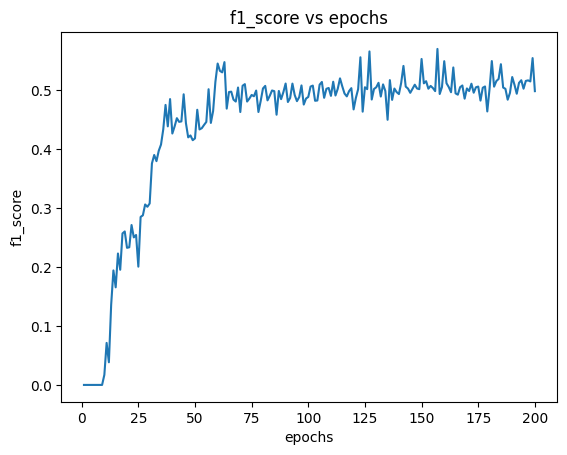

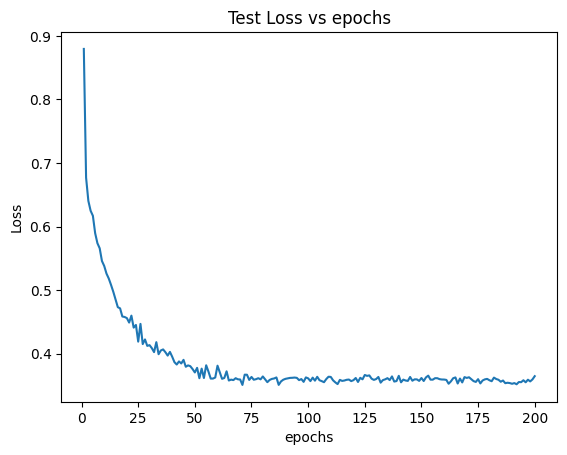

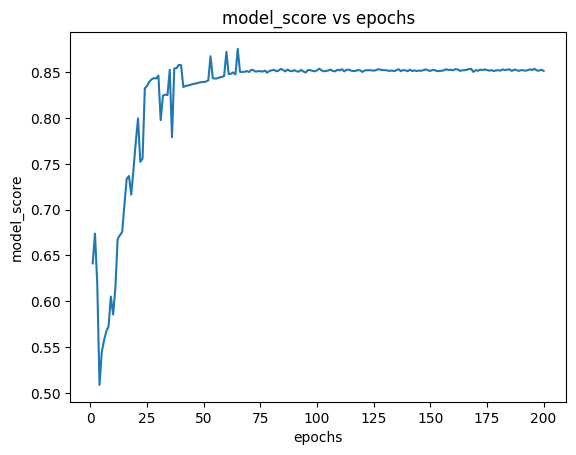

In [6]:
print(max_ms)
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Test Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

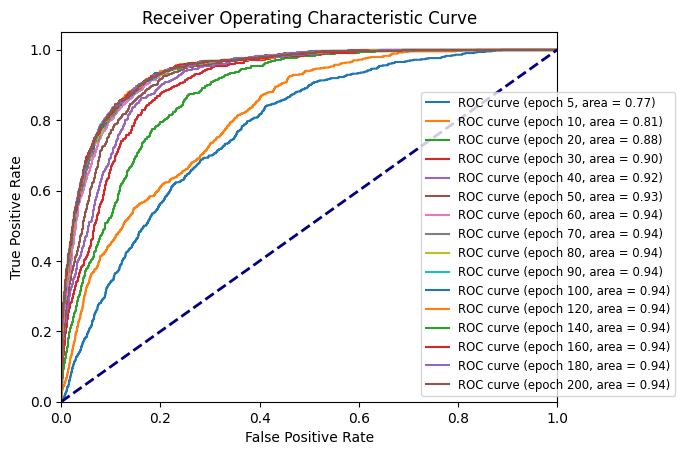

In [7]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [8]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels,all_masks,test_loss=     run_epoch(model,test_dataloader,None,epoch,'Testing',device, metric)

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
# Assuming val_preds is a numpy array with shape (n_samples, 21)
thresholded_val_preds = np.where(val_preds > np.array(thresh).reshape(1, -1), 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.5238    0.5     0       0.95
      1       0.5238    0.5     0       0.95
      2       0.5238    0.5     0       0.95
      3       0.5238    0.5     0       1
      4       0.5238    0.5     0       0.75
      5       0.5238    0.5     0       0.95
      6       0.5238    0.5     0       0.85
      7       0.5238    0.5     0       0.65
      8       0.5238    0.5     0       0.85
      9       0.5238    0.5     0       0.8
     10       0.5238    0.5     0       0.9
     11       0.6825    0.6667  1       1
     12       0.5238    0.5     0       1
     13       0.5317    0.5     0.5     0.7632
     14       0.5159    0.6667  0.6667  0.95
     15       0.5238    0.5     0       0.95
     16       0.6825    0.6667  1       1
     17       0.5159    0.6667  0.6667  1
     18       0.5159    0.6667  0.6667  1
     19       0.5238    0.5     0       1
     20       0.5238    0.5